In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core, penalty_matrix, make_input_matrices, make_input_matrices_forces
from statmechlib.forcefields import f_embed, f_dens, f_spline3, energy
from statmechlib.forcefields import loss_energy_penalized, jacobian_energy_penalized
from statmechlib.forcefields import loss_sd2_penalized, jacobian_sd2_penalized
from statmechlib.forcefields import loss_sd2f_penalized

In [4]:
working = '../data/re/working'
working_w = '../data/working'

In [5]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [6]:
params_file = 'marinica_bs'
with open(os.path.join(working_w, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [7]:
file_name = os.path.join(working_w, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [8]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [9]:
stats_file = 'stats_bsf_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bsf_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [10]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
# stats_bspline['eos_bcc']['forces'] = stats_bspline['eos_bcc']['forces'][1:4]

In [11]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]
stats_bspline['eos']['forces'] = stats_bspline['eos']['forces'][0:1]

In [12]:
# targets['relax']['box'][1] = targets['inf']['box'][0]
# targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
# targets['relax']['temp'][1] = targets['inf']['temp'][0]
# targets['relax']['beta'][1] = targets['inf']['beta'][0]
# targets['relax']['energy'][1] = targets['inf']['energy'][0]
# stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]
# stats_bspline['relax']['forces'][1] = stats_bspline['inf']['forces'][0]

In [13]:
edens_knots = list(np.linspace(1.05, 4.55, 36))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [14]:
# tkeys = ['hcp_npt_langevin_300K',
#  'hcp_npt_langevin_3700K',
# #  'fcc_npt_langevin_300K',
# #  'vac_npt_langevin_2000K',
# #  'i110_npt_langevin_2000K',
# #  'i111_npt_langevin_2000K',
# #  'screw_111_npt_langevin_2000K',
#  'liq_3700K',
# # 'liq_5000K',
#  'eos',
#  'eos_hcp',
# #  'eos_fcc',
# #  'vacint',
# #  'bain',
# # 'relax'
#     ]
tkeys = ['hcp_npt_langevin_300K',
            'hcp_npt_langevin_2700K',
            'hcp_npt_langevin_3700K',
            'bcc_npt_langevin_300K',
            'bcc_npt_langevin_2700K',
            #'fcc_npt_langevin_300K',
            #'vac_npt_langevin_2000K',
            #'i110_npt_langevin_2000K',
            #'i111_npt_langevin_2000K',
            #'screw_111_npt_langevin_2000K',
            'liq_2700K',
            'liq_3700K',
             'eos',
             'eos_hcp',
]

In [443]:
targets['eos_hcp']['weight'] = 0.0
#targets['bain']['weight'] = 0.003 #0.1
targets['eos']['weight'] = 1e-4
#targets['eos_bcc']['weight'] = 0.003 #0.1
#targets['relax']['weight'] = 8.0
targets['inf']['weight'] = 0.0
#targets['vacint']['weight'] = 0.0
#targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['hcp_npt_langevin_300K']['weight'] = 5.0
targets['hcp_npt_langevin_2700K']['weight'] = 2.0
targets['hcp_npt_langevin_3700K']['weight'] = 0.5
targets['bcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_2700K']['weight'] = 1.0
targets['liq_2700K']['weight'] = 1.0
targets['liq_3700K']['weight'] = 1.0

# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 5000.0

for tmp in targets['eos_hcp']['temp']:
    tmp = 10000.0
for tmp in targets['eos_hcp']['beta']:
    tmp = 1./10000.0
    
# for tmp in targets['bain']['temp']:
#     tmp = 10000.0
# for tmp in targets['bain']['beta']:
#     tmp = 1./10000.0
#targets['eos']['energy']

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('hcp_npt_langevin_300K', 5.0),
 ('hcp_npt_langevin_2700K', 2.0),
 ('hcp_npt_langevin_3700K', 0.5),
 ('bcc_npt_langevin_300K', 1.0),
 ('bcc_npt_langevin_2700K', 1.0),
 ('liq_2700K', 1.0),
 ('liq_3700K', 1.0),
 ('eos_hcp', 0.0),
 ('eos', 0.0001),
 ('inf', 0.0)]

In [16]:
dl_dict = {key:0.0 for key in tkeys}
#dl_dict['relax'] = 0.03
#dl_dict['bcc_npt_langevin_300K'] = 0.1
# dl_dict['bcc_npt_langevin_3700K'] = 0.03
# dl_dict['vac_npt_langevin_2000K'] = 0.03
# dl_dict['screw_111_npt_langevin_2000K'] = 0.03
# dl_dict['i111_npt_langevin_2000K'] = 0.03
# dl_dict['i110_npt_langevin_2000K'] = 0.01
#dl_dict['liq_3700K'] = 0.01
#dl_dict['eos_bcc'] = 0.1
#dl_dict['bain'] = 0.1
dl_list = [dl_dict[key] for key in tkeys]

In [17]:
[(k,d) for k, d in zip(dl_list, tkeys)]

[(0.0, 'hcp_npt_langevin_300K'),
 (0.0, 'hcp_npt_langevin_2700K'),
 (0.0, 'hcp_npt_langevin_3700K'),
 (0.0, 'bcc_npt_langevin_300K'),
 (0.0, 'bcc_npt_langevin_2700K'),
 (0.0, 'liq_2700K'),
 (0.0, 'liq_3700K'),
 (0.0, 'eos'),
 (0.0, 'eos_hcp')]

## SD matching

**Parameters optimized only on energetics**

In [511]:
# b_init = np.array([-1.58055350e-05,  4.72428899e+03,  4.13258897e+04,  3.58420459e+04,
#         2.07899629e+04,  1.61674266e+04,  5.19724009e+03,  2.82051001e+03,
#         1.48658121e+03,  1.19490176e+03,  9.44157006e+02,  7.32187479e+02,
#         5.56031196e+02,  4.12166879e+02,  2.97695170e+02,  2.11044537e+02,
#         1.47132499e+02,  9.89888586e+01,  6.65395496e+01,  4.66944626e+01,
#         3.91601985e+01,  4.13893687e+01,  4.83334836e+01,  5.50007820e+01,
#         5.78861299e+01,  5.60617904e+01,  5.14175171e+01,  4.39707865e+01,
#         3.56225364e+01,  2.69839581e+01,  1.90100691e+01,  1.11771059e+01,
#         5.47366168e+00,  4.43745861e+00,  2.84283938e+00,  1.17480863e+00,
#         7.71420317e-01,  7.05470258e-01,  1.04245885e-01, -2.06344247e+00,
#         1.69408662e-01, -3.27998267e+00, -1.14708137e+00,  8.33514266e-02,
#         1.34958645e+04,  1.34212116e+04,  1.32002833e+04,  1.28340293e+04,
#         1.23257381e+04,  1.16780662e+04,  1.08976952e+04,  9.99923281e+03,
#         9.00295403e+03,  7.93624364e+03,  6.83612121e+03,  5.74923643e+03,
#         4.73222090e+03,  3.82844861e+03,  3.04188172e+03,  2.40723441e+03,
#         1.94161717e+03,  1.55696940e+03,  1.29721257e+03,  1.16545748e+03,
#         1.12251894e+03,  1.08480722e+03,  1.00912152e+03,  9.03962953e+02,
#         7.80816501e+02,  6.31477305e+02,  4.89540089e+02,  3.49291518e+02,
#         2.27045782e+02,  1.25887811e+02,  8.26758184e+01,  8.60662668e+01,
#         6.45499032e+01,  5.05153089e+01,  6.36872975e+01,  2.82942602e+01])

# b_init = np.array([-1.68318494e-05,  4.72561269e+03,  4.15939750e+03,  3.62679252e+03,
#         3.12855195e+03,  2.66516616e+03,  2.23802195e+03,  1.84884046e+03,
#         1.50003006e+03,  1.19385932e+03,  9.31675046e+02,  7.13265302e+02,
#         5.36707649e+02,  3.98170699e+02,  2.91161816e+02,  2.09358342e+02,
#         1.48750322e+02,  1.05313105e+02,  7.63397870e+01,  6.00750233e+01,
#         5.35872992e+01,  5.36899809e+01,  5.69917086e+01,  6.00050626e+01,
#         6.09360079e+01,  5.87712858e+01,  5.30972874e+01,  4.45156042e+01,
#         3.35318187e+01,  2.27726111e+01,  1.55466633e+01,  1.11643211e+01,
#         8.38417341e+00,  5.82541880e+00,  3.55191873e+00,  1.86887116e+00,
#         1.12786376e+00,  5.54219562e-01,  1.41154148e-01, -8.46020757e-01,
#        -1.60600376e-01, -3.65151346e-02,  4.14476713e-01,  2.72034221e-01,
#         1.35608997e+04,  1.34564141e+04,  1.32298872e+04,  1.28804286e+04,
#         1.23966596e+04,  1.17734542e+04,  1.10253466e+04,  1.01652379e+04,
#         9.20998240e+03,  8.17234361e+03,  7.06827812e+03,  5.93201700e+03,
#         4.82464117e+03,  3.83719170e+03,  3.01510899e+03,  2.32948145e+03,
#         1.81131325e+03,  1.40394459e+03,  1.10182097e+03,  8.99961443e+02,
#         7.72531758e+02,  6.96994266e+02,  6.57893601e+02,  6.39834839e+02,
#         6.16890887e+02,  5.76140099e+02,  5.00356724e+02,  3.82315526e+02,
#         2.78293221e+02,  2.05077213e+02,  1.53329786e+02,  1.08877717e+02,
#         6.42998452e+01,  1.81265741e+01,  4.96494193e+00,  1.56821926e+01])

# b_all = np.array([-1.68318494e-05,  5.92199367e+03,  6.20984545e+03,  6.27107529e+03,
# 6.10463477e+03,  5.70968955e+03,  5.10309414e+03,  4.32585712e+03,
#  3.44182330e+03,  2.53110831e+03,  1.67167405e+03,  9.31269446e+02,
#         5.36707649e+02,  3.98170699e+02,  2.91161816e+02,  2.09358342e+02,
#         1.48750322e+02,  1.05313105e+02,  7.63397870e+01,  6.00750233e+01,
#         5.35872992e+01,  5.36899809e+01,  5.69917086e+01,  6.00050626e+01,
#         6.09360079e+01,  5.87712858e+01,  5.30972874e+01,  4.45156042e+01,
#         3.35318187e+01,  2.27726111e+01,  1.55466633e+01,  1.11643211e+01,
#         8.38417341e+00,  5.82541880e+00,  3.55191873e+00,  1.86887116e+00,
#         1.12786376e+00,  5.54219562e-01,  1.41154148e-01, -8.46020757e-01,
#        -1.60600376e-01, -3.65151346e-02,  4.14476713e-01,  2.72034221e-01,
#         1.35608997e+04,  1.34564141e+04,  1.32298872e+04,  1.28804286e+04,
#         1.23966596e+04,  1.17734542e+04,  1.10253466e+04,  1.01652379e+04,
#         9.20998240e+03,  8.17234361e+03,  7.06827812e+03,  5.93201700e+03,
#         4.82464117e+03,  3.83719170e+03,  3.01510899e+03,  2.32948145e+03,
#         1.81131325e+03,  1.40394459e+03,  1.10182097e+03,  8.99961443e+02,
#         7.72531758e+02,  6.96994266e+02,  6.57893601e+02,  6.39834839e+02,
#         6.16890887e+02,  5.76140099e+02,  5.00356724e+02,  3.82315526e+02,
#         2.78293221e+02,  2.05077213e+02,  1.53329786e+02,  1.08877717e+02,
#         6.42998452e+01,  1.81265741e+01,  4.96494193e+00,  1.56821926e+01])
# b_init = np.array([-2.16999452e-05,  4.84604673e+03,  4.16014482e+03,  3.55242287e+03,
#         3.02209057e+03,  2.56467979e+03,  2.16960456e+03,  1.82313561e+03,
#         1.51472373e+03,  1.23634422e+03,  9.85223508e+02,  7.64447043e+02,
#         5.78893962e+02,  4.30185064e+02,  3.15480849e+02,  2.28437567e+02,
#         1.60417079e+02,  1.07829131e+02,  6.94412491e+01,  4.75017082e+01,
#         3.99997460e+01,  4.16361385e+01,  5.01591352e+01,  6.04648756e+01,
#         6.67433265e+01,  6.44085595e+01,  5.39327203e+01,  4.12437670e+01,
#         3.00563382e+01,  2.06502403e+01,  1.32169551e+01,  8.84768339e+00,
#         6.66935323e+00,  3.99558624e+00,  1.63465343e+00,  8.66629993e-01,
#         1.44520894e+00,  8.55587369e-02,  2.12407643e-01, -1.51105521e+00,
#         1.47389934e-01, -2.78363566e-01, -8.54637897e-01,  1.23319053e-01,
#         1.36059173e+04,  1.42296373e+04,  1.44587181e+04,  1.42679517e+04,
#         1.36947678e+04,  1.28142264e+04,  1.17257810e+04,  1.05189046e+04,
#         9.30537172e+03,  8.12738588e+03,  6.98156967e+03,  5.88964860e+03,
#         4.86177555e+03,  3.91050794e+03,  3.04067306e+03,  2.33651154e+03,
#         1.75795479e+03,  1.31003397e+03,  9.93262086e+02,  8.19439590e+02,
#         8.18263234e+02,  7.91553371e+02,  7.74251130e+02,  7.89130420e+02,
#         7.96628154e+02,  7.54539820e+02,  5.92062259e+02,  4.51410558e+02,
#         3.23612143e+02,  2.30555830e+02,  1.43306102e+02,  6.61176871e+01,
#         6.93801662e+01,  2.76268727e+01, -1.09719919e+01,  2.10915961e+01])

## W
b_init_w = np.array([-1.58055350e-05,  4.72428899e+03,  4.13258897e+03,  3.58420459e+03,
        3.07899629e+03,  2.61674266e+03,  2.19724009e+03,  1.82051001e+03,
        1.48658121e+03,  1.19490176e+03,  9.44157006e+02,  7.32187479e+02,
        5.56031196e+02,  4.12166879e+02,  2.97695170e+02,  2.11044537e+02,
        1.47132499e+02,  9.89888586e+01,  6.65395496e+01,  4.66944626e+01,
        3.91601985e+01,  4.13893687e+01,  4.83334836e+01,  5.50007820e+01,
        5.78861299e+01,  5.60617904e+01,  5.14175171e+01,  4.39707865e+01,
        3.56225364e+01,  2.69839581e+01,  1.90100691e+01,  1.11771059e+01,
        5.47366168e+00,  4.43745861e+00,  2.84283938e+00,  1.17480863e+00,
        7.71420317e-01,  7.05470258e-01,  1.04245885e-01, -2.06344247e+00,
        1.69408662e-01, -3.27998267e+00, -1.14708137e+00,  8.33514266e-02,
        1.34958645e+04,  1.34212116e+04,  1.32002833e+04,  1.28340293e+04,
        1.23257381e+04,  1.16780662e+04,  1.08976952e+04,  9.99923281e+03,
        9.00295403e+03,  7.93624364e+03,  6.83612121e+03,  5.74923643e+03,
        4.73222090e+03,  3.82844861e+03,  3.04188172e+03,  2.40723441e+03,
        1.94161717e+03,  1.55696940e+03,  1.29721257e+03,  1.16545748e+03,
        1.12251894e+03,  1.08480722e+03,  1.00912152e+03,  9.03962953e+02,
        7.80816501e+02,  6.31477305e+02,  4.89540089e+02,  3.49291518e+02,
        2.27045782e+02,  1.25887811e+02,  8.26758184e+01,  8.60662668e+01,
        6.45499032e+01,  5.05153089e+01,  6.36872975e+01,  2.82942602e+01])

b_init_y = np.array([-4.23177454e-06,  8.14340702e+03,  7.33081700e+03,  6.54237110e+03,
        5.77815169e+03,  5.03828482e+03,  4.32325588e+03,  3.63381215e+03,
        2.97442215e+03,  2.35302375e+03,  1.78096712e+03,  1.27280088e+03,
        8.41357377e+02,  4.94627593e+02,  2.35239416e+02,  6.06394174e+01,
       -3.91812618e+01, -8.12690749e+01, -8.30304348e+01, -6.15966451e+01,
       -3.22795151e+01, -5.62743189e+00,  1.39482507e+01,  2.64802921e+01,
        3.46760031e+01,  4.04630217e+01,  4.36676297e+01,  4.17684503e+01,
        3.13520604e+01,  1.43204468e+01, -2.26760022e+00, -1.14641238e+01,
       -1.31081413e+01, -1.09687518e+01, -8.37049026e+00, -5.80996577e+00,
       -1.95789137e+00,  1.35352851e+00,  2.41847475e+00,  3.18298264e+00,
        3.89546437e+00,  3.02216163e+00,  7.73866899e-02,  1.07622123e+00,
        3.63986436e+04,  3.39263604e+04,  3.16337762e+04,  2.95079603e+04,
        2.74919999e+04,  2.54747324e+04,  2.32731100e+04,  2.07034239e+04,
        1.76851219e+04,  1.42529978e+04,  1.06076351e+04,  7.10158759e+03,
        4.17682640e+03,  2.17946379e+03,  1.00394446e+03,  3.66740766e+02,
        1.07343932e+02,  1.42012989e+02,  2.49321102e+02,  4.19905192e+02,
        6.63423489e+02,  8.29713870e+02,  8.98259685e+02,  9.33787201e+02,
        9.77969418e+02,  9.67742472e+02,  8.48786820e+02,  6.93935879e+02,
        4.88984955e+02,  2.90374539e+02,  1.23117722e+02,  3.75161999e+01,
        1.99433365e+01, -1.52807700e+01, -6.39369398e+01, -2.21910007e+01])

b_init_x = np.array([-4.23177454e-06, 8.14340702e+03,  7.33081700e+03,  6.54237110e+03,
        5.77815169e+03,  5.03828482e+03,  4.32325588e+03,  3.63381215e+03,
        2.97442215e+03,  2.35302375e+03,  1.78096712e+03,  1.27280088e+03,
        8.41357377e+02,  4.94627593e+02,   2.97695170e+02,  2.11044537e+02,
        1.47132499e+02,  9.89888586e+01,  6.65395496e+01,  4.66944626e+01,
        3.91601985e+01,  4.13893687e+01,  4.83334836e+01,  5.50007820e+01,
        5.78861299e+01,  5.60617904e+01,  5.14175171e+01,  4.39707865e+01,
        3.56225364e+01,  2.69839581e+01,  1.90100691e+01,  1.11771059e+01,
        5.47366168e+00,  4.43745861e+00,  2.84283938e+00,  1.17480863e+00,
        7.71420317e-01,  7.05470258e-01,  1.04245885e-01, -2.06344247e+00,
        1.69408662e-01, -3.27998267e+00, -1.14708137e+00,  8.33514266e-02,
        3.63986436e+04,  3.39263604e+04,  3.16337762e+04,  2.95079603e+04,
        2.74919999e+04,  2.54747324e+04,  2.32731100e+04,  2.07034239e+04,
        1.76851219e+04,  1.42529978e+04,  1.06076351e+04,  7.10158759e+03,
        4.73222090e+03,  3.82844861e+03,  3.04188172e+03,  2.40723441e+03,
        1.94161717e+03,  1.55696940e+03,  1.29721257e+03,  1.16545748e+03,
        1.12251894e+03,  1.08480722e+03,  1.00912152e+03,  9.03962953e+02,
        7.80816501e+02,  6.31477305e+02,  4.89540089e+02,  3.49291518e+02,
        2.27045782e+02,  1.25887811e+02,  8.26758184e+01,  8.60662668e+01,
        6.45499032e+01,  5.05153089e+01,  6.36872975e+01,  2.82942602e+01])

b_init_final = np.array([-4.39586753e-06,  8.16840696e+03,  7.34815604e+03,  6.55064724e+03,
        5.77586929e+03,  5.02435212e+03,  4.29855972e+03,  3.60238894e+03,
        2.94112106e+03,  2.32264636e+03,  1.75778551e+03,  1.25824000e+03,
        8.34292034e+02,  4.93286257e+02,  2.38264089e+02,  6.65677497e+01,
       -3.12627206e+01, -7.34252742e+01, -7.84078432e+01, -6.09803642e+01,
       -3.29272256e+01, -3.75707197e+00,  2.01145914e+01,  3.53443252e+01,
        4.22135879e+01,  4.32967561e+01,  4.09330894e+01,  3.62060228e+01,
        2.88165159e+01,  1.94367326e+01,  8.98368576e+00, -1.96588187e+00,
       -1.11079444e+01, -1.51450750e+01, -1.34284350e+01, -7.76595383e+00,
       -2.36862962e+00,  1.33134079e-01,  1.53623022e+00,  2.18665299e+00,
        2.68588947e+00,  2.00384680e+00,  7.27082842e-01,  2.35504357e-01,
        3.50997840e+04,  3.36768535e+04,  3.19439467e+04,  2.99194558e+04,
        2.76190654e+04,  2.51055172e+04,  2.24268743e+04,  1.95899329e+04,
        1.65902870e+04,  1.34043021e+04,  1.01191394e+04,  6.97312817e+03,
        4.24487797e+03,  2.24950010e+03,  1.05701711e+03,  4.19597070e+02,
        1.59094608e+02,  1.52578839e+02,  2.62466104e+02,  4.21842550e+02,
        6.75321708e+02,  8.64349359e+02,  9.41370011e+02,  9.46064607e+02,
        9.45382932e+02,  8.99392905e+02,  7.76686317e+02,  6.52641105e+02,
        5.08489320e+02,  3.48963671e+02,  1.76810485e+02,  3.33164297e+01,
       -1.58499566e+01, -5.87307054e+01, -6.38679798e+01, -1.71105949e+01])
b_init = ([-1.64553268e-05,  4.71857174e+03,  4.12329362e+03,  3.57338317e+03,
        3.06908547e+03,  2.61041274e+03,  2.19661725e+03,  1.82625228e+03,
        1.49738599e+03,  1.20801966e+03,  9.56730153e+02,  7.42271650e+02,
        5.62807001e+02,  4.15997774e+02,  2.99306500e+02,  2.10359289e+02,
        1.45693862e+02,  1.00628245e+02,  7.11542412e+01,  5.32117294e+01,
        4.32386822e+01,  3.79792444e+01,  3.62258833e+01,  3.64758891e+01,
        3.70719036e+01,  3.69975191e+01,  3.53354682e+01,  3.15659153e+01,
        2.52723239e+01,  1.70147424e+01,  7.92818875e+00, -3.88761572e-01,
       -6.72008237e+00, -1.04481500e+01, -1.11345766e+01, -9.01179914e+00,
       -5.13518031e+00, -1.41501232e+00, -2.96352812e-02, -7.28422859e-01,
       -1.48006005e+00, -4.84091241e-01,  6.74198687e-01, -2.46971664e-01,
        1.56341864e+04,  1.47909466e+04,  1.39606411e+04,  1.31344338e+04,
        1.23159955e+04,  1.15085333e+04,  1.07157343e+04,  9.93081260e+03,
        9.11933424e+03,  8.21494967e+03,  7.18178923e+03,  6.04213623e+03,
        4.85535775e+03,  3.75902682e+03,  2.87470220e+03,  2.21316138e+03,
        1.72847407e+03,  1.37902374e+03,  1.12528804e+03,  8.96529676e+02,
        7.36534655e+02,  6.15273757e+02,  5.03272969e+02,  4.28911250e+02,
        4.31431662e+02,  4.82809913e+02,  4.44052699e+02,  3.54944973e+02,
        2.55408156e+02,  1.32379764e+02,  7.78184790e+00, -5.97689513e+01,
       -7.23708649e+01, -1.04830670e+02, -8.71555887e+01, -3.66237677e+01])

In [512]:
#b_init_comb = 0.5*(b_init + b_init_final)

In [513]:
#b_init = b_init_y

In [514]:
scale = np.ones((len(pair_knots)))*0.50
scale[-6:] *= 1.0
len(pair_knots), len(edens_knots), len(b_init)

(43, 36, 80)

In [515]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.01, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2_u'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2_u':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=1.0)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    elif penalty_type == 'sd2_f':
        X, y, weight, beta, dl, bounds, force_atoms = make_input_matrices_forces(targets, stat, keytrj=tkeys, combined=0.35, dl_dict=dl_dict)
        print('wdl', len(weight), len(dl))
        loss = loss_sd2f_penalized
        #jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, dl, force_atoms, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':50000}))

    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))


0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.] [[ 0.0e+00  0.0e+00  0.0e+00 ...  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00  2.5e-01 -7.5e-01 ...  0.0e+00  0.0e+00  0.0e+00]
 [ 0.0e+00 -7.5e-01  2.5e+00 ...  0.0e+00  0.0e+00  0.0e+00]
 ...
 [ 0.0e+00  0.0e+00  0.0e+00 ...  1.9e-03 -1.2e-03  3.0e-04]
 [ 0.0e+00  0.0e+00  0.0e+00 ... -1.2e-03  1.0e-03 -3.0e-04]
 [ 0.0e+00  0.0e+00  0.0e+00 ...  3.0e-04 -3.0e-04  1.0e-04]]
bounds [slice(0, 415, 1), slice(415, 1278, 1), slice(1278, 1454, 1), slice(1454, 2079, 1), slice(2079, 2624, 1), slice(2624, 3045, 1), slice(3045, 3531, 1), slice(3531, 3532, 1), slice(0, 3732, 1)]
weights [5.0, 2.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.0001, 1.0]
1.5212103228257545e-06 1.2662142322079974e-06 2.5499609061775717e-07
0.0006070198491890588 0.000606764853098441 2.5499609061

1.9095222277092128e-05 1.6029396137743088e-06 1.749228266331782e-05
7.194728904760618e-05 7.146083156101805e-05 4.864574865881264e-07
1.8507091684691764e-05 1.8200980928697233e-05 3.0611075599453216e-07
6.092523859171742e-05 1.2854927843054516e-06 5.9639745807411965e-05
1.5527953202927477e-05 1.2746646459998216e-06 1.4253288556927656e-05
5.464064224214017e-05 1.3116786986390102e-06 5.332896354350116e-05
1.4108143363742584e-05 1.297885300957442e-06 1.2810258062785142e-05
5.224068081927746e-05 4.904714683836347e-05 3.1935339809139943e-06
1.3241197000683982e-05 1.233247586786179e-05 9.087211328221929e-07
5.070198480652293e-05 3.4154552293463775e-06 4.728652957717655e-05
1.3163870474782456e-05 1.80277030706697e-06 1.1361100167715485e-05
4.514158909572236e-05 4.4793805621184675e-05 3.4778347453767996e-07
1.1776733599229688e-05 1.150071987621951e-05 2.7601372301017705e-07
0.00010999036357197626 0.00010699689774736675 2.9934658246095024e-06
1.4196850047027989e-05 1.3183988330044743e-05 1.0128

2.3342748509690547e-06 1.2647618194473582e-06 1.0695130315216965e-06
5.22416140679231e-06 4.9548210991841746e-06 2.6934030760813583e-07
2.3928046044668934e-06 2.136453806648132e-06 2.563507978187613e-07
4.735846257958045e-06 1.270347218827818e-06 3.465499039130227e-06
2.287465844480118e-06 1.275744028740589e-06 1.011721815739529e-06
4.646424577300837e-06 1.5154822948382357e-06 3.1309422824626018e-06
2.2911246722046174e-06 1.3377026327923645e-06 9.534220394122531e-07
4.6834667330991304e-06 3.0226991404626915e-06 1.6607675926364392e-06
2.2736559499174524e-06 1.667861152242793e-06 6.057947976746596e-07
4.35175255413939e-06 1.407021297374819e-06 2.9447312567645716e-06
5.1732638261163924e-06 4.753031290771052e-06 4.202325353453398e-07
2.2773009861240947e-06 1.986866765495248e-06 2.90434220628847e-07
4.470798407387517e-06 4.008967312066481e-06 4.618310953210357e-07
2.224806929490319e-06 1.9380417947584055e-06 2.8676513473191333e-07
4.433337189782207e-06 1.4488349464930354e-06 2.9845022432891

1.6285455434209532e-06 1.3731147347645814e-06 2.5543080865637194e-07
1.959755433044018e-06 1.2856850596606734e-06 6.740703733833448e-07
1.9338419973649338e-06 1.6111842944124232e-06 3.226577029525106e-07
1.9720811434363186e-06 1.289088497287998e-06 6.829926461483205e-07
1.6244972057870152e-06 1.2660421626225646e-06 3.5845504316445045e-07
1.961616295276006e-06 1.6346383326486995e-06 3.269779626273066e-07
1.6111056718659635e-06 1.3399250962168382e-06 2.7118057564912533e-07
1.933586335906455e-06 1.4776932357263009e-06 4.5589310018015397e-07
1.6101992491186346e-06 1.31882584963858e-06 2.913733994800545e-07
1.9331473213202617e-06 1.6032558197385809e-06 3.298915015816806e-07
1.6072198941826669e-06 1.3307319299721492e-06 2.764879642105177e-07
1.964860981510324e-06 1.695832137312722e-06 2.69028844197602e-07
1.6018152008897627e-06 1.3434083266733097e-06 2.58406874216453e-07
1.9343992368308146e-06 1.2628383110648621e-06 6.715609257659526e-07
1.6064164176615623e-06 1.2624776693128798e-06 3.439387

1.5404811236498476e-06 1.2669406935087515e-06 2.7354043014109607e-07
1.6290299482758522e-06 1.3699595262050499e-06 2.5907042207080227e-07
1.5405735506727963e-06 1.2875953851441748e-06 2.5297816552862145e-07
1.638610181522266e-06 1.2703874602838354e-06 3.682227212384305e-07
1.5399075917946871e-06 1.2607603386224078e-06 2.791472531722792e-07
1.6152422266642922e-06 1.359927160131866e-06 2.5531506653242615e-07
1.5386823183787622e-06 1.2840208057145133e-06 2.54661512664249e-07
1.620980901119725e-06 1.3507282899741187e-06 2.7025261114560636e-07
1.5364855157993512e-06 1.27784040158242e-06 2.5864511421693124e-07
1.625441052266506e-06 1.3216388181740947e-06 3.0380223409241125e-07
1.53619974930803e-06 1.2741208097139198e-06 2.620789395941102e-07
1.619799730588061e-06 1.3467826460759995e-06 2.730170845120614e-07
1.5358004960492898e-06 1.2755013908928027e-06 2.602991051564871e-07
1.6100955092117897e-06 1.2591068118558018e-06 3.509886973559878e-07
1.5366834229698631e-06 1.2608061107584396e-06 2.758

1.5220042805485735e-06 1.2677978515188398e-06 2.5420642902973384e-07
1.5550250587756143e-06 1.2728902848007716e-06 2.821347739748427e-07
1.5216272411182613e-06 1.2652446557498934e-06 2.563825853683679e-07
1.5508686648926246e-06 1.2968407452816835e-06 2.540279196109411e-07
1.522126544413305e-06 1.2676600060799387e-06 2.5446653833336624e-07
1.5582756509394236e-06 1.3016444022379566e-06 2.56631248701467e-07
1.520889646945743e-06 1.2669532435332538e-06 2.5393640341248925e-07
1.544350616252271e-06 1.271714295207381e-06 2.7263632104488976e-07
1.5496234544468939e-06 1.2615772582761906e-06 2.880461961707033e-07
1.5214257128280883e-06 1.2601956348327484e-06 2.612300779953398e-07
1.5453539986110668e-06 1.2582716814864165e-06 2.870823171246502e-07
1.5500508252150782e-06 1.2756182508093856e-06 2.7443257440569254e-07
1.5210672105332403e-06 1.262202394613483e-06 2.5886481591975726e-07
1.5476899295924197e-06 1.2588855227076777e-06 2.888044068847421e-07
1.521035302264019e-06 1.2597979435848826e-06 2.6

1.5304323104552464e-06 1.2719833249600122e-06 2.5844898549523424e-07
1.5154840317987526e-06 1.2614235790459246e-06 2.5406045275282794e-07
1.5246498581902957e-06 1.2652951423974096e-06 2.593547157928861e-07
1.5273324010746199e-06 1.269244658882399e-06 2.5808774219222086e-07
1.5158250980284622e-06 1.2600902935136436e-06 2.5573480451481856e-07
1.5267224870513083e-06 1.259755356782016e-06 2.669671302692922e-07
1.51567245157345e-06 1.2588282605153795e-06 2.5684419105807054e-07
1.5236508472167907e-06 1.2615239226287547e-06 2.621269245880359e-07
1.525592805434646e-06 1.265959084138227e-06 2.5963372129641897e-07
1.515688190550428e-06 1.2604567141500813e-06 2.552314764003467e-07
1.5239463581926678e-06 1.2587105519777286e-06 2.652358062149392e-07
1.5257639490932724e-06 1.260927699396398e-06 2.648362496968744e-07
1.5155529738614132e-06 1.2590829497240933e-06 2.564700241373198e-07
1.5225341228442442e-06 1.26910386789124e-06 2.5343025495300427e-07
1.5246290278993401e-06 1.2596807793301095e-06 2.649

1.5172650829526072e-06 1.2624955295346124e-06 2.5476955341799484e-07
1.5131289428094022e-06 1.2595417675831968e-06 2.535871752262054e-07
1.5156129224099252e-06 1.2610920722772298e-06 2.545208501326954e-07
1.520222974908902e-06 1.2645481103673924e-06 2.556748645415095e-07
1.512741616056667e-06 1.2598047029327265e-06 2.529369131239406e-07
1.5169456984424341e-06 1.2632191665567006e-06 2.537265318857334e-07
1.5131135987607414e-06 1.25938318729095e-06 2.5373041146979136e-07
1.5180838876092573e-06 1.2633034202084414e-06 2.5478046740081595e-07
1.5129643001501667e-06 1.259122358710517e-06 2.538419414396497e-07
1.5205980740052259e-06 1.266512471278316e-06 2.5408560272690975e-07
1.5126611448910094e-06 1.2592501314275287e-06 2.534110134634808e-07
1.51929148603035e-06 1.2649421807938715e-06 2.543493052364785e-07
1.5127757783618622e-06 1.2593092454112334e-06 2.534665329506288e-07
1.5162024277677227e-06 1.2579726675369504e-06 2.582297602307722e-07
1.5169361417531738e-06 1.2591293663207946e-06 2.5780

1.5124277120105424e-06 1.2583265695898835e-06 2.541011424206589e-07
1.5152086553836338e-06 1.2583359522728635e-06 2.568727031107703e-07
1.5119198828152737e-06 1.257774262892781e-06 2.541456199224925e-07
1.5130512352553504e-06 1.2577123730179627e-06 2.553388622373876e-07
1.5141085124126251e-06 1.2605182477618912e-06 2.53590264650734e-07
1.5119685809481846e-06 1.2583329931082396e-06 2.5363558783994505e-07
1.5120241584323528e-06 1.2575724784930468e-06 2.5445167993930597e-07
1.5124479296938773e-06 1.2578874897082194e-06 2.54560439985658e-07
1.5141662726164595e-06 1.2588333930754353e-06 2.5533287954102404e-07
1.5118902043964168e-06 1.2584772860996328e-06 2.53412918296784e-07
1.5126478300182135e-06 1.25880409268063e-06 2.538437373375835e-07
1.5140189200703137e-06 1.2581099557522827e-06 2.5590896431803103e-07
1.511883589771299e-06 1.2579559724133294e-06 2.5392761735796966e-07
1.5146192767514636e-06 1.2613976727756161e-06 2.532216039758475e-07
1.5117879281469694e-06 1.258202945569726e-06 2.535

1.512468670652939e-06 1.258900588815968e-06 2.53568081836971e-07
1.5110782475293077e-06 1.2579178616187918e-06 2.531603859105158e-07
1.5110450072431174e-06 1.2581198221510545e-06 2.5292518509206277e-07
1.511597900407782e-06 1.2582209614430848e-06 2.5337693896469717e-07
1.5118340551471864e-06 1.2584372235473274e-06 2.5339683159985896e-07
1.5123103445666241e-06 1.2588305514680828e-06 2.534797930985414e-07
1.5110692316870959e-06 1.257844295579414e-06 2.532249361076819e-07
1.5124414656725464e-06 1.2591828439950217e-06 2.532586216775246e-07
1.5110520122621285e-06 1.2576574314505198e-06 2.533945808116087e-07
1.5105452029975482e-06 1.257204872191228e-06 2.5334033080632025e-07
1.5111835432330435e-06 1.258058675957219e-06 2.531248672758244e-07
1.5122475984461094e-06 1.2584038367317285e-06 2.538437617143808e-07
1.5110387946067707e-06 1.257813385335808e-06 2.532254092709627e-07
1.5122462810653716e-06 1.2590108737073067e-06 2.532354073580649e-07
1.5110372972475116e-06 1.257772515204878e-06 2.53264

1.5108639815208608e-06 1.2577269043976837e-06 2.531370771231772e-07
1.5099738551454727e-06 1.257058995335543e-06 2.5291485980992973e-07
1.5111624700214732e-06 1.2580482689705043e-06 2.5311420105096884e-07
1.5102210521125591e-06 1.2570429443734697e-06 2.5317810773908946e-07
1.5096811147276225e-06 1.2564137562656832e-06 2.532673584619394e-07
1.5103879452245484e-06 1.2564477250907174e-06 2.5394022013383106e-07
1.5100350837061564e-06 1.2569983782441772e-06 2.530367054619791e-07
1.5095024920172022e-06 1.2565813000568462e-06 2.52921191960356e-07
1.5099353307284356e-06 1.2569902158844872e-06 2.5294511484394833e-07
1.510870722469585e-06 1.2571386226821865e-06 2.537320997873985e-07
1.5096942465809945e-06 1.2566069936942424e-06 2.530872528867522e-07
1.509230184991675e-06 1.256235980008118e-06 2.5299420498355687e-07
1.509210229611091e-06 1.2562012257875725e-06 2.530090038235184e-07
1.5106648953815634e-06 1.2575699646511633e-06 2.5309493073040015e-07
1.5108679182868057e-06 1.2567850104146802e-06 2

1.508656093547284e-06 1.255422531808922e-06 2.53233561738362e-07
1.5091542237146145e-06 1.256143262536014e-06 2.5301096117860056e-07
1.5088597473571377e-06 1.255929726313325e-06 2.5293002104381257e-07
1.5083555390493617e-06 1.2551046036987854e-06 2.532509353505762e-07
1.5086669790464109e-06 1.255479655448148e-06 2.531873235982627e-07
1.5084198485440216e-06 1.2556416748997987e-06 2.527781736442228e-07
1.5084246992211043e-06 1.255659618990966e-06 2.527650802301383e-07
1.5082644151404196e-06 1.2554002398024466e-06 2.5286417533797303e-07
1.5084230004167555e-06 1.255722228839606e-06 2.5270077157714953e-07
1.5092977400312356e-06 1.2563786017848473e-06 2.5291913824638813e-07
1.5092890011348816e-06 1.2563927543144774e-06 2.528962468204043e-07
1.5092209139632794e-06 1.256723595490109e-06 2.5249731847317037e-07
1.5082809707407543e-06 1.255396857478679e-06 2.5288411326207524e-07
1.5094417092951633e-06 1.255791452244957e-06 2.5365025705020627e-07
1.5082502616754983e-06 1.2554137250740449e-06 2.528

1.506920810710693e-06 1.2539929032414005e-06 2.529279074692926e-07
1.5066441902809849e-06 1.2534549852559552e-06 2.5318920502502975e-07
1.506867974846894e-06 1.2543540957109002e-06 2.5251387913599386e-07
1.5071132299355834e-06 1.2541213950732298e-06 2.5299183486235363e-07
1.506318746615342e-06 1.2535496301562723e-06 2.5276911645906976e-07
1.5066613519960866e-06 1.25367781740025e-06 2.529835345958367e-07
1.5073295862748276e-06 1.2543186454567703e-06 2.530109408180573e-07
1.5060951881526586e-06 1.253464173477615e-06 2.526310146750436e-07
1.5060856050073682e-06 1.2534945943282907e-06 2.525910106790775e-07
1.5059937558184707e-06 1.252948007855532e-06 2.530457479629388e-07
1.5058886034647777e-06 1.2520762161001154e-06 2.538123873646623e-07
1.5075574161386026e-06 1.2546746645538865e-06 2.5288275158471605e-07
1.506275720734922e-06 1.2533477888841252e-06 2.529279318507969e-07
1.507245284622216e-06 1.254781307001386e-06 2.5246397762083005e-07
1.5065721323951032e-06 1.2538077035428732e-06 2.5276

1.5048611173256025e-06 1.2516876631184017e-06 2.5317345420720074e-07
1.5040029579493477e-06 1.2513461220808794e-06 2.526568358684682e-07
1.5044955731404083e-06 1.2516721102284108e-06 2.528234629119976e-07
1.5037611180313473e-06 1.2507763678978603e-06 2.5298475013348705e-07
1.5054690144514017e-06 1.2528374903536347e-06 2.5263152409776695e-07
1.5057226987520594e-06 1.252681692571169e-06 2.5304100618089023e-07
1.5042946189847272e-06 1.2513375736144718e-06 2.529570453702553e-07
1.504957694799121e-06 1.251708410102234e-06 2.53249284696887e-07
1.5049564129279056e-06 1.2515946935085545e-06 2.5336171941935106e-07
1.5044286743084259e-06 1.2516838324684092e-06 2.5274484184001667e-07
1.5052043071246672e-06 1.2524166640427669e-06 2.5278764308190036e-07
1.5046526423116593e-06 1.2514957466194081e-06 2.5315689569225127e-07
1.5050963114083212e-06 1.2516848969033133e-06 2.53411414505008e-07
1.5054262926749206e-06 1.2517965911577208e-06 2.536297015171999e-07
1.5042376445895084e-06 1.251440937378817e-06 

1.5023779317713445e-06 1.248761731156593e-06 2.536162006147515e-07
1.5026449300403382e-06 1.24907610079997e-06 2.5356882924036826e-07
1.5031607570429432e-06 1.250579762980893e-06 2.525809940620502e-07
1.5020601140238918e-06 1.2490271881322656e-06 2.530329258916262e-07
1.5034796425185986e-06 1.2505567477587868e-06 2.5292289475981193e-07
1.5032118995066294e-06 1.2503570498712031e-06 2.528548496354262e-07
1.5029319121916096e-06 1.249950990784565e-06 2.5298092140704453e-07
1.5022324821503148e-06 1.249310325998483e-06 2.529221561518318e-07
1.5017576010278847e-06 1.2487556513661719e-06 2.530019496617129e-07
1.5027183168416272e-06 1.2497886442276737e-06 2.5292967261395347e-07
1.5022667984149005e-06 1.2497152711620142e-06 2.525515272528864e-07
1.503178713412326e-06 1.2497848697982726e-06 2.533938436140534e-07
1.5022049325672324e-06 1.2497702659332534e-06 2.52434666633979e-07
1.501712906038135e-06 1.2483135911324256e-06 2.533993149057096e-07
1.5021832831172245e-06 1.2485239268479073e-06 2.53659

1.501678091637277e-06 1.2486434766229664e-06 2.530346150143106e-07
1.500574526176656e-06 1.2474983738561388e-06 2.5307615232051717e-07
1.4997972448761562e-06 1.246831912081287e-06 2.5296533279486935e-07
1.50001903904696e-06 1.2467232796287055e-06 2.5329575941825454e-07
1.5006015885906305e-06 1.247311503903981e-06 2.532900846866494e-07
1.5004805198159689e-06 1.2472281240851807e-06 2.532523957307882e-07
1.5008519902246581e-06 1.2479584559394005e-06 2.528935342852577e-07
1.501030364914802e-06 1.2482449306157204e-06 2.5278543429908155e-07
1.500546405358978e-06 1.2473601005765264e-06 2.5318630478245155e-07
1.5009215928266854e-06 1.2478977586638012e-06 2.5302383416288423e-07
1.4995148793717264e-06 1.246421795483075e-06 2.5309308388865134e-07
1.499349508498218e-06 1.2458349859748966e-06 2.535145225233214e-07
1.500976823583455e-06 1.2478189009189737e-06 2.5315792266448115e-07
1.499952456926152e-06 1.24703014706682e-06 2.52922309859332e-07
1.499455661632115e-06 1.2468460670266546e-06 2.52609594

1.4991399342381416e-06 1.2446698525961878e-06 2.5447008164195383e-07
1.4989609640907492e-06 1.2456987017040343e-06 2.5326226238671494e-07
1.4986511924979331e-06 1.2456339985804025e-06 2.5301719391753066e-07
1.4998205863624898e-06 1.2463762132059982e-06 2.5344437315649146e-07
1.4991177285258765e-06 1.2462043804679222e-06 2.529133480579543e-07
1.4996209638810747e-06 1.2463722584357563e-06 2.532487054453185e-07
1.499163982575175e-06 1.2456658601605388e-06 2.5349812241463613e-07
1.498752736657796e-06 1.2451230747703767e-06 2.536296618874195e-07
1.4984044069994326e-06 1.2444749718457421e-06 2.5392943515369044e-07
1.4984218195407467e-06 1.244694963275161e-06 2.5372685626558566e-07
1.4981390231024125e-06 1.2449185183482834e-06 2.5322050475412907e-07
1.4989982157746692e-06 1.2452646904369193e-06 2.537335253377498e-07
1.4986656794414273e-06 1.2449611455967691e-06 2.5370453384465806e-07
1.499390241675311e-06 1.2462567809154586e-06 2.531334607598524e-07
1.4988094347450134e-06 1.2456248096427948e-

1.4984251001302878e-06 1.2448658449044886e-06 2.5355925522579924e-07
1.4975768606186777e-06 1.244575225846548e-06 2.5300163477212977e-07
1.497445107941426e-06 1.2434673180478322e-06 2.539777898935938e-07
1.497310804426625e-06 1.2432506371489942e-06 2.5406016727763073e-07
1.4977099549712639e-06 1.2432811753905555e-06 2.5442877958070827e-07
1.4983317929929122e-06 1.2438328784043895e-06 2.5449891458852277e-07
1.497015961579734e-06 1.243491075014412e-06 2.5352488656532186e-07
1.4966167799662803e-06 1.2432604475524118e-06 2.5335633241386847e-07
1.498029954016396e-06 1.2444359539834084e-06 2.535940000329876e-07
1.4980476946977947e-06 1.2432034759944216e-06 2.5484421870337317e-07
1.4964798451909604e-06 1.2437799375284423e-06 2.526999076625182e-07
1.4976914680574875e-06 1.243703081100205e-06 2.539883869572826e-07
1.4972570376422764e-06 1.2439425480205169e-06 2.5331448962175957e-07
1.4971546916022916e-06 1.24298568785705e-06 2.541690037452415e-07
1.4981069501622372e-06 1.2445011934795408e-06 2.

1.49651869706237e-06 1.2429174614461828e-06 2.536012356161872e-07
1.4963923622047882e-06 1.2422056352570185e-06 2.5418672694776974e-07
1.4953809067256683e-06 1.242054836776786e-06 2.533260699488823e-07
1.495856728078207e-06 1.2418190774210738e-06 2.540376506571333e-07
1.495478152486535e-06 1.2419147135766383e-06 2.5356343890989664e-07
1.4955468689083756e-06 1.2422371146215967e-06 2.5330975428677877e-07
1.4956869933360833e-06 1.2421197388723744e-06 2.535672544637089e-07
1.4946079852825244e-06 1.2414371195306858e-06 2.531708657518385e-07
1.4960324679701933e-06 1.241445109692329e-06 2.545873582778643e-07
1.4948848224940943e-06 1.2420237307777408e-06 2.528610917163535e-07
1.4947390714894646e-06 1.2413631540569308e-06 2.5337591743253385e-07
1.4945898352351687e-06 1.2408269101104345e-06 2.5376292512473427e-07
1.4951794191511972e-06 1.2410212637375675e-06 2.5415815541362977e-07
1.4960228276773992e-06 1.242126024506634e-06 2.5389680317076514e-07
1.4953581468920548e-06 1.240505675919408e-06 2.5

1.4930364061280293e-06 1.2397430352944258e-06 2.5329337083360346e-07
1.493637482321859e-06 1.2398398964636174e-06 2.537975858582416e-07
1.4943197332067018e-06 1.2400943996382668e-06 2.54225333568435e-07
1.4942204505703474e-06 1.2412884241981058e-06 2.529320263722417e-07
1.4941846530281384e-06 1.2406560523100876e-06 2.535286007180508e-07
1.4930055325161993e-06 1.2393524415083874e-06 2.5365309100781207e-07
1.4936744660703038e-06 1.2395766812450472e-06 2.540977848252565e-07
1.4941066138477512e-06 1.238730951142837e-06 2.5537566270491425e-07
1.492846026654224e-06 1.2383593263587376e-06 2.544867002954864e-07
1.4932751190467287e-06 1.2374173551753354e-06 2.5585776387139335e-07
1.4935412718344677e-06 1.2401403729820662e-06 2.534008988524016e-07
1.4933242572501934e-06 1.2391502919384608e-06 2.541739653117327e-07
1.4931052066981474e-06 1.2390113730325089e-06 2.5409383366563846e-07
1.4944131011992218e-06 1.241078890370945e-06 2.533342108282767e-07
1.4939171266857059e-06 1.2412390868427124e-06 2.

1.4918520956862545e-06 1.237571482118532e-06 2.542806135677225e-07
1.4922357184599733e-06 1.2372272329847957e-06 2.550084854751776e-07
1.4924253490401295e-06 1.23774997130765e-06 2.5467537773247954e-07
1.492751886520946e-06 1.2395685581412773e-06 2.531833283796689e-07
1.4931278215860964e-06 1.2383182804495048e-06 2.5480954113659155e-07
1.4920475819680066e-06 1.2379344310729576e-06 2.541131508950491e-07
1.4914373008923556e-06 1.237456499591362e-06 2.5398080130099347e-07
1.4925594228741072e-06 1.2397316177512532e-06 2.52827805122854e-07
1.4919368090225284e-06 1.238302950836547e-06 2.536338581859813e-07
1.4913745206076986e-06 1.2379888802685441e-06 2.5338564033915446e-07
1.4924671580382243e-06 1.2379184238982823e-06 2.5454873413994194e-07
1.491216762571536e-06 1.2366939280533243e-06 2.545228345182116e-07
1.491858318331678e-06 1.2358085289559094e-06 2.5604978937576875e-07
1.492404072073076e-06 1.2366379639666921e-06 2.557661081063839e-07
1.4912428632901424e-06 1.237376391940709e-06 2.53866

1.490378643384202e-06 1.2358843717903987e-06 2.544942715938032e-07
1.491138250799722e-06 1.237341854330613e-06 2.5379639646910904e-07
1.4896488632873725e-06 1.2353331802589601e-06 2.543156830284124e-07
1.4896831733600353e-06 1.2346343488231607e-06 2.550488245368746e-07
1.4911033958465664e-06 1.2368562128438595e-06 2.5424718300270684e-07
1.4898151044738013e-06 1.2356840457866657e-06 2.5413105868713556e-07
1.4897015259805506e-06 1.2348646792496732e-06 2.548368467308774e-07
1.4910489703079845e-06 1.237409697974036e-06 2.536392723339486e-07
1.4898230925166092e-06 1.2363925646238326e-06 2.5343052789277666e-07
1.491408478634577e-06 1.237565364328349e-06 2.53843114306228e-07
1.4908837271255937e-06 1.2348055369983503e-06 2.560781901272435e-07
1.4912228853384245e-06 1.2351939172770468e-06 2.5602896806137777e-07
1.4902116499617995e-06 1.235904740669346e-06 2.543069092924537e-07
1.4913246442379496e-06 1.237671378203346e-06 2.5365326603460345e-07
1.4908202146179423e-06 1.2370636101265064e-06 2.537

1.4890941831045984e-06 1.2350573704567462e-06 2.5403681264785235e-07
1.4893590865776325e-06 1.2348528176077314e-06 2.5450626896990115e-07
1.4885927064265023e-06 1.2346386262555311e-06 2.539540801709711e-07
1.4888082700725176e-06 1.2343096296350518e-06 2.5449864043746573e-07
1.4887751617635312e-06 1.2344930448976395e-06 2.542821168658918e-07
1.489956249936166e-06 1.234936421026329e-06 2.55019828909837e-07
1.489821486494817e-06 1.2352902891875766e-06 2.545311973072404e-07
1.4888407698153023e-06 1.2350129379476815e-06 2.5382783186762083e-07
1.489821556724743e-06 1.2363277909463155e-06 2.534937657784275e-07
1.489965900110968e-06 1.2355772576012933e-06 2.543886425096747e-07
1.4898815921709747e-06 1.235238393185129e-06 2.546431989858456e-07
1.4891418725771531e-06 1.234960543210505e-06 2.541813293666482e-07
1.4886796938146703e-06 1.2341482614014244e-06 2.54531432413246e-07
1.489409936832991e-06 1.2336798504964557e-06 2.557300863365353e-07
1.4892049256974144e-06 1.2346331828213034e-06 2.545717

1.4885686266365706e-06 1.235010108480764e-06 2.5355851815580676e-07
1.4881276651029927e-06 1.234043446073259e-06 2.5408421902973373e-07
1.4875889174600544e-06 1.233081858626463e-06 2.545070588335915e-07
1.4890294347378691e-06 1.2351673882110246e-06 2.538620465268446e-07
1.4878072737243195e-06 1.233508057882804e-06 2.5429921584151543e-07
1.4889705449581096e-06 1.2343675569197798e-06 2.5460298803832983e-07
1.4885413079301405e-06 1.2334056926431223e-06 2.5513561528701814e-07
1.4887511188283724e-06 1.2338176427273463e-06 2.54933476101026e-07
1.4889416630780182e-06 1.234758964500108e-06 2.5418269857791016e-07
1.4881294634118973e-06 1.2340987225716322e-06 2.5403074084026514e-07
1.488062755450511e-06 1.2334255547615191e-06 2.546372006889919e-07
1.4875257238882438e-06 1.2329241243478783e-06 2.5460159954036556e-07
1.4881834445953628e-06 1.234094491002e-06 2.540889535933627e-07
1.4888449588661736e-06 1.2338547998807641e-06 2.549901589854096e-07
1.4886287222249176e-06 1.2346683480889418e-06 2.539

1.4867956513052358e-06 1.232383549344893e-06 2.5441210196034294e-07
1.4867886991460504e-06 1.2323938300280723e-06 2.5439486911797816e-07
1.4875994676515429e-06 1.234017517315598e-06 2.5358195033594487e-07
1.4876467733774892e-06 1.2335266486069768e-06 2.5412012477051234e-07
1.4862271096853016e-06 1.2318216364063847e-06 2.5440547327891694e-07
1.4877171682714543e-06 1.2332186122536729e-06 2.5449855601778156e-07
1.4867613608338132e-06 1.2325056859275788e-06 2.542556749062345e-07
1.4874766115225254e-06 1.2323272199494653e-06 2.5514939157306005e-07
1.4863016457578268e-06 1.2319750914383027e-06 2.5432655431952414e-07
1.4871093639096656e-06 1.2334060955183233e-06 2.5370326839134235e-07
1.4870972653697553e-06 1.2334272691977132e-06 2.5366999617204214e-07
1.4862197932587946e-06 1.232720782026605e-06 2.5349901123218957e-07
1.4872296100039103e-06 1.2330232754882672e-06 2.54206334515643e-07
1.4869521860056255e-06 1.2311633623344574e-06 2.557888236711682e-07
1.4868551550210724e-06 1.2332059810331417

1.4852105221684406e-06 1.2311877228195822e-06 2.540227993488583e-07
1.486738479786139e-06 1.2322758333313995e-06 2.5446264645473946e-07
1.485728118889275e-06 1.2316721268739863e-06 2.5405599201528874e-07
1.4857210362691353e-06 1.2316203707033088e-06 2.541006655658265e-07
1.486078071690389e-06 1.2317900770233213e-06 2.542879946670678e-07
1.4861925529161489e-06 1.231630351433675e-06 2.5456220148247385e-07
1.4865294257139295e-06 1.2323530161887224e-06 2.5417640952520713e-07
1.486520128807571e-06 1.2327193005816819e-06 2.538008282258892e-07
1.4860955383313624e-06 1.231143631457247e-06 2.5495190687411537e-07
1.4853263860281067e-06 1.2316523031469343e-06 2.5367408288117246e-07
1.4866056073434452e-06 1.2329673715107696e-06 2.536382358326756e-07
1.485019860976362e-06 1.2313924721726876e-06 2.536273888036743e-07
1.4852170776205761e-06 1.2317411222237618e-06 2.5347595539681435e-07
1.485661307172654e-06 1.2317116892431856e-06 2.539496179294684e-07
1.4853902576275493e-06 1.2311439271414746e-06 2.5

1.4843351592257797e-06 1.2299518988934405e-06 2.543832603323392e-07
1.48418498870496e-06 1.2302284876522852e-06 2.5395650105267464e-07
1.4843310017148785e-06 1.2303133593332102e-06 2.5401764238166835e-07
1.4849675858787524e-06 1.2299580131027014e-06 2.5500957277605094e-07
1.4849676029260581e-06 1.230926917255818e-06 2.5404068567024014e-07
1.4843036748407784e-06 1.2298835766551751e-06 2.5442009818560335e-07
1.4844599909032144e-06 1.2303090676723695e-06 2.541509232308448e-07
1.4847115130050897e-06 1.2314910983182437e-06 2.5322041468684605e-07
1.4849222835674714e-06 1.2298263413074656e-06 2.5509594226000587e-07
1.4852168064965447e-06 1.231094812659074e-06 2.5412199383747067e-07
1.485513031912664e-06 1.2321540061218673e-06 2.533590257907966e-07
1.4846353731772101e-06 1.2300816091064659e-06 2.5455376407074425e-07
1.48412980851739e-06 1.2299036914197067e-06 2.542261170976832e-07
1.4843868454646191e-06 1.2298001284587913e-06 2.5458671700582786e-07
1.4840591867881113e-06 1.2297420522633848e-06

1.4843128144457774e-06 1.2294553341101522e-06 2.5485748033562517e-07
1.4837236801290127e-06 1.229169760575464e-06 2.5455391955354857e-07
1.4834628660566636e-06 1.2287106071568966e-06 2.547522588997671e-07
1.484194126037172e-06 1.2302950423484923e-06 2.5389908368867963e-07
1.4828816942977381e-06 1.2289958504619777e-06 2.5388584383576043e-07
1.4828524717671663e-06 1.2291477657862212e-06 2.53704705980945e-07
1.4830100056004824e-06 1.2287579701144026e-06 2.542520354860798e-07
1.4833169142290087e-06 1.228228920860205e-06 2.550879933688037e-07
1.483838506258504e-06 1.2290392162004173e-06 2.5479929005808687e-07
1.483760506310672e-06 1.2292744920416114e-06 2.5448601426906064e-07
1.4833352271996584e-06 1.2287184590174668e-06 2.546167681821916e-07
1.4833430120943603e-06 1.2296329720391196e-06 2.5371004005524074e-07
1.4828447043214039e-06 1.228949050616989e-06 2.538956537044149e-07
1.482945059092999e-06 1.2291286940435321e-06 2.5381636504946696e-07
1.4836824459046062e-06 1.228052436445264e-06 2.5

1.4829130471451478e-06 1.2281412982275463e-06 2.547717489176014e-07
1.4827588201678628e-06 1.2294031884528746e-06 2.533556317149882e-07
1.483459251321408e-06 1.2276500576394672e-06 2.558091936819409e-07
1.4826823191838738e-06 1.2288579865744989e-06 2.538243326093749e-07
1.4830852385188465e-06 1.2286344729721e-06 2.5445076554674645e-07
1.4831647603018636e-06 1.2295230618266262e-06 2.5364169847523753e-07
1.4828199360476379e-06 1.2275714203966573e-06 2.5524851565098063e-07
1.4829034442778904e-06 1.2285160949191668e-06 2.543873493587236e-07
1.4829778376733448e-06 1.228322478095401e-06 2.5465535957794374e-07
1.4825408905965686e-06 1.2272981465156162e-06 2.5524274408095237e-07
1.482110015221052e-06 1.228008505828047e-06 2.541015093930051e-07
1.482069317751139e-06 1.228051845373489e-06 2.5401747237764994e-07
1.4828104035074273e-06 1.2292153145066848e-06 2.5359508900074244e-07
1.4824439836936266e-06 1.2274030377419534e-06 2.5504094595167315e-07
1.4829153216855957e-06 1.228365724361219e-06 2.54

1.4816544510375822e-06 1.2275144621191897e-06 2.5413998891839244e-07
1.482516087689578e-06 1.228107097016565e-06 2.5440899067301305e-07
1.4817804660762137e-06 1.2269060612290433e-06 2.548744048471704e-07
1.481694686875209e-06 1.2274123141307284e-06 2.5428237274448066e-07
1.4819328540079794e-06 1.2271823585226126e-06 2.5475049548536674e-07
1.4814053255153366e-06 1.2267923320057956e-06 2.5461299350954107e-07
1.481474190000582e-06 1.2264963165563808e-06 2.5497787344420116e-07
1.4821052505568506e-06 1.2285964015995983e-06 2.535088489572524e-07
1.4819324069546197e-06 1.2278215516382197e-06 2.5411085531639997e-07
1.482182941696333e-06 1.2279161259962751e-06 2.542668157000577e-07
1.4823946027384229e-06 1.2278954256057736e-06 2.5449917713264937e-07
1.4817604886788183e-06 1.2271149341455315e-06 2.5464555453328674e-07
1.4822787421923374e-06 1.2282836721295973e-06 2.539950700627401e-07
1.482148587223805e-06 1.2288942830967302e-06 2.5325430412707476e-07
1.4819492059082817e-06 1.2281683197054068e-0

1.4813116611580286e-06 1.2262558582667448e-06 2.550558028912838e-07
1.4808197282998728e-06 1.2262857838612254e-06 2.545339444386474e-07
1.4818722744625378e-06 1.2266348881820087e-06 2.552373862805291e-07
1.4811425591885203e-06 1.2267225071797722e-06 2.5442005200874805e-07
1.481739033592905e-06 1.2271282831228402e-06 2.546107504700649e-07
1.481599379489979e-06 1.2255491031269716e-06 2.5605027636300747e-07
1.4817433768989132e-06 1.2270974567636152e-06 2.5464592013529794e-07
1.4811492982518532e-06 1.226642433049894e-06 2.5450686520195915e-07
1.480987611002821e-06 1.2261284674575664e-06 2.548591435452545e-07
1.4817582961413133e-06 1.2266060649651864e-06 2.5515223117612695e-07
1.4811314824213592e-06 1.2268556711340481e-06 2.5427581128731106e-07
1.4811695650660524e-06 1.2270630492137335e-06 2.54106515852319e-07
1.4812802104248079e-06 1.2259015170119278e-06 2.5537869341288004e-07
1.4809003689153188e-06 1.2263387534508897e-06 2.54561615464429e-07
1.4813018457235732e-06 1.22601062767966e-06 2.5

1.4810412371613258e-06 1.2264088971078531e-06 2.546323400534726e-07
1.4810060546575625e-06 1.2245496042199756e-06 2.564564504375869e-07
1.4810685572827284e-06 1.2258320806104754e-06 2.552364766722531e-07
1.48098455218251e-06 1.2264455085353648e-06 2.5453904364714505e-07
1.4804935084382993e-06 1.2254593435982058e-06 2.550341648400936e-07
1.4802009718897616e-06 1.225234074935524e-06 2.5496689695423754e-07
1.480444069710519e-06 1.2249998252397622e-06 2.554442444707567e-07
1.4801673131684693e-06 1.225289041361665e-06 2.5487827180680427e-07
1.4803737840096215e-06 1.225060967118727e-06 2.553128168908944e-07
1.480290885104265e-06 1.2255750845614454e-06 2.547158005428196e-07
1.4810194978281646e-06 1.2263579718437125e-06 2.546615259844522e-07
1.4806408708083302e-06 1.2265609368718665e-06 2.5407993393646367e-07
1.4800367506107227e-06 1.2256179252064502e-06 2.5441882540427257e-07
1.4800509725244596e-06 1.2256135678223317e-06 2.544374047021279e-07
1.480758835878682e-06 1.2259555984591737e-06 2.548

1.480428266960419e-06 1.225497054380362e-06 2.5493121258005713e-07
1.4799107607465213e-06 1.2252325146280975e-06 2.546782461184239e-07
1.4796220824969594e-06 1.2254802307170037e-06 2.5414185177995563e-07
1.4795746728354369e-06 1.2249924803846291e-06 2.5458219245080783e-07
1.479502230624638e-06 1.225501501880584e-06 2.54000728744054e-07
1.4803442916943128e-06 1.225512072713477e-06 2.5483221898083574e-07
1.4794277791039261e-06 1.2253584609787053e-06 2.540693181252209e-07
1.479558049557908e-06 1.225847872842834e-06 2.53710176715074e-07
1.4802275219348167e-06 1.2237922877863927e-06 2.5643523414842406e-07
1.4802869412983794e-06 1.2252486425618592e-06 2.5503829873652025e-07
1.4793885489961516e-06 1.2249056669411467e-06 2.5448288205500474e-07
1.4794814706168154e-06 1.2248642836033175e-06 2.546171870134979e-07
1.4797844326784353e-06 1.2252774553101377e-06 2.5450697736829767e-07
1.4797570366351834e-06 1.224596896582438e-06 2.551601400527454e-07
1.480233414600573e-06 1.2258116577834157e-06 2.544

1.4793567323484767e-06 1.2252713231918364e-06 2.540854091566402e-07
1.4792613063421532e-06 1.2249825241659683e-06 2.5427878217618486e-07
1.4789264073765452e-06 1.2246188721887896e-06 2.543075351877556e-07
1.479476333188326e-06 1.2257264062266226e-06 2.5374992696170326e-07
1.4792423289573524e-06 1.2237791516423778e-06 2.554631773149745e-07
1.478570585659111e-06 1.224112995901841e-06 2.5445758975727e-07
1.4785065674713113e-06 1.2239358380501935e-06 2.545707294211178e-07
1.479277050254743e-06 1.2239063612227099e-06 2.5537068903203304e-07
1.478756237420554e-06 1.2244060386167782e-06 2.543501988037758e-07
1.4793535113295327e-06 1.2251625086172658e-06 2.5419100271226684e-07
1.4787408813992914e-06 1.2237747702236652e-06 2.5496611117562623e-07
1.4789730533024616e-06 1.2246112744555732e-06 2.543617788468885e-07
1.478894013388362e-06 1.2241202210381726e-06 2.547737923501893e-07
1.4792677407890136e-06 1.2251668796068082e-06 2.5410086118220534e-07
1.4789104094270517e-06 1.224813632157352e-06 2.540

1.4777131937684547e-06 1.2235500011889619e-06 2.5416319257949286e-07
1.4776574161828676e-06 1.2233435574700674e-06 2.5431385871280017e-07
1.4783379315402513e-06 1.2231333144801823e-06 2.55204617060069e-07
1.4779800996499237e-06 1.2239754117608856e-06 2.5400468788903824e-07
1.4781370978540935e-06 1.2245695418880512e-06 2.5356755596604233e-07
1.4784315791609932e-06 1.2224196282688802e-06 2.56011950892113e-07
1.4782298587722151e-06 1.2238838088364478e-06 2.543460499357673e-07
1.4783570733418758e-06 1.2246591453005146e-06 2.5369792804136126e-07
1.4776389388417255e-06 1.2233890172986586e-06 2.5424992154306694e-07
1.4776202035394193e-06 1.2232830167946586e-06 2.543371867447607e-07
1.477978105809778e-06 1.2231114106527817e-06 2.548666951569965e-07
1.4781670581386335e-06 1.2243031232097708e-06 2.538639349288627e-07
1.4782070505587288e-06 1.2241563303675285e-06 2.540507201912004e-07
1.4776044017043374e-06 1.223668395581663e-06 2.539360061226742e-07
1.4776355601781256e-06 1.223701962524749e-06 2

1.4768777067577212e-06 1.2227351954311457e-06 2.541425113265754e-07
1.4766640614128241e-06 1.222909350362612e-06 2.5375471105021206e-07
1.476615048066579e-06 1.2227305113752746e-06 2.5388453669130455e-07
1.4767719941073183e-06 1.2230808653516221e-06 2.536911287556961e-07
1.4764834226900061e-06 1.2226670923631535e-06 2.538163303268527e-07
1.4766347347136066e-06 1.2222339712202974e-06 2.5440076349330925e-07
1.476664165693588e-06 1.2225314826222065e-06 2.541326830713814e-07
1.4769583915165198e-06 1.2215535436945766e-06 2.554048478219431e-07
1.4770918287214453e-06 1.2224802686317404e-06 2.546115600897048e-07
1.4767896913523727e-06 1.2223207303193415e-06 2.544689610330312e-07
1.4769057265104354e-06 1.2218744079840326e-06 2.550313185264028e-07
1.4765905978497897e-06 1.2221446255695559e-06 2.544459722802338e-07
1.4762884483425632e-06 1.2221194006552172e-06 2.5416904768734584e-07
1.4765632880435748e-06 1.222486725295348e-06 2.540765627482267e-07
1.4766572568069767e-06 1.2229886402663464e-06 2.

1.4755989723127485e-06 1.22042559778465e-06 2.551733745280984e-07
1.4754533583570768e-06 1.2202606939446813e-06 2.5519266441239554e-07
1.4753090486158386e-06 1.2206826929035164e-06 2.5462635571232227e-07
1.4753076295832187e-06 1.221009351143743e-06 2.542982784394758e-07
1.475048759250337e-06 1.2200156284485337e-06 2.5503313080180335e-07
1.4755304051290253e-06 1.2197195900658207e-06 2.558108150632046e-07
1.4755555689591035e-06 1.2207627945844053e-06 2.547927743746982e-07
1.4750070891800147e-06 1.2215823009876686e-06 2.53424788192346e-07
1.4753522454316416e-06 1.2225012305922382e-06 2.5285101483940337e-07
1.475785181668009e-06 1.2212841481394434e-06 2.545010335285656e-07
1.475429894199597e-06 1.220460031122406e-06 2.549698630771911e-07
1.4754246694981864e-06 1.2213372290100269e-06 2.540874404881595e-07
1.4750118818046032e-06 1.2198645552994505e-06 2.551473265051527e-07
1.4757843282318385e-06 1.2213067866582866e-06 2.544775415735518e-07
1.4758079110026115e-06 1.221951842063812e-06 2.53856

1.474605204453959e-06 1.2201111549688572e-06 2.5449404948510167e-07
1.47448081047703e-06 1.2202054763333326e-06 2.542753341436975e-07
1.4745371586186122e-06 1.219680508520426e-06 2.5485665009818633e-07
1.4749444761580532e-06 1.2210719041904702e-06 2.53872571967583e-07
1.474378927959693e-06 1.2206409679710613e-06 2.537379599886316e-07
1.4746523468065257e-06 1.2207618246776471e-06 2.538905221288786e-07
1.4738721252447264e-06 1.2197507194557321e-06 2.5412140578899427e-07
1.474116913657744e-06 1.220002360614812e-06 2.541145530429321e-07
1.4749940008938634e-06 1.2202860874371167e-06 2.5470791345674683e-07
1.47442157393856e-06 1.2193513200343592e-06 2.5507025390420067e-07
1.4739198005986221e-06 1.2192274109895653e-06 2.546923896090567e-07
1.4738007929537914e-06 1.2198021321016667e-06 2.5399866085212466e-07
1.4739740664286947e-06 1.2201219516062302e-06 2.538521148224646e-07
1.4744866632582947e-06 1.2199347663123492e-06 2.545518969459454e-07
1.474325037095133e-06 1.2180789221219827e-06 2.56246

1.4737721774283792e-06 1.2197314295976983e-06 2.5404074783068095e-07
1.4737736410594723e-06 1.219447411385129e-06 2.5432622967434327e-07
1.473658516181076e-06 1.2200465579293186e-06 2.536119582517574e-07
1.4740568720986394e-06 1.2199314376283083e-06 2.54125434470331e-07
1.4736239176551779e-06 1.218397547657412e-06 2.552263699977658e-07
1.4738994051120936e-06 1.2197763885487607e-06 2.5412301656333285e-07
1.4739330443340442e-06 1.2189826500502086e-06 2.5495039428383565e-07
1.4733283639105266e-06 1.2193260298937123e-06 2.540023340168142e-07
1.474389589561854e-06 1.2200543198175898e-06 2.54335269744264e-07
1.4736384012636473e-06 1.2192072277362357e-06 2.544311735274115e-07
1.4738885450017945e-06 1.2199599678503013e-06 2.539285771514932e-07
1.4734149422382068e-06 1.2184343264815578e-06 2.5498061575664906e-07
1.473183460260695e-06 1.2188128610649205e-06 2.543705991957745e-07
1.4734768899519588e-06 1.2189174865529476e-06 2.545594033990113e-07
1.47410933082098e-06 1.219533635567628e-06 2.54575

1.4727209748641159e-06 1.2189103101454097e-06 2.5381066471870613e-07
1.4728912112379192e-06 1.219254496137069e-06 2.5363671510085027e-07
1.4731102994591894e-06 1.2197878611275569e-06 2.533224383316326e-07
1.4735493272669516e-06 1.2199971983441135e-06 2.535521289228382e-07
1.4732122973862955e-06 1.2197387976648088e-06 2.534734997214866e-07
1.4733701642364432e-06 1.2196835379279172e-06 2.536866263085261e-07
1.4733300675069901e-06 1.219649847705596e-06 2.5368021980139416e-07
1.4735623939077313e-06 1.2191074975237697e-06 2.544548963839617e-07
1.4730757097095686e-06 1.219025999245477e-06 2.540497104640917e-07
1.472966414947653e-06 1.2190003029153315e-06 2.539661120323217e-07
1.4734500495323968e-06 1.2182730564134723e-06 2.551769931189244e-07
1.4734168543766278e-06 1.2193389584079749e-06 2.5407789596865285e-07
1.4734516213230365e-06 1.2191674504636953e-06 2.5428417085934114e-07
1.4733013641390754e-06 1.2197549529975884e-06 2.5354641114148705e-07
1.4735385486798712e-06 1.219215190706253e-06 2

1.473166023721771e-06 1.219634746062917e-06 2.5353127765885404e-07
1.4727110402758366e-06 1.2188130024601473e-06 2.538980378156893e-07
1.4728833186133922e-06 1.220336094088222e-06 2.525472245251703e-07
1.4731101871121757e-06 1.218155747336654e-06 2.5495443977552155e-07
1.4729146918683896e-06 1.218705855278333e-06 2.5420883659005656e-07
1.47262850851311e-06 1.2180621715240433e-06 2.545663369890667e-07
1.4727353520473161e-06 1.2182808379727685e-06 2.5445451407454755e-07
1.4731425669339478e-06 1.2194904642966911e-06 2.5365210263725656e-07
1.4726864905423607e-06 1.2187520923241762e-06 2.539343982181845e-07
1.472913818539672e-06 1.218349049337172e-06 2.5456476920249997e-07
1.4729657065927353e-06 1.2194489593288478e-06 2.535167472638875e-07
1.4729499123148565e-06 1.2195518845093754e-06 2.53398027805481e-07
1.472680448552474e-06 1.218278139633502e-06 2.5440230891897215e-07
1.473098054066118e-06 1.2199277807326762e-06 2.5317027333344185e-07
1.473042840869878e-06 1.2179545440513299e-06 2.550882

1.4726158937116773e-06 1.218850705625446e-06 2.5376518808623133e-07
1.4727473278673822e-06 1.2191831896792e-06 2.5356413818818227e-07
1.4724108364828257e-06 1.2189882851689423e-06 2.5342255131388356e-07
1.472509221644012e-06 1.2192307487322645e-06 2.532784729117475e-07
1.4727617888836442e-06 1.2172091745419304e-06 2.555526143417137e-07
1.472402165159033e-06 1.2194335573891858e-06 2.5296860776984717e-07
1.4727269005832526e-06 1.2185853505803021e-06 2.541415500029504e-07
1.4723350654253811e-06 1.2187207895526956e-06 2.5361427587268566e-07
1.4721161417953653e-06 1.2190753184174821e-06 2.5304082337788317e-07
1.4722600871558528e-06 1.2197017864175403e-06 2.5255830073831246e-07
1.4721662911863234e-06 1.2184226385248163e-06 2.5374365266150706e-07
1.4727204487481338e-06 1.2193584330513436e-06 2.533620156967902e-07
1.4726158097866335e-06 1.2195014712688596e-06 2.5311433851777396e-07
1.472697017155872e-06 1.219214202868725e-06 2.53482814287147e-07
1.4725387332188315e-06 1.2187686506557175e-06 2.

1.4720335390078233e-06 1.217734955056471e-06 2.542985839513523e-07
1.4722532023341847e-06 1.2181653245929828e-06 2.5408787774120184e-07
1.4720390441263498e-06 1.2187284476534798e-06 2.5331059647286993e-07
1.472353555271241e-06 1.218597408252725e-06 2.537561470185159e-07
1.4722310305605194e-06 1.2191096567542737e-06 2.5312137380624565e-07
1.4722001512942238e-06 1.2196455432244301e-06 2.5255460806979356e-07
1.472199781764712e-06 1.218242377799778e-06 2.539574039649341e-07
1.4718424842140516e-06 1.2176265397916237e-06 2.5421594442242794e-07
1.4723709822729007e-06 1.219553086447057e-06 2.528178958258437e-07
1.4722758041989737e-06 1.2186170341113148e-06 2.536587700876589e-07
1.4722522534087605e-06 1.2183936568645012e-06 2.538585965442593e-07
1.4723186060991694e-06 1.2186724418465454e-06 2.53646164252624e-07
1.4721164177375226e-06 1.2178765087275947e-06 2.5423990900992804e-07
1.472392156342723e-06 1.218308596427319e-06 2.540835599154042e-07
1.4720693975430177e-06 1.2186283628270796e-06 2.534

1.4719157178563905e-06 1.2182336903482833e-06 2.5368202750810725e-07
1.4719874984603012e-06 1.2180501460217192e-06 2.5393735243858205e-07
1.4719160253023182e-06 1.2194270799848081e-06 2.524889453175101e-07
1.4715070172215867e-06 1.2180718626704838e-06 2.5343515455110295e-07
1.4715449209214115e-06 1.2178541668219665e-06 2.5369075409944487e-07
1.472003146529214e-06 1.2186716508949523e-06 2.5333149563426164e-07
1.471976319431998e-06 1.2183084341088507e-06 2.536678853231473e-07
1.4715146884005212e-06 1.218448379914452e-06 2.5306630848606915e-07
1.471485147768907e-06 1.2178093066990937e-06 2.5367584106981355e-07
1.4715196947064366e-06 1.2174019756607226e-06 2.54117719045714e-07
1.471548064435375e-06 1.218791884482275e-06 2.527561799531e-07
1.4717611467440745e-06 1.218363646381125e-06 2.533975003629496e-07
1.4719233164350134e-06 1.218999352096569e-06 2.529239643384443e-07
1.471964195609772e-06 1.2183297166179843e-06 2.5363447899178767e-07
1.471806061169682e-06 1.2181102992677327e-06 2.536957

1.471552286960111e-06 1.2178315238251328e-06 2.5372076313497813e-07
1.4712768749226514e-06 1.2181607062885515e-06 2.5311616863409993e-07
1.4714408696772294e-06 1.2182431459294183e-06 2.531977237478111e-07
1.4715471138221127e-06 1.2183923261317072e-06 2.531547876904054e-07
1.4712928953292501e-06 1.2184006319306066e-06 2.5289226339864344e-07
1.471555325885816e-06 1.2184900838597048e-06 2.5306524202611114e-07
1.4713494634251252e-06 1.218241880015248e-06 2.5310758340987717e-07
1.4714566542707123e-06 1.2175353607317009e-06 2.539212935390114e-07
1.4716793737461406e-06 1.2182789254572385e-06 2.53400448288902e-07
1.4714010701885903e-06 1.2188305409008254e-06 2.525705292877649e-07
1.4716767574749457e-06 1.2185766195205425e-06 2.5310013795440314e-07
1.4714328306967196e-06 1.217518181576135e-06 2.539146491205847e-07
1.471190492585907e-06 1.2178574035751747e-06 2.5333308901073227e-07
1.4712551923992787e-06 1.2176645405486174e-06 2.535906518506613e-07
1.4715490299440528e-06 1.2178251346749492e-06 2

1.4709485026367796e-06 1.2182392141439037e-06 2.52709288492876e-07
1.4712323547959338e-06 1.218646353097719e-06 2.5258600169821483e-07
1.4709812402689587e-06 1.2180999983702294e-06 2.528812418987292e-07
1.4712251874617837e-06 1.2191708080946734e-06 2.5205437936711037e-07
1.4708618251137037e-06 1.2180797261458737e-06 2.527820989678301e-07
1.4712433077830939e-06 1.21901122256654e-06 2.5223208521655374e-07
1.470843829445976e-06 1.2182287160894946e-06 2.5261511335648155e-07
1.4709152226217841e-06 1.218494535021513e-06 2.524206876002711e-07
1.4711086357592002e-06 1.2177241008432848e-06 2.5338453491591525e-07
1.4712125592739003e-06 1.218015535546103e-06 2.5319702372779714e-07
1.4711132524530773e-06 1.2184256734105144e-06 2.526875790425629e-07
1.4708168877850982e-06 1.2180680106689763e-06 2.5274887711612196e-07
1.4708668259709763e-06 1.2182019961954906e-06 2.5266482977548575e-07
1.470842385002127e-06 1.2180978108092463e-06 2.5274457419288067e-07
1.471121589777985e-06 1.2181437707522995e-06 2.

1.4709144674908738e-06 1.2177248234106377e-06 2.531896440802362e-07
1.4706266725357163e-06 1.2184498616389345e-06 2.5217681089678183e-07
1.4708034705838607e-06 1.2178884871799158e-06 2.5291498340394485e-07
1.4705450924131342e-06 1.2178020143112271e-06 2.52743078101907e-07
1.470905528458593e-06 1.2183208329060286e-06 2.525846955525645e-07
1.470802720388109e-06 1.2175081877773191e-06 2.5329453261078994e-07
1.470912479222673e-06 1.2176146797792195e-06 2.532977994434535e-07
1.47082286469421e-06 1.217637414418793e-06 2.531854502754171e-07
1.470722897749914e-06 1.2184367176950976e-06 2.522861800548164e-07
1.4708817519658886e-06 1.2178576715510992e-06 2.530240804147894e-07
1.4706626518891007e-06 1.2181446799874803e-06 2.525179719016205e-07
1.4707275687876464e-06 1.2180864243976442e-06 2.526411443900022e-07
1.4705460661583098e-06 1.2181329365104651e-06 2.5241312964784456e-07
1.4709128534173157e-06 1.2182413742143931e-06 2.526714792029225e-07
1.4709287306025396e-06 1.2184599970816416e-06 2.5246

1.4703193814401433e-06 1.2176649104571163e-06 2.526544709830271e-07
1.47042462992757e-06 1.2181609336518299e-06 2.5226369627574e-07
1.4705952896253317e-06 1.2175592966909927e-06 2.5303599293433903e-07
1.4704122421778448e-06 1.2177462287245962e-06 2.526660134532486e-07
1.4703522418382427e-06 1.2172745369374579e-06 2.5307770490078483e-07
1.4704994280345826e-06 1.2175068359769133e-06 2.529925920576693e-07
1.4702370424643117e-06 1.2175260988084584e-06 2.527109436558533e-07
1.4702833083412206e-06 1.217610786824567e-06 2.526725215166536e-07
1.4705034701066375e-06 1.217881082808255e-06 2.526223872983826e-07
1.470218715432259e-06 1.2171990526336811e-06 2.5301966279857797e-07
1.4705039623229206e-06 1.2183094917182057e-06 2.521944706047151e-07
1.4703496142243186e-06 1.2177963572979697e-06 2.525532569263488e-07
1.470436131688164e-06 1.2170507623602938e-06 2.533853693278701e-07
1.4705045823452367e-06 1.2180795209753846e-06 2.5242506136985214e-07
1.4702062199930148e-06 1.2177596290987933e-06 2.5244

1.47001615895692e-06 1.2177760529011422e-06 2.522401060557779e-07
1.4699023515111641e-06 1.2174934644882097e-06 2.524088870229545e-07
1.4700028018985044e-06 1.217312445476398e-06 2.526903564221064e-07
1.4698252868143111e-06 1.2175950773914927e-06 2.522302094228185e-07
1.469786634293864e-06 1.2173705569970286e-06 2.5241607729683533e-07
1.4697816649466657e-06 1.2180976962382561e-06 2.5168396870840963e-07
1.469687928327844e-06 1.2176138414748423e-06 2.520740868530018e-07
1.4696757292657676e-06 1.2177383260956348e-06 2.5193740317013294e-07
1.470021007308317e-06 1.2182210764453736e-06 2.517999308629434e-07
1.4696828244878758e-06 1.2175881207240852e-06 2.520947037637907e-07
1.4697412078882089e-06 1.2176311021478601e-06 2.5211010574034873e-07
1.4697064775412132e-06 1.2176026757774577e-06 2.521038017637554e-07
1.4700741557563177e-06 1.2175861114702076e-06 2.524880442861101e-07
1.4699895873433155e-06 1.2178094145919408e-06 2.5218017275137483e-07
1.4699701398754188e-06 1.2179757820137787e-06 2.5

1.469298326736339e-06 1.2168388356710442e-06 2.5245949106529494e-07
1.4692340835630314e-06 1.2172629895032408e-06 2.519710940597906e-07
1.4691588097150256e-06 1.2172252461192731e-06 2.519335635957525e-07
1.4692163244993951e-06 1.2171971201704958e-06 2.520192043288995e-07
1.469448404564722e-06 1.217428985851075e-06 2.520194187136471e-07
1.4693770710865445e-06 1.2177176031353885e-06 2.51659467951156e-07
1.4692155476352142e-06 1.217557617825202e-06 2.51657929810012e-07
1.4692100281184472e-06 1.2172423633455988e-06 2.5196766477284853e-07
1.4691609925769527e-06 1.2172226013551343e-06 2.519383912218183e-07
1.4695821655540977e-06 1.2174910029460168e-06 2.520911626080809e-07
1.4695314835758918e-06 1.217684872489364e-06 2.518466110865279e-07
1.4692911050762341e-06 1.2170291156765995e-06 2.5226198939963467e-07
1.4694292843740762e-06 1.2175318791102434e-06 2.5189740526383275e-07
1.4692555526101612e-06 1.217581152067886e-06 2.516744005422754e-07
1.4694086483593627e-06 1.2175429264998302e-06 2.5186

1.4687044561589585e-06 1.2169868883444754e-06 2.517175678144832e-07
1.4687925254735822e-06 1.2169186522631764e-06 2.5187387321040575e-07
1.468696002600782e-06 1.217113396235222e-06 2.515826063655601e-07
1.4687858687664858e-06 1.2171719964487598e-06 2.5161387231772606e-07
1.4689520737776213e-06 1.2174737164258892e-06 2.5147835735173217e-07
1.4689513945442709e-06 1.2172855290390805e-06 2.516658655051904e-07
1.4689200374571066e-06 1.216920991710553e-06 2.519990457465536e-07
1.4691442546348733e-06 1.217000723103479e-06 2.521435315313943e-07
1.4688470458150743e-06 1.217380832086322e-06 2.514662137287522e-07
1.4689618685637296e-06 1.21742513778652e-06 2.515367307772095e-07
1.468619872788878e-06 1.216665146814196e-06 2.519547259746821e-07
1.4686075337516006e-06 1.216255915271367e-06 2.5235161848023353e-07
1.4689099960707544e-06 1.2175317711737965e-06 2.5137822489695795e-07
1.4686203740332672e-06 1.217079015554345e-06 2.5154135847892237e-07
1.4689387050123099e-06 1.2173369417043482e-06 2.51601

1.468333494848388e-06 1.216787463863854e-06 2.515460309845338e-07
1.4683916070785373e-06 1.2176368104234448e-06 2.507547966550925e-07
1.4685727979152112e-06 1.2167433167032143e-06 2.5182948121199675e-07
1.4686049715983906e-06 1.2171279488696486e-06 2.51477022728742e-07
1.4685316709874497e-06 1.2170745391356485e-06 2.5145713185180113e-07
1.4685586735269787e-06 1.2165365095026415e-06 2.520221640243372e-07
1.4686340703504734e-06 1.2172925931573096e-06 2.513414771931639e-07
1.4685012618234706e-06 1.2164496254702878e-06 2.5205163635318287e-07
1.4683296947362668e-06 1.2169069402800733e-06 2.5142275445619346e-07
1.4682567744357196e-06 1.2165706439500873e-06 2.516861304856323e-07
1.468450715366768e-06 1.2169777576369002e-06 2.514729577298678e-07
1.4685521297990258e-06 1.217706907491698e-06 2.508452223073277e-07
1.4682544434883715e-06 1.2167284044306223e-06 2.5152603905774923e-07
1.4685053346687762e-06 1.216630530713805e-06 2.518748039549712e-07
1.4683054619935385e-06 1.2170179683694304e-06 2.5

1.4677808398831257e-06 1.2158793391303524e-06 2.519015007527733e-07
1.4680500024563778e-06 1.2173625835746552e-06 2.506874188817227e-07
1.4678509399289353e-06 1.2165605693164584e-06 2.5129037061247686e-07
1.4680347571758982e-06 1.216283470754265e-06 2.5175128642163317e-07
1.4679555298924198e-06 1.216372105622665e-06 2.515834242697548e-07
1.4678659945336046e-06 1.2167038584642214e-06 2.5116213606938317e-07
1.4682123099975827e-06 1.2161250132880788e-06 2.5208729670950393e-07
1.467888469390641e-06 1.2165650082440976e-06 2.513234611465433e-07
1.4681383795507255e-06 1.217348785729854e-06 2.5078959382087164e-07
1.4681541606166617e-06 1.2166621531747983e-06 2.5149200744186343e-07
1.4678860792189648e-06 1.2168899029906755e-06 2.509961762282893e-07
1.468036158275138e-06 1.2162443818257341e-06 2.517917764494038e-07
1.4677190997543172e-06 1.2166338937960424e-06 2.5108520595827487e-07
1.4677509243758133e-06 1.2167846423215876e-06 2.5096628205422577e-07
1.4678530371159306e-06 1.2164495936551954e-06

1.4674550639625234e-06 1.2161095698415261e-06 2.5134549412099717e-07
1.4676465597641196e-06 1.2163964814479362e-06 2.5125007831618347e-07
1.46749291143158e-06 1.2161458874971251e-06 2.513470239344548e-07
1.4675829417243961e-06 1.2168064874945326e-06 2.507764542298634e-07
1.467595625164174e-06 1.216187109387446e-06 2.5140851577672806e-07
1.4674356001436302e-06 1.2163494961595133e-06 2.5108610398411687e-07
1.4674316083260728e-06 1.2163148860809976e-06 2.511167222450752e-07
1.4677723484652689e-06 1.2166679532258542e-06 2.511043952394147e-07
1.4677608691902449e-06 1.216834927817383e-06 2.509259413728617e-07
1.4674843159080622e-06 1.2162067922646743e-06 2.512775236433879e-07
1.4675173105907054e-06 1.2168198905598063e-06 2.506974200308991e-07
1.467453829060338e-06 1.2163598001332508e-06 2.5109402892708715e-07
1.4677257864422347e-06 1.2164923887357451e-06 2.5123339770648953e-07
1.4677400906309338e-06 1.216529906934733e-06 2.5121018369620074e-07
1.4677028884981823e-06 1.2168534950012978e-06 2.

1.4673033237125866e-06 1.2156615124677744e-06 2.5164181124481216e-07
1.4671533080587156e-06 1.2165455966172627e-06 2.506077114414529e-07
1.46746208213818e-06 1.2159509687311968e-06 2.515111134069832e-07
1.467422745584591e-06 1.2157676544573491e-06 2.516550911272418e-07
1.467440440908384e-06 1.2158436814220945e-06 2.5159675948628945e-07
1.4674927620443453e-06 1.2170742799562408e-06 2.504184820881045e-07
1.4674866041786948e-06 1.2164548980396773e-06 2.510317061390175e-07
1.4672747575752895e-06 1.2164358071276585e-06 2.5083895044763096e-07
1.4673919226689295e-06 1.2155918226577412e-06 2.518001000111883e-07
1.4672076045332828e-06 1.2162075196879065e-06 2.5100008484537625e-07
1.467487941798874e-06 1.2155586334327094e-06 2.5192930836616455e-07
1.467257422893271e-06 1.2157916636970639e-06 2.5146575919620717e-07
1.4674902102116223e-06 1.2162759991943388e-06 2.5121421101728346e-07
1.4672572267408529e-06 1.2162231956127662e-06 2.510340311280868e-07
1.467283029760554e-06 1.215692774381749e-06 2.5

1.4670183585462107e-06 1.2159487698299907e-06 2.5106958871622e-07
1.4668397270255667e-06 1.2159121439766633e-06 2.509275830489034e-07
1.4671298650622304e-06 1.2161860564587839e-06 2.5094380860344643e-07
1.4670581186458334e-06 1.2160868306970564e-06 2.5097128794877705e-07
1.4667227652349154e-06 1.2157936141235239e-06 2.5092915111139164e-07
1.4667100688683892e-06 1.2157253091980544e-06 2.5098475967033467e-07
1.4671031529269608e-06 1.2159216279776275e-06 2.5118152494933327e-07
1.4671112042176706e-06 1.215682258979151e-06 2.5142894523851967e-07
1.4667356692729538e-06 1.2157171688588083e-06 2.5101850041414563e-07
1.4668152136032856e-06 1.215693895002382e-06 2.511213186009036e-07
1.4668426237352462e-06 1.2158759036663913e-06 2.509667200688548e-07
1.4669687896134285e-06 1.2157329480305122e-06 2.5123584158291634e-07
1.4667662550654106e-06 1.2161441153269877e-06 2.5062213973842303e-07
1.4668236497173442e-06 1.2159179904095624e-06 2.5090565930778185e-07
1.4670553390126616e-06 1.2163866981800198e

1.4664764877704063e-06 1.2155891059341795e-06 2.508873818362267e-07
1.4663794577489666e-06 1.2153283229707045e-06 2.510511347782621e-07
1.466462758676566e-06 1.2161158510116292e-06 2.503469076649367e-07
1.4665509341119879e-06 1.2157439600914743e-06 2.508069740205136e-07
1.4664348573755297e-06 1.2156090906145567e-06 2.508257667609729e-07
1.4665353744463568e-06 1.2165449178306815e-06 2.499904566156752e-07
1.4665269461628037e-06 1.2157523899555119e-06 2.507745562072918e-07
1.4664643992538172e-06 1.2155804821830917e-06 2.508839170707256e-07
1.466629375474588e-06 1.215937012733167e-06 2.506923627414209e-07
1.4666606498488053e-06 1.2161922528117233e-06 2.5046839703708204e-07
1.4666486265502704e-06 1.2153847611635251e-06 2.512638653867452e-07
1.4663580071021616e-06 1.2157975589630594e-06 2.505604481391022e-07
1.466559944326846e-06 1.2160411194708805e-06 2.5051882485596535e-07
1.46649776379409e-06 1.2159157848013738e-06 2.5058197899271635e-07
1.4663778509610855e-06 1.2157393443995828e-06 2.506

1.4657764133901579e-06 1.2155488509734001e-06 2.502275624167577e-07
1.4659039977913225e-06 1.2153637981572413e-06 2.505401996340813e-07
1.4659498510053332e-06 1.215389619270758e-06 2.5056023173457506e-07
1.4660898714525352e-06 1.215546535720792e-06 2.505433357317432e-07
1.4657607285904792e-06 1.2151590734413405e-06 2.506016551491388e-07
1.4658073093890792e-06 1.2149838278321037e-06 2.508234815569756e-07
1.4660066829811427e-06 1.215643674229417e-06 2.5036300875172573e-07
1.4658352960738496e-06 1.2152580104903325e-06 2.50577285583517e-07
1.465906419999393e-06 1.2155750282810486e-06 2.503313917183443e-07
1.466033814656963e-06 1.2153278524578633e-06 2.507059621990999e-07
1.4660238799360537e-06 1.2155503027204174e-06 2.5047357721563627e-07
1.4659450953705905e-06 1.2156751410647224e-06 2.5026995430586796e-07
1.4659514098337852e-06 1.215366443993444e-06 2.505849658403412e-07
1.465789895716101e-06 1.2155276093050764e-06 2.502622864110245e-07
1.4660884124652336e-06 1.2149299434159202e-06 2.5115

1.4655467459024698e-06 1.2152198776638085e-06 2.503268682386613e-07
1.4652441333711305e-06 1.2148968569737442e-06 2.5034727639738633e-07
1.4654884807125804e-06 1.2153682933790527e-06 2.501201873335276e-07
1.4654879808763394e-06 1.2152247726542255e-06 2.50263208222114e-07
1.465251289110128e-06 1.2149223467871646e-06 2.503289423229634e-07
1.4651390686922885e-06 1.2149165207895842e-06 2.502225479027044e-07
1.465099730941263e-06 1.2147731929945502e-06 2.503265379467129e-07
1.4651636580279466e-06 1.2147234980737614e-06 2.504401599541853e-07
1.4651701113953375e-06 1.2151939228921396e-06 2.499761885031978e-07
1.4655621057140607e-06 1.2159520222291397e-06 2.4961008348492113e-07
1.46515108171187e-06 1.2148188187046724e-06 2.5033226300719776e-07
1.4654711502705569e-06 1.215276889626171e-06 2.501942606443859e-07
1.4654751302933487e-06 1.2143185959610999e-06 2.511565343322488e-07
1.4651593093707635e-06 1.2150727198159316e-06 2.5008658955483194e-07
1.465531820661258e-06 1.2156991116964992e-06 2.498

1.4645743366275904e-06 1.214379647574565e-06 2.5019468905302544e-07
1.4645735528878554e-06 1.2143294539526338e-06 2.502440989352215e-07
1.4644309988326263e-06 1.2146367727759785e-06 2.497942260566478e-07
1.464521151795285e-06 1.2145859607154177e-06 2.499351910798674e-07
1.4646301148470347e-06 1.2143998331578932e-06 2.502302816891415e-07
1.464497886969301e-06 1.2142147226052756e-06 2.5028316436402546e-07
1.464679732621147e-06 1.2144534027858064e-06 2.5022632983534067e-07
1.4647679942572372e-06 1.2147008812581997e-06 2.500671129990374e-07
1.464451663061108e-06 1.214705396955977e-06 2.49746266105131e-07
1.4645966692906492e-06 1.2147222583763563e-06 2.498744109142929e-07
1.464620151406064e-06 1.2147518611191155e-06 2.498682902869487e-07
1.4646189781831052e-06 1.2145449968761539e-06 2.5007398130695124e-07
1.464592846271112e-06 1.2142384675938544e-06 2.503543786772576e-07
1.4645381201734987e-06 1.214907630993935e-06 2.496304891795636e-07
1.4645761164505962e-06 1.2145768029599707e-06 2.499993

1.4636131428588369e-06 1.2137174414508002e-06 2.4989570140803663e-07
1.4638227728083389e-06 1.2149906474400491e-06 2.488321253682898e-07
1.4637702038115083e-06 1.213655031156773e-06 2.5011517265473516e-07
1.4635401846412009e-06 1.2138948022445248e-06 2.4964538239667606e-07
1.463959903420366e-06 1.2139436985047641e-06 2.5001620491560175e-07
1.4639410059552309e-06 1.2143265679820217e-06 2.496144379732093e-07
1.463626572378934e-06 1.213665195902586e-06 2.499613764763481e-07
1.4636662257838488e-06 1.2140286411991724e-06 2.4963758458467654e-07
1.4637890690560932e-06 1.214101921000222e-06 2.496871480558713e-07
1.4639386964446714e-06 1.2137447884391957e-06 2.501939080054757e-07
1.4639025754768933e-06 1.214085799235466e-06 2.498167762414272e-07
1.4637790399216688e-06 1.2143709428887085e-06 2.4940809703296026e-07
1.463639606903866e-06 1.2142103124886545e-06 2.494292944152116e-07
1.4636398901211176e-06 1.2137680283425731e-06 2.498718617785444e-07
1.463775116303075e-06 1.213318602946921e-06 2.504

1.4628133763810812e-06 1.2130460331430254e-06 2.4976734323805574e-07
1.4632482878121167e-06 1.2133392160111754e-06 2.499090718009413e-07
1.4629238416023209e-06 1.2137568423325139e-06 2.4916699926980696e-07
1.46292880460676e-06 1.2135221838506216e-06 2.4940662075613856e-07
1.463094877267878e-06 1.213641376304007e-06 2.49453500963871e-07
1.4627339970983498e-06 1.2131839981120754e-06 2.4954999898627447e-07
1.4629206945705257e-06 1.2130884600673139e-06 2.498322345032119e-07
1.462787899337986e-06 1.2128983628361647e-06 2.498895365018214e-07
1.4633230090250457e-06 1.2133071245269251e-06 2.500158844981206e-07
1.462697681114606e-06 1.2134217744044401e-06 2.492759067101659e-07
1.4628624710879355e-06 1.2135963518961648e-06 2.4926611919177076e-07
1.4628053100691103e-06 1.2129187347675142e-06 2.49886575301596e-07
1.4632265415018199e-06 1.213028481443012e-06 2.501980600588078e-07
1.4626917283126073e-06 1.2132981268216616e-06 2.4939360149094567e-07
1.4628976543680762e-06 1.2133436128615802e-06 2.495

1.462224665360909e-06 1.2129977219786203e-06 2.4922694338228867e-07
1.462187782187534e-06 1.2123645531247939e-06 2.498232290627402e-07
1.4621254050127397e-06 1.212462759911977e-06 2.496626451007626e-07
1.4623226677685754e-06 1.2129178043320332e-06 2.4940486343654215e-07
1.4621624512341525e-06 1.2129061851990457e-06 2.492562660351069e-07
1.462760854708797e-06 1.2125335159830065e-06 2.502273387257907e-07
1.4623481489136467e-06 1.212948241094226e-06 2.493999078194207e-07
1.4625343565824487e-06 1.2121970236038345e-06 2.5033733297861434e-07
1.4623685909870163e-06 1.2123893653296674e-06 2.499792256573488e-07
1.4624327767822394e-06 1.213195241371522e-06 2.492375354107173e-07
1.462754561843027e-06 1.2135375606395893e-06 2.492170012034376e-07
1.4623589285094506e-06 1.2130975277270763e-06 2.4926140078237436e-07
1.4626747428538906e-06 1.2134266060141826e-06 2.4924813683970797e-07
1.4621092370267837e-06 1.212474026458301e-06 2.4963521056848266e-07
1.4621844486194914e-06 1.2126776149312201e-06 2.49

1.4617230525122342e-06 1.2119120049098416e-06 2.498110476023925e-07
1.4618307666495084e-06 1.2122131002379046e-06 2.496176664116038e-07
1.4616211148537102e-06 1.2123076484136104e-06 2.4931346644009976e-07
1.461942662175574e-06 1.2124926897259677e-06 2.494499724496063e-07
1.4618175931461071e-06 1.2122327086159247e-06 2.495848845301825e-07
1.4619189150275447e-06 1.2126397023983815e-06 2.492792126291633e-07
1.4621526532923876e-06 1.2119787435161083e-06 2.501739097762794e-07
1.4619321492649997e-06 1.2121986060542296e-06 2.497335432107701e-07
1.4616956493927576e-06 1.2121541336607416e-06 2.4954151573201613e-07
1.4615476975123571e-06 1.2123772984901395e-06 2.4917039902221775e-07
1.4617691260818062e-06 1.2126024097615544e-06 2.491667163202519e-07
1.4621306214578899e-06 1.2130034940022424e-06 2.491271274556476e-07
1.461680190048413e-06 1.2121486105251369e-06 2.4953157952327615e-07
1.4617961705405927e-06 1.211909525347527e-06 2.4988664519306584e-07
1.4620351189981966e-06 1.2114894769358e-06 2.5

1.4617744420875006e-06 1.2129386365122748e-06 2.4883580557522577e-07
1.461593774305794e-06 1.2124948259839956e-06 2.4909894832179816e-07
1.4618353760783443e-06 1.2128824616977416e-06 2.489529143806027e-07
1.4614636522229969e-06 1.2118211184873882e-06 2.4964253373560866e-07
1.461673435801998e-06 1.2129122805777702e-06 2.4876115522422764e-07
1.4611243230733362e-06 1.2116031696974259e-06 2.495211533759104e-07
1.461088168210051e-06 1.2111939634650956e-06 2.4989420474495544e-07
1.461736814598887e-06 1.2114248428467349e-06 2.5031197175215226e-07
1.4616577510699502e-06 1.212595017669078e-06 2.490627334008721e-07
1.46132164003431e-06 1.2121674234604767e-06 2.491542165738332e-07
1.4611803451953657e-06 1.2116759432724385e-06 2.495044019229272e-07
1.4615318234975821e-06 1.2120839058485493e-06 2.494479176490327e-07
1.4615523376831748e-06 1.2120818115475892e-06 2.4947052613558554e-07
1.4617748383342408e-06 1.2124176530881912e-06 2.4935718524604963e-07
1.4614322948021598e-06 1.2119434579495332e-06 2

1.4613335557696048e-06 1.2116746924411285e-06 2.4965886332847634e-07
1.460886237182141e-06 1.2112533581792016e-06 2.496328790029395e-07
1.460892836984731e-06 1.211433303360687e-06 2.4945953362404397e-07
1.461018461244243e-06 1.2112129202697688e-06 2.4980554097447425e-07
1.4610784689608906e-06 1.2121751377139439e-06 2.4890333124694676e-07
1.4610445493203119e-06 1.2115699127717795e-06 2.494746365485324e-07
1.4612882793617108e-06 1.2124676639091725e-06 2.4882061545253835e-07
1.4611553004544414e-06 1.2116145143814616e-06 2.495407860729797e-07
1.4612571627784658e-06 1.2113135585170662e-06 2.4994360426139963e-07
1.4610143534276423e-06 1.2117755491672826e-06 2.4923880426035964e-07
1.4610157836852967e-06 1.2117258014082232e-06 2.4928998227707355e-07
1.4610111481206605e-06 1.2114860083019156e-06 2.495251398187449e-07
1.4612904851325054e-06 1.2119302061432505e-06 2.4936027898925487e-07
1.4609430966396953e-06 1.2115753803625598e-06 2.4936771627713556e-07
1.4608711006223764e-06 1.211273482966429e-

1.460884599281235e-06 1.2123576692520805e-06 2.485269300291546e-07
1.4607590890501964e-06 1.2121256764132138e-06 2.486334126369826e-07
1.4604647956362316e-06 1.2114936180101452e-06 2.4897117762608643e-07
1.4605595710857212e-06 1.2116300584498973e-06 2.4892951263582403e-07
1.4606978406042374e-06 1.2112975541615503e-06 2.494002864426869e-07
1.4609244796557863e-06 1.2115294546394286e-06 2.4939502501635774e-07
1.4605711023103214e-06 1.2111010004748288e-06 2.494701018354925e-07
1.4608013830423183e-06 1.211010568641129e-06 2.497908144011895e-07
1.4606299209019081e-06 1.210983303969272e-06 2.4964661693263624e-07
1.4605474274932675e-06 1.2112796598434993e-06 2.4926776764976835e-07
1.4607062623891264e-06 1.2113761550646262e-06 2.4933010732450016e-07
1.4604603063958327e-06 1.2112231909808343e-06 2.4923711541499844e-07
1.4606064359777452e-06 1.2112108071196318e-06 2.4939562885811327e-07
1.460839794787884e-06 1.2115425559182808e-06 2.492972388696032e-07
1.4605148654739446e-06 1.2121303995095855e-0

1.4602332511933423e-06 1.2110462746988588e-06 2.491869764944835e-07
1.460522582056854e-06 1.2108987431197437e-06 2.4962383893711033e-07
1.4602101422734664e-06 1.211566626441344e-06 2.4864351583212255e-07
1.4605178910591536e-06 1.2116260871281782e-06 2.488918039309755e-07
1.46017578704382e-06 1.211141770762238e-06 2.490340162815819e-07
1.4605884835166504e-06 1.2118655741932987e-06 2.4872290932335174e-07
1.460521055598206e-06 1.2115979101180482e-06 2.489231454801578e-07
1.4602890243842574e-06 1.2111129447167117e-06 2.491760796675456e-07
1.4605006059756195e-06 1.210984767493363e-06 2.4951583848225653e-07
1.4604386228136579e-06 1.212049472027514e-06 2.4838915078614393e-07
1.4602199659468836e-06 1.2112497654782966e-06 2.48970200468587e-07
1.4602166802217701e-06 1.2111679997833422e-06 2.4904868043842785e-07
1.4604130559321903e-06 1.2113447001871213e-06 2.49068355745069e-07
1.4605732938352472e-06 1.210851571572437e-06 2.4972172226281017e-07
1.460606201121534e-06 1.2109656838764956e-06 2.49640

1.4600974355621947e-06 1.2108600012794165e-06 2.492374342827782e-07
1.4601576563330728e-06 1.2107564414085259e-06 2.4940121492454695e-07
1.4602540175162494e-06 1.2108601560579212e-06 2.4939386145832827e-07
1.4600781825069777e-06 1.211546036709675e-06 2.4853214579730265e-07
1.4599106865576092e-06 1.2109942598554994e-06 2.4891642670210983e-07
1.4599797057388073e-06 1.2114430104558292e-06 2.4853669528297815e-07
1.4602542200691386e-06 1.2115225672328214e-06 2.4873165283631723e-07
1.4600096651583594e-06 1.2109298409644617e-06 2.4907982419389754e-07
1.460217769078755e-06 1.2105597163284382e-06 2.496580527503168e-07
1.459875654318494e-06 1.2109492645131428e-06 2.4892638980535096e-07
1.4601161940537344e-06 1.2109566410552256e-06 2.491595529985088e-07
1.4599191498402951e-06 1.2109849992819887e-06 2.4893415055830643e-07
1.459900400460962e-06 1.2111158836868002e-06 2.4878451677416197e-07
1.4599765426122865e-06 1.2115692199628673e-06 2.484073226494193e-07
1.460110029938242e-06 1.2111750005931923e-

1.4598670214289177e-06 1.2112330641437358e-06 2.4863395728518184e-07
1.4598244626206244e-06 1.2111934036758703e-06 2.4863105894475424e-07
1.4596178153349815e-06 1.2110132499978796e-06 2.4860456533710194e-07
1.4597310228069188e-06 1.2108672821038715e-06 2.488637407030473e-07
1.4595756590911059e-06 1.211016915726497e-06 2.4855874336460903e-07
1.4595423570318059e-06 1.2103871621708922e-06 2.491551948609137e-07
1.4597758434132861e-06 1.2105108352081176e-06 2.492650082051685e-07
1.4595755389483279e-06 1.2109750965304711e-06 2.4860044241785687e-07
1.4598399707018105e-06 1.2106667804916502e-06 2.491731902101603e-07
1.4595649490873195e-06 1.2107770897982872e-06 2.4878785928903227e-07
1.4597342678463416e-06 1.2106887944306844e-06 2.490454734156572e-07
1.4596288806207664e-06 1.2107547034883175e-06 2.48874177132449e-07
1.45980255903785e-06 1.2113745290371276e-06 2.4842803000072237e-07
1.4598747824116944e-06 1.2102079266171974e-06 2.4966685579449696e-07
1.4594723792854052e-06 1.211031641736938e-06

1.459187221016194e-06 1.2112030552876601e-06 2.4798416572853383e-07
1.4592182005203399e-06 1.211665776270565e-06 2.4755242424977495e-07
1.4595419377182079e-06 1.2105091234604658e-06 2.4903281425774195e-07
1.4595730296854763e-06 1.2102453953070034e-06 2.4932763437847297e-07
1.4592130055777923e-06 1.2106233336647669e-06 2.485896719130254e-07
1.4594764111716036e-06 1.211217882731422e-06 2.4825852844018146e-07
1.4595099463411963e-06 1.2102182681384095e-06 2.492916782027869e-07
1.459553764298043e-06 1.2108919827477218e-06 2.486617815503212e-07
1.4594244048591571e-06 1.2102068510333715e-06 2.492175538257857e-07
1.4594813871222486e-06 1.2105187602130688e-06 2.489626269091798e-07
1.4593946891394272e-06 1.2107948127447636e-06 2.485998763946637e-07
1.4595585328273923e-06 1.210954463918127e-06 2.486040689092653e-07
1.4594703508965227e-06 1.2105040768504366e-06 2.489662740460861e-07
1.459446802241672e-06 1.2107706809356934e-06 2.486761213059785e-07
1.4592816604132637e-06 1.2105567520068941e-06 2.4

1.4590951801580127e-06 1.2104281216038656e-06 2.486670585541471e-07
1.4591830729327907e-06 1.2105865690797075e-06 2.4859650385308326e-07
1.4593393098877682e-06 1.2111747208471373e-06 2.4816458904063084e-07
1.4591974392581164e-06 1.2112496311047059e-06 2.4794780815341057e-07
1.4592792774680813e-06 1.2110707655551813e-06 2.482085119128999e-07
1.459059298292943e-06 1.2112365860140384e-06 2.4782271227890455e-07
1.4592630607786763e-06 1.2110078802728028e-06 2.482551805058736e-07
1.4590518444349823e-06 1.2111596868571938e-06 2.4789215757778846e-07
1.4593524416749539e-06 1.2107249159659517e-06 2.4862752570900225e-07
1.459099549671823e-06 1.2109605916801817e-06 2.481389579916413e-07
1.459180134712077e-06 1.2113855801381584e-06 2.4779455457391863e-07
1.4592311252730505e-06 1.2110872481644324e-06 2.4814387710861814e-07
1.459094573958414e-06 1.2107331156435471e-06 2.483614583148669e-07
1.458893168404789e-06 1.2108145871089564e-06 2.480785812958325e-07
1.4589821034610107e-06 1.2108758377028472e-06

1.4586101075735256e-06 1.2107258272531323e-06 2.4788428032039326e-07
1.458775825013739e-06 1.210522997507329e-06 2.482528275064101e-07
1.458951277955018e-06 1.2112718546818771e-06 2.4767942327314105e-07
1.4588129487207593e-06 1.211150011047689e-06 2.476629376730702e-07
1.4589336897551013e-06 1.2107187251852653e-06 2.4821496456983594e-07
1.458641468169188e-06 1.2107424263907554e-06 2.4789904177843255e-07
1.4586806075467862e-06 1.2107633512417632e-06 2.4791725630502314e-07
1.4587142480451453e-06 1.2105852021960564e-06 2.481290458490889e-07
1.4588064137617954e-06 1.210383444243167e-06 2.4842296951862834e-07
1.4588021598717631e-06 1.2104055352667764e-06 2.4839662460498673e-07
1.458898247972882e-06 1.2113763561950843e-06 2.4752189177779765e-07
1.4587984005924284e-06 1.2106495394024272e-06 2.481488611900012e-07
1.4588996814065488e-06 1.2109388652478232e-06 2.4796081615872566e-07
1.458620257537904e-06 1.2110721586541845e-06 2.475480988837195e-07
1.458693917793972e-06 1.210577505667142e-06 2.4

1.4586507438310129e-06 1.2108269452759728e-06 2.4782379855504006e-07
1.4585583266595944e-06 1.2112022623886605e-06 2.473560642709339e-07
1.4583554942533433e-06 1.210535255912231e-06 2.478202383411123e-07
1.4586949001915623e-06 1.2109885049115836e-06 2.4770639527997857e-07
1.4585250371192213e-06 1.2112116004317305e-06 2.473134366874908e-07
1.4583576940972868e-06 1.211088938313858e-06 2.4726875578342877e-07
1.4586161546085619e-06 1.2103625000893472e-06 2.482536545192147e-07
1.4584761902252001e-06 1.2104537957329707e-06 2.480223944922293e-07
1.458415407341666e-06 1.210873914777786e-06 2.475414925638799e-07
1.4585491399625351e-06 1.2111876584869136e-06 2.4736148147562164e-07
1.4585452454719985e-06 1.2104744152396482e-06 2.4807083023235037e-07
1.4586349762015023e-06 1.2105399374998219e-06 2.4809503870168046e-07
1.458331853466286e-06 1.210276808869324e-06 2.480550445969621e-07
1.458489847625734e-06 1.2099810423494622e-06 2.485088052762717e-07
1.4585095280803986e-06 1.2106528358226844e-06 2.4

1.458266971933319e-06 1.2109240999768856e-06 2.473428719564333e-07
1.4583828530719517e-06 1.21046405577372e-06 2.4791879729823166e-07
1.4580870172306184e-06 1.2105793599556637e-06 2.475076572749546e-07
1.458213054099795e-06 1.2106620391442918e-06 2.4755101495550323e-07
1.4583675583628047e-06 1.2109575183185445e-06 2.474100400442602e-07
1.4582184458447891e-06 1.210954369981299e-06 2.4726407586349007e-07
1.458101184299865e-06 1.2108944266106977e-06 2.472067576891675e-07
1.4582107811394973e-06 1.2103910803195166e-06 2.478197008199807e-07
1.4583265423884976e-06 1.2102176937239129e-06 2.481088486645848e-07
1.458333890697095e-06 1.2102270553520039e-06 2.481068353450911e-07
1.4581026301579342e-06 1.2108371457608879e-06 2.472654843970463e-07
1.4583985581431735e-06 1.2105119783169103e-06 2.478865798262632e-07
1.4581460288158706e-06 1.210348409831479e-06 2.4779761898439165e-07
1.4583131989516977e-06 1.2105425898372951e-06 2.477706091144026e-07
1.4582724847746724e-06 1.2105658496599196e-06 2.4770

1.4580418364323671e-06 1.2101023661912672e-06 2.4793947024109995e-07
1.4581656062417888e-06 1.210418882564294e-06 2.4774672367749475e-07
1.4581716115591058e-06 1.2110940733590445e-06 2.470775382000613e-07
1.4580295516924012e-06 1.2101976854879135e-06 2.478318662044876e-07
1.4581153867719426e-06 1.2102988043945126e-06 2.4781658237743004e-07
1.4580364954909744e-06 1.210539710984594e-06 2.4749678450638043e-07
1.4579958484668236e-06 1.2107163390910526e-06 2.4727950937577107e-07
1.4581880000360408e-06 1.2105334502100528e-06 2.4765454982598784e-07
1.4578592699146516e-06 1.2102989938095315e-06 2.475602761051201e-07
1.4580466960454834e-06 1.2105447061007809e-06 2.4750198994470254e-07
1.4580693090323529e-06 1.210031962063776e-06 2.4803734696857677e-07
1.4580485701991593e-06 1.210727554558941e-06 2.473210156402182e-07
1.4580760281469133e-06 1.2111643755584478e-06 2.4691165258846554e-07
1.4581298691616337e-06 1.2107255321669002e-06 2.474043369947336e-07
1.4581441157346727e-06 1.2110420720346876e-

1.4578671190738923e-06 1.2101974465665102e-06 2.476696725073822e-07
1.4578893349690806e-06 1.2109172783235955e-06 2.4697205664548504e-07
1.4578916049088165e-06 1.2107247967480593e-06 2.4716680816075724e-07
1.4578818466544012e-06 1.2109907671050145e-06 2.4689107954938663e-07
1.4576981547320227e-06 1.2107516277127078e-06 2.4694652701931486e-07
1.4577809638809917e-06 1.2110453574145214e-06 2.467356064664702e-07
1.4580018533419638e-06 1.2104587979810842e-06 2.475430553608797e-07
1.4578877769980638e-06 1.210031981383731e-06 2.478557956143328e-07
1.4578371559725226e-06 1.2107584391654567e-06 2.4707871680706603e-07
1.4579410644895617e-06 1.2109125465646477e-06 2.47028517924914e-07
1.4577484103702386e-06 1.2103125538526824e-06 2.474358565175561e-07
1.4579335651768587e-06 1.2103417258428775e-06 2.475918393339812e-07
1.4577068274031302e-06 1.2104894681266086e-06 2.4721735927652165e-07
1.4579655082048681e-06 1.2106677381834946e-06 2.4729777002137356e-07
1.4579478679201977e-06 1.2109305943132054e-

1.4578355536525448e-06 1.2108824121948407e-06 2.46953141457704e-07
1.457813612780333e-06 1.2106836281190865e-06 2.4712998466124645e-07
1.4578320911443686e-06 1.2107147008699438e-06 2.471173902744249e-07
1.4578327599706491e-06 1.210862195073059e-06 2.469705648975901e-07
1.4577159416672222e-06 1.2103215957196106e-06 2.4739434594761163e-07
1.4578571952612503e-06 1.2104107584275909e-06 2.474464368336595e-07
1.457663072569458e-06 1.2106393328722905e-06 2.4702373969716747e-07
1.4577078339861206e-06 1.210641021753149e-06 2.470668122329715e-07
1.4578302408286642e-06 1.2110422023981706e-06 2.467880384304937e-07
1.4577307996972937e-06 1.2108085357503885e-06 2.469222639469052e-07
1.4578580740437374e-06 1.2105508758691177e-06 2.473071981746196e-07
1.4576602443327116e-06 1.2105194074820777e-06 2.47140836850634e-07
1.4575973212229462e-06 1.2105311070059563e-06 2.4706621421698986e-07
1.457823474261614e-06 1.2103838574587906e-06 2.474396168028234e-07
1.4578105810429128e-06 1.2105149501135883e-06 2.472

1.4576427432485855e-06 1.2110414539502726e-06 2.46601289298313e-07
1.4576665176292013e-06 1.210368698688839e-06 2.4729781894036224e-07
1.4574599442488064e-06 1.2108340817810508e-06 2.4662586246775563e-07
1.4576258144249277e-06 1.2106506658163142e-06 2.469751486086136e-07
1.4577294353724465e-06 1.2105569698726031e-06 2.471724654998434e-07
1.4575211133722285e-06 1.2105265484471837e-06 2.4699456492504484e-07
1.4576358717074678e-06 1.2105752565713984e-06 2.470606151360693e-07
1.4576356337562018e-06 1.2106404430952355e-06 2.469951906609663e-07
1.4573745484610314e-06 1.210239706116936e-06 2.471348423440955e-07
1.4573935959108583e-06 1.21005395137914e-06 2.473396445317184e-07
1.4573689198997398e-06 1.2106294427879164e-06 2.467394771118234e-07
1.4573877709358678e-06 1.2108603265362043e-06 2.465274443996634e-07
1.4576865524981153e-06 1.211164473479204e-06 2.465220790189113e-07
1.4575165296093777e-06 1.2101823177982066e-06 2.473342118111711e-07
1.4576701741241946e-06 1.210310733513894e-06 2.4735

1.4574822540756833e-06 1.210397401509739e-06 2.470848525659443e-07
1.4575149992243055e-06 1.2106467973425875e-06 2.4686820188171797e-07
1.4573575948843961e-06 1.2101848821899212e-06 2.4717271269447495e-07
1.4574589291697264e-06 1.2104790089047466e-06 2.469799202649798e-07
1.457513542114079e-06 1.21103807991736e-06 2.464754621967191e-07
1.4575150211599128e-06 1.2106293277634478e-06 2.4688569339646505e-07
1.457458109653475e-06 1.2106373089550575e-06 2.4682080069841734e-07
1.4575098312931534e-06 1.2109084776087614e-06 2.46601353684392e-07
1.4573787231230227e-06 1.2104445750869953e-06 2.4693414803602734e-07
1.457500086843092e-06 1.2103986706952458e-06 2.471014161478462e-07
1.4574205420713854e-06 1.2102764003464117e-06 2.4714414172497356e-07
1.4573143020548765e-06 1.2105691463848354e-06 2.467451556700411e-07
1.4572345059810832e-06 1.2104959631144593e-06 2.467385428666239e-07
1.4572667184954446e-06 1.2105677421338104e-06 2.4669897636163425e-07
1.4572725436846477e-06 1.210323719342251e-06 2.4

1.457381075587432e-06 1.2104454857253321e-06 2.4693558986209986e-07
1.457184961040242e-06 1.2102798167035925e-06 2.469051443366496e-07
1.457332814066996e-06 1.2106989771858006e-06 2.466338368811955e-07
1.4573755456353432e-06 1.210600490405606e-06 2.467750552297372e-07
1.457185041404953e-06 1.2108214123648892e-06 2.463636290400638e-07
1.457272837486696e-06 1.210571391715816e-06 2.4670144577088e-07
1.4572122908354548e-06 1.2105634749139504e-06 2.466488159215044e-07
1.4573560434914747e-06 1.2108488754898894e-06 2.4650716800158533e-07
1.4573667463578169e-06 1.2103242522288333e-06 2.470424941289835e-07
1.4573076598285655e-06 1.2106734393892385e-06 2.4663422043932686e-07
1.4573561542162865e-06 1.2104682424119315e-06 2.4688791180435493e-07
1.4573068443777018e-06 1.2104886434395712e-06 2.468182009381306e-07
1.4571057247554835e-06 1.2107208996349988e-06 2.463848251204848e-07
1.4571427418321043e-06 1.211012368479723e-06 2.4613037335238145e-07
1.4571643920413255e-06 1.2105036316477293e-06 2.46660

1.4570304230005496e-06 1.2101066714275405e-06 2.4692375157300915e-07
1.456951828065949e-06 1.2107300394257557e-06 2.4622178864019334e-07
1.4571527548714562e-06 1.2110000028243002e-06 2.46152752047156e-07
1.4569635749675583e-06 1.2104269605694772e-06 2.4653661439808106e-07
1.4569091102938234e-06 1.2105900181123548e-06 2.463190921814686e-07
1.457076509088237e-06 1.210705439782938e-06 2.463710693052988e-07
1.4570002955393132e-06 1.2101662617398799e-06 2.468340337994334e-07
1.4570041230685576e-06 1.210254438776855e-06 2.4674968429170266e-07
1.4570601644774118e-06 1.210815052085613e-06 2.4624511239179866e-07
1.4570480813999738e-06 1.2106690346916731e-06 2.463790467083007e-07
1.45708260233938e-06 1.211229992633138e-06 2.458526097062421e-07
1.4569394143890448e-06 1.2107491290594627e-06 2.46190285329582e-07
1.4570387850069622e-06 1.2107002075600755e-06 2.463385774468867e-07
1.456942688866159e-06 1.2103323360062493e-06 2.4661035285990977e-07
1.4569058702029744e-06 1.2108748775770623e-06 2.46030

1.456669093249665e-06 1.2101611980329582e-06 2.4650789521670675e-07
1.4567977263458708e-06 1.210229063078995e-06 2.4656866326687577e-07
1.4566408429328068e-06 1.2108007213546873e-06 2.458401215781194e-07
1.4567513512893077e-06 1.2103778880120922e-06 2.463734632772156e-07
1.4566666667406464e-06 1.2102966301658469e-06 2.4637003657479966e-07
1.4566531440033064e-06 1.2104658621002757e-06 2.4618728190303076e-07
1.456776179961212e-06 1.2105747110288435e-06 2.4620146893236834e-07
1.456623543762414e-06 1.2107833563473687e-06 2.458401874150454e-07
1.4566761075647222e-06 1.2111514385724325e-06 2.455246689922896e-07
1.4566570088230027e-06 1.2107151076350235e-06 2.459419011879791e-07
1.4568043844160592e-06 1.2109432648960393e-06 2.4586111952002e-07
1.4567680364971705e-06 1.2106295253973228e-06 2.4613851109984777e-07
1.4566632062331248e-06 1.2103223327024686e-06 2.463408735306561e-07
1.4568827495147101e-06 1.2111007493576427e-06 2.457820001570673e-07
1.4565954203385746e-06 1.210540744414241e-06 2.4

1.4563716604344612e-06 1.2106741712441068e-06 2.456974891903545e-07
1.456403396851343e-06 1.2104809851416257e-06 2.4592241170971734e-07
1.456591064177112e-06 1.210274781663347e-06 2.46316282513765e-07
1.4563717829890044e-06 1.2106379622244328e-06 2.4573382076457165e-07
1.4564628339988671e-06 1.2104065406728968e-06 2.4605629332597033e-07
1.4565048990173384e-06 1.2106535124598648e-06 2.4585138655747356e-07
1.4563813683270088e-06 1.2104193173533957e-06 2.459620509736132e-07
1.4563947074727775e-06 1.2102420171616526e-06 2.461526903111249e-07
1.4563532877512926e-06 1.2105227070999376e-06 2.4583058065135506e-07
1.4564773925248266e-06 1.2102476997417982e-06 2.4622969278302833e-07
1.4564768226054671e-06 1.2102869097156536e-06 2.461899128898136e-07
1.4563589928214943e-06 1.2106366634692423e-06 2.4572232935225203e-07
1.4563964061206376e-06 1.2102978962575809e-06 2.4609850986305675e-07
1.4563357260748944e-06 1.210141445407893e-06 2.461942806670015e-07
1.4564247381853423e-06 1.2105462285326584e-06

1.4560996041661863e-06 1.210257072283822e-06 2.4584253188236434e-07
1.4561973721954517e-06 1.2105979968999831e-06 2.455993752954686e-07
1.4562622922690773e-06 1.210763252218073e-06 2.454990400510042e-07
1.4560261189941704e-06 1.2104169195019333e-06 2.4560919949223715e-07
1.4562750776920844e-06 1.2103991439190096e-06 2.4587593377307484e-07
1.4560822382968267e-06 1.2103998924447528e-06 2.456823458520739e-07
1.4562313282945022e-06 1.2100192091858314e-06 2.462121191086709e-07
1.4561613307534638e-06 1.2103515742236275e-06 2.458097565298363e-07
1.456193012732767e-06 1.2101700984964687e-06 2.460229142362982e-07
1.4562572399340816e-06 1.2100692889043451e-06 2.461879510297365e-07
1.4560139899099378e-06 1.2107159052279443e-06 2.452980846819935e-07
1.4560972363385922e-06 1.211129192638497e-06 2.449680437000953e-07
1.4559515557460103e-06 1.2104239641029327e-06 2.455275916430776e-07
1.455922612812676e-06 1.210490419628656e-06 2.454321931840201e-07
1.456078823399876e-06 1.210028362766722e-06 2.46050

1.4557615346442847e-06 1.2102806896024507e-06 2.454808450418341e-07
1.455949318186811e-06 1.2103574770959476e-06 2.4559184109086347e-07
1.4558645171407327e-06 1.2105759607501332e-06 2.452885563905994e-07
1.4559021120907189e-06 1.2103094341645093e-06 2.455926779262097e-07
1.4558123293180747e-06 1.2105065755891162e-06 2.453057537289584e-07
1.4556914293175643e-06 1.2105418362707272e-06 2.4514959304683716e-07
1.4557360801933896e-06 1.2103132431367606e-06 2.45422837056629e-07
1.4558356924743477e-06 1.2101900663078813e-06 2.4564562616646643e-07
1.4558265360933416e-06 1.2107483888129893e-06 2.4507814728035215e-07
1.4558271979462038e-06 1.2102895431725668e-06 2.45537654773637e-07
1.4558518241119543e-06 1.2101328321049052e-06 2.4571899200704906e-07
1.4556866346098232e-06 1.2106079582659113e-06 2.4507867634391177e-07
1.455933850731427e-06 1.2105339474433365e-06 2.453999032880904e-07
1.4559594239648802e-06 1.2101247505612788e-06 2.458346734036013e-07
1.4557791089295254e-06 1.2105906465661876e-06 

1.4554670653978687e-06 1.2104980861958384e-06 2.449689792020303e-07
1.4555415725177405e-06 1.21028928719765e-06 2.4525228532009066e-07
1.4554899997584516e-06 1.2099686081280412e-06 2.4552139163041037e-07
1.4556139465966835e-06 1.2104738488788002e-06 2.4514009771788326e-07
1.4555190801757804e-06 1.2102557815291742e-06 2.452632986466062e-07
1.4554605334249509e-06 1.2103789694301046e-06 2.450815639948462e-07
1.4555855229643698e-06 1.2103870267638889e-06 2.4519849620048094e-07
1.4555588418719789e-06 1.210331068461231e-06 2.45227773410748e-07
1.4555779161588187e-06 1.210204784337403e-06 2.4537313182141587e-07
1.4553894272386972e-06 1.2106144830536483e-06 2.447749441850488e-07
1.455458778507457e-06 1.2109711033489876e-06 2.444876751584695e-07
1.455608491168072e-06 1.2105837920596141e-06 2.4502469910845776e-07
1.4554774089106757e-06 1.2101561439402177e-06 2.4532126497045794e-07
1.455644107818745e-06 1.2102672521714768e-06 2.4537685564726813e-07
1.4555063554076703e-06 1.2107698909754511e-06 2.

1.4551583503251446e-06 1.2103227368818782e-06 2.448356134432663e-07
1.4552084401836594e-06 1.2103320287854035e-06 2.44876411398256e-07
1.45534339089814e-06 1.2107599367225651e-06 2.4458345417557497e-07
1.4552238138959143e-06 1.210729803694636e-06 2.4449401020127824e-07
1.4552770630294121e-06 1.2102265220204168e-06 2.4505054100899543e-07
1.4552962458173081e-06 1.2103677197779299e-06 2.449285260393782e-07
1.4553036788519621e-06 1.2104664199857786e-06 2.4483725886618343e-07
1.4551315976497348e-06 1.2106566799835833e-06 2.4447491766615146e-07
1.4552160216052148e-06 1.210415331047604e-06 2.4480069055761077e-07
1.45528022074928e-06 1.2105005786372679e-06 2.44779642112012e-07
1.4553979812726428e-06 1.2103696280657662e-06 2.4502835320687665e-07
1.4552650078521404e-06 1.2102165258503973e-06 2.450484820017431e-07
1.4552954399446704e-06 1.2103293360574015e-06 2.449661038872688e-07
1.4553530453438e-06 1.2106012858184564e-06 2.447517595253436e-07
1.4553021025183368e-06 1.2103324240312093e-06 2.4496

1.4550773347304655e-06 1.2104911845886622e-06 2.445861501418034e-07
1.454917033290929e-06 1.2104994284562957e-06 2.444176048346333e-07
1.4551199920410427e-06 1.2105642757000569e-06 2.445557163409859e-07
1.4550588838193054e-06 1.2103723669641844e-06 2.44686516855121e-07
1.455088737879942e-06 1.210483938866601e-06 2.4460479901334114e-07
1.4551299791003498e-06 1.2106118827207137e-06 2.445180963796361e-07
1.455127582300054e-06 1.21085362134672e-06 2.442739609533339e-07
1.4548662880540838e-06 1.2105541098280225e-06 2.443121782260613e-07
1.454935612928961e-06 1.2108507048105847e-06 2.4408490811837626e-07
1.454947520857192e-06 1.210413099077268e-06 2.445344217799243e-07
1.4548816737480025e-06 1.2103355080336417e-06 2.4454616571436076e-07
1.454920199415838e-06 1.2101310711034812e-06 2.4478912831235676e-07
1.454932175610833e-06 1.210121438603504e-06 2.4481073700732906e-07
1.4550087448347694e-06 1.210000089214725e-06 2.4500865562004436e-07
1.4551087255182552e-06 1.210362031231255e-06 2.447466942

1.4548899048693083e-06 1.2104199522521848e-06 2.444699526171235e-07
1.4546703455394053e-06 1.2101224735638253e-06 2.4454787197558005e-07
1.4547688762170768e-06 1.210130435436342e-06 2.446384407807346e-07
1.4548795408287647e-06 1.2100219783488763e-06 2.448575624798883e-07
1.454734690101234e-06 1.210040531975839e-06 2.4469415812539523e-07
1.45476618799712e-06 1.2100058248567262e-06 2.4476036314039393e-07
1.4548997245849102e-06 1.2107549693805252e-06 2.4414475520438487e-07
1.454773347162563e-06 1.2106360762822757e-06 2.4413727088028737e-07
1.4548661463483083e-06 1.2103197123956735e-06 2.4454643395263475e-07
1.4549398114436868e-06 1.2105920992287772e-06 2.443477122149096e-07
1.4547743466371697e-06 1.2101286941227454e-06 2.4464565251442425e-07
1.4547301061787042e-06 1.210424956486634e-06 2.4430514969207026e-07
1.454827110468247e-06 1.210487355014382e-06 2.443397554538649e-07
1.4547198700655776e-06 1.2104299407046006e-06 2.44289929360977e-07
1.4547039709407726e-06 1.2099660555758935e-06 2.44

1.4546433659529416e-06 1.2104676317135832e-06 2.4417573423935837e-07
1.4545620622131421e-06 1.2101353838874294e-06 2.444266783257126e-07
1.4544416905585905e-06 1.2102865230276137e-06 2.4415516753097677e-07
1.454519469927606e-06 1.209726625970395e-06 2.4479284395721097e-07
1.4543940486613229e-06 1.2100047612894206e-06 2.4438928737190224e-07
1.4544687568334596e-06 1.2099210000898192e-06 2.445477567436404e-07
1.4544530459825494e-06 1.210425756501538e-06 2.440272894810113e-07
1.4545853128066914e-06 1.210094864984445e-06 2.4449044782224635e-07
1.4545573344140753e-06 1.2102393172005379e-06 2.443180172135374e-07
1.4543762106409635e-06 1.210437240435635e-06 2.439389702053285e-07
1.4544354404281949e-06 1.2107603630777464e-06 2.4367507735044856e-07
1.4545808170207896e-06 1.210200390839128e-06 2.443804261816615e-07
1.4545170778676466e-06 1.2104596713846515e-06 2.440574064829951e-07
1.454435618642737e-06 1.2100156529999316e-06 2.4441996564280546e-07
1.454333376555399e-06 1.210236193502389e-06 2.44

1.4541905408531904e-06 1.209978391067897e-06 2.442121497852935e-07
1.4543350869594016e-06 1.210098806276886e-06 2.442362806825156e-07
1.454275819372356e-06 1.2101178068639015e-06 2.441580125084545e-07
1.454151408460779e-06 1.2102835682630363e-06 2.4386784019774267e-07
1.454292781882139e-06 1.2104912898841353e-06 2.438014919980037e-07
1.4541519049174258e-06 1.210103122586748e-06 2.440487823306779e-07
1.4541834842482586e-06 1.210595092643386e-06 2.4358839160487265e-07
1.4542441324558975e-06 1.2102260622877413e-06 2.4401807016815613e-07
1.4542040788110537e-06 1.2101828601576643e-06 2.4402121865338926e-07
1.4540443664983831e-06 1.2104180342611732e-06 2.4362633223720994e-07
1.4540107246139933e-06 1.2107174034634886e-06 2.4329332115050476e-07
1.454154958228508e-06 1.2104066922376398e-06 2.4374826599086814e-07
1.4541770776647641e-06 1.210172182287948e-06 2.440048953768161e-07
1.4541673412831064e-06 1.2101216411305302e-06 2.4404570015257603e-07
1.4541569730440435e-06 1.209951770550455e-06 2.44

1.4539600395819199e-06 1.2101094715111545e-06 2.4385056807076526e-07
1.4539086387361025e-06 1.2103778133676273e-06 2.4353082536847525e-07
1.4538762422430825e-06 1.2100080419949388e-06 2.438682002481437e-07
1.4538940947826442e-06 1.210703375366344e-06 2.4319071941630003e-07
1.4539550652762695e-06 1.2098064374763398e-06 2.4414862779992973e-07
1.4539745617424345e-06 1.2099604831572288e-06 2.440140785852057e-07
1.4539190876626566e-06 1.2100649322894095e-06 2.4385415537324717e-07
1.4538235892604295e-06 1.2101585298464782e-06 2.4366505941395133e-07
1.4539137350845963e-06 1.2103805631194153e-06 2.4353317196518105e-07
1.4537533375195192e-06 1.2102052495960583e-06 2.435480879234609e-07
1.4538092501782077e-06 1.2103597766647096e-06 2.434494735134982e-07
1.4537873648572942e-06 1.2102867697160635e-06 2.4350059514123074e-07
1.4539665688025405e-06 1.2101897701911076e-06 2.437767986114329e-07
1.4538622691007275e-06 1.210150346853595e-06 2.4371192224713244e-07
1.4539470579830746e-06 1.210005252922326e

1.4537242324547355e-06 1.209681414185161e-06 2.440428182695746e-07
1.4536169898630976e-06 1.2107349487614772e-06 2.428820411016204e-07
1.4536842049785702e-06 1.2101321962269004e-06 2.4355200875166986e-07
1.4534743884256442e-06 1.2098785780463078e-06 2.4359581037933654e-07
1.4535709244136387e-06 1.210101798792054e-06 2.434691256215848e-07
1.453599541424e-06 1.2099407329828115e-06 2.436588084411886e-07
1.4536330380541086e-06 1.210030024184886e-06 2.4360301386922257e-07
1.4535427444661624e-06 1.2098670758971783e-06 2.436756685689841e-07
1.4534548442671485e-06 1.2099599316139927e-06 2.434949126531558e-07
1.4534549214093913e-06 1.2101787734383241e-06 2.432761479710672e-07
1.4535573977711266e-06 1.209989357847574e-06 2.4356803992355256e-07
1.4535011009888757e-06 1.2101508713301405e-06 2.433502296587352e-07
1.4537297101552067e-06 1.2097073605324081e-06 2.4402234962279864e-07
1.4534524989322538e-06 1.210273301602879e-06 2.431791973293747e-07
1.4534281680546807e-06 1.2099786868286337e-06 2.4344

1.4531196980902147e-06 1.209940525557958e-06 2.4317917253225687e-07
1.4533719411149704e-06 1.210040392398664e-06 2.4333154871630654e-07
1.4532065039099945e-06 1.2100547988508003e-06 2.431517050591941e-07
1.4532367753767082e-06 1.2096002229088011e-06 2.43636552467907e-07
1.4532673577966415e-06 1.2098394763890968e-06 2.4342788140754465e-07
1.453141249921358e-06 1.2101687283570876e-06 2.429725215642702e-07
1.4531980903942534e-06 1.2099248967470112e-06 2.432731936472422e-07
1.4530859854778087e-06 1.209713440126587e-06 2.433725453512216e-07
1.4530943987751253e-06 1.2094862067880972e-06 2.436081919870281e-07
1.4531722321199346e-06 1.2100797344633372e-06 2.430924976565973e-07
1.4532954150508274e-06 1.2098323341415655e-06 2.4346308090926185e-07
1.4530920220129848e-06 1.2098953006456754e-06 2.431967213673093e-07
1.4531494812185554e-06 1.2102585067858462e-06 2.428909744327092e-07
1.453106825231851e-06 1.2097956492652107e-06 2.433111759666403e-07
1.4531091191557048e-06 1.2100385105439965e-06 2.43

1.4528530169039717e-06 1.2094455517563547e-06 2.4340746514761693e-07
1.4529486244516188e-06 1.209503137449512e-06 2.434454870021068e-07
1.4528082626514081e-06 1.2094794169099939e-06 2.433288457414142e-07
1.4530548264800082e-06 1.2102189573142847e-06 2.4283586916572344e-07
1.4528736020072174e-06 1.2100433093693546e-06 2.428302926378629e-07
1.452830192881168e-06 1.2098695930044482e-06 2.429605998767198e-07
1.4528525650627798e-06 1.2097483586389793e-06 2.431042064238005e-07
1.4528420361669922e-06 1.2095712551815215e-06 2.4327078098547075e-07
1.452891479208046e-06 1.2098214688554253e-06 2.430700103526206e-07
1.4528589482922281e-06 1.2093444803656953e-06 2.435144679265329e-07
1.4527835760640628e-06 1.2094513544381373e-06 2.4333222162592564e-07
1.452911040461434e-06 1.2092085144647329e-06 2.4370252599670123e-07
1.4527243038944937e-06 1.2096199900145644e-06 2.4310431387992935e-07
1.4527390890492104e-06 1.2095564752891637e-06 2.4318261376004673e-07
1.4529209045163307e-06 1.2101257401060289e-06

1.452379574350471e-06 1.2094859299296052e-06 2.4289364442086564e-07
1.4523814730719308e-06 1.209543654233548e-06 2.428378188383829e-07
1.452404768957472e-06 1.2095779882347262e-06 2.4282678072274593e-07
1.452435392974338e-06 1.2094299675752234e-06 2.4300542539911476e-07
1.4525624627311235e-06 1.2097211523811317e-06 2.428413103499918e-07
1.452536999069297e-06 1.2094494661985594e-06 2.4308753287073757e-07
1.452537401222134e-06 1.2094146718132005e-06 2.4312272940893366e-07
1.4524917020196207e-06 1.209150703365863e-06 2.433409986537578e-07
1.4527685263881798e-06 1.2096420052533434e-06 2.431265211348364e-07
1.452529821054525e-06 1.2088291868112055e-06 2.4370063424331933e-07
1.4524141542317336e-06 1.20950851050766e-06 2.429056437240735e-07
1.4525026216213698e-06 1.2090601166978132e-06 2.4344250492355654e-07
1.4525045849844956e-06 1.2095149717392641e-06 2.4298961324523134e-07
1.452533449066891e-06 1.2094647313058874e-06 2.4306871776100365e-07
1.4525373313795206e-06 1.2092742990079385e-06 2.43

1.452274560266923e-06 1.2092776127796224e-06 2.429969474873008e-07
1.452068200732589e-06 1.2090047556641771e-06 2.4306344506841184e-07
1.4520521323513751e-06 1.2091707265032544e-06 2.4288140584812083e-07
1.4521510529195345e-06 1.2089587249450651e-06 2.4319232797446944e-07
1.452153808279449e-06 1.2091058083822396e-06 2.430479998972095e-07
1.4520142148918e-06 1.2088648502592818e-06 2.431493646325183e-07
1.4520693540854165e-06 1.2085941192612693e-06 2.4347523482414715e-07
1.4522612419947785e-06 1.209561672639349e-06 2.426995693554295e-07
1.4520395369188064e-06 1.2088846477881526e-06 2.4315488913065367e-07
1.452319308075713e-06 1.208865297899464e-06 2.434540101762491e-07
1.4521590909731764e-06 1.2093562058748682e-06 2.4280288509830825e-07
1.4520846796417668e-06 1.2090128336656445e-06 2.4307184597612234e-07
1.4522168778966373e-06 1.2094622974398116e-06 2.427545804568257e-07
1.4522633097914399e-06 1.2091030037454936e-06 2.431603060459463e-07
1.4520019755689369e-06 1.2088492507076625e-06 2.43

1.4516815626767332e-06 1.2086465577350173e-06 2.43035004941716e-07
1.4517259417589246e-06 1.2084630869128005e-06 2.4326285484612413e-07
1.4518795754647093e-06 1.2089438388421983e-06 2.4293573662251106e-07
1.4516622260524387e-06 1.208740534596072e-06 2.429216914563668e-07
1.4516828752104841e-06 1.208682805671666e-06 2.430000695388182e-07
1.4519306906947123e-06 1.208618541726222e-06 2.433121489684902e-07
1.451781750003316e-06 1.2090028587386123e-06 2.4277889126470373e-07
1.4517561005023805e-06 1.2088022403499703e-06 2.429538601524101e-07
1.4517139875184723e-06 1.2089932979257652e-06 2.427206895927071e-07
1.4518391601112184e-06 1.2090483612549336e-06 2.4279079885628477e-07
1.451762386828121e-06 1.2087092356212278e-06 2.4305315120689314e-07
1.4517534139196962e-06 1.208534434568557e-06 2.4321897935113923e-07
1.451763358531427e-06 1.2086490595300228e-06 2.4311429900140437e-07
1.4518269596685105e-06 1.2091024497193155e-06 2.4272450994919496e-07
1.4518901459670124e-06 1.209587526642854e-06 2.4

1.4515212045584262e-06 1.2087084829359473e-06 2.4281272162247886e-07
1.4515850848564904e-06 1.2087832377943236e-06 2.428018470621669e-07
1.451349553613214e-06 1.208251792207296e-06 2.4309776140591797e-07
1.4514919250932088e-06 1.208435634029857e-06 2.4305629106335176e-07
1.451387892266423e-06 1.2084238095361016e-06 2.429640827303214e-07
1.4516424271040792e-06 1.2087963415346507e-06 2.4284608556942856e-07
1.4514377550642604e-06 1.2085358623166502e-06 2.429018927476102e-07
1.4515549110816263e-06 1.2089823869252887e-06 2.425725241563376e-07
1.4514157973270394e-06 1.2089517070166584e-06 2.42464090310381e-07
1.4514072167521065e-06 1.2087896963763004e-06 2.4261752037580606e-07
1.451455725244077e-06 1.209044441947611e-06 2.424112832964659e-07
1.4516897128292734e-06 1.2081463634535417e-06 2.435433493757316e-07
1.4514897380909328e-06 1.2089415135971924e-06 2.4254822449374046e-07
1.4513408347979498e-06 1.2087291643901202e-06 2.4261167040782963e-07
1.451501284718427e-06 1.2087187633364959e-06 2.4

1.4511825216444949e-06 1.2081110605596412e-06 2.430714610848537e-07
1.4512930061871843e-06 1.2084217833367213e-06 2.4287122285046294e-07
1.4511216156208524e-06 1.2085654897326221e-06 2.425561258882303e-07
1.451396721001172e-06 1.2082034992817105e-06 2.4319322171946156e-07
1.451210809968583e-06 1.2086406789172178e-06 2.4257013105136506e-07
1.4510993886674658e-06 1.2085957790544195e-06 2.4250360961304637e-07
1.4513986398956226e-06 1.2084623951061377e-06 2.429362447894849e-07
1.4512442068636156e-06 1.208394786266255e-06 2.4284942059736066e-07
1.4512358603885607e-06 1.2082749199713229e-06 2.429609404172379e-07
1.4511292557343357e-06 1.208074087245732e-06 2.430551684886038e-07
1.4511845774887486e-06 1.2079877916014218e-06 2.43196785887327e-07
1.4512310281196871e-06 1.2084023795700206e-06 2.428286485496665e-07
1.4512774254317125e-06 1.2085391012474478e-06 2.427383241842648e-07
1.451274483993191e-06 1.2082117016000196e-06 2.430627823931715e-07
1.4511732061644713e-06 1.2087286996464405e-06 2.4

1.4510608991317626e-06 1.2081248026629696e-06 2.4293609646879303e-07
1.451041003624946e-06 1.2077066045354274e-06 2.433343990895185e-07
1.4509357145730164e-06 1.2080293059529826e-06 2.429064086200339e-07
1.4509732901477738e-06 1.2083221019953575e-06 2.4265118815241637e-07
1.4508307840939233e-06 1.2078281020191059e-06 2.4300268207481734e-07
1.450903279718893e-06 1.2073933726546292e-06 2.435099070642639e-07
1.4510395304308452e-06 1.2083823262118762e-06 2.4265720421896903e-07
1.4510638774320638e-06 1.2083878395835837e-06 2.426760378484801e-07
1.4510823014402505e-06 1.2082175764417897e-06 2.428647249984607e-07
1.4509187150493574e-06 1.2079964975560676e-06 2.4292221749328976e-07
1.4508638084840314e-06 1.208507122642504e-06 2.4235668584152734e-07
1.4507726178588014e-06 1.208361341688058e-06 2.424112761707434e-07
1.4507536817146982e-06 1.2084699494724586e-06 2.4228373224223957e-07
1.4510930806174534e-06 1.2084247005946876e-06 2.4266838002276585e-07
1.4509554323560923e-06 1.2086328229759372e-0

1.4505028813595313e-06 1.2077805331821442e-06 2.427223481773872e-07
1.4506170857495614e-06 1.2074586113580084e-06 2.431584743915531e-07
1.4505980644428922e-06 1.2077752958221172e-06 2.428227686207751e-07
1.4506930260993284e-06 1.2076722106956841e-06 2.430208154036444e-07
1.4506376965906146e-06 1.2079751257081117e-06 2.4266257088250286e-07
1.4506971694818666e-06 1.2082199270723964e-06 2.4247724240947006e-07
1.450633927784684e-06 1.207823137775512e-06 2.428107900091719e-07
1.4506708224545744e-06 1.2080548178028075e-06 2.4261600465176686e-07
1.4506395799530438e-06 1.2081413341533269e-06 2.424982457997169e-07
1.4505854174929493e-06 1.207678415530696e-06 2.429070019622532e-07
1.450526050793352e-06 1.2079828257839048e-06 2.425432250094471e-07
1.450496869639365e-06 1.2081254532832023e-06 2.423714163561627e-07
1.4506586594531067e-06 1.2082681198378755e-06 2.4239053961523125e-07
1.4504111832260792e-06 1.2083488874398252e-06 2.42062295786254e-07
1.4504098767728063e-06 1.2086519261492426e-06 2.41

1.4502475961582065e-06 1.2076198414899914e-06 2.426277546682151e-07
1.4502791709376394e-06 1.2079053771150836e-06 2.4237379382255567e-07
1.4501555441059412e-06 1.2078392884120099e-06 2.423162556939312e-07
1.4501891791377527e-06 1.2082173515489155e-06 2.4197182758883713e-07
1.4502095154669746e-06 1.2077170894771154e-06 2.4249242598985917e-07
1.4501732990012455e-06 1.2081155569532952e-06 2.420577420479502e-07
1.450274273307576e-06 1.2080592549190567e-06 2.4221501838851934e-07
1.4500881382283678e-06 1.2081328777660094e-06 2.4195526046235827e-07
1.4500996259850994e-06 1.2081312799327188e-06 2.4196834605238054e-07
1.4501845064585023e-06 1.2078334159782717e-06 2.4235109048023055e-07
1.4502923970672508e-06 1.2080609288902978e-06 2.4223146817695307e-07
1.4500754399853516e-06 1.207998805940026e-06 2.420766340453254e-07
1.4501713773675536e-06 1.2081072831951869e-06 2.420640941723667e-07
1.4502392733878453e-06 1.207860749639444e-06 2.4237852374840143e-07
1.4501694119280533e-06 1.2073555726954107e

1.4496594350828733e-06 1.2076568192215788e-06 2.420026158612944e-07
1.449745954743302e-06 1.207281427301794e-06 2.42464527441508e-07
1.4496838487027889e-06 1.2074274378045699e-06 2.4225641089821894e-07
1.4496425685667636e-06 1.2077097535858878e-06 2.419328149808759e-07
1.4498174217156158e-06 1.2082121969935734e-06 2.416052247220425e-07
1.449704928994999e-06 1.20825623600552e-06 2.4144869298947896e-07
1.449703853341753e-06 1.2078115459128912e-06 2.418923074288617e-07
1.4496987828834478e-06 1.2077486547077405e-06 2.4195012817570736e-07
1.4497947963247366e-06 1.2080049083881255e-06 2.417898879366112e-07
1.4498786356028537e-06 1.207559160046487e-06 2.423194755563665e-07
1.4497860393031933e-06 1.2080245019929583e-06 2.4176153731023506e-07
1.4496623143935044e-06 1.2077333089569173e-06 2.419290054365871e-07
1.449768239759118e-06 1.2080595340270418e-06 2.4170870573207626e-07
1.4497319633096976e-06 1.2081098031033143e-06 2.4162216020638325e-07
1.4496677672041027e-06 1.2079032403655311e-06 2.417

1.4493284922080491e-06 1.2076746208011781e-06 2.41653871406871e-07
1.449354336309702e-06 1.207462003090028e-06 2.418923332196741e-07
1.4491519431187103e-06 1.2074707203154393e-06 2.416812228032711e-07
1.4491467219129245e-06 1.2074364237355481e-06 2.4171029817737636e-07
1.4491570091329554e-06 1.2072823927403675e-06 2.4187461639258786e-07
1.4492726231922883e-06 1.2079184728351565e-06 2.413541503571318e-07
1.4492075368105653e-06 1.20743950328416e-06 2.417680335264053e-07
1.4492623591829974e-06 1.207392275289056e-06 2.418700838939414e-07
1.4493725106276754e-06 1.207804776900066e-06 2.415677337276094e-07
1.4494112332254067e-06 1.2074423634280971e-06 2.4196886979730964e-07
1.449238056066097e-06 1.2076320184237219e-06 2.416060376423751e-07
1.4492572838478291e-06 1.2079165608088977e-06 2.4134072303893137e-07
1.4492022743888834e-06 1.2077015821157681e-06 2.415006922731152e-07
1.449416398428617e-06 1.2078764810838832e-06 2.415399173447338e-07
1.449225703177168e-06 1.2081498508395737e-06 2.410758

1.4487312232724376e-06 1.2071982076199583e-06 2.4153301565247927e-07
1.4488283965134763e-06 1.2070574100057864e-06 2.4177098650768985e-07
1.448957216259842e-06 1.2076299473891225e-06 2.4132726887071953e-07
1.4487836448006483e-06 1.2077531490681562e-06 2.410304957324922e-07
1.4488146920935924e-06 1.2072320221392098e-06 2.4158266995438253e-07
1.4489858704761433e-06 1.2072302577490935e-06 2.417556127270498e-07
1.448797645220538e-06 1.2071301611625618e-06 2.4166748405797623e-07
1.448942528269373e-06 1.2076151059395393e-06 2.413274223298337e-07
1.4488753265624615e-06 1.2076641340478089e-06 2.4121119251465273e-07
1.448785540424515e-06 1.2070957986897496e-06 2.416897417347654e-07
1.4487014785361258e-06 1.2072704005363705e-06 2.4143107799975527e-07
1.4488157269534953e-06 1.2072155008771195e-06 2.4160022607637587e-07
1.4485955274308026e-06 1.2075347568732827e-06 2.4106077055751995e-07
1.4485051517198661e-06 1.2076997826467168e-06 2.408053690731492e-07
1.4489481916027768e-06 1.2075646640213942e-

1.4482299608544434e-06 1.2073296456213335e-06 2.4090031523310984e-07
1.4483509320033158e-06 1.2074628852814348e-06 2.4088804672188106e-07
1.448210158784302e-06 1.2073907456272542e-06 2.4081941315704785e-07
1.4483014322722922e-06 1.207583106653473e-06 2.4071832561881904e-07
1.4483028740397015e-06 1.2075854622929172e-06 2.4071741174678435e-07
1.4482558828796948e-06 1.2070922619608477e-06 2.4116362091884697e-07
1.4483752104439876e-06 1.2070113501820417e-06 2.41363860261946e-07
1.448472624636632e-06 1.2075636701671897e-06 2.4090895446944246e-07
1.4482396947013485e-06 1.2074041060624671e-06 2.408355886388813e-07
1.448509285636429e-06 1.207550219833867e-06 2.4095906580256213e-07
1.4482291647502004e-06 1.2071230000206505e-06 2.4110616472955003e-07
1.4481808595749442e-06 1.2070577342210612e-06 2.41123125353883e-07
1.4482644813631516e-06 1.2069569959158645e-06 2.4130748544728704e-07
1.4482495222201238e-06 1.2075706173060488e-06 2.4067890491407497e-07
1.4484646776587522e-06 1.2076864742050808e-0

1.4479295626359922e-06 1.207028650380364e-06 2.4090091225562816e-07
1.4479806497426405e-06 1.2066863968158624e-06 2.412942529267781e-07
1.447807654801386e-06 1.206726478958288e-06 2.410811758430981e-07
1.4477504996129855e-06 1.2072154234306042e-06 2.4053507618238116e-07
1.4478816946053582e-06 1.2073007844984212e-06 2.4058091010693687e-07
1.4479701202477129e-06 1.2073095514687604e-06 2.406605687789525e-07
1.4477103890093066e-06 1.2070177810602815e-06 2.4069260794902503e-07
1.4477812872513089e-06 1.2069059958049302e-06 2.408752914463787e-07
1.447952968541739e-06 1.2076204965165418e-06 2.4033247202519733e-07
1.447998419708821e-06 1.2075253519337552e-06 2.404730677750658e-07
1.4477563232015472e-06 1.2076117754811206e-06 2.4014454772042657e-07
1.4481285075908276e-06 1.2069348685052544e-06 2.4119363908557317e-07
1.4477589619279007e-06 1.2071140831310316e-06 2.406448787968691e-07
1.4479822391522635e-06 1.2072091102252511e-06 2.407731289270123e-07
1.4476670500449508e-06 1.207415857974136e-06 2

1.447543216745875e-06 1.2073396313801877e-06 2.4020358536568723e-07
1.4473835044805309e-06 1.207364839001466e-06 2.4001866547906503e-07
1.447421965289455e-06 1.2072370330163973e-06 2.4018493227305756e-07
1.4473270354893996e-06 1.2073191662075372e-06 2.4000786928186243e-07
1.447487735630519e-06 1.2071306820910782e-06 2.4035705353944084e-07
1.4476154064240508e-06 1.2074950169280497e-06 2.401203894960011e-07
1.4473598874204718e-06 1.2070228039300975e-06 2.4033708349037427e-07
1.4473978037082856e-06 1.207398229398976e-06 2.3999957430930977e-07
1.4476261646269098e-06 1.207268587320237e-06 2.4035757730667285e-07
1.447432742910899e-06 1.2070262132020404e-06 2.404065297088587e-07
1.4473969292113812e-06 1.207344197076119e-06 2.400527321352621e-07
1.447398976254007e-06 1.2067960941599072e-06 2.4060288209409974e-07
1.4476562115068558e-06 1.2070517496987343e-06 2.4060446180812164e-07
1.4473284944633598e-06 1.2071429211597619e-06 2.4018557330359785e-07
1.447513997327535e-06 1.2076771378690442e-06 2

1.4470555039716367e-06 1.2067925800511085e-06 2.402629239205282e-07
1.4472521367099857e-06 1.2071960191256293e-06 2.400561175843564e-07
1.4472590623592733e-06 1.2072651809825033e-06 2.399938813767699e-07
1.44715031643584e-06 1.2069919932088293e-06 2.401583232270107e-07
1.44694364945134e-06 1.2073952138201572e-06 2.3954843563118273e-07
1.4469508776019904e-06 1.207176228743602e-06 2.3977464885838854e-07
1.446954987092833e-06 1.207298010227617e-06 2.3965697686521594e-07
1.4468837976463885e-06 1.2067969410273865e-06 2.400868566190019e-07
1.4469513793703717e-06 1.2065537157999071e-06 2.403976635704646e-07
1.4470614505990308e-06 1.2069474608466063e-06 2.4011398975242457e-07
1.4469394417462804e-06 1.2070441854580713e-06 2.39895256288209e-07
1.4469397903322495e-06 1.2071777173346483e-06 2.397620729976012e-07
1.4470118669030613e-06 1.206997492788883e-06 2.400143741141784e-07
1.4471434871396386e-06 1.2071662483085447e-06 2.39977238831094e-07
1.4471975459040463e-06 1.2068138044186155e-06 2.403837

1.4468400691459337e-06 1.2072169410695514e-06 2.396231280763823e-07
1.4465711151814624e-06 1.2067269498961732e-06 2.3984416528528925e-07
1.4465450837642818e-06 1.2065123979399717e-06 2.400326858243102e-07
1.4469027580780728e-06 1.2074111299638192e-06 2.394916281142537e-07
1.4466775401097e-06 1.2074389907643507e-06 2.3923854934534914e-07
1.4465842062538047e-06 1.206819693261795e-06 2.397645129920096e-07
1.446508432960001e-06 1.2068797188242964e-06 2.396287141357047e-07
1.4466282909906526e-06 1.2068843819997045e-06 2.39743908990948e-07
1.446723326986832e-06 1.2070024621605747e-06 2.3972086482625744e-07
1.4465800253564797e-06 1.206971283548847e-06 2.3960874180763257e-07
1.4468392099073011e-06 1.2072637851937328e-06 2.395754247135682e-07
1.446526531056472e-06 1.2071214663195436e-06 2.3940506473692834e-07
1.4467294029327018e-06 1.2073423143838326e-06 2.3938708854886925e-07
1.446696394838652e-06 1.2068783978460143e-06 2.398179969926378e-07
1.4467227531381285e-06 1.2069750338499669e-06 2.3974

1.446561979899182e-06 1.2072801632009802e-06 2.3928181669820193e-07
1.446306373043884e-06 1.2070853274485565e-06 2.3922104559532755e-07
1.4464465524314e-06 1.2068087053804071e-06 2.396378470509927e-07
1.4463419292227307e-06 1.2065242227403858e-06 2.398177064823449e-07
1.4463559289254356e-06 1.2063857352735965e-06 2.399701936518392e-07
1.4463682350599364e-06 1.2067709842146104e-06 2.3959725084532594e-07
1.4465482594908224e-06 1.2067959480053862e-06 2.397523114854363e-07
1.4463898868275855e-06 1.2072216084097938e-06 2.391682784177917e-07
1.4462981459710028e-06 1.2071151806726435e-06 2.3918296529835916e-07
1.4463696904590004e-06 1.2065992569348257e-06 2.3977043352417466e-07
1.4464756003621134e-06 1.206866326796281e-06 2.3960927356583254e-07
1.4465009035389643e-06 1.20714484295167e-06 2.3935606058729437e-07
1.446417904230694e-06 1.2067935546003898e-06 2.3962434963030435e-07
1.446557302077474e-06 1.2069918395494374e-06 2.395654625280366e-07
1.4463286230398586e-06 1.2069387815715863e-06 2.39

1.4460428747016458e-06 1.2065410885371159e-06 2.3950178616453e-07
1.446175774930662e-06 1.2064336933157626e-06 2.397420816148994e-07
1.446030281800463e-06 1.2066096283747475e-06 2.3942065342571537e-07
1.4461456626936466e-06 1.2065116487291242e-06 2.3963401396452243e-07
1.4462044691763553e-06 1.2071019778766686e-06 2.391024912996866e-07
1.4461901069201032e-06 1.2068286445367364e-06 2.3936146238336674e-07
1.4462343740522124e-06 1.207281887775188e-06 2.389524862770244e-07
1.4463578518001648e-06 1.206988100760939e-06 2.3936975103922604e-07
1.4462793153415146e-06 1.2067534462367888e-06 2.3952586910472575e-07
1.4460894172326357e-06 1.2063327958285755e-06 2.397566214040603e-07
1.4460116338661026e-06 1.2064756606640798e-06 2.395359732020228e-07
1.4461198549112809e-06 1.206214269749104e-06 2.3990558516217675e-07
1.4463406786379746e-06 1.2067380632208352e-06 2.396026154171395e-07
1.4461116904422461e-06 1.2072310448692345e-06 2.3888064557301164e-07
1.446327870089286e-06 1.207188109890294e-06 2.39

1.4460597938286699e-06 1.2073534882844994e-06 2.387063055441703e-07
1.4457689072990132e-06 1.2067645424568143e-06 2.3900436484219884e-07
1.445785166178934e-06 1.2068688498995179e-06 2.389163162794162e-07
1.4460720412151152e-06 1.206445576075512e-06 2.3962646513960296e-07
1.4457584495291442e-06 1.2068693119853462e-06 2.388891375437979e-07
1.4457692372319063e-06 1.2070557350768599e-06 2.3871350215504636e-07
1.44592864813203e-06 1.2068262502368626e-06 2.3910239789516737e-07
1.4458785538245502e-06 1.2069365113389604e-06 2.389420424855898e-07
1.445953386186662e-06 1.2064641412065145e-06 2.394892449801475e-07
1.4460436129765668e-06 1.2067960195171518e-06 2.392475934594148e-07
1.4460545471362499e-06 1.2068716665601642e-06 2.3918288057608576e-07
1.4461013107021087e-06 1.2070074390680382e-06 2.3909387163407046e-07
1.445849475398304e-06 1.2062888225443757e-06 2.395606528539281e-07
1.4458826864634038e-06 1.206641718273737e-06 2.392409681896666e-07
1.4460868824967595e-06 1.2064623057251993e-06 2.3

1.445594930393727e-06 1.206295849584296e-06 2.3929908080943107e-07
1.4458729902043976e-06 1.2069714875885056e-06 2.3890150261589184e-07
1.4456041123750898e-06 1.2065394425260654e-06 2.390646698490244e-07
1.445550120281242e-06 1.2069622416567804e-06 2.385878786244615e-07
1.445639258166457e-06 1.207327954021104e-06 2.3831130414535296e-07
1.445675935892869e-06 1.206768319417909e-06 2.389076164749599e-07
1.445705179733908e-06 1.2066917222572855e-06 2.390134574766225e-07
1.4458068091726023e-06 1.206729558428494e-06 2.390772507441082e-07
1.445611026786372e-06 1.206557678555556e-06 2.3905334823081604e-07
1.4455910005594807e-06 1.2069186176799378e-06 2.3867238287954294e-07
1.4455771863677968e-06 1.2064540079637993e-06 2.3912317840399737e-07
1.445833621625139e-06 1.2064824334434782e-06 2.393511881816607e-07
1.4456589996342036e-06 1.2066712799447324e-06 2.389877196894713e-07
1.4458105768142579e-06 1.206477499190735e-06 2.393330776235229e-07
1.445507357268915e-06 1.2065155240605345e-06 2.38991833

1.4455266655290818e-06 1.206518514571029e-06 2.3900815095805285e-07
1.445587205885587e-06 1.2068577816112271e-06 2.387294242743599e-07
1.4454373793298043e-06 1.206407366391992e-06 2.3903001293781215e-07
1.4455949616572137e-06 1.2062655837957489e-06 2.3932937786146483e-07
1.445623669204478e-06 1.2066144849336497e-06 2.3900918427082817e-07
1.4455183595716445e-06 1.2066087397113352e-06 2.389096198603093e-07
1.4453898117840283e-06 1.2064830027559144e-06 2.3890680902811396e-07
1.445587309805745e-06 1.2070315206764785e-06 2.385557891292666e-07
1.4455160496124222e-06 1.206681918101949e-06 2.388341315104734e-07
1.445351487381079e-06 1.2067412692687446e-06 2.386102181123343e-07
1.4452889837825696e-06 1.206588025197966e-06 2.387009585846036e-07
1.4453267591301751e-06 1.2066230067742949e-06 2.387037523558803e-07
1.4455608884104279e-06 1.2063846516539881e-06 2.3917623675643966e-07
1.4455426064214348e-06 1.2068492160943612e-06 2.386933903270736e-07
1.4454992834121809e-06 1.2068736196540826e-06 2.38

1.4451546054140324e-06 1.206561811690799e-06 2.385927937232333e-07
1.4453570517341824e-06 1.2066154128323336e-06 2.387416389018489e-07
1.4453176025630315e-06 1.2068125463033522e-06 2.385050562596794e-07
1.445226265729727e-06 1.2067305700404303e-06 2.384956956892967e-07
1.4453643503959638e-06 1.2065961693487194e-06 2.3876818104724435e-07
1.4452199317591054e-06 1.2068925378228946e-06 2.3832739393621068e-07
1.4451969436491552e-06 1.206412521580088e-06 2.3878442206906725e-07
1.4453849085862923e-06 1.2068604110818118e-06 2.3852449750448044e-07
1.4451971731423258e-06 1.2067615046303282e-06 2.3843566851199766e-07
1.4453778853544518e-06 1.206810420814668e-06 2.385674645397839e-07
1.445172567698741e-06 1.2063604312202952e-06 2.388121364784459e-07
1.4452706639374414e-06 1.2070146055181703e-06 2.3825605841927116e-07
1.4451075688628459e-06 1.2067308203153383e-06 2.383767485475076e-07
1.4451731584429925e-06 1.20696608015177e-06 2.3820707829122256e-07
1.4453672785360171e-06 1.2061602526664637e-06 2.

1.4451424227624975e-06 1.20621481439533e-06 2.389276083671676e-07
1.4450124442836273e-06 1.2064571356477465e-06 2.385553086358809e-07
1.4450846785624788e-06 1.2068796596804678e-06 2.382050188820111e-07
1.4450137176325164e-06 1.2063124147364457e-06 2.387013028960706e-07
1.4449749960287395e-06 1.206760507663694e-06 2.3821448836504543e-07
1.4451320560087655e-06 1.2069184821399893e-06 2.3821357386877623e-07
1.445102110759403e-06 1.207006584797781e-06 2.3809552596162193e-07
1.4450281936724555e-06 1.2063242184321915e-06 2.38703975240264e-07
1.445138621562357e-06 1.2068430391881387e-06 2.3829558237421823e-07
1.4451253699573797e-06 1.2065649227767485e-06 2.3856044718063117e-07
1.4450984065565153e-06 1.2065640463745824e-06 2.3853436018193293e-07
1.4450239336517627e-06 1.206843815232311e-06 2.3818011841945178e-07
1.4450254830700673e-06 1.2068082845419095e-06 2.3821719852815797e-07
1.4451337667959383e-06 1.2066568760984522e-06 2.384768906974861e-07
1.4450773909596226e-06 1.206546629802441e-06 2.3

1.444854758308436e-06 1.206819583691654e-06 2.3803517461678197e-07
1.4446813607057153e-06 1.2064929292091027e-06 2.3818843149661263e-07
1.4446253463515724e-06 1.2062691830639981e-06 2.3835616328757425e-07
1.4446793579632978e-06 1.2061461938652875e-06 2.385331640980104e-07
1.444678905531522e-06 1.2061219315453376e-06 2.385569739861845e-07
1.4446198080165175e-06 1.2064062059260928e-06 2.382136020904247e-07
1.4446840817631242e-06 1.2064451632086177e-06 2.3823891855450653e-07
1.4446936234500504e-06 1.2065256959209132e-06 2.3816792752913727e-07
1.4446412873154466e-06 1.2059462038616182e-06 2.386950834538283e-07
1.4446507026153095e-06 1.2064343969280587e-06 2.3821630568725084e-07
1.444679381788822e-06 1.2061024852940327e-06 2.3857689649478945e-07
1.4447995032891407e-06 1.2062819200377373e-06 2.3851758325140336e-07
1.4448514956098068e-06 1.2064192117048336e-06 2.384322839049733e-07
1.4447632573303125e-06 1.2063722390797782e-06 2.3839101825053434e-07
1.4448196819866674e-06 1.2062531956400657e-

1.4445790847057439e-06 1.2066687130327435e-06 2.3791037167300049e-07
1.444588787057007e-06 1.2059468373572268e-06 2.386419496997803e-07
1.4445881658393223e-06 1.2061218407455493e-06 2.3846632509377285e-07
1.444643498906417e-06 1.2061449757299107e-06 2.3849852317650633e-07
1.4445281054045824e-06 1.2058834797755356e-06 2.386446256290469e-07
1.4444312560467426e-06 1.206030499548276e-06 2.3840075649846683e-07
1.4444737250344846e-06 1.206472970292229e-06 2.3800075474225566e-07
1.4444290413693954e-06 1.206448449654637e-06 2.3798059171475842e-07
1.4444682608548504e-06 1.206390693661302e-06 2.3807756719354842e-07
1.4445031095318603e-06 1.20605978236547e-06 2.384433271663903e-07
1.4446377418411754e-06 1.2058493169087936e-06 2.387884249323818e-07
1.444522983738696e-06 1.2059952064397572e-06 2.385277772989389e-07
1.4446350884350826e-06 1.2061862402668387e-06 2.384488481682439e-07
1.444361752443926e-06 1.2061655406205627e-06 2.3819621182336335e-07
1.444438350811303e-06 1.2061360941556692e-06 2.383

1.4441483387438797e-06 1.2062258796924667e-06 2.37922459051413e-07
1.4441730841988662e-06 1.2063361121864175e-06 2.3783697201244878e-07
1.4443730856614982e-06 1.2065355826528938e-06 2.3783750300860446e-07
1.4443083158645005e-06 1.2065420370141005e-06 2.3776627885040016e-07
1.444371133757326e-06 1.20663124965408e-06 2.3773988410324579e-07
1.4444464127686637e-06 1.2061348693761973e-06 2.3831154339246624e-07
1.4441969598921236e-06 1.2064279487086326e-06 2.3776901118349103e-07
1.444228493159334e-06 1.206126578231155e-06 2.381019149281792e-07
1.4444365641043741e-06 1.206401228322621e-06 2.380353357817529e-07
1.4442475095294932e-06 1.2061180563740235e-06 2.3812945315546957e-07
1.4443385797383387e-06 1.2060003048150786e-06 2.383382749232601e-07
1.4441732882893108e-06 1.2060532752775754e-06 2.381200130117354e-07
1.4443694335106794e-06 1.2067367616785414e-06 2.37632671832138e-07
1.44441786280375e-06 1.206748021153253e-06 2.3766984165049707e-07
1.4443297200670845e-06 1.2059139125611767e-06 2.384

1.4441112875302016e-06 1.2062573988926961e-06 2.3785388863750542e-07
1.4440526923063523e-06 1.2062646473310315e-06 2.3778804497532094e-07
1.4439747406147428e-06 1.2059816967704936e-06 2.3799304384424915e-07
1.444206230854035e-06 1.2060068761844134e-06 2.3819935466962165e-07
1.4439787625305079e-06 1.2061366938879033e-06 2.3784206864260454e-07
1.4441017147054522e-06 1.2058112570636067e-06 2.3829045764184542e-07
1.4439899811184172e-06 1.2062026418239777e-06 2.3778733929443945e-07
1.4439930541438544e-06 1.2061062098289682e-06 2.378868443148862e-07
1.444095236810735e-06 1.2059639620841221e-06 2.3813127472661278e-07
1.4439792547737828e-06 1.2062061334697176e-06 2.3777312130406514e-07
1.4439582539959038e-06 1.2058745389208645e-06 2.3808371507503936e-07
1.4440742917694344e-06 1.2057395884107381e-06 2.3833470335869636e-07
1.4440620536542838e-06 1.2066422792535754e-06 2.374197744007084e-07
1.4442088785915992e-06 1.2065939454715163e-06 2.3761493312008285e-07
1.4440406052893406e-06 1.2064905046681

1.4439129237363082e-06 1.2063154335898597e-06 2.3759749014644846e-07
1.4437341219750788e-06 1.2061230017337197e-06 2.3761112024135898e-07
1.4439136127113324e-06 1.2065194941024867e-06 2.3739411860884558e-07
1.444010566943579e-06 1.206456685265651e-06 2.3755388167792817e-07
1.4438372074678498e-06 1.2058914747013079e-06 2.379457327665419e-07
1.443887185573635e-06 1.2056674867619764e-06 2.3821969881165843e-07
1.443724128320238e-06 1.205939792262167e-06 2.377843360580711e-07
1.4439605489733227e-06 1.2061056409417366e-06 2.3785490803158596e-07
1.4437140265876781e-06 1.2059199674471731e-06 2.37794059140505e-07
1.4437528990602935e-06 1.205656367399926e-06 2.3809653166036754e-07
1.4438006915292024e-06 1.2062468759679686e-06 2.3755381556123381e-07
1.4438243979918584e-06 1.2063122638859968e-06 2.3751213410586162e-07
1.4437338632882076e-06 1.2059554139966813e-06 2.3777844929152623e-07
1.4437485875758162e-06 1.2058433198864012e-06 2.3790526768941505e-07
1.4437229787289322e-06 1.2059269876044706e-0

1.4435972765960926e-06 1.2059421059156025e-06 2.3765517068049007e-07
1.4435362212995124e-06 1.2056450249098832e-06 2.3789119638962917e-07
1.4435445922040454e-06 1.2061035279347559e-06 2.3744106426928939e-07
1.443603668113877e-06 1.2056569633835325e-06 2.3794670473034444e-07
1.4436419859827579e-06 1.206654437052064e-06 2.3698754893069392e-07
1.4433861863868527e-06 1.205979520211312e-06 2.374066661755407e-07
1.4434368968873316e-06 1.2059782654024783e-06 2.374586314848534e-07
1.4434145834465275e-06 1.2061284635269873e-06 2.372861199195401e-07
1.443451130716618e-06 1.2058743141643275e-06 2.375768165522905e-07
1.4433883595378596e-06 1.2060353020700248e-06 2.3735305746783482e-07
1.4435938442824056e-06 1.2063280805444107e-06 2.3726576373799476e-07
1.4436652585441638e-06 1.206099910617527e-06 2.3756534792663688e-07
1.443397543765596e-06 1.205931555050098e-06 2.3746598871549794e-07
1.4433739884112403e-06 1.206160493024208e-06 2.3721349538703237e-07
1.4434571099149154e-06 1.206338838794039e-06 2

1.443235594216785e-06 1.2066207657435584e-06 2.3661482847322644e-07
1.4432194801623872e-06 1.2058211608767215e-06 2.373983192856656e-07
1.4432885119818104e-06 1.2062366187968086e-06 2.3705189318500174e-07
1.443334299328576e-06 1.2066061945137067e-06 2.3672810481486934e-07
1.4433061587414762e-06 1.2058866749025095e-06 2.374194838389667e-07
1.4431968255520417e-06 1.2061739171676131e-06 2.370229083844285e-07
1.443280025945347e-06 1.206050780995256e-06 2.372292449500911e-07
1.4432930474175878e-06 1.2059279496638742e-06 2.373650977537136e-07
1.4434089185407922e-06 1.2060248421834217e-06 2.3738407635737047e-07
1.443237046364341e-06 1.2061562810691163e-06 2.370807652952246e-07
1.443153775286069e-06 1.205865333344438e-06 2.372884419416309e-07
1.4432350261187936e-06 1.2062455529871827e-06 2.3698947313161087e-07
1.4431413113082948e-06 1.2056057558262942e-06 2.375355554820007e-07
1.4432969530572155e-06 1.2063641598693653e-06 2.3693279318785016e-07
1.4433807559483959e-06 1.206082081307851e-06 2.37

1.4430990609280324e-06 1.2058041287042777e-06 2.3729493222375453e-07
1.4430295133240545e-06 1.2056757240624682e-06 2.3735378926158632e-07
1.4427929884898954e-06 1.2060490998561154e-06 2.3674388863378e-07
1.4428419798228371e-06 1.2063129847567251e-06 2.3652899506611205e-07
1.4429293744225706e-06 1.2057090869676255e-06 2.3722028745494498e-07
1.4427593320966194e-06 1.2057451381156698e-06 2.370141939809497e-07
1.4427560317758884e-06 1.2056623212409658e-06 2.3709371053492261e-07
1.4428311063328765e-06 1.2061982974332614e-06 2.36632808899615e-07
1.4428519368954493e-06 1.2056546820268479e-06 2.3719725486860142e-07
1.4430024673304798e-06 1.2061929123789809e-06 2.3680955495149896e-07
1.4428990343071084e-06 1.2059851869955498e-06 2.3691384731155865e-07
1.4429798528758793e-06 1.2060531428669489e-06 2.369267100089303e-07
1.4427819365164202e-06 1.205673840235601e-06 2.3710809628081904e-07
1.4428526949173677e-06 1.2059053826391753e-06 2.3694731227819233e-07
1.4427509405785776e-06 1.2058770887881848e

1.4427982646249162e-06 1.2060517692793125e-06 2.3674649534560367e-07
1.4424023955435557e-06 1.205448338163452e-06 2.3695405738010367e-07
1.442361469447481e-06 1.205178285943838e-06 2.3718318350364287e-07
1.4426539346065408e-06 1.205496659959298e-06 2.3715727464724268e-07
1.4426725811903367e-06 1.205384577636916e-06 2.372880035534206e-07
1.44256642813366e-06 1.2058806880979212e-06 2.3668574003573874e-07
1.4424476817572822e-06 1.2053335097642652e-06 2.3711417199301706e-07
1.4426590046246655e-06 1.2061623186073975e-06 2.3649668601726807e-07
1.4425409785173965e-06 1.2056698801098184e-06 2.3687109840757813e-07
1.4426225119785052e-06 1.2058923066016666e-06 2.367302053768387e-07
1.442531853689211e-06 1.205661566700456e-06 2.3687028698875493e-07
1.4424817681391488e-06 1.2057828059415541e-06 2.3669896219759467e-07
1.4425387896023941e-06 1.2059042754655436e-06 2.3663451413685052e-07
1.442362806710307e-06 1.2055748453786606e-06 2.367879613316464e-07
1.4426435533583054e-06 1.2056505000207787e-06 2

1.442301598185065e-06 1.2052806853524234e-06 2.3702091283264169e-07
1.4422987880949956e-06 1.2054036521106145e-06 2.3689513598438113e-07
1.4421902349648104e-06 1.205745760671727e-06 2.3644447429308343e-07
1.4422222892543121e-06 1.205582394021607e-06 2.3663989523270517e-07
1.442208512469983e-06 1.205283853057551e-06 2.36924659412432e-07
1.4421103872963036e-06 1.2056790642615846e-06 2.3643132303471902e-07
1.442248613162073e-06 1.2059724169515779e-06 2.362761962104952e-07
1.442358746182421e-06 1.2056351429474342e-06 2.367236032349868e-07
1.4423159959852584e-06 1.2056993211432328e-06 2.3661667484202554e-07
1.4422477794454855e-06 1.2055475478664498e-06 2.3670023157903557e-07
1.4421223701372388e-06 1.2055225165695986e-06 2.3659985356764025e-07
1.44214927018791e-06 1.2052385355345591e-06 2.369107346533508e-07
1.4422689043491192e-06 1.2056646604460684e-06 2.366042439030508e-07
1.442185108846516e-06 1.2058882426649783e-06 2.362968661815377e-07
1.4420680502365783e-06 1.2054896648568834e-06 2.365

1.4418025290120152e-06 1.205127291574636e-06 2.3667523743737918e-07
1.441816807958144e-06 1.2052060064038876e-06 2.3661080155425624e-07
1.441940828693136e-06 1.2051734633193993e-06 2.367673653737367e-07
1.4419098256533276e-06 1.2053217440384564e-06 2.3658808161487117e-07
1.442024662466979e-06 1.2053136924883802e-06 2.3671096997859876e-07
1.4418887677150567e-06 1.2052849030705243e-06 2.3660386464453239e-07
1.4417936136514758e-06 1.2050881992739618e-06 2.3670541437751398e-07
1.4419138964660766e-06 1.2055569625377595e-06 2.363569339283171e-07
1.4420166493326663e-06 1.2055187429175342e-06 2.364979064151322e-07
1.4417364633520836e-06 1.2049147546649755e-06 2.3682170868710812e-07
1.4418149060883445e-06 1.2046160655474607e-06 2.371988405408837e-07
1.4418784928657276e-06 1.2054345830853296e-06 2.364439097803981e-07
1.441875303330101e-06 1.2051888449783532e-06 2.3668645835174787e-07
1.441782810185844e-06 1.205413163584262e-06 2.3636964660158186e-07
1.4418361547992446e-06 1.205042526053516e-06 2

1.441446119353226e-06 1.2051773346283649e-06 2.3626878472486112e-07
1.4416777231240542e-06 1.2049731668357108e-06 2.3670455628834341e-07
1.441477780315148e-06 1.2053996487963756e-06 2.3607813151877253e-07
1.441690024503867e-06 1.2050719240875475e-06 2.3661810041631953e-07
1.441604925442773e-06 1.2047660045440522e-06 2.3683892089872075e-07
1.4414616007561608e-06 1.2051853522289195e-06 2.3627624852724126e-07
1.441525693497883e-06 1.205001494807719e-06 2.36524198690164e-07
1.4414534782540617e-06 1.2048945779011783e-06 2.3655890035288338e-07
1.4416135850431804e-06 1.2046021271605382e-06 2.3701145788264229e-07
1.4416387508172013e-06 1.2049057354289284e-06 2.367330153882729e-07
1.441725616473796e-06 1.205320631787885e-06 2.3640498468591105e-07
1.4415292376243126e-06 1.2051611600373644e-06 2.3636807758694815e-07
1.4414733563428493e-06 1.2050113685107556e-06 2.3646198783209358e-07
1.4413747248291284e-06 1.2045792965462136e-06 2.367954282829149e-07
1.4414367562011106e-06 1.2041348020793423e-06 

1.4413235424453902e-06 1.2045427015829402e-06 2.3678084086244994e-07
1.4411354884623456e-06 1.2047474788731185e-06 2.3638800958922703e-07
1.4412690947152452e-06 1.2046267012342762e-06 2.3664239348096884e-07
1.441261941036545e-06 1.204714094742253e-06 2.3654784629429202e-07
1.441381899171198e-06 1.2047230646459267e-06 2.366588345252714e-07
1.441133431741837e-06 1.2048066269210338e-06 2.3632680482080333e-07
1.4412821944413542e-06 1.204736719506696e-06 2.3654547493465827e-07
1.4410858271099101e-06 1.2047863227083116e-06 2.362995044015986e-07
1.4411491019581596e-06 1.2047472497315013e-06 2.364018522266582e-07
1.4413808437169142e-06 1.2050408275633024e-06 2.3634001615361172e-07
1.441181290508091e-06 1.2050576861005048e-06 2.3612360440758608e-07
1.441168615045692e-06 1.204601576917945e-06 2.3656703812774708e-07
1.4410933991947108e-06 1.204705572405355e-06 2.363878267893557e-07
1.4410897826528026e-06 1.2047567501066579e-06 2.3633303254614476e-07
1.4411730288460098e-06 1.2053313867297266e-06 2

1.4408667201031627e-06 1.2042482190578807e-06 2.3661850104528214e-07
1.441042063483278e-06 1.2048074528537406e-06 2.3623461062953737e-07
1.4410238443933447e-06 1.20470033346079e-06 2.3632351093255452e-07
1.4409511571557804e-06 1.2045103298977467e-06 2.3644082725803374e-07
1.4411205452784896e-06 1.2048259882631629e-06 2.3629455701532663e-07
1.440915752835481e-06 1.2046432917957666e-06 2.362724610397143e-07
1.44101842505821e-06 1.204456284237483e-06 2.3656214082072723e-07
1.4409696540993477e-06 1.2050000108766884e-06 2.3596964322265933e-07
1.440892975539865e-06 1.2048954698131176e-06 2.3599750572674736e-07
1.4408588466843584e-06 1.204535854773559e-06 2.3632299191079937e-07
1.4408296345773291e-06 1.204809882724705e-06 2.3601975185262404e-07
1.4409510463548928e-06 1.2045997561196091e-06 2.363512902352835e-07
1.440821457086844e-06 1.2047347725539477e-06 2.3608668453289625e-07
1.44103125772684e-06 1.204299601563746e-06 2.3673165616309405e-07
1.4411046683208288e-06 1.2048180260205285e-06 2.36

1.4405861191951439e-06 1.2044683771964966e-06 2.3611774199864728e-07
1.4406556142051363e-06 1.2048082231135475e-06 2.358473910915889e-07
1.4406699331820298e-06 1.204777711945562e-06 2.358922212364678e-07
1.4407414769119111e-06 1.2050820203219766e-06 2.3565945658993456e-07
1.4405954551889755e-06 1.2049537978079721e-06 2.356416573810033e-07
1.4405432952016396e-06 1.2043475409331433e-06 2.3619575426849622e-07
1.4405164497182558e-06 1.2044318535046496e-06 2.360845962136063e-07
1.440654931229986e-06 1.2043073619497223e-06 2.363475692802637e-07
1.440481786921349e-06 1.2045500858038656e-06 2.359317011174835e-07
1.4405592743322774e-06 1.2045434206516754e-06 2.36015853680602e-07
1.4406049777534421e-06 1.20454691170742e-06 2.3605806604602222e-07
1.4407516320495886e-06 1.205082770847124e-06 2.3566886120246453e-07
1.4405391905220381e-06 1.2045341301638683e-06 2.3600506035816993e-07
1.4406117436408145e-06 1.2049313810608122e-06 2.3568036258000234e-07
1.4406851656346052e-06 1.2041727620707663e-06 2.

1.4404454025198668e-06 1.2040797462274856e-06 2.3636565629238136e-07
1.4403820321532162e-06 1.2045275853768173e-06 2.35854446776399e-07
1.4405145699732208e-06 1.2046304435473951e-06 2.358841264258257e-07
1.4404658534061408e-06 1.2045548016217384e-06 2.359110517844023e-07
1.4404435904354318e-06 1.204353467513401e-06 2.3609012292203084e-07
1.4405272118026897e-06 1.2042386242641536e-06 2.362885875385362e-07
1.4402737572379646e-06 1.2045417409227336e-06 2.3573201631523092e-07
1.4402770226503691e-06 1.2045847221269583e-06 2.3569230052341085e-07
1.4402853344413573e-06 1.2041893172729176e-06 2.3609601716843968e-07
1.440321889848992e-06 1.2043451055335682e-06 2.359767843154239e-07
1.440463693621992e-06 1.2048840968540153e-06 2.355795967679768e-07
1.4405040471042805e-06 1.2041122396314638e-06 2.363918074728167e-07
1.4403378325521814e-06 1.2044350414036718e-06 2.3590279114850965e-07
1.440507415899513e-06 1.2050455430677894e-06 2.3546187283172344e-07
1.440178478121199e-06 1.2043557097405544e-06 2

1.440097471730339e-06 1.2042580213863522e-06 2.3583945034398682e-07
1.4402735382999504e-06 1.2045985432327047e-06 2.3567499506724574e-07
1.4402243452365497e-06 1.2044600611592656e-06 2.3576428407728415e-07
1.4403162876472252e-06 1.2046161849437196e-06 2.3570010270350565e-07
1.440200366131978e-06 1.2043984897309316e-06 2.358018764010464e-07
1.4402114103895554e-06 1.2040114264498727e-06 2.3619998393968274e-07
1.4400774459621136e-06 1.2042974434405128e-06 2.3578000252160082e-07
1.440285070800302e-06 1.2041855378381626e-06 2.3609953296213946e-07
1.4402155084895356e-06 1.2048443623957824e-06 2.3537114609375336e-07
1.4403083276528924e-06 1.2041672018191336e-06 2.3614112583375894e-07
1.4401969756510017e-06 1.2040481681709946e-06 2.36148807480007e-07
1.440322964047954e-06 1.2046046790364485e-06 2.3571828501150548e-07
1.4401315295966095e-06 1.2042058271552496e-06 2.3592570244135985e-07
1.4402200882391115e-06 1.2043949119343956e-06 2.358251763047158e-07
1.4400415248164653e-06 1.2045875995693663e

1.4400466552964185e-06 1.204178947116791e-06 2.3586770817962732e-07
1.4398464016174835e-06 1.2044016436044416e-06 2.3544475801304174e-07
1.4398954370941484e-06 1.204257425889276e-06 2.356380112048724e-07
1.4398888750938158e-06 1.2043175824138672e-06 2.3557129267994867e-07
1.4400455813044578e-06 1.2046337088729923e-06 2.3541187243146538e-07
1.4400209829994051e-06 1.2044012681540437e-06 2.356197148453613e-07
1.4398781936056145e-06 1.2043850388611655e-06 2.354931547444491e-07
1.44006436582733e-06 1.2043824172353192e-06 2.356819485920107e-07
1.4399570378043167e-06 1.2044296714511514e-06 2.3552736635316543e-07
1.4398390113881985e-06 1.2045208336451923e-06 2.3531817774300607e-07
1.4399609237821856e-06 1.2040094906487177e-06 2.3595143313346796e-07
1.4399420684692627e-06 1.2043283178610236e-06 2.356137506082392e-07
1.4399585723929465e-06 1.2041864210612056e-06 2.357721513317408e-07
1.4397980814213446e-06 1.204213395961944e-06 2.3558468545940044e-07
1.439933563801664e-06 1.2042864883642546e-06 

1.4397177465811308e-06 1.2042924762694586e-06 2.3542527031167226e-07
1.4396934895622765e-06 1.204004148441622e-06 2.356893411206545e-07
1.4397357733626629e-06 1.2042097417698398e-06 2.3552603159282313e-07
1.4396255108083286e-06 1.203843399898137e-06 2.357821109101915e-07
1.4396438936475127e-06 1.2040462183089726e-06 2.3559767533854e-07
1.4396723709833287e-06 1.203900878637672e-06 2.3577149234565666e-07
1.4397112015954204e-06 1.2039344359657094e-06 2.3577676562971108e-07
1.4397799321121448e-06 1.2044127784972323e-06 2.353671536149126e-07
1.4398337661529249e-06 1.20401928747473e-06 2.358144786781949e-07
1.4397525978029848e-06 1.2041854862490064e-06 2.3556711155397822e-07
1.4397920557231625e-06 1.204561068535834e-06 2.3523098718732854e-07
1.439806816093937e-06 1.204267418535649e-06 2.3553939755828793e-07
1.4398107503529637e-06 1.2046597349326861e-06 2.3515101542027765e-07
1.439612618952257e-06 1.2040176079067077e-06 2.3559501104554925e-07
1.4397064677646245e-06 1.2045026172684293e-06 2.35

1.4395376041196264e-06 1.2039023103042887e-06 2.3563529381533783e-07
1.4395545548133365e-06 1.2040298749809546e-06 2.3552467983238202e-07
1.4395879484721676e-06 1.204262568356189e-06 2.3532538011597866e-07
1.439563089805842e-06 1.2039991950514297e-06 2.3556389475441221e-07
1.4395525758582773e-06 1.2044097393517695e-06 2.351428365065077e-07
1.4395551865526977e-06 1.2041859543168415e-06 2.3536923223585618e-07
1.4395283143676288e-06 1.20439149147695e-06 2.3513682289067874e-07
1.4394927086803372e-06 1.2038388375285022e-06 2.356538711518351e-07
1.439615413154009e-06 1.2041173669622245e-06 2.354980461917846e-07
1.4395458808185383e-06 1.2040949229018405e-06 2.3545095791669782e-07
1.4395251625710043e-06 1.2041584110293004e-06 2.3536675154170382e-07
1.4394273772270644e-06 1.204014154446051e-06 2.3541322278101335e-07
1.4395227387929474e-06 1.2039764421444406e-06 2.3554629664850666e-07
1.439333507616601e-06 1.2043200037689017e-06 2.350135038476995e-07
1.4394032806086387e-06 1.2046686229027802e-06

1.4393300475598606e-06 1.2043653470350147e-06 2.3496470052484598e-07
1.4393028459709301e-06 1.2039020627287394e-06 2.3540078324219082e-07
1.4392855052437733e-06 1.2035833094923529e-06 2.3570219575142034e-07
1.4393438324633432e-06 1.2040584558062477e-06 2.3528537665709565e-07
1.439402030158656e-06 1.203989482561223e-06 2.3541254759743281e-07
1.4393260157759353e-06 1.2040466774971192e-06 2.3527933827881596e-07
1.439311549899157e-06 1.2040413932605454e-06 2.3527015663861165e-07
1.4393432873977014e-06 1.204175196057775e-06 2.3516809133992638e-07
1.439324913845874e-06 1.2040024864105604e-06 2.3532242743531356e-07
1.4391517124638978e-06 1.2037784156089377e-06 2.3537329685496005e-07
1.4392365006310078e-06 1.2036542404664488e-06 2.3558226016455906e-07
1.4393395223106063e-06 1.2038052024045714e-06 2.3553431990603487e-07
1.4394023697848378e-06 1.2037534613410126e-06 2.3564890844382518e-07
1.439371971247667e-06 1.2040707928493508e-06 2.3530117839831603e-07
1.43923514397975e-06 1.2039319612074475e

1.439229473021348e-06 1.2038093395802583e-06 2.354201334410896e-07
1.4391034172846343e-06 1.203942112185584e-06 2.3516130509905025e-07
1.438994056289995e-06 1.2039827017378407e-06 2.3501135455215433e-07
1.439093407449736e-06 1.2041852279349432e-06 2.3490817951479273e-07
1.4391299261499452e-06 1.2038865724222896e-06 2.3524335372765564e-07
1.4391294497160513e-06 1.204084693758049e-06 2.3504475595800216e-07
1.4391093341745888e-06 1.2039705567913805e-06 2.3513877738320836e-07
1.4391018899857088e-06 1.2040229009092533e-06 2.3507898907645555e-07
1.438982405982106e-06 1.2038706653682889e-06 2.3511174061381723e-07
1.4390798554188072e-06 1.2039242789169945e-06 2.351555765018128e-07
1.4391059478591732e-06 1.2037167462565036e-06 2.353892016026697e-07
1.4391043748528393e-06 1.2033375120604037e-06 2.357668627924356e-07
1.4391231484025041e-06 1.2039005372554255e-06 2.3522261114707875e-07
1.4391062489873e-06 1.203844835304557e-06 2.352614136827431e-07
1.4391944398129174e-06 1.2042285115961954e-06 2.3

1.438758105223551e-06 1.2037392069344424e-06 2.350188982891085e-07
1.438804903090705e-06 1.2037665972265568e-06 2.3503830586414808e-07
1.4389703571603057e-06 1.2039249521527684e-06 2.3504540500753733e-07
1.4387905950473013e-06 1.2038972960329656e-06 2.3489329901433565e-07
1.4389789173244214e-06 1.2032715572180704e-06 2.3570736010635117e-07
1.4389642737966798e-06 1.2034380946824e-06 2.355261791142799e-07
1.4388708762778303e-06 1.203672909302102e-06 2.351979669757283e-07
1.4388458805828606e-06 1.2038922261314184e-06 2.3495365445144216e-07
1.4389270483718193e-06 1.2038615574811374e-06 2.3506549089068188e-07
1.4389620264347238e-06 1.2037200400735958e-06 2.35241986361128e-07
1.4387427120834198e-06 1.203976186492621e-06 2.347665255907988e-07
1.4387919790154263e-06 1.2042443206680046e-06 2.3454765834742175e-07
1.4389145517197784e-06 1.2033284250774587e-06 2.355861266423196e-07
1.4387757350656225e-06 1.20340044567853e-06 2.3537528938709243e-07
1.4390076106568611e-06 1.203498540601877e-06 2.355

1.4386390102898893e-06 1.2039089471673258e-06 2.347300631225636e-07
1.4387115385231725e-06 1.2032455660003552e-06 2.354659725228173e-07
1.4387476950763621e-06 1.2035575766102166e-06 2.3519011846614548e-07
1.4386885939183933e-06 1.203650520531896e-06 2.3503807338649723e-07
1.4387705000488694e-06 1.2033446005922494e-06 2.3542589945662001e-07
1.4386404056481708e-06 1.2036525202225386e-06 2.3498788542563233e-07
1.4387387938047866e-06 1.2038084254925903e-06 2.3493036831219627e-07
1.4385580153676357e-06 1.2035764628590498e-06 2.349815525085859e-07
1.4387630918186615e-06 1.2038598908050957e-06 2.3490320101356588e-07
1.4385600666287355e-06 1.203609954990306e-06 2.3495011163842946e-07
1.4386347508602824e-06 1.203706523495101e-06 2.3492822736518137e-07
1.4386623175517033e-06 1.2040532481391312e-06 2.3460906941257209e-07
1.438585254873994e-06 1.2037655705360076e-06 2.3481968433798642e-07
1.4387337114365261e-06 1.2034492750427374e-06 2.352844363937888e-07
1.438709228482397e-06 1.2035026545934437e-

1.438593530365475e-06 1.2035488988740954e-06 2.3504463149137962e-07
1.438497392523823e-06 1.2036082174444344e-06 2.348891750793885e-07
1.4384989090761235e-06 1.2035226849455729e-06 2.349762241305507e-07
1.4383022580478948e-06 1.203367717567564e-06 2.3493454048033074e-07
1.4383374594208694e-06 1.2032273502497228e-06 2.351101091711466e-07
1.4385685191866798e-06 1.2035721405199319e-06 2.349963786667479e-07
1.4385125275732565e-06 1.2031589570117075e-06 2.3535357056154907e-07
1.4384748217605838e-06 1.2033507640319025e-06 2.3512405772868135e-07
1.438574882017254e-06 1.2036195561823166e-06 2.349553258349374e-07
1.4384391737166273e-06 1.2037768527828352e-06 2.3466232093379205e-07
1.4385147488068552e-06 1.2033650439735813e-06 2.3514970483327403e-07
1.4385121892517538e-06 1.2038104379293638e-06 2.3470175132239006e-07
1.4383530409442643e-06 1.2033517292607749e-06 2.350013116834893e-07
1.4385258368846126e-06 1.2040076947759197e-06 2.3451814210869288e-07
1.4386076157619219e-06 1.2037462057750646e-0

1.4384106118683307e-06 1.2039987385900153e-06 2.344118732783153e-07
1.4383962386456259e-06 1.2040001941269799e-06 2.3439604451864598e-07
1.4384153205042954e-06 1.2032363269227901e-06 2.351789935815053e-07
1.4382660382413816e-06 1.2037466846605738e-06 2.345193535808079e-07
1.4383015203406676e-06 1.2037779065972346e-06 2.3452361374343297e-07
1.4382865406080885e-06 1.2033664930083463e-06 2.3492004759974208e-07
1.4381647523970493e-06 1.203304050944406e-06 2.3486070145264337e-07
1.4382623383199714e-06 1.2035050550660093e-06 2.3475728325396206e-07
1.4381389610477367e-06 1.2035562718400302e-06 2.345826892077065e-07
1.4381904010213197e-06 1.2036322408217465e-06 2.3455816019957324e-07
1.4382517066245737e-06 1.2035828293040277e-06 2.34668877320546e-07
1.4383358180978217e-06 1.2039178220057404e-06 2.3441799609208118e-07
1.43823539502543e-06 1.2033844587998241e-06 2.3485093622560598e-07
1.4383419098037105e-06 1.2037288171386608e-06 2.346130926650497e-07
1.4383125998819336e-06 1.2038187807725715e-0

1.438020567850489e-06 1.2035897426130937e-06 2.3443082523739527e-07
1.4381297514979671e-06 1.2030015284756425e-06 2.351282230223248e-07
1.438144052014804e-06 1.2037490234522814e-06 2.3439502856252262e-07
1.4380494842493669e-06 1.2034887889723578e-06 2.345606952770092e-07
1.43822184277996e-06 1.203439114002483e-06 2.3478272877747713e-07
1.4381007856758563e-06 1.2034397223946831e-06 2.346610632811732e-07
1.4381662359442004e-06 1.203274870925399e-06 2.3489136501880147e-07
1.4381910323775587e-06 1.2034943163287251e-06 2.346967160488336e-07
1.4380797332122069e-06 1.203301461849443e-06 2.3477827136276374e-07
1.4381235782484704e-06 1.2031753509644924e-06 2.3494822728397793e-07
1.438029226432754e-06 1.203405021499631e-06 2.3462420493312294e-07
1.4382262307894825e-06 1.203422240170622e-06 2.3480399061886033e-07
1.4380790128761331e-06 1.2034000372606255e-06 2.3467897561550758e-07
1.4381727564253464e-06 1.2037437205470177e-06 2.344290358783286e-07
1.4381670096750473e-06 1.203386999240274e-06 2.34

1.438101481848973e-06 1.2037158679274175e-06 2.343856139215555e-07
1.4379573965690101e-06 1.203261999012772e-06 2.3469539755623813e-07
1.4378954459264784e-06 1.2032315668531957e-06 2.346638790732827e-07
1.437940775223963e-06 1.203502054560062e-06 2.3443872066390092e-07
1.437972852821009e-06 1.203293124759761e-06 2.3467972806124784e-07
1.438052361902412e-06 1.2030810548339747e-06 2.3497130706843735e-07
1.438077167517325e-06 1.2034842563173511e-06 2.345929111999739e-07
1.4380481988193633e-06 1.2035494999463718e-06 2.3449869887299144e-07
1.4379939403359518e-06 1.2032944301451195e-06 2.3469951019083226e-07
1.4380573320652932e-06 1.2037036632814977e-06 2.343536687837954e-07
1.4380748720417655e-06 1.2031305507812814e-06 2.3494432126048396e-07
1.4379531153292024e-06 1.2035159228036428e-06 2.3443719252555965e-07
1.4378100324862365e-06 1.2033737764669552e-06 2.344362560192812e-07
1.437807772428378e-06 1.203395014357076e-06 2.3441275807130211e-07
1.4380504422247795e-06 1.203299240971677e-06 2.34

1.4377011584170079e-06 1.203369660137521e-06 2.3433149827948682e-07
1.4378519814727511e-06 1.203270926496875e-06 2.345810549758761e-07
1.4378239154905416e-06 1.2030921110502882e-06 2.3473180444025347e-07
1.4379386428534888e-06 1.2035221822159163e-06 2.3441646063757247e-07
1.43787940841627e-06 1.20322736021427e-06 2.3465204820199988e-07
1.4378536180480205e-06 1.203092950405554e-06 2.347606676424664e-07
1.4379293479214633e-06 1.2034459496497737e-06 2.344833982716895e-07
1.4378151430370037e-06 1.2035054135797007e-06 2.3430972945730304e-07
1.4379319464488583e-06 1.2035045145421744e-06 2.344274319066838e-07
1.4379347094362284e-06 1.2030424619079737e-06 2.3489224752825472e-07
1.4378542173370292e-06 1.2030889036149606e-06 2.3476531372206864e-07
1.4379103441116994e-06 1.2036784547498414e-06 2.3423188936185795e-07
1.4378917218890756e-06 1.2034828840522473e-06 2.3440883783682835e-07
1.43793343219513e-06 1.2031275238534617e-06 2.3480590834166848e-07
1.4377796856234585e-06 1.203203547522752e-06 2.

1.4375434122929143e-06 1.2032480489395103e-06 2.3429536335340408e-07
1.4377499699625247e-06 1.20265790460337e-06 2.3509206535915462e-07
1.4376980233046853e-06 1.2030364886983708e-06 2.3466153460631462e-07
1.4376638029698974e-06 1.2030421747850653e-06 2.346216281848321e-07
1.4377598866622961e-06 1.2034363048674454e-06 2.3432358179485078e-07
1.4375219281482337e-06 1.2031114336275797e-06 2.3441049452065406e-07
1.4375434869366554e-06 1.2030539058650935e-06 2.344895810715619e-07
1.4375261713794767e-06 1.2032833227929328e-06 2.3424284858654376e-07
1.4375195946981901e-06 1.2032940390929844e-06 2.3422555560520578e-07
1.4375522435522582e-06 1.2034519336576273e-06 2.3410030989463082e-07
1.437580106575333e-06 1.2032324570225267e-06 2.3434764955280628e-07
1.4376833663699218e-06 1.2028355072283386e-06 2.3484785914158323e-07
1.4375572701351888e-06 1.2031234586558264e-06 2.3443381147936236e-07
1.4377114677450193e-06 1.2030017456005782e-06 2.3470972214444105e-07
1.4377427651760457e-06 1.20355057991957

1.4373816072771154e-06 1.2028908062974897e-06 2.3449080097962565e-07
1.437488703616897e-06 1.20303903506891e-06 2.344496685479871e-07
1.4373270638212442e-06 1.2030945801992202e-06 2.34232483622024e-07
1.437558338179129e-06 1.2029993421393281e-06 2.3455899603980072e-07
1.4375666992598602e-06 1.2029051821287387e-06 2.346615171311214e-07
1.437440350226166e-06 1.2033686289606204e-06 2.340717212655457e-07
1.4374740949288915e-06 1.2032442317991434e-06 2.3422986312974814e-07
1.4373730256854996e-06 1.2032695255603723e-06 2.3410350012512723e-07
1.4375335811903117e-06 1.2033711962676024e-06 2.3416238492270935e-07
1.4373188955701267e-06 1.2031154059610474e-06 2.3420348960907923e-07
1.437353080533715e-06 1.2031569209570977e-06 2.3419615957661734e-07
1.4374790620471874e-06 1.203301683213265e-06 2.341773788339225e-07
1.4374522464634899e-06 1.20307801721858e-06 2.3437422924490988e-07
1.4374306899974588e-06 1.2029750950872418e-06 2.3445559491021705e-07
1.4375034160521598e-06 1.2029349096956369e-06 2.3

1.4372926845175423e-06 1.20293113529987e-06 2.343615492176724e-07
1.4371100538030022e-06 1.2033684757424482e-06 2.3374157806055408e-07
1.4371710652223594e-06 1.203671883703412e-06 2.3349918151894756e-07
1.4371742749444981e-06 1.2032703509043252e-06 2.339039240401729e-07
1.4371515686371285e-06 1.2030305549297894e-06 2.3412101370733922e-07
1.4371934347942464e-06 1.203369268420669e-06 2.3382416637357722e-07
1.4371070008330566e-06 1.2030636535658923e-06 2.3404334726716442e-07
1.437191278965973e-06 1.2030493674258384e-06 2.3414191154013452e-07
1.4372248369782037e-06 1.20298090021374e-06 2.3424393676446372e-07
1.4371725814761635e-06 1.2028220579194539e-06 2.3435052355670962e-07
1.4372430086339414e-06 1.2031896536563652e-06 2.340533549775762e-07
1.4371855887271884e-06 1.2028096593844443e-06 2.343759293427442e-07
1.4372695554575295e-06 1.2031000326855428e-06 2.3416952277198662e-07
1.4371566160990397e-06 1.202662395872307e-06 2.3449422022673276e-07
1.4371232388093666e-06 1.2033280656115091e-06 

1.436919550657177e-06 1.2034260445766706e-06 2.334935060805063e-07
1.4368727298717814e-06 1.2031142579631503e-06 2.3375847190863112e-07
1.4369842629251453e-06 1.2032630573848794e-06 2.337212055402658e-07
1.4370282313222054e-06 1.203344250225267e-06 2.3368398109693858e-07
1.436892036833452e-06 1.2030643456506176e-06 2.3382769118283435e-07
1.4369025870082005e-06 1.2031435027778594e-06 2.337590842303412e-07
1.4369215980988896e-06 1.2030781130883679e-06 2.3384348501052173e-07
1.437066951132339e-06 1.2035499661064962e-06 2.3351698502584285e-07
1.4369676383088239e-06 1.2031064901407572e-06 2.3386114816806668e-07
1.4369603337173992e-06 1.202561299796199e-06 2.3439903392120015e-07
1.4369597048088041e-06 1.2032874849442635e-06 2.336722198645407e-07
1.4370483904065438e-06 1.2030322884194691e-06 2.3401610198707475e-07
1.4368744152323005e-06 1.2027987001423046e-06 2.340757150899958e-07
1.437051661923025e-06 1.20309573256448e-06 2.3395592935854496e-07
1.4370326487207901e-06 1.2031130178417537e-06 2

1.436815036613544e-06 1.202839594052765e-06 2.3397544256077895e-07
1.436789556275092e-06 1.2027482164962761e-06 2.3404133977881586e-07
1.4368413026556849e-06 1.2026801924552547e-06 2.3416111020043018e-07
1.4368416094250176e-06 1.2029137714171352e-06 2.3392783800788238e-07
1.436855322770283e-06 1.2029994859261176e-06 2.338558368441653e-07
1.4366914391000315e-06 1.2027473465266776e-06 2.3394409257335383e-07
1.436859510674765e-06 1.202440305016177e-06 2.3441920565858803e-07
1.4367515226579448e-06 1.2028374166970037e-06 2.339141059609412e-07
1.4368137431389722e-06 1.203162047032702e-06 2.3365169610627023e-07
1.4366306601039265e-06 1.2025556114359811e-06 2.3407504866794525e-07
1.4366984663921482e-06 1.2022637220037028e-06 2.3443474438844533e-07
1.436747123005019e-06 1.202786914889266e-06 2.3396020811575298e-07
1.4367356703286259e-06 1.202941727033923e-06 2.3379394329470273e-07
1.4367408629141882e-06 1.202861759642423e-06 2.3387910327176512e-07
1.4366609784779187e-06 1.203072239946859e-06 2.

1.4365010051815885e-06 1.2030823845245355e-06 2.33418620657053e-07
1.4364739972297998e-06 1.20232690036623e-06 2.3414709686356985e-07
1.4365853187636354e-06 1.201926942939884e-06 2.3465837582375131e-07
1.4366160841746733e-06 1.2029893913338467e-06 2.3362669284082658e-07
1.4366453433818395e-06 1.2028126032008485e-06 2.3383274018099102e-07
1.4366516160670206e-06 1.2031699367197213e-06 2.3348167934729928e-07
1.4366331894020424e-06 1.2027993282297372e-06 2.3383386117230516e-07
1.4364941324044479e-06 1.202649266972431e-06 2.3384486543201695e-07
1.4366995447097818e-06 1.2033927025305624e-06 2.333068421792194e-07
1.4364419744013165e-06 1.2027869463904468e-06 2.336550280108696e-07
1.4365051424718064e-06 1.2028179300481487e-06 2.3368721242365766e-07
1.4364371275902202e-06 1.2026722943336154e-06 2.3376483325660475e-07
1.4364989688113477e-06 1.2026249284519494e-06 2.3387404035939823e-07
1.4366001189956114e-06 1.2031626534365622e-06 2.3343746555904915e-07
1.4366929622085383e-06 1.202332276515667e-

1.4363968482637833e-06 1.2026162155869127e-06 2.3378063267687068e-07
1.4363739939205263e-06 1.2026711636404362e-06 2.3370283028009014e-07
1.4364506391826556e-06 1.2028114980841643e-06 2.336391410984912e-07
1.4363855563016242e-06 1.2027868935090892e-06 2.335986627925351e-07
1.4362236905382264e-06 1.202581245777444e-06 2.3364244476078227e-07
1.4362761318513173e-06 1.2025425653656028e-06 2.3373356648571445e-07
1.4363857202140166e-06 1.2023710470637403e-06 2.3401467315027632e-07
1.436354380249119e-06 1.2027051306858395e-06 2.336492495632794e-07
1.4362801457143126e-06 1.2027642462971e-06 2.3351589941721258e-07
1.436346134194761e-06 1.2024865359736827e-06 2.3385959822107835e-07
1.436406990397865e-06 1.2023849983153471e-06 2.34021992082518e-07
1.4362745173957045e-06 1.20224309558039e-06 2.340314218153145e-07
1.4364001783570906e-06 1.2025849035371867e-06 2.338152748199039e-07
1.4363125955140808e-06 1.2023411243253502e-06 2.3397147118873052e-07
1.4362753888625582e-06 1.202676312607379e-06 2.335

1.4360779762223216e-06 1.2023492728874882e-06 2.337287033348335e-07
1.4359867831882219e-06 1.202380625998558e-06 2.3360615718966372e-07
1.435966123621766e-06 1.202564169177647e-06 2.3340195444411884e-07
1.436112837098374e-06 1.2025445895384133e-06 2.3356824755996058e-07
1.4360741370716825e-06 1.2026331003038978e-06 2.3344103676778473e-07
1.4361984904781454e-06 1.2027428864637146e-06 2.3345560401443068e-07
1.4361257162193813e-06 1.2024788829846978e-06 2.3364683323468343e-07
1.4360675862966342e-06 1.2024866922740913e-06 2.3358089402254287e-07
1.4361151656419578e-06 1.2026168088671582e-06 2.3349835677479952e-07
1.4361373927664407e-06 1.2022101954576247e-06 2.3392719730881596e-07
1.4359196333269404e-06 1.2021405169633025e-06 2.3377911636363777e-07
1.4359252543453963e-06 1.2018557525102472e-06 2.340695018351491e-07
1.4361378298524461e-06 1.201999546608995e-06 2.341382832434512e-07
1.4360218928000092e-06 1.2024028089509992e-06 2.3361908384901e-07
1.4361233660495383e-06 1.202504906419297e-06 

1.4358717400412809e-06 1.2022920142383237e-06 2.3357972580295723e-07
1.4359420408750245e-06 1.2022568283571006e-06 2.3368521251792403e-07
1.4359308494952977e-06 1.2022792046581432e-06 2.3365164483715446e-07
1.4357928227156595e-06 1.20224584203382e-06 2.335469806818395e-07
1.4357742750739191e-06 1.202159132723049e-06 2.3361514235087022e-07
1.4357091459823322e-06 1.202125891054311e-06 2.3358325492802124e-07
1.4357929347878862e-06 1.2020977000035275e-06 2.3369523478435865e-07
1.4358121659755868e-06 1.2022231524133993e-06 2.3358901356218737e-07
1.4358342167649583e-06 1.2025759839712249e-06 2.3325823279373338e-07
1.435848202406443e-06 1.2023669267247413e-06 2.3348127568170185e-07
1.4357920677843722e-06 1.2022871749375598e-06 2.3350489284681246e-07
1.4357931437094467e-06 1.2021611375804874e-06 2.3363200612895932e-07
1.4356949597313608e-06 1.2020940876537336e-06 2.3360087207762717e-07
1.4357771252400131e-06 1.2020078028996998e-06 2.337693223403133e-07
1.4357514115135261e-06 1.2020707827459743

1.4356519678961778e-06 1.2019757953760302e-06 2.3367617252014752e-07
1.435681964974194e-06 1.2016941106883791e-06 2.3398785428581506e-07
1.435568332754184e-06 1.2020172717255644e-06 2.3355106102861966e-07
1.4355918583382463e-06 1.2018877684546023e-06 2.3370408988364403e-07
1.435678029906111e-06 1.2020423159521345e-06 2.3363571395397658e-07
1.435620220226372e-06 1.2020265707590823e-06 2.3359364946728988e-07
1.4355524916943925e-06 1.2018920954103575e-06 2.3366039628403513e-07
1.4356539880521847e-06 1.202497554912294e-06 2.3315643313989057e-07
1.4355022591707867e-06 1.2016668808925627e-06 2.338353782782241e-07
1.4356031778770593e-06 1.201311500702861e-06 2.342916771741983e-07
1.4356037212263023e-06 1.2016476902495093e-06 2.33956030976793e-07
1.4356432812190896e-06 1.2021208533455967e-06 2.3352242787349296e-07
1.4357191597313067e-06 1.2021357136900428e-06 2.3358344604126388e-07
1.4355927437435498e-06 1.2016564099607651e-06 2.3393633378278465e-07
1.435557692895365e-06 1.2019276487334029e-06

1.43547671797151e-06 1.2018649266956528e-06 2.3361179127585716e-07
1.4355495235108928e-06 1.2015837838039514e-06 2.3396573970694135e-07
1.4353884997321314e-06 1.2017024189184314e-06 2.336860808137e-07
1.4354671941378782e-06 1.2022660966592393e-06 2.3320109747863882e-07
1.4353879239473278e-06 1.2020369593197181e-06 2.3335096462760966e-07
1.4355018815034552e-06 1.2018588617371635e-06 2.3364301976629166e-07
1.4354868224040897e-06 1.202075857494219e-06 2.334109649098707e-07
1.4355067061009289e-06 1.2024134397234579e-06 2.3309326637747107e-07
1.4355638626268066e-06 1.201963611993501e-06 2.3360025063330568e-07
1.4355136662479696e-06 1.2019898445626354e-06 2.335238216853343e-07
1.4353614850064622e-06 1.2018778536840275e-06 2.3348363132243465e-07
1.435561987112757e-06 1.2020341451136582e-06 2.3352784199909876e-07
1.435451020073648e-06 1.2016940695896184e-06 2.3375695048402975e-07
1.4354644785750928e-06 1.2018535620039493e-06 2.3361091657114352e-07
1.435502165358859e-06 1.2021426474508406e-06 2

1.4353713664474612e-06 1.2017724739271962e-06 2.3359889252026493e-07
1.4353724718984722e-06 1.2018601500652746e-06 2.335123218331976e-07
1.4352296298136792e-06 1.2017396850731018e-06 2.3348994474057733e-07
1.4353871157127814e-06 1.2018564880700026e-06 2.335306276427788e-07
1.4353295741061916e-06 1.2017854289548238e-06 2.3354414515136795e-07
1.4352647273344619e-06 1.201697991305194e-06 2.3356673602926804e-07
1.4352983310055576e-06 1.2017889645374999e-06 2.335093664680578e-07
1.435166422954055e-06 1.2017067334191674e-06 2.334596895348875e-07
1.4351664644790047e-06 1.2016265371066701e-06 2.3353992737233455e-07
1.4353472131433575e-06 1.2015140637895683e-06 2.3383314935378926e-07
1.435370527740397e-06 1.2014104821687603e-06 2.339600455716368e-07
1.4353823021733256e-06 1.20227834732711e-06 2.3310395484621565e-07
1.435318136275762e-06 1.2016830834370455e-06 2.3363505283871632e-07
1.4353766162544556e-06 1.2020136843760642e-06 2.3336293187839147e-07
1.4352469513078528e-06 1.2018105513054656e-06

1.4352358474025572e-06 1.2018808354904578e-06 2.3335501191209943e-07
1.4351260779679006e-06 1.2017132100023712e-06 2.3341286796552936e-07
1.435277997799872e-06 1.2022460244940493e-06 2.3303197330582265e-07
1.4350439581594267e-06 1.2017099854845981e-06 2.3333397267482866e-07
1.435049739175736e-06 1.2016947758689112e-06 2.3335496330682475e-07
1.4352654874623395e-06 1.201779950601774e-06 2.334855368605656e-07
1.4351933919520575e-06 1.2017901484744578e-06 2.334032434775996e-07
1.4352125214177849e-06 1.2015003962604516e-06 2.3371212515733327e-07
1.435187500805187e-06 1.201422531412655e-06 2.3376496939253216e-07
1.4351689371637043e-06 1.2014258045682704e-06 2.3374313259543391e-07
1.4351791813272584e-06 1.2018335177515084e-06 2.3334566357575e-07
1.4352731440976566e-06 1.2017187346733044e-06 2.3355440942435223e-07
1.435144073888028e-06 1.2014911063242512e-06 2.3365296756377676e-07
1.4352550042779753e-06 1.2013536393979957e-06 2.3390136487997964e-07
1.4352532784299533e-06 1.2018117892032036e-06

1.4351262045141954e-06 1.2016480414793562e-06 2.334781630348391e-07
1.4351284291832155e-06 1.2017584984527549e-06 2.333699307304606e-07
1.4350930464260938e-06 1.201714688129372e-06 2.3337835829672188e-07
1.4349379659285959e-06 1.2012790481660535e-06 2.3365891776254245e-07
1.4349667240890033e-06 1.200991008776613e-06 2.3397571531239039e-07
1.4351120854929945e-06 1.2015472711594532e-06 2.3356481433354135e-07
1.4350013421930736e-06 1.2015246086773737e-06 2.3347673351569995e-07
1.4350319006790815e-06 1.2018426260262617e-06 2.3318927465281973e-07
1.4351205859620624e-06 1.2017732306393076e-06 2.3334735532275489e-07
1.4351154042583186e-06 1.201655609387568e-06 2.3345979487075055e-07
1.4351220959089233e-06 1.2016004748730005e-06 2.3352162103592293e-07
1.4351135577347795e-06 1.2017552688083998e-06 2.3335828892637964e-07
1.4350547935273736e-06 1.2019265908589566e-06 2.3312820266841685e-07
1.435046665432471e-06 1.2017879220285561e-06 2.3325874340391495e-07
1.4349493144439717e-06 1.201368403140469

1.4348113086956118e-06 1.2014392171082943e-06 2.3337209158731752e-07
1.4348164522975743e-06 1.2016041716638543e-06 2.3321228063371998e-07
1.4349347204269639e-06 1.20138418982689e-06 2.3355053060007373e-07
1.4349730394444856e-06 1.2014363327970022e-06 2.3353670664748326e-07
1.4349381937303196e-06 1.2014786000712733e-06 2.3345959365904633e-07
1.434903475672902e-06 1.2017626506890563e-06 2.331408249838458e-07
1.4348025636244391e-06 1.2013377860661466e-06 2.3346477755829256e-07
1.4347557076299026e-06 1.2012709122002496e-06 2.3348479542965307e-07
1.4348015152435951e-06 1.2011332813763242e-06 2.3366823386727105e-07
1.4348957876581519e-06 1.2014769309557376e-06 2.334188567024144e-07
1.4349219872736739e-06 1.2018171739071863e-06 2.3310481336648763e-07
1.434876648863601e-06 1.2015032629855834e-06 2.333733858780176e-07
1.4348517433525243e-06 1.2012598584216703e-06 2.3359188493085397e-07
1.4348295976835544e-06 1.2012534359841174e-06 2.3357616169943711e-07
1.4347727536513524e-06 1.201241085186613e

1.434710040235837e-06 1.2009449733768619e-06 2.337650668589751e-07
1.4345552967408595e-06 1.2012118174562274e-06 2.3334347928463218e-07
1.4347341224494697e-06 1.2013407983030335e-06 2.333933241464362e-07
1.4346625160769182e-06 1.2013769344823952e-06 2.33285581594523e-07
1.4347706486758997e-06 1.2009696960471535e-06 2.3380095262874634e-07
1.434688774563505e-06 1.2016738842978706e-06 2.3301489026563445e-07
1.4347167532023442e-06 1.2014615783225915e-06 2.3325517487975277e-07
1.4347314040406557e-06 1.2012397802118653e-06 2.334916238287903e-07
1.434747612349467e-06 1.2013681470556162e-06 2.3337946529385093e-07
1.4346165488346812e-06 1.2013140791957353e-06 2.3330246963894582e-07
1.4346644168296274e-06 1.201409158743219e-06 2.3325525808640834e-07
1.4346225719055767e-06 1.2010490054429066e-06 2.3357356646267008e-07
1.4346832108084663e-06 1.2012096885057988e-06 2.3347352230266764e-07
1.4345951830109225e-06 1.2011596598767438e-06 2.3343552313417874e-07
1.434585699721255e-06 1.2012226701168786e-0

1.4344683811800571e-06 1.2011565356348042e-06 2.3331184554525301e-07
1.434314602754474e-06 1.2010339241855028e-06 2.3328067856897136e-07
1.4343398981142803e-06 1.2009676087850725e-06 2.3337228932920766e-07
1.4344162258971996e-06 1.2008576234144053e-06 2.3355860248279435e-07
1.4344609755472561e-06 1.201063874636277e-06 2.3339710091097899e-07
1.4343190006703832e-06 1.2013105868461547e-06 2.3300841382422847e-07
1.434453444635063e-06 1.2011360669006993e-06 2.3331737773436374e-07
1.4343502048115304e-06 1.2011232076088715e-06 2.332269972026589e-07
1.4343738838660863e-06 1.2010395423330202e-06 2.333343415330662e-07
1.4344222265303376e-06 1.2011951334350781e-06 2.3322709309525962e-07
1.4344315134165817e-06 1.201020846641329e-06 2.3341066677525276e-07
1.4343549853621943e-06 1.201413197903486e-06 2.329417874587083e-07
1.4344116100336047e-06 1.201212408041809e-06 2.3319920199179563e-07
1.4344330485490578e-06 1.2011056130346061e-06 2.3332743551445163e-07
1.4344267676830023e-06 1.200768937014666e-0

1.4341275538037333e-06 1.2007335101874747e-06 2.3339404361625866e-07
1.4340782783553815e-06 1.2010439376766674e-06 2.3303434067871422e-07
1.4341807902052473e-06 1.201165002595982e-06 2.3301578760926531e-07
1.4340627334606167e-06 1.2011461341354764e-06 2.3291659932514024e-07
1.434142362714704e-06 1.201379314024523e-06 2.3276304869018105e-07
1.4340343625336925e-06 1.2006747987473874e-06 2.3335956378630508e-07
1.4340671047786173e-06 1.200425015660955e-06 2.3364208911766235e-07
1.4341382867494265e-06 1.2007693892963726e-06 2.33368897453054e-07
1.4341552193460568e-06 1.2008332881801458e-06 2.33321931165911e-07
1.4340174048343342e-06 1.2009023198253816e-06 2.3311508500895258e-07
1.434035156887953e-06 1.2008751084435672e-06 2.3316004844438566e-07
1.4340677679426823e-06 1.200815972708617e-06 2.332517952340652e-07
1.4341031224611045e-06 1.2007127396770507e-06 2.3339038278405383e-07
1.434152992509169e-06 1.2008914811572238e-06 2.332615113519451e-07
1.43408585480978e-06 1.2010065890676986e-06 2.3

1.433878923965845e-06 1.2005578531765163e-06 2.333210707893288e-07
1.4338274821123146e-06 1.2007307485901672e-06 2.3309673352214737e-07
1.4339018828850582e-06 1.2007508351523807e-06 2.3315104773267742e-07
1.4338400326905134e-06 1.2004949827583717e-06 2.3334504993214183e-07
1.4339815036864472e-06 1.2007852454525794e-06 2.3319625823386786e-07
1.4339399149783685e-06 1.2006214496100994e-06 2.3331846536826903e-07
1.4339726051062184e-06 1.200617070446305e-06 2.3335553465991338e-07
1.433998767925177e-06 1.2011493462229216e-06 2.3284942170225542e-07
1.4338905380409048e-06 1.2007952394604069e-06 2.33095298580498e-07
1.433849728043161e-06 1.2006975775713788e-06 2.3315215047178243e-07
1.4339463343535516e-06 1.2006380569770972e-06 2.3330827737645452e-07
1.4338194301417343e-06 1.2003660427969812e-06 2.3345338734475312e-07
1.4339111740716853e-06 1.2000421498790146e-06 2.3386902419267072e-07
1.433864351928176e-06 1.2007174003641532e-06 2.331469515640228e-07
1.433842228493244e-06 1.2004886937911207e-0

1.4338252678479812e-06 1.2006252347646696e-06 2.3320003308331152e-07
1.4337133254520798e-06 1.2002642206431729e-06 2.334491048089069e-07
1.433657752917451e-06 1.2005160046096691e-06 2.3314174830778186e-07
1.4336939285258024e-06 1.2005368961179326e-06 2.3315703240786975e-07
1.4336168515535796e-06 1.2005245762122427e-06 2.3309227534133697e-07
1.4335564353922787e-06 1.200355289366132e-06 2.332011460261468e-07
1.433545494167644e-06 1.2001600264337552e-06 2.3338546773388864e-07
1.4337168920838467e-06 1.200425511860383e-06 2.3329138022346386e-07
1.4336366214347207e-06 1.2006829044171193e-06 2.3295371701760133e-07
1.4337508416698036e-06 1.2005263336752995e-06 2.3322450799450423e-07
1.433687544298549e-06 1.2000208968516073e-06 2.3366664744694192e-07
1.4335490013948337e-06 1.2004159290939618e-06 2.331330723008719e-07
1.4336090686294113e-06 1.2006649474493722e-06 2.329441211800392e-07
1.433763594330995e-06 1.2005227327935389e-06 2.3324086153745626e-07
1.433560186158062e-06 1.2003933997623657e-06

1.4334661060993891e-06 1.2002154116882779e-06 2.332506944111114e-07
1.4334595140492446e-06 1.200252743610035e-06 2.3320677043920966e-07
1.433582349004536e-06 1.2003970161683742e-06 2.3318533283616178e-07
1.433369051354305e-06 1.200187098735194e-06 2.3318195261911087e-07
1.4335647940565326e-06 1.2004455888763892e-06 2.3311920518014346e-07
1.433387902298243e-06 1.2000503164021532e-06 2.3333758589608976e-07
1.4334560465205743e-06 1.2005551321272035e-06 2.329009143933709e-07
1.4334286376768066e-06 1.2001188346982284e-06 2.333098029785782e-07
1.433500458128033e-06 1.199898163027904e-06 2.33602295100129e-07
1.4334366036780325e-06 1.2000530566687299e-06 2.333835470093027e-07
1.4333055186387276e-06 1.2001232265119488e-06 2.3318229212677892e-07
1.4333275931372676e-06 1.1999875106028663e-06 2.333400825344012e-07
1.4334379989583408e-06 1.2003543427710858e-06 2.3308365618725502e-07
1.4333077074717258e-06 1.1998978927654443e-06 2.3340981470628152e-07
1.433383793832201e-06 1.2002101778311375e-06 2.3

1.4331066241329268e-06 1.2000126029681855e-06 2.3309402116474132e-07
1.4331569596737268e-06 1.1998346386957302e-06 2.3332232097799663e-07
1.4331647994298129e-06 1.1996844152648816e-06 2.3348038416493125e-07
1.433124920306924e-06 1.1999413295482495e-06 2.331835907586745e-07
1.4332521969977317e-06 1.1995619257419578e-06 2.3369027125577375e-07
1.4331025458556436e-06 1.1999078019451106e-06 2.3319474391053298e-07
1.4332046226635941e-06 1.1998888697571044e-06 2.333157529064897e-07
1.4331630411193503e-06 1.1998287340405426e-06 2.333343070788078e-07
1.4330762600132162e-06 1.1998028368151632e-06 2.3327342319805298e-07
1.4331407129348694e-06 1.1997028030763577e-06 2.3343790985851172e-07
1.4332799328851341e-06 1.2001106927657148e-06 2.3316924011941922e-07
1.433119406491332e-06 1.2000205231140064e-06 2.3309888337732558e-07
1.4333131596120252e-06 1.19975826289083e-06 2.335548967211952e-07
1.433173542240817e-06 1.1999710873143346e-06 2.3320245492648242e-07
1.4331405265650152e-06 1.1998818635472033e-

1.4328870657477684e-06 1.199767908252311e-06 2.3311915749545742e-07
1.4327909882521263e-06 1.199544070646726e-06 2.3324691760540022e-07
1.4328568556326908e-06 1.1994064269758492e-06 2.334504286568415e-07
1.4327849115218787e-06 1.1996280358878331e-06 2.3315687563404558e-07
1.4328471386103317e-06 1.199567532473773e-06 2.3327960613655877e-07
1.4328061405708544e-06 1.1996174694527364e-06 2.3318867111811785e-07
1.4328395886159068e-06 1.1996030330195624e-06 2.3323655559634432e-07
1.432860059339262e-06 1.1998353673926358e-06 2.3302469194662634e-07
1.4329081665457186e-06 1.1994192726915494e-06 2.3348889385416924e-07
1.4329662689673746e-06 1.1995458889446257e-06 2.334203800227489e-07
1.4328678784392182e-06 1.1993689676138402e-06 2.3349891082537795e-07
1.4327665047858087e-06 1.1996779300009592e-06 2.3308857478484953e-07
1.4328400145642639e-06 1.1997039298622762e-06 2.3313608470198773e-07
1.4328636052353605e-06 1.1996824024158104e-06 2.3318120281955003e-07
1.432857747719314e-06 1.1994995657870996

1.432627803729329e-06 1.19954561650645e-06 2.3308218722287905e-07
1.4324865959765003e-06 1.1993437845792483e-06 2.3314281139725211e-07
1.43253910623387e-06 1.1992117870340522e-06 2.3332731919981796e-07
1.4325946222774427e-06 1.1996409111240827e-06 2.3295371115335997e-07
1.4325638904161722e-06 1.1993261171841192e-06 2.3323777323205305e-07
1.4325722130400894e-06 1.1994696128306139e-06 2.3310260020947553e-07
1.4325059072564746e-06 1.19945638231143e-06 2.330495249450447e-07
1.4327474024727743e-06 1.1999756163224352e-06 2.3277178615033904e-07
1.432560123107921e-06 1.19925772853955e-06 2.3330239456837116e-07
1.4324926997948592e-06 1.1995489044871404e-06 2.329437953077189e-07
1.4325924224965638e-06 1.1992481362103217e-06 2.3334428628624224e-07
1.4326111772234054e-06 1.1991732572203874e-06 2.3343792000301814e-07
1.432456537910782e-06 1.1993936103004814e-06 2.330629276103005e-07
1.4324915418141615e-06 1.1993312897102585e-06 2.3316025210390293e-07
1.4325813317176285e-06 1.1993124372042366e-06 2.

1.4322642329963264e-06 1.199217402321237e-06 2.3304683067508947e-07
1.4321778718793298e-06 1.199186140675095e-06 2.3299173120423476e-07
1.43227440489103e-06 1.1991009381453914e-06 2.331734667456388e-07
1.4323282859967092e-06 1.1995966551467203e-06 2.327316308499889e-07
1.4322463345138625e-06 1.1991727777632573e-06 2.3307355675060507e-07
1.4322091506331084e-06 1.1992421258777454e-06 2.3296702475536308e-07
1.4321506031725386e-06 1.199303534937378e-06 2.3284706823516075e-07
1.4323103009197462e-06 1.199049081400197e-06 2.3326121951954917e-07
1.4322167354529027e-06 1.1993738101147996e-06 2.3284292533810308e-07
1.4322191228939265e-06 1.1992068230015257e-06 2.3301229989240085e-07
1.4323944982973132e-06 1.199401301002251e-06 2.329931972950621e-07
1.43217852311935e-06 1.1990748572355559e-06 2.331036658837941e-07
1.432418270222556e-06 1.1997646106255375e-06 2.3265365959701854e-07
1.4322005277096492e-06 1.1990401596226674e-06 2.3316036808698186e-07
1.4321560235306656e-06 1.1992354885064044e-06 2.

1.431986673569723e-06 1.1986481356393922e-06 2.3333853793033079e-07
1.4319527497902146e-06 1.198815302798944e-06 2.3313744699127057e-07
1.4319541965765475e-06 1.1990740649372433e-06 2.3288013163930416e-07
1.4320390820502906e-06 1.1991650799065946e-06 2.3287400214369613e-07
1.4319516531006577e-06 1.1990207613696703e-06 2.329308917309873e-07
1.4320078055373383e-06 1.1987116079917169e-06 2.3329619754562133e-07
1.4319723426509368e-06 1.1988519302066438e-06 2.3312041244429295e-07
1.4320053343619724e-06 1.1990730260039525e-06 2.3293230835801985e-07
1.4319755867912564e-06 1.1987723813296937e-06 2.3320320546156268e-07
1.4321583571966197e-06 1.1986635302825517e-06 2.3349482691406813e-07
1.431975360730265e-06 1.1989989867945315e-06 2.3297637393573353e-07
1.4321527164719568e-06 1.1992030641829807e-06 2.329496522889761e-07
1.432026915534167e-06 1.1985200343841217e-06 2.3350688115004545e-07
1.431911612320745e-06 1.1985078442879043e-06 2.3340376803284073e-07
1.4320748848710194e-06 1.1992871258555955

1.4316590929106411e-06 1.1987547821084439e-06 2.3290431080219718e-07
1.4317600370602228e-06 1.1988252100013964e-06 2.3293482705882638e-07
1.4316859897777847e-06 1.1985635064149765e-06 2.3312248336280819e-07
1.4319339939011268e-06 1.1985180175148337e-06 2.334159763862931e-07
1.4318438108213798e-06 1.1989521419830965e-06 2.328916688382833e-07
1.4318266367627043e-06 1.1984042231635561e-06 2.3342241359914823e-07
1.4318043342037045e-06 1.1986093759262835e-06 2.331949582774209e-07
1.4318458850746354e-06 1.198999708629768e-06 2.328461764448673e-07
1.4318648490382182e-06 1.1983562990575603e-06 2.3350854998065786e-07
1.4317878168162484e-06 1.1986675436356753e-06 2.3312027318057318e-07
1.4317220640080629e-06 1.198430534577492e-06 2.3329152943057084e-07
1.4319254459722042e-06 1.1990195505075774e-06 2.3290589546462684e-07
1.4318375482477608e-06 1.1987696743729289e-06 2.3306787387483185e-07
1.4317655598477348e-06 1.1985666860766617e-06 2.3319887377107308e-07
1.4316359748982905e-06 1.198433487952365

1.4316512533263259e-06 1.19807101574217e-06 2.3358023758415584e-07
1.4314955165332242e-06 1.1985125696000428e-06 2.3298294693318129e-07
1.431433860542573e-06 1.1984390772827883e-06 2.329947832597847e-07
1.4314948290704492e-06 1.1984420016087148e-06 2.3305282746173433e-07
1.4315605557977163e-06 1.198265546545326e-06 2.3329500925239047e-07
1.4316942627404113e-06 1.1988887904519373e-06 2.328054722884741e-07
1.4315494246083159e-06 1.198820660027308e-06 2.3272876458100797e-07
1.4316404708602713e-06 1.1983136860412716e-06 2.3332678481899962e-07
1.4314067661840289e-06 1.1983664506982909e-06 2.330403154857379e-07
1.4314351038424303e-06 1.1982830898101798e-06 2.3315201403225046e-07
1.4315557487921223e-06 1.1986567016617572e-06 2.32899047130365e-07
1.4316230941232237e-06 1.198237363338527e-06 2.3338573078469667e-07
1.4316342886603812e-06 1.198279524013449e-06 2.3335476464693217e-07
1.4314513491334867e-06 1.1980987781238115e-06 2.3335257100967512e-07
1.4316845070511216e-06 1.1981228764319345e-06 

1.4314166680152723e-06 1.1984244507820842e-06 2.3299221723318824e-07
1.4313439341558616e-06 1.1982380600229754e-06 2.3310587413288617e-07
1.4313222842154821e-06 1.198377957294438e-06 2.3294432692104408e-07
1.4314664100495915e-06 1.1985913516472644e-06 2.3287505840232725e-07
1.4313948959139043e-06 1.198384681658503e-06 2.3301021425540121e-07
1.431496641944425e-06 1.1987031944461314e-06 2.3279344749829365e-07
1.4313542394106071e-06 1.198478267697516e-06 2.3287597171309118e-07
1.4312869692301956e-06 1.19814838820344e-06 2.3313858102675568e-07
1.4313359453398385e-06 1.1979927480598934e-06 2.3334319727994513e-07
1.4313090680749311e-06 1.1980970053264345e-06 2.3321206274849673e-07
1.4312073656438618e-06 1.1980835674229206e-06 2.331237982209413e-07
1.4312213999684619e-06 1.1979354618990024e-06 2.3328593806945946e-07
1.4312346547576346e-06 1.198250135486823e-06 2.3298451927081175e-07
1.431382761305336e-06 1.198530959781713e-06 2.32851801523623e-07
1.4314055648159515e-06 1.1985167497923029e-06 

1.4312443371775861e-06 1.1979454593983857e-06 2.3329887777920036e-07
1.4312759575064381e-06 1.1981597166578865e-06 2.3311624084855168e-07
1.4312446330917597e-06 1.198207183412254e-06 2.3303744967950564e-07
1.4311478394846127e-06 1.1980734390283562e-06 2.3307440045625634e-07
1.4311392600133612e-06 1.1983357911947635e-06 2.328034688185977e-07
1.4311852434985025e-06 1.1982031042280465e-06 2.3298213927045602e-07
1.431185310950898e-06 1.198267635495502e-06 2.32917675455396e-07
1.4311158864581662e-06 1.198279392520999e-06 2.328364939371673e-07
1.431033459758028e-06 1.1978774183073735e-06 2.3315604145065466e-07
1.4310489991371864e-06 1.1976489788272655e-06 2.3340002030992084e-07
1.4310281100308304e-06 1.1981568481206344e-06 2.3287126191019602e-07
1.4310424085990065e-06 1.1981924765189848e-06 2.3284993208002163e-07
1.4311499084151028e-06 1.1983245399642572e-06 2.328253684508455e-07
1.4310708683339156e-06 1.1981092210911557e-06 2.3296164724275997e-07
1.43124080622921e-06 1.1984546778816102e-06 

1.4310879810195932e-06 1.1980351199475633e-06 2.3305286107203003e-07
1.4311017496922754e-06 1.1980735309892378e-06 2.3302821870303746e-07
1.430890540176629e-06 1.197831286293149e-06 2.3305925388347986e-07
1.431087495479662e-06 1.19764761104742e-06 2.3343988443224206e-07
1.4310172926196514e-06 1.1975974753409829e-06 2.3341981727866853e-07
1.430928464628435e-06 1.1977445305779896e-06 2.3318393405044532e-07
1.4310396032077752e-06 1.1978156082105384e-06 2.3322399499723688e-07
1.4309648768365573e-06 1.1977299487364433e-06 2.3323492810011396e-07
1.4309231236172133e-06 1.1974893658055913e-06 2.3343375781162196e-07
1.430957243847067e-06 1.1979395003893583e-06 2.3301774345770868e-07
1.4310098790220363e-06 1.1976411652591172e-06 2.3336871376291897e-07
1.4308552112728043e-06 1.1976337196579735e-06 2.3322149161483083e-07
1.4309278857009134e-06 1.1974726487143832e-06 2.3345523698653012e-07
1.4310625472724282e-06 1.1977499377646935e-06 2.333126095077347e-07
1.4309400963083074e-06 1.198006503921081e-

1.4307738693531953e-06 1.1974448173909174e-06 2.3332905196227785e-07
1.4308286331856164e-06 1.1973979981879855e-06 2.334306349976309e-07
1.4307009245259804e-06 1.1973941497380742e-06 2.333067747879062e-07
1.4307269569179742e-06 1.1971444825695646e-06 2.3358247434840962e-07
1.430841190750003e-06 1.1976561719397453e-06 2.331850188102578e-07
1.4308566551901607e-06 1.1975782675816914e-06 2.332783876084693e-07
1.4306872089544957e-06 1.1975155002251397e-06 2.3317170872935595e-07
1.430700339768866e-06 1.197395082779202e-06 2.3330525698966383e-07
1.4307722637066127e-06 1.1975127308717627e-06 2.3325953283484992e-07
1.4307786142981194e-06 1.197803277134419e-06 2.329753371637004e-07
1.4306562087383286e-06 1.1975814521132062e-06 2.3307475662512247e-07
1.430627102061975e-06 1.1975238515076194e-06 2.331032505543557e-07
1.4307821032492726e-06 1.1973971400206862e-06 2.3338496322858647e-07
1.4307662658073849e-06 1.1976432579994077e-06 2.3312300780797728e-07
1.4308844839478359e-06 1.1974100474540718e-06

1.430603400422003e-06 1.1970737555340362e-06 2.3352964488796672e-07
1.4305635819508633e-06 1.1971832890321144e-06 2.3338029291874905e-07
1.4306071577576825e-06 1.19725225454369e-06 2.333549032139925e-07
1.4305814220331032e-06 1.1971737897403568e-06 2.3340763229274643e-07
1.430569318384065e-06 1.1973714201279814e-06 2.3319789825608368e-07
1.4305459164018604e-06 1.1970133247435223e-06 2.3353259165833804e-07
1.430589022044844e-06 1.1973559584681404e-06 2.3323306357670362e-07
1.4306170494468224e-06 1.197479286878153e-06 2.3313776256866946e-07
1.430591566303243e-06 1.197201664347909e-06 2.333899019553337e-07
1.4306481016396418e-06 1.1973516381344399e-06 2.3329646350520193e-07
1.4306175288107539e-06 1.197078087639916e-06 2.3353944117083786e-07
1.4306682881919625e-06 1.1976942689654045e-06 2.3297401922655815e-07
1.4306378733694779e-06 1.197767675814109e-06 2.3287019755536903e-07
1.4304781563372952e-06 1.1974460104476762e-06 2.3303214588961895e-07
1.4306373439443307e-06 1.197205041405249e-06 2

1.430305711382186e-06 1.1973650789444427e-06 2.3294063243774333e-07
1.4303754253701877e-06 1.1972847889659007e-06 2.330906364042869e-07
1.4303163413379731e-06 1.1970720448988487e-06 2.3324429643912452e-07
1.4303825680020227e-06 1.1970808043576059e-06 2.3330176364441684e-07
1.430332969025654e-06 1.1968509859278508e-06 2.3348198309780315e-07
1.4303471488551317e-06 1.197315368914508e-06 2.3303177994062367e-07
1.4302677213078543e-06 1.196558785834589e-06 2.337089354732653e-07
1.43039883398678e-06 1.1971671037106074e-06 2.3323173027617258e-07
1.4303218028308163e-06 1.197125030951674e-06 2.3319677187914223e-07
1.4302792419987425e-06 1.1969621219162983e-06 2.3331712008244416e-07
1.4303069848251285e-06 1.197227273828626e-06 2.330797109965026e-07
1.430276557301434e-06 1.1971933134585042e-06 2.3308324384292982e-07
1.4303263524164026e-06 1.1973464915720172e-06 2.329798608443855e-07
1.430265676374788e-06 1.19710412388742e-06 2.3316155248736806e-07
1.4304020640741749e-06 1.1971133438549078e-06 2.33

1.429972108702946e-06 1.1963576167458539e-06 2.3361449195709214e-07
1.4300483422293396e-06 1.1967865767499078e-06 2.3326176547943177e-07
1.43004495465144e-06 1.1965744675192788e-06 2.3347048713216113e-07
1.430048926097733e-06 1.1966542317557103e-06 2.3339469434202273e-07
1.4299900136829717e-06 1.1962765887225476e-06 2.3371342496042416e-07
1.430011345414398e-06 1.1965311309045094e-06 2.3348021450988867e-07
1.4300446289437444e-06 1.1960953225945714e-06 2.3394930634917302e-07
1.4299914970922815e-06 1.1963906397449599e-06 2.3360085734732166e-07
1.4300729094958367e-06 1.1967268103638235e-06 2.333460991320132e-07
1.4299732391502646e-06 1.1963743109448353e-06 2.3359892820542926e-07
1.4299665303818077e-06 1.1964940785000582e-06 2.3347245188174953e-07
1.4299507414879725e-06 1.1966162872249546e-06 2.3333445426301794e-07
1.429994100152306e-06 1.196513302247537e-06 2.3348079790476902e-07
1.4300576907387789e-06 1.1962073885528182e-06 2.338503021859608e-07
1.4300471551726333e-06 1.196784962695559e-0

1.4295726250547907e-06 1.195789663948853e-06 2.3378296110593766e-07
1.4296741634225829e-06 1.196528463647287e-06 2.3314569977529588e-07
1.4296557445028176e-06 1.1961953334160732e-06 2.3346041108674442e-07
1.4296798885372731e-06 1.1961409451850416e-06 2.3353894335223147e-07
1.4296528463018862e-06 1.1960401083011885e-06 2.3361273800069776e-07
1.4297441337487387e-06 1.1957228445649529e-06 2.3402128918378594e-07
1.42965617542143e-06 1.1959341734613024e-06 2.3372200196012755e-07
1.4297423016548798e-06 1.1961248320831318e-06 2.3361746957174803e-07
1.429719823606614e-06 1.1956789827141388e-06 2.3404084089247505e-07
1.429616737570984e-06 1.1962415160778092e-06 2.333752214931748e-07
1.4296680185884504e-06 1.1961637293862327e-06 2.335042892022176e-07
1.4296216708598753e-06 1.1960595305066003e-06 2.3356214035327498e-07
1.4296828727784963e-06 1.1961149180233216e-06 2.3356795475517472e-07
1.4296421435069153e-06 1.1961787860506354e-06 2.334633574562799e-07
1.4296622242479645e-06 1.195920759089174e-0

1.4293412301434142e-06 1.1959398420167085e-06 2.3340138812670574e-07
1.4292878305263756e-06 1.1955276583682027e-06 2.3376017215817299e-07
1.4294358415430613e-06 1.1951589793551535e-06 2.3427686218790796e-07
1.4293000414242818e-06 1.1954768206110729e-06 2.3382322081320893e-07
1.4293256553228265e-06 1.1951659794688484e-06 2.3415967585397823e-07
1.4292379961191832e-06 1.1954495721961358e-06 2.3378842392304749e-07
1.4293276924958195e-06 1.195340456587901e-06 2.3398723590791846e-07
1.4292663403905606e-06 1.1955384621933401e-06 2.337278781972205e-07
1.4292480434621119e-06 1.1956762741904545e-06 2.3357176927165731e-07
1.4292229936298294e-06 1.1952104514837152e-06 2.3401254214611414e-07
1.429311411886143e-06 1.1948278089065286e-06 2.3448360297961444e-07
1.4292394351897686e-06 1.1954106873045475e-06 2.3382874788522117e-07
1.4293214033627034e-06 1.1956715275290938e-06 2.3364987583360951e-07
1.4292431739712885e-06 1.1953382343687863e-06 2.3390493960250218e-07
1.429291280267426e-06 1.1954899601502

1.4290333651063395e-06 1.1952458227329084e-06 2.3378754237343103e-07
1.429079782757709e-06 1.1949413638267063e-06 2.3413841893100283e-07
1.4291998487767806e-06 1.1958518932210052e-06 2.3334795555577543e-07
1.429024828393918e-06 1.195057924583134e-06 2.3396690381078416e-07
1.4290543518954118e-06 1.1950904489878963e-06 2.3396390290751555e-07
1.4291816368472022e-06 1.1954527889430571e-06 2.3372884790414503e-07
1.4290456012633304e-06 1.1950087010250704e-06 2.3403690023826002e-07
1.4290328796121492e-06 1.1947810023002233e-06 2.3425187731192595e-07
1.4290701814812205e-06 1.194984091865253e-06 2.3408608961596742e-07
1.4290465204387976e-06 1.1951026723592448e-06 2.3394384807955278e-07
1.4289761825169349e-06 1.195024407375771e-06 2.3395177514116384e-07
1.4290957465040333e-06 1.1949197817212118e-06 2.341759647828215e-07
1.429025690964103e-06 1.1949461630443022e-06 2.340795279198008e-07
1.4289971147740241e-06 1.1949641462412553e-06 2.3403296853276885e-07
1.4291068557348229e-06 1.1949386446549248e

1.4287467964489754e-06 1.1943449090722457e-06 2.344018873767297e-07
1.4289894193595988e-06 1.1945727126802177e-06 2.3441670667938098e-07
1.4289601624015136e-06 1.1947415596088651e-06 2.3421860279264848e-07
1.428792947301704e-06 1.1945552126454613e-06 2.342377346562428e-07
1.4289183079008265e-06 1.1945744623911385e-06 2.34343845509688e-07
1.4289698244270456e-06 1.1953765898417819e-06 2.3359323458526376e-07
1.4288243038509688e-06 1.1946312254232787e-06 2.3419307842769015e-07
1.4288280247144179e-06 1.1944224761781327e-06 2.3440554853628527e-07
1.4287914329857539e-06 1.1946254358087375e-06 2.3416599717701644e-07
1.4287517166131315e-06 1.1945042132136159e-06 2.3424750339951565e-07
1.4288796469222675e-06 1.194157589835068e-06 2.3472205708719968e-07
1.4288460289284983e-06 1.1951091011651226e-06 2.337369277633758e-07
1.4288499567375698e-06 1.194717415151756e-06 2.341325415858138e-07
1.4286911709724134e-06 1.194364273195325e-06 2.3432689777708851e-07
1.4287024545583493e-06 1.1940529735504184e-0

1.4285563531523e-06 1.1941547598585863e-06 2.344015932937137e-07
1.4286571500845722e-06 1.1943384340417257e-06 2.343187160428464e-07
1.4287735261527824e-06 1.1948606399023576e-06 2.3391288625042478e-07
1.4287108900090682e-06 1.1943979091723726e-06 2.343129808366956e-07
1.428760063627656e-06 1.195115490919554e-06 2.336445727081018e-07
1.4287829956757227e-06 1.194778058397916e-06 2.340049372778067e-07
1.4286918334543928e-06 1.194338363265533e-06 2.343534701888597e-07
1.4285683806714896e-06 1.1943342356594591e-06 2.3423414501203057e-07
1.428568987529566e-06 1.1942541625982677e-06 2.3431482493129834e-07
1.4287132351399995e-06 1.1945199177805937e-06 2.341933173594059e-07
1.4286805736452808e-06 1.1942648333725627e-06 2.34415740272718e-07
1.4286413205890444e-06 1.194099929704621e-06 2.3454139088442333e-07
1.4286384977071831e-06 1.1943016068702576e-06 2.343368908369255e-07
1.4287147662614805e-06 1.1943982035729287e-06 2.3431656268855178e-07
1.4286436301794309e-06 1.1937457343703582e-06 2.34897

1.4284020432185593e-06 1.1936624889344184e-06 2.3473955428414095e-07
1.4284442244450797e-06 1.1942817460483425e-06 2.3416247839673717e-07
1.428564361382236e-06 1.1944209056339528e-06 2.3414345574828324e-07
1.4284093987355845e-06 1.193873534997795e-06 2.345358637377896e-07
1.4285501884374208e-06 1.1943240908454431e-06 2.342260975919777e-07
1.4285442852859469e-06 1.1942244661126604e-06 2.3431981917328643e-07
1.4285734370832871e-06 1.1941286842493445e-06 2.344447528339427e-07
1.4285003071801714e-06 1.1940232206193309e-06 2.3447708656084061e-07
1.4284443194924056e-06 1.1940031677512397e-06 2.344411517411659e-07
1.4284728879901036e-06 1.194211087234647e-06 2.342618007554566e-07
1.4283191171856268e-06 1.1938083322835587e-06 2.34510784902068e-07
1.4283032932225877e-06 1.1935198725676501e-06 2.3478342065493763e-07
1.4284782843519663e-06 1.1943559438689098e-06 2.3412234048305648e-07
1.428468399666763e-06 1.1936622464853632e-06 2.348061531813997e-07
1.4284664197661638e-06 1.1941459975195419e-06 

1.428338771715207e-06 1.1936738911218645e-06 2.3466488059334246e-07
1.4281812298534532e-06 1.1936543927505447e-06 2.3452683710290856e-07
1.4282249379522686e-06 1.1935834940795018e-06 2.3464144387276677e-07
1.4282383867051389e-06 1.1932600526202484e-06 2.349783340848906e-07
1.4282407664309977e-06 1.194144027293066e-06 2.340967391379317e-07
1.4281497199407474e-06 1.1934138466999132e-06 2.347358732408341e-07
1.428151626800796e-06 1.1938388094445733e-06 2.3431281735622263e-07
1.4282603154115954e-06 1.193829538421363e-06 2.344307769902325e-07
1.4281881307101004e-06 1.193595857091391e-06 2.3459227361870944e-07
1.4281655347562154e-06 1.193702720092748e-06 2.3446281466346747e-07
1.4282706752590703e-06 1.1930501287500756e-06 2.3522054650899462e-07
1.4281407116982354e-06 1.1933935722400346e-06 2.3474713945820086e-07
1.4282650820712394e-06 1.1935090363785285e-06 2.34756045692711e-07
1.4282330965618835e-06 1.1931877959367184e-06 2.3504530062516508e-07
1.428202611432425e-06 1.1932668520918011e-06 2

1.4280972777960436e-06 1.1929945813923986e-06 2.35102696403645e-07
1.427884718308766e-06 1.1931314130507148e-06 2.3475330525805105e-07
1.4280366852415553e-06 1.1929005488111297e-06 2.351361364304256e-07
1.4279460542556266e-06 1.1927819972034182e-06 2.3516405705220849e-07
1.4279736606431262e-06 1.192716262009631e-06 2.352573986334953e-07
1.427992374812291e-06 1.1930710006688686e-06 2.349213741434224e-07
1.427887106284184e-06 1.192544222726008e-06 2.3534288355817594e-07
1.428012673632035e-06 1.1924788881042855e-06 2.3553378552774945e-07
1.4278399586787176e-06 1.19285751235227e-06 2.3498244632644757e-07
1.4278822092545843e-06 1.1926224588033324e-06 2.3525975045125193e-07
1.4279650693121657e-06 1.1929741657112475e-06 2.3499090360091814e-07
1.4280252217276153e-06 1.192694279151736e-06 2.3533094257587947e-07
1.4278655146485824e-06 1.1928403960533023e-06 2.3502511859528015e-07
1.42794892648416e-06 1.1929051892796606e-06 2.3504373720449935e-07
1.4279444783657354e-06 1.1933838810821962e-06 2.34

1.4277604873492262e-06 1.1918279743036713e-06 2.3593251304555484e-07
1.4277270886915595e-06 1.1923568103742217e-06 2.3537027831733782e-07
1.427729748438772e-06 1.1927341125616594e-06 2.3499563587711264e-07
1.4277051394176586e-06 1.1924168421894748e-06 2.3528829722818387e-07
1.4277144480333053e-06 1.1928885346561394e-06 2.3482591337716584e-07
1.4276981201491405e-06 1.1922535214762204e-06 2.3544459867292006e-07
1.427688486796952e-06 1.1924190561660622e-06 2.3526943063088982e-07
1.4276271288521455e-06 1.192651603254047e-06 2.3497552559809862e-07
1.4277442249316217e-06 1.192809886854225e-06 2.3493433807739678e-07
1.4276799532919328e-06 1.192137209812209e-06 2.355427434797238e-07
1.4277306639968e-06 1.192217797766533e-06 2.3551286623026727e-07
1.4276115362929525e-06 1.1919838387087938e-06 2.356276975841587e-07
1.4277183489628596e-06 1.1914761536630008e-06 2.362421952998588e-07
1.4276625860122332e-06 1.1925444625272288e-06 2.351181234850043e-07
1.427728603121825e-06 1.1929558465412625e-06 2.

1.427534622872436e-06 1.1921022888251408e-06 2.354323340472952e-07
1.4274607712366837e-06 1.1917241337659826e-06 2.35736637470701e-07
1.4275117915154826e-06 1.192064760451459e-06 2.3544703106402353e-07
1.4275425528462713e-06 1.1917924726478267e-06 2.357500801984447e-07
1.4274231195744366e-06 1.1920455271760254e-06 2.3537759239841122e-07
1.4275511064200453e-06 1.1912330881302138e-06 2.3631801828983156e-07
1.4274398758979976e-06 1.1921494984027178e-06 2.3529037749527989e-07
1.4273694626544463e-06 1.191988626683955e-06 2.3538083597049125e-07
1.4274283965745441e-06 1.1919862597103494e-06 2.3544213686419483e-07
1.427525514144585e-06 1.1918667738948272e-06 2.3565874024975784e-07
1.4275421502453593e-06 1.1918785416266618e-06 2.3566360861869755e-07
1.4275122922020044e-06 1.1924888487444892e-06 2.3502344345751526e-07
1.4274457684313688e-06 1.1919314954268847e-06 2.355142730044841e-07
1.4275259987787474e-06 1.191904659752803e-06 2.3562133902594457e-07
1.4274637725125826e-06 1.1918848721055894e-0

1.4273040683861498e-06 1.1915013108725e-06 2.3580275751364965e-07
1.4273977529326502e-06 1.1915811724927776e-06 2.358165804398726e-07
1.427182086151816e-06 1.1913406762520875e-06 2.3584140989972838e-07
1.427227912625377e-06 1.191113124260707e-06 2.3611478836467002e-07
1.4273555579610725e-06 1.191493424911064e-06 2.3586213305000854e-07
1.4272353914923756e-06 1.191118958717419e-06 2.3611643277495658e-07
1.4273551045079153e-06 1.191492933586114e-06 2.3586217092180135e-07
1.4271743224747e-06 1.191181254689345e-06 2.3599306778535497e-07
1.4272244096706733e-06 1.1908069487810848e-06 2.3641746088958854e-07
1.4273544104873428e-06 1.191368286153761e-06 2.3598612433358186e-07
1.4272933312406303e-06 1.1910593324124756e-06 2.3623399882815477e-07
1.4273314994070157e-06 1.1915716706087864e-06 2.3575982879822945e-07
1.4273399623860312e-06 1.1908241212635177e-06 2.3651584112251358e-07
1.4272854124463174e-06 1.1914283814240589e-06 2.358570310222585e-07
1.4273228020854584e-06 1.191511094165678e-06 2.358

1.427205671099102e-06 1.1906899687575851e-06 2.3651570234151678e-07
1.427114449657068e-06 1.1909172513599554e-06 2.3619719829711273e-07
1.4272344970834166e-06 1.1914564165415783e-06 2.3577808054183833e-07
1.4271432256811164e-06 1.1910871004123533e-06 2.3605612526876314e-07
1.4272723037834465e-06 1.1916745099182713e-06 2.355977938651752e-07
1.42714520883656e-06 1.1911049494228198e-06 2.360402594137402e-07
1.4272275456147743e-06 1.191122908627199e-06 2.3610463698757513e-07
1.427115157659035e-06 1.1913231244653342e-06 2.357920331937008e-07
1.4271855811059466e-06 1.1911201743984147e-06 2.3606540670753192e-07
1.4271421822201212e-06 1.1913183831851244e-06 2.3582379903499677e-07
1.427268818368337e-06 1.1910651419991647e-06 2.3620367636917222e-07
1.4271783817129412e-06 1.1918509700523602e-06 2.3532741166058097e-07
1.4272467179422183e-06 1.1911370018293975e-06 2.3610971611282083e-07
1.4272122887678222e-06 1.1912835137456204e-06 2.3592877502220176e-07
1.427234321954709e-06 1.1913813339266584e-06

1.4270856361789824e-06 1.1907099993431816e-06 2.3637563683580084e-07
1.4271074054670992e-06 1.1918280388002655e-06 2.3527936666683368e-07
1.427123937380074e-06 1.1911089078025713e-06 2.3601502957750284e-07
1.4270355053450423e-06 1.190988101791688e-06 2.3604740355335416e-07
1.4271177416275245e-06 1.1911117627196223e-06 2.3600597890790233e-07
1.4271513565054383e-06 1.1914375855881162e-06 2.3571377091732218e-07
1.4270311366003582e-06 1.1909812486311173e-06 2.3604988796924092e-07
1.4271271437006557e-06 1.1911366454280072e-06 2.359904982726485e-07
1.4270596304827177e-06 1.1911137064675743e-06 2.3594592401514334e-07
1.4270640895907093e-06 1.191228708271258e-06 2.3583538131945133e-07
1.4270783137507828e-06 1.1910966614334632e-06 2.359816523173197e-07
1.4271086935914574e-06 1.1911019096686804e-06 2.36006783922777e-07
1.427025663062793e-06 1.1910065332841012e-06 2.360191297786917e-07
1.4270446368492577e-06 1.1911924012683316e-06 2.3585223558092608e-07
1.4270215552069503e-06 1.1908012113074837e-

1.426996287731825e-06 1.1906681170532015e-06 2.3632817067862364e-07
1.4268052621515696e-06 1.1907941851243464e-06 2.3601107702722332e-07
1.4269094836963723e-06 1.1902850474873103e-06 2.3662443620906203e-07
1.4269905947860839e-06 1.1916502112487038e-06 2.3534038353738012e-07
1.4269008087990752e-06 1.1911784504342612e-06 2.3572235836481413e-07
1.4268567706578104e-06 1.1906942428286387e-06 2.3616252782917167e-07
1.4268450926371066e-06 1.1904722430748054e-06 2.3637284956230118e-07
1.4269238362751154e-06 1.1907834539334135e-06 2.3614038234170196e-07
1.4269735766767926e-06 1.1909203632636631e-06 2.3605321341312953e-07
1.426916472624149e-06 1.1909180316324877e-06 2.359984409916612e-07
1.4269312382402656e-06 1.190533028461645e-06 2.363982097786206e-07
1.42691039336838e-06 1.19084170136223e-06 2.3606869200615024e-07
1.426878920823701e-06 1.1911603691246585e-06 2.3571855169904261e-07
1.4269333688859848e-06 1.1910120348314695e-06 2.359213340545152e-07
1.4267953839815531e-06 1.1905424544754217e-06

1.4266140152972573e-06 1.1905271808754456e-06 2.360868344218116e-07
1.4266855476673684e-06 1.1904940300853278e-06 2.3619151758204054e-07
1.4265919447832779e-06 1.1902430843351441e-06 2.363488604481337e-07
1.4265891849927258e-06 1.1899586720203138e-06 2.3663051297241198e-07
1.4267136899083588e-06 1.1899814551371056e-06 2.3673223477125315e-07
1.4267236720419096e-06 1.1905407245447267e-06 2.361829474971829e-07
1.4267241662936602e-06 1.1906518984416086e-06 2.360722678520517e-07
1.4267941306084214e-06 1.1900173842219777e-06 2.3677674638644362e-07
1.4266162683706692e-06 1.1902509182792919e-06 2.363653500913774e-07
1.4266464646047328e-06 1.1906026398630751e-06 2.3604382474165762e-07
1.4267954727353512e-06 1.1905218336644207e-06 2.362736390709304e-07
1.4266809256304343e-06 1.1902638788690904e-06 2.3641704676134397e-07
1.426757553217793e-06 1.1905775708049556e-06 2.361799824128376e-07
1.426784497578773e-06 1.1904584643177741e-06 2.363260332609989e-07
1.4267907274874143e-06 1.1912484579027584e-0

1.4266051969810533e-06 1.1900161245271934e-06 2.365890724538599e-07
1.4265764155023466e-06 1.1898877920686772e-06 2.366886234336694e-07
1.4264740366945537e-06 1.1897632272353031e-06 2.3671080945925055e-07
1.426563656092143e-06 1.1903373469055824e-06 2.3622630918656056e-07
1.4264414175939895e-06 1.189802575120644e-06 2.366388424733455e-07
1.4264264948880132e-06 1.1900052558944545e-06 2.364212389935588e-07
1.426537426984507e-06 1.1902006880124247e-06 2.3633673897208226e-07
1.4265602512821051e-06 1.1906507617960035e-06 2.3590948948610162e-07
1.4264807523527463e-06 1.1904421151327498e-06 2.3603863721999645e-07
1.4263753276245303e-06 1.1899582406192338e-06 2.364170870052965e-07
1.4264084109258485e-06 1.189776061670533e-06 2.3663234925531555e-07
1.426444547955473e-06 1.1899333753756162e-06 2.3651117257985674e-07
1.4265365101739269e-06 1.1901873389174424e-06 2.363491712564845e-07
1.4264272526809063e-06 1.1906841457232131e-06 2.3574310695769313e-07
1.4264084500733469e-06 1.1899229806327353e-06

1.4264375059944885e-06 1.1897169429331775e-06 2.3672056306131097e-07
1.4264004719079743e-06 1.1897675731325266e-06 2.366328987754477e-07
1.4263197213967291e-06 1.1898182947593734e-06 2.3650142663735565e-07
1.426385724106895e-06 1.189807113010133e-06 2.365786110967622e-07
1.426411093827247e-06 1.1892828246858717e-06 2.3712826914137523e-07
1.426363968600643e-06 1.1897425604299264e-06 2.3662140817071675e-07
1.4263178196459007e-06 1.189701336772403e-06 2.3661648287349778e-07
1.4263518156206592e-06 1.1894114594813436e-06 2.369403561393156e-07
1.4263910278907917e-06 1.1904560272864224e-06 2.359350006043694e-07
1.4262522027968438e-06 1.189812887312311e-06 2.3643931548453267e-07
1.426409156484863e-06 1.1896082132030978e-06 2.3680094328176523e-07
1.4262083567865974e-06 1.1896266320536958e-06 2.3658172473290166e-07
1.4262369090396608e-06 1.1894501918362109e-06 2.3678671720344995e-07
1.4263108456361741e-06 1.1899014722449936e-06 2.3640937339118055e-07
1.4263851878318147e-06 1.1898360680915412e-06

1.4263087047026596e-06 1.1895389950028258e-06 2.3676970969983387e-07
1.4263205483116584e-06 1.18965524627746e-06 2.366653020341984e-07
1.426200522189899e-06 1.1897807607782652e-06 2.3641976141163382e-07
1.4262874128236742e-06 1.190204271370109e-06 2.3608314145356517e-07
1.426234866249039e-06 1.1897171352219987e-06 2.365177310270403e-07
1.4262279244096106e-06 1.1896410271876505e-06 2.3658689722196003e-07
1.4262452794506262e-06 1.1897079539519024e-06 2.3653732549872388e-07
1.4263024672476163e-06 1.1899820327189566e-06 2.3632043452865965e-07
1.4263040453045596e-06 1.1898445921204286e-06 2.3645945318413084e-07
1.4262675395354221e-06 1.1895109498843011e-06 2.3675658965112105e-07
1.4261018462604534e-06 1.1893372071179643e-06 2.367646391424891e-07
1.4261347999737363e-06 1.1889788193373793e-06 2.3715598063635697e-07
1.4263037032547295e-06 1.1896712173288028e-06 2.3663248592592666e-07
1.4261940146628904e-06 1.1896733156295667e-06 2.3652069903332368e-07
1.4261932886620774e-06 1.189727125472509e-

1.4261099920416535e-06 1.1894132564967325e-06 2.3669673554492092e-07
1.4261402268621173e-06 1.1893678799014881e-06 2.3677234696062929e-07
1.4262093483573145e-06 1.1897195332599079e-06 2.3648981509740666e-07
1.4261803099255756e-06 1.1896644396088611e-06 2.3651587031671454e-07
1.426145552018592e-06 1.1896875915214976e-06 2.3645796049709433e-07
1.4260570735295275e-06 1.1895112292240351e-06 2.365458443054925e-07
1.4261425590422923e-06 1.1894932051740488e-06 2.3664935386824347e-07
1.4260245844763646e-06 1.1892928947790357e-06 2.3673168969732892e-07
1.426050850066001e-06 1.1890595700798842e-06 2.3699127998611688e-07
1.4262034887312456e-06 1.189433755028522e-06 2.367697337027235e-07
1.4261483426994961e-06 1.1897395877306662e-06 2.3640875496882992e-07
1.4260277659769913e-06 1.189419339625218e-06 2.3660842635177332e-07
1.4260300262953768e-06 1.1895074948967462e-06 2.3652253139863043e-07
1.426109872237143e-06 1.1895493836195075e-06 2.3656048861763537e-07
1.426191654818084e-06 1.1889240607538566e

1.4259696173435991e-06 1.1895272397925031e-06 2.36442377551096e-07
1.4259589798348814e-06 1.1892437591915351e-06 2.3671522064334624e-07
1.4260574724675746e-06 1.189194916480313e-06 2.368625559872615e-07
1.4261040806502077e-06 1.1892162098704992e-06 2.3688787077970844e-07
1.4260856979843924e-06 1.1895671800539253e-06 2.3651851793046704e-07
1.426081519760863e-06 1.1892812753946355e-06 2.3680024436622744e-07
1.426059053607551e-06 1.1892693078971275e-06 2.3678974571042347e-07
1.4261150226046298e-06 1.1894098596800562e-06 2.3670516292457366e-07
1.4260964278674088e-06 1.1898208460561187e-06 2.3627558181129017e-07
1.426120136789691e-06 1.1893342399172336e-06 2.3678589687245747e-07
1.4260275620530495e-06 1.1894560333978356e-06 2.3657152865521383e-07
1.4261002349946233e-06 1.1892404285143335e-06 2.368598064802899e-07
1.4261109434417207e-06 1.1894198245587916e-06 2.3669111888292903e-07
1.4260214048205212e-06 1.1894555695198996e-06 2.365658353006215e-07
1.4259911239626992e-06 1.1893764914553615e-

1.4259307764067088e-06 1.1886231140667527e-06 2.373076623399561e-07
1.4259848958904833e-06 1.1891564265569116e-06 2.3682846933357183e-07
1.4259728190222979e-06 1.1891971468988189e-06 2.3677567212347896e-07
1.4259867986528286e-06 1.18884211263308e-06 2.3714468601974857e-07
1.4260104225302783e-06 1.1894467954668397e-06 2.3656362706343856e-07
1.4259175937654736e-06 1.189082475508921e-06 2.368351182565526e-07
1.425938881018617e-06 1.1891345816043082e-06 2.368042994143089e-07
1.425996591876985e-06 1.189359681347448e-06 2.366369105295371e-07
1.425969839069963e-06 1.1895668407137155e-06 2.3640299835624747e-07
1.4258757638491034e-06 1.1891392436619007e-06 2.367365201872026e-07
1.4260082952800159e-06 1.1895114217590847e-06 2.3649687352093124e-07
1.4258576885276221e-06 1.1891030483797615e-06 2.3675464014786066e-07
1.4258693792230686e-06 1.1889570635789997e-06 2.3691231564406893e-07
1.4259950967969762e-06 1.1891299391363558e-06 2.368651576606203e-07
1.4259941546144696e-06 1.1893330253061141e-06 2

1.4258239290567483e-06 1.1894917450078541e-06 2.363321840488942e-07
1.4258316789116718e-06 1.1891157591138805e-06 2.3671591979779139e-07
1.4257593847111676e-06 1.1889301122680884e-06 2.3682927244307927e-07
1.4257573528710775e-06 1.1888338090797622e-06 2.369235437913153e-07
1.425825832523802e-06 1.1896453268242369e-06 2.3618050569956525e-07
1.4257816797837131e-06 1.18886890009199e-06 2.369127796917232e-07
1.4257472111226656e-06 1.1887543712606292e-06 2.3699283986203653e-07
1.4257357088356834e-06 1.1884800502205892e-06 2.3725565861509425e-07
1.4258619768779764e-06 1.1888874958715779e-06 2.369744810063986e-07
1.4257556946836257e-06 1.1888506402513111e-06 2.3690505443231458e-07
1.4258750348136734e-06 1.1888216206049738e-06 2.370534142086997e-07
1.4257573242640015e-06 1.1886229461543232e-06 2.371343781096782e-07
1.4258799741456115e-06 1.188542126830108e-06 2.3733784731550358e-07
1.4257672569944721e-06 1.1887034120108922e-06 2.3706384498357993e-07
1.42588335087176e-06 1.1891458554753237e-06 

1.425756076843161e-06 1.188552044870724e-06 2.37204031972437e-07
1.4256360612451396e-06 1.1888379423990346e-06 2.3679811884610503e-07
1.4256478590250328e-06 1.1888803238204783e-06 2.3676753520455449e-07
1.4256891580180194e-06 1.1887579774738096e-06 2.3693118054420979e-07
1.4257058079152356e-06 1.1884616298829511e-06 2.372441780322845e-07
1.4257214189186171e-06 1.1887640359596547e-06 2.3695738295896235e-07
1.4257491688963572e-06 1.1891493933124384e-06 2.3659977558391872e-07
1.425745996632984e-06 1.1885912890007022e-06 2.3715470763228183e-07
1.4256455585238529e-06 1.188430575779699e-06 2.3721498274415369e-07
1.4256284218277249e-06 1.1885834610690925e-06 2.3704496075863233e-07
1.4256460402487193e-06 1.1883988893647745e-06 2.3724715088394479e-07
1.4257348861645504e-06 1.1891760559511693e-06 2.3655883021338098e-07
1.4257011159991657e-06 1.1885493572639475e-06 2.371517587352183e-07
1.4257731870127167e-06 1.188669226019922e-06 2.3710396099279487e-07
1.4257221338032224e-06 1.1884512064066247e-

1.425560009333579e-06 1.1885245253356424e-06 2.3703548399793661e-07
1.4255668994595044e-06 1.1888364109288702e-06 2.3673048853063422e-07
1.425523546420733e-06 1.1881637685378818e-06 2.3735977788285126e-07
1.4255652104065023e-06 1.1878521069402978e-06 2.3771310346620453e-07
1.4255624341036483e-06 1.1884509457170532e-06 2.371114883865951e-07
1.4255013396391599e-06 1.188287738029207e-06 2.3721360160995274e-07
1.4255072702641716e-06 1.1881011494849576e-06 2.3740612077921397e-07
1.4255374531460915e-06 1.1880810855384783e-06 2.3745636760761322e-07
1.4256040905299853e-06 1.1887473291064363e-06 2.3685676142354895e-07
1.425542337950894e-06 1.1886605982791013e-06 2.3688173967179255e-07
1.425611830858145e-06 1.1882842950031152e-06 2.3732753585502997e-07
1.4255502305526497e-06 1.188579767782536e-06 2.3697046277011367e-07
1.425647934205672e-06 1.1885824342999775e-06 2.3706549990569458e-07
1.4255556730944082e-06 1.1885225135631134e-06 2.3703315953129477e-07
1.4256032608864417e-06 1.1882994324317814e

1.4254667302884185e-06 1.1880930403914278e-06 2.3737368989699063e-07
1.425524944016603e-06 1.188260670784654e-06 2.372642732319488e-07
1.4255362894789135e-06 1.1886593623693937e-06 2.3687692710951965e-07
1.4255052094044852e-06 1.1881561183768252e-06 2.373490910276601e-07
1.4254078941909496e-06 1.1882432120831468e-06 2.371646821078028e-07
1.4254445158205246e-06 1.1882164168430106e-06 2.3722809897751398e-07
1.4254949016763094e-06 1.1885256672861448e-06 2.3696923439016446e-07
1.4254516197614668e-06 1.1880845041557577e-06 2.373671156057091e-07
1.42543489683628e-06 1.1884746378772726e-06 2.3696025895900732e-07
1.4254968052616933e-06 1.187996465882758e-06 2.3750033937893534e-07
1.4254966161035766e-06 1.1880630854683511e-06 2.3743353063522558e-07
1.4254547505264542e-06 1.1879826207454946e-06 2.3747212978095952e-07
1.425449465029242e-06 1.1879737178643507e-06 2.3747574716489125e-07
1.4254722627074145e-06 1.1884575863979704e-06 2.37014676309444e-07
1.4255184742107037e-06 1.1883830706832533e-06 

1.42532464850115e-06 1.1879545696361657e-06 2.3737007886498425e-07
1.4253675611596828e-06 1.1877826949021417e-06 2.3758486625754096e-07
1.4254024667593494e-06 1.187996900841886e-06 2.374055659174633e-07
1.425375620827201e-06 1.1884719236248749e-06 2.3690369720232597e-07
1.4254103472867824e-06 1.1878902055539052e-06 2.3752014173287719e-07
1.425449558547142e-06 1.187737239251525e-06 2.3771231929561693e-07
1.4253765876921107e-06 1.1883469204597096e-06 2.37029667232401e-07
1.4253478034179972e-06 1.1877426560102949e-06 2.3760514740770236e-07
1.4254457721268141e-06 1.1879961252915734e-06 2.3744964683524065e-07
1.425400957023624e-06 1.1878925285674287e-06 2.3750842845619546e-07
1.4254088868931236e-06 1.1881103699000997e-06 2.3729851699302387e-07
1.4253615958749868e-06 1.1881885762104563e-06 2.3717301966453058e-07
1.425446996819976e-06 1.1881867588378887e-06 2.3726023798208722e-07
1.425428654128542e-06 1.1882557265562944e-06 2.3717292757224768e-07
1.425443016088841e-06 1.1885574018725186e-06 2

1.4253638853646823e-06 1.1881472486423658e-06 2.3721663672231643e-07
1.4252903863853475e-06 1.1882796016025182e-06 2.3701078478282937e-07
1.4253504188519306e-06 1.187812690640499e-06 2.3753772821143159e-07
1.4253213020653868e-06 1.1882181330268557e-06 2.3710316903853098e-07
1.4253394177604e-06 1.1880825410183842e-06 2.3725687674201568e-07
1.4253520222994022e-06 1.1877964183419049e-06 2.3755560395749727e-07
1.425360864165893e-06 1.1876073100248783e-06 2.3775355414101454e-07
1.4253456631273996e-06 1.1881294641911676e-06 2.37216198936232e-07
1.425349925067104e-06 1.1882794435367237e-06 2.3707048153038018e-07
1.4253585709119091e-06 1.187974283156048e-06 2.3738428775586117e-07
1.4253654268271843e-06 1.1882091148858113e-06 2.3715631194137301e-07
1.425298448356725e-06 1.1879530464039136e-06 2.373454019528114e-07
1.4253530757181044e-06 1.188183789859175e-06 2.3716928585892942e-07
1.4252970037550676e-06 1.1876639660680176e-06 2.3763303768705005e-07
1.4252800396225754e-06 1.1875097987172644e-06 

1.425170316253309e-06 1.1880294750522219e-06 2.3714084120108715e-07
1.4251736554582977e-06 1.1881533875060845e-06 2.3702026795221316e-07
1.425292254502015e-06 1.1878161973933723e-06 2.374760571086426e-07
1.4252169079054636e-06 1.1876974102124532e-06 2.3751949769301036e-07
1.4252917070554718e-06 1.1880584518800082e-06 2.3723325517546363e-07
1.4252787625572555e-06 1.187775656506953e-06 2.3750310605030266e-07
1.4251923021587674e-06 1.1878669563570753e-06 2.3732534580169214e-07
1.4252862603431327e-06 1.1881973671848895e-06 2.3708889315824317e-07
1.4252949830676627e-06 1.1878212717781311e-06 2.3747371128953167e-07
1.4252280002675521e-06 1.18797585593712e-06 2.37252144330432e-07
1.4252144782211297e-06 1.1875607293440447e-06 2.3765374887708505e-07
1.4252080220449372e-06 1.1878056465235155e-06 2.3740237552142176e-07
1.425192768415862e-06 1.1880615569458838e-06 2.3713121146997822e-07
1.4252745788332867e-06 1.1877436392458887e-06 2.375309395873981e-07
1.425276942024138e-06 1.187667042938024e-06 

1.425102397763093e-06 1.1882229829056074e-06 2.3687941485748568e-07
1.4251776407190337e-06 1.1877786572377093e-06 2.3739898348132442e-07
1.4250938686595173e-06 1.187680852574439e-06 2.374130160850784e-07
1.425165755850106e-06 1.1881546538249098e-06 2.370111020251963e-07
1.4250915767907854e-06 1.1877937678193087e-06 2.3729780897147652e-07
1.4251144334956507e-06 1.187992432003951e-06 2.3712200149169974e-07
1.4251204564628332e-06 1.187533266182088e-06 2.3758719028074523e-07
1.42516810871143e-06 1.18807849626179e-06 2.3708961244964e-07
1.425073818033242e-06 1.187803681864383e-06 2.3727013616885906e-07
1.4250838574273998e-06 1.187756290431177e-06 2.3732756699622285e-07
1.4251641818895365e-06 1.1881323734074327e-06 2.3703180848210372e-07
1.4250998322063363e-06 1.188151566067451e-06 2.3694826613888542e-07
1.4251652847670425e-06 1.1882446007416971e-06 2.3692068402534545e-07
1.4250902762222543e-06 1.1878231602805077e-06 2.372671159417466e-07
1.4251683727107803e-06 1.1876474719388628e-06 2.37520

1.425079375964918e-06 1.188259251033034e-06 2.3682012493188397e-07
1.4250792856946397e-06 1.187843103233757e-06 2.372361824608826e-07
1.4249879617529976e-06 1.187647441316712e-06 2.3734052043628561e-07
1.424985793514263e-06 1.1880188923878986e-06 2.369669011263646e-07
1.425033664361324e-06 1.1877488759300689e-06 2.3728478843125502e-07
1.425043851711898e-06 1.1879380297767668e-06 2.371058219351312e-07
1.4249887189352494e-06 1.1876942471750816e-06 2.3729447176016783e-07
1.4250693621940167e-06 1.1879042030438795e-06 2.3716515915013724e-07
1.4249689811499315e-06 1.1880222488447018e-06 2.3694673230522974e-07
1.4249890287474173e-06 1.1881546618369514e-06 2.3683436691046594e-07
1.4250764873102333e-06 1.1877295869083383e-06 2.37346900401895e-07
1.4250262762749924e-06 1.1876224943643126e-06 2.3740378191067977e-07
1.4249645292561888e-06 1.1877907608742215e-06 2.3717376838196732e-07
1.4249816776082036e-06 1.1876970764730883e-06 2.3728460113511529e-07
1.4249897728146404e-06 1.187911391268016e-06 2

1.4248781053578642e-06 1.1878790462854606e-06 2.369990590724037e-07
1.4248663226897507e-06 1.187882316545178e-06 2.3698400614457272e-07
1.4249446998760431e-06 1.1877037768966776e-06 2.3724092297936552e-07
1.4249187533345522e-06 1.1880844821736817e-06 2.368342711608706e-07
1.4249769276259095e-06 1.1879576416138118e-06 2.3701928601209758e-07
1.4249126841623866e-06 1.187952326530742e-06 2.3696035763164462e-07
1.4248812189376116e-06 1.187863465184676e-06 2.3701775375293552e-07
1.4249458273608318e-06 1.1879993475780644e-06 2.369464797827675e-07
1.4248784007693894e-06 1.1876664891613242e-06 2.372119116080652e-07
1.424861758109211e-06 1.1880656137161987e-06 2.3679614439301227e-07
1.4249238836870894e-06 1.1881730763978868e-06 2.367508072892027e-07
1.4248604233498748e-06 1.1881452837309335e-06 2.3671513961894136e-07
1.4249518432801458e-06 1.1880346213710364e-06 2.3691722190910938e-07
1.4248859777760911e-06 1.1883059814312619e-06 2.3657999634482926e-07
1.424842872837044e-06 1.1878021033793227e-0

1.4247667230605281e-06 1.1877886978819227e-06 2.3697802517860537e-07
1.424687830118214e-06 1.1877835211416958e-06 2.3690430897651823e-07
1.4247443300409602e-06 1.1878082531047768e-06 2.3693607693618333e-07
1.4246907084817515e-06 1.1879505912675452e-06 2.3674011721420628e-07
1.4247226506750326e-06 1.1874631347235844e-06 2.3725951595144822e-07
1.4247343189519313e-06 1.187989396673987e-06 2.367449222779443e-07
1.4247376908797138e-06 1.1880010477981593e-06 2.3673664308155438e-07
1.4246685597205947e-06 1.188014897394503e-06 2.3665366232609166e-07
1.4246690580750512e-06 1.1881107645038732e-06 2.365582935711781e-07
1.4247527909818818e-06 1.1878428920735388e-06 2.369098989083431e-07
1.424692125725258e-06 1.1882523452469452e-06 2.3643978047831282e-07
1.4247109524626282e-06 1.1876514938352653e-06 2.37059458627363e-07
1.4246939878718802e-06 1.187974009222743e-06 2.3671997864913722e-07
1.4247622605710444e-06 1.1884473637105303e-06 2.3631489686051411e-07
1.424769986221252e-06 1.1883111535324617e-06

1.4245892812066412e-06 1.1882065238993886e-06 2.363827573072525e-07
1.4245499502824861e-06 1.1881515285187508e-06 2.3639842176373542e-07
1.424556508523449e-06 1.1878696877414523e-06 2.366868207819968e-07
1.4245231280332235e-06 1.1880100046371096e-06 2.3651312339611394e-07
1.4245376518320614e-06 1.188003206969188e-06 2.3653444486287327e-07
1.424526520837139e-06 1.1881588513471959e-06 2.3636766948994308e-07
1.4245298099416973e-06 1.188330012644566e-06 2.3619979729713136e-07
1.424631116827991e-06 1.1881164936927242e-06 2.365146231352668e-07
1.424597281536516e-06 1.187949568762861e-06 2.3664771277365504e-07
1.4246673655224855e-06 1.1878148249470663e-06 2.368525405754191e-07
1.4245302845479348e-06 1.1879648032412022e-06 2.3656548130673273e-07
1.4246346742275405e-06 1.1878180543886472e-06 2.3681661983889314e-07
1.4245866893408795e-06 1.1878746713635086e-06 2.3671201797737085e-07
1.4245499359437642e-06 1.1879463928477305e-06 2.366035430960337e-07
1.4245168094762658e-06 1.18788757698167e-06 2.

1.424494593858799e-06 1.187933036402373e-06 2.3656155745642593e-07
1.4244784999095822e-06 1.1880001371888761e-06 2.3647836272070613e-07
1.424402325684022e-06 1.1881605484151945e-06 2.3624177726882758e-07
1.4244444433485846e-06 1.188498956868856e-06 2.3594548647972857e-07
1.4245073463419534e-06 1.1878239614583211e-06 2.366833848836322e-07
1.424413307530343e-06 1.1879286991974289e-06 2.364846083329141e-07
1.4245051416337814e-06 1.187798005535087e-06 2.3670713609869453e-07
1.4244489851961025e-06 1.1882298636549326e-06 2.3621912154116985e-07
1.4245190370156756e-06 1.1880780386549511e-06 2.3644099836072442e-07
1.424420638827874e-06 1.1878655475031847e-06 2.365550913246893e-07
1.4245136719649154e-06 1.188548965998327e-06 2.3596470596658834e-07
1.4243942134361489e-06 1.1880923169996562e-06 2.3630189643649274e-07
1.424496873211221e-06 1.1880204482572636e-06 2.364764249539575e-07
1.4244152334262867e-06 1.1882112185597e-06 2.362040148665865e-07
1.424390383852313e-06 1.187828616402203e-06 2.36561

1.4243098452838677e-06 1.1880603554779233e-06 2.3624948980594453e-07
1.4243479730504346e-06 1.187981379071558e-06 2.3636659397887656e-07
1.4244039877544703e-06 1.1881062491993746e-06 2.362977385550957e-07
1.424300381018393e-06 1.1878425769893194e-06 2.364578040290735e-07
1.4243612499159025e-06 1.1883998565669514e-06 2.35961393348951e-07
1.4244092297661495e-06 1.1882508297707593e-06 2.3615839999539027e-07
1.4242956605147226e-06 1.1879417638667975e-06 2.363538966479252e-07
1.4243551606224704e-06 1.1878186787509367e-06 2.3653648187153366e-07
1.4243894205192185e-06 1.1883204631788094e-06 2.3606895734040904e-07
1.4243222585705088e-06 1.188361405112944e-06 2.359608534575648e-07
1.424392000188197e-06 1.1886063087910646e-06 2.3578569139713239e-07
1.4243503151379916e-06 1.1883389146144623e-06 2.360114005235293e-07
1.4242937924360763e-06 1.1880639890132896e-06 2.3622980342278667e-07
1.424353986972233e-06 1.1880482469479472e-06 2.3630574002428566e-07
1.42428628019492e-06 1.188325333980463e-06 2.3

1.4242315868088164e-06 1.1879305510603503e-06 2.3630103574846601e-07
1.424199479854738e-06 1.1882653059675686e-06 2.3593417388716923e-07
1.4242154735972982e-06 1.1880676651696065e-06 2.3614780842769165e-07
1.4242902355519145e-06 1.188058311107367e-06 2.362319244445476e-07
1.4242472846725413e-06 1.1880561912145885e-06 2.3619109345795267e-07
1.4242616511542786e-06 1.18815509924192e-06 2.361065519123585e-07
1.4242150948658445e-06 1.1880390496330781e-06 2.3617604523276642e-07
1.424283798586726e-06 1.1877620052038624e-06 2.3652179338286347e-07
1.4242028814027485e-06 1.1881830162595016e-06 2.3601986514324693e-07
1.4241978510151096e-06 1.1882010315914263e-06 2.3599681942368326e-07
1.424262764383833e-06 1.188297109858097e-06 2.35965654525736e-07
1.4241909236927915e-06 1.1884062747774037e-06 2.3578464891538772e-07
1.424183021213406e-06 1.187888890610879e-06 2.3629413060252702e-07
1.4242236282700547e-06 1.1876775336671e-06 2.365460946029546e-07
1.424300582134408e-06 1.188149239473573e-06 2.36151

1.4241297954525932e-06 1.18809585462352e-06 2.3603394082907328e-07
1.4241712726546974e-06 1.1879391814894574e-06 2.3623209116523996e-07
1.424130175369731e-06 1.1883027648972105e-06 2.358274104725205e-07
1.424116608929724e-06 1.1883469810656554e-06 2.3576962786406868e-07
1.4241007439267698e-06 1.1882957213985957e-06 2.3580502252817418e-07
1.424155551394427e-06 1.1882612012509207e-06 2.358943501435063e-07
1.4242053818783376e-06 1.1883736226409004e-06 2.3583175923743712e-07
1.4241732837254744e-06 1.188260931908262e-06 2.3591235181721247e-07
1.4241774267416738e-06 1.1882304292054543e-06 2.359469975362196e-07
1.424133866630039e-06 1.1882008223798815e-06 2.3593304425015752e-07
1.4241353988954078e-06 1.1879539934126975e-06 2.3618140548271037e-07
1.4241421983279799e-06 1.1880415258918794e-06 2.3610067243610048e-07
1.4241750941539096e-06 1.1884532114572613e-06 2.3572188269664822e-07
1.4241559939323874e-06 1.1888182883230302e-06 2.3533770560935707e-07
1.4241632823389462e-06 1.18818563081977e-06 

1.4240578667806367e-06 1.1882836845812827e-06 2.3577418219935397e-07
1.4240502720378534e-06 1.1879270482881584e-06 2.3612322374969496e-07
1.4239862643497678e-06 1.1879853092301044e-06 2.3600095511966346e-07
1.4240254672614424e-06 1.1878371625919185e-06 2.361883046695239e-07
1.424042164709232e-06 1.188466692431211e-06 2.3557547227802097e-07
1.424064304816915e-06 1.1882030684153e-06 2.3586123640161488e-07
1.4240038848096093e-06 1.18799666773416e-06 2.3600721707544922e-07
1.4240622719226587e-06 1.1881319544047202e-06 2.359303175179386e-07
1.4240359476637425e-06 1.1879649928684664e-06 2.3607095479527615e-07
1.4240238701235997e-06 1.1882214137518199e-06 2.3580245637177975e-07
1.4240411641260991e-06 1.1877579308875287e-06 2.3628323323857045e-07
1.4239870876199772e-06 1.188111069096871e-06 2.3587601852310613e-07
1.4240485937801216e-06 1.1880903923012451e-06 2.3595820147887644e-07
1.424048488573514e-06 1.1888194560410798e-06 2.3522903253243414e-07
1.4240595146883917e-06 1.1887008815695183e-06 

1.4238733591673285e-06 1.1883290407357972e-06 2.3554431843153118e-07
1.4239277948281562e-06 1.1880669481572022e-06 2.3586084667095406e-07
1.4239402100155638e-06 1.1886742888314876e-06 2.352659211840762e-07
1.4239600968174987e-06 1.188415610852537e-06 2.3554448596496174e-07
1.4238961559879404e-06 1.1884646076364855e-06 2.35431548351455e-07
1.4239604352539256e-06 1.1883070845217778e-06 2.3565335073214783e-07
1.4239257533870928e-06 1.1882270936001885e-06 2.356986597869043e-07
1.4239179855282967e-06 1.1883785666919072e-06 2.3553941883638949e-07
1.4239143444867252e-06 1.187858460914392e-06 2.360558835723333e-07
1.4238766813649605e-06 1.188014837608051e-06 2.3586184375690947e-07
1.4239381589446429e-06 1.1881389075120815e-06 2.3579925143256135e-07
1.4239706521854455e-06 1.1879472978338286e-06 2.360233543516169e-07
1.4239595790570206e-06 1.1884697426800299e-06 2.3548983637699066e-07
1.423942368537469e-06 1.1883407693692942e-06 2.3560159916817484e-07
1.4239539959864598e-06 1.1883883075666692e-0

1.4238587122758413e-06 1.188296285348305e-06 2.3556242692753643e-07
1.4238940973717307e-06 1.1882805162425923e-06 2.3561358112913838e-07
1.42382944121613e-06 1.1880968073895003e-06 2.357326338266296e-07
1.423797543732869e-06 1.1880381749707905e-06 2.3575936876207848e-07
1.423850505075866e-06 1.187870169367143e-06 2.359803357087229e-07
1.4238819411894168e-06 1.1881604795667794e-06 2.3572146162263743e-07
1.423799367215764e-06 1.1885011082019324e-06 2.3529825901383176e-07
1.423847494715157e-06 1.1880309307248443e-06 2.358165639903129e-07
1.4238578527970644e-06 1.1881539381596972e-06 2.3570391463736726e-07
1.4237765309037306e-06 1.188258043535965e-06 2.3551848736776564e-07
1.4237977366047242e-06 1.1883163455698364e-06 2.354813910348878e-07
1.4238259869006765e-06 1.1879594508204725e-06 2.3586653608020392e-07
1.423867798447688e-06 1.1882782988774164e-06 2.3558949957027154e-07
1.4238509785291634e-06 1.1878973094079319e-06 2.359536691212314e-07
1.4238815751565419e-06 1.187975255935082e-06 2.35

1.4237031118968122e-06 1.1881164576742835e-06 2.3558665422252873e-07
1.4237167536265402e-06 1.1880905193170126e-06 2.3562623430952754e-07
1.4237944852641024e-06 1.1880096453302046e-06 2.3578483993389783e-07
1.4237584017980565e-06 1.1882521429095014e-06 2.3550625888855506e-07
1.4237493396905465e-06 1.188266843152466e-06 2.3548249653808063e-07
1.4238044254881969e-06 1.187877500987132e-06 2.3592692450106497e-07
1.4237387374405764e-06 1.1880282166974355e-06 2.3571052074314096e-07
1.423805171893613e-06 1.1887287783450382e-06 2.3507639354857475e-07
1.4237112571365615e-06 1.1881228731923124e-06 2.3558838394424897e-07
1.4237922638129719e-06 1.1885390072762103e-06 2.3525325653676152e-07
1.4237568002399168e-06 1.1884382091836689e-06 2.353185910562479e-07
1.4237890055082012e-06 1.188771742619183e-06 2.3501726288901835e-07
1.423810018052677e-06 1.1884653510456436e-06 2.3534466700703342e-07
1.4237953101444087e-06 1.188556948452965e-06 2.352383616914436e-07
1.423754080216751e-06 1.1880813131157392e-

1.4236462677197587e-06 1.1881566091123839e-06 2.354896586073747e-07
1.4236641433986466e-06 1.1881882284976922e-06 2.3547591490095442e-07
1.423735405597112e-06 1.1884056874672915e-06 2.3532971812982073e-07
1.4237596994864951e-06 1.188474704263402e-06 2.352849952230932e-07
1.4236848246383948e-06 1.188237500851894e-06 2.3544732378650068e-07
1.4237405199423163e-06 1.1887449338447891e-06 2.349955860975271e-07
1.423739537257516e-06 1.1885110051479819e-06 2.3522853210953414e-07
1.42374657166263e-06 1.18799685932158e-06 2.3574971234105008e-07
1.4237335951815071e-06 1.1883893471575735e-06 2.353442480239336e-07
1.42371975334547e-06 1.188559613406085e-06 2.3516013993938495e-07
1.423736556139037e-06 1.1885482014489202e-06 2.3518835469011664e-07
1.4236706227143816e-06 1.1883469799440696e-06 2.3532364277031193e-07
1.423753583878127e-06 1.1879753633669048e-06 2.3577822051122212e-07
1.4237374623653623e-06 1.1880417726909458e-06 2.3569568967441656e-07
1.4237018510894673e-06 1.1881456503092273e-06 2.355

1.4236998124698064e-06 1.1878208485440231e-06 2.358789639257833e-07
1.4236426032679746e-06 1.1882326808884432e-06 2.3540992237953143e-07
1.4236002245176853e-06 1.1881746575397338e-06 2.354255669779515e-07
1.4236198318087965e-06 1.1882236614402573e-06 2.353961703685392e-07
1.423702449823778e-06 1.1880364849387049e-06 2.3566596488507316e-07
1.4236957030926292e-06 1.188046059079241e-06 2.356496440133882e-07
1.4235904207451652e-06 1.1882812720483814e-06 2.3530914869678385e-07
1.4235945815541306e-06 1.1884382737964462e-06 2.3515630775768444e-07
1.4236266145721278e-06 1.1879221151244753e-06 2.3570449944765259e-07
1.4236998878382273e-06 1.1883053850099739e-06 2.3539450282825356e-07
1.423642644908085e-06 1.1879565144788833e-06 2.3568613042920176e-07
1.4236946211363442e-06 1.1881064325589877e-06 2.3558818857735645e-07
1.4236548376708062e-06 1.1881447070655427e-06 2.3551013060526353e-07
1.4236977947608781e-06 1.1880426064941697e-06 2.3565518826670846e-07
1.4236692963398843e-06 1.1879980832430875

1.4236400050558681e-06 1.1879507058084484e-06 2.356892992474198e-07
1.4236435531505505e-06 1.188109898901723e-06 2.3553365424882748e-07
1.4236306985751781e-06 1.1883305825983052e-06 2.3530011597687284e-07
1.4236120615634821e-06 1.1879632315588173e-06 2.356488300046648e-07
1.4235511258826054e-06 1.18821198149556e-06 2.3533914438704528e-07
1.4235657282259526e-06 1.1883078164158344e-06 2.352579118101181e-07
1.42354698280196e-06 1.1879095429344256e-06 2.3563743986753433e-07
1.4235567614880114e-06 1.1877022882586234e-06 2.3585447322938805e-07
1.4235813772775108e-06 1.1884619475358138e-06 2.3511942974169699e-07
1.4235401459168599e-06 1.1878529018034739e-06 2.3568724411338594e-07
1.4235419758060045e-06 1.1875929592790542e-06 2.3594901652695028e-07
1.423624716177799e-06 1.188117154672928e-06 2.3550756150487104e-07
1.423641841414327e-06 1.1876009029426572e-06 2.360409384716698e-07
1.4236293417300785e-06 1.188050748638311e-06 2.3557859309176734e-07
1.4236132637605464e-06 1.1882439592449569e-06 2

1.423504698324753e-06 1.1879385590594159e-06 2.3556613926533708e-07
1.4235623989032143e-06 1.1881617558725515e-06 2.3540064303066273e-07
1.4234956145422281e-06 1.1881526749281001e-06 2.3534293961412793e-07
1.423538321870599e-06 1.187727571388209e-06 2.3581075048239015e-07
1.42348897365303e-06 1.188357032567753e-06 2.35131941085277e-07
1.4235327799963964e-06 1.1883731110198522e-06 2.3515966897654424e-07
1.4234897786119118e-06 1.18806049063446e-06 2.3542928797745185e-07
1.4235368143607513e-06 1.1879624717241124e-06 2.3557434263663884e-07
1.4234940431157577e-06 1.187794812485481e-06 2.356992306302766e-07
1.4235534157402821e-06 1.188309541904446e-06 2.3524387383583615e-07
1.423554277039741e-06 1.1881648817906992e-06 2.3538939524904166e-07
1.4235256665985513e-06 1.1879145314036294e-06 2.3561113519492197e-07
1.423499724136639e-06 1.1881902443827243e-06 2.353094797539147e-07
1.4235252180447405e-06 1.1881701187509954e-06 2.3535509929374514e-07
1.4235413556355477e-06 1.1881697567931052e-06 2.35

1.4233521510120414e-06 1.188112563194704e-06 2.3523958781733755e-07
1.423419105594875e-06 1.1879929075756155e-06 2.3542619801925958e-07
1.4233968079006069e-06 1.1882156421183063e-06 2.3518116578230063e-07
1.4234429330952224e-06 1.187635296981429e-06 2.3580763611379355e-07
1.4234045322821136e-06 1.1882310682101126e-06 2.3517346407200095e-07
1.4233682108016981e-06 1.187991629525038e-06 2.353765812766602e-07
1.4234494856077057e-06 1.1877999927683024e-06 2.3564949283940336e-07
1.423412809565171e-06 1.1882013469083852e-06 2.3521146265678597e-07
1.4233583008163938e-06 1.1876852683356163e-06 2.3567303248077757e-07
1.4234184454321677e-06 1.1882290418055301e-06 2.351894036266375e-07
1.4233532642413378e-06 1.1877934371553197e-06 2.355598270860181e-07
1.4234064509492062e-06 1.187940868332375e-06 2.3546558261683117e-07
1.4233923744849277e-06 1.1882863038250085e-06 2.351060706599192e-07
1.4234078168874942e-06 1.1878408661140696e-06 2.3556695077342468e-07
1.423375438238161e-06 1.1881533006470496e-06

1.4232382028253414e-06 1.1878437977851536e-06 2.353944050401877e-07
1.4232582903417203e-06 1.187806136099907e-06 2.3545215424181323e-07
1.4232689564485523e-06 1.1882045663020032e-06 2.3506439014654917e-07
1.42323127810324e-06 1.1878749190696342e-06 2.3535635903360573e-07
1.4232784484153654e-06 1.1877758647262225e-06 2.3550258368914287e-07
1.423303973124593e-06 1.1881538135517373e-06 2.3515015957285556e-07
1.4232285497956607e-06 1.1883348496494466e-06 2.3489370014621402e-07
1.42327464492874e-06 1.1886927316146553e-06 2.3458191331408464e-07
1.4232729536205326e-06 1.188136357051289e-06 2.3513659656924348e-07
1.4232903551829005e-06 1.188423593304096e-06 2.3486676187880464e-07
1.4233109409528067e-06 1.18783413722991e-06 2.3547680372289663e-07
1.4232408756163684e-06 1.1882031887523095e-06 2.350376868640589e-07
1.4232664165018744e-06 1.1881003205719558e-06 2.3516609592991857e-07
1.4232273632367866e-06 1.1882681860720428e-06 2.3495917716474382e-07
1.4232856768825625e-06 1.1885395401282071e-06 

1.4232336369034367e-06 1.1879139190128095e-06 2.3531971789062708e-07
1.4231337244306728e-06 1.188221108826126e-06 2.3491261560454662e-07
1.4231848423374264e-06 1.1884522223847533e-06 2.3473261995267319e-07
1.4232345262703637e-06 1.1880072083959773e-06 2.3522731787438632e-07
1.4231796439659334e-06 1.1881550075288184e-06 2.3502463643711512e-07
1.4231066085016006e-06 1.187685884739674e-06 2.3542072376192676e-07
1.4231078199785544e-06 1.1873688210168332e-06 2.3573899896172117e-07
1.4232331551165779e-06 1.1880857129187937e-06 2.3514744219778407e-07
1.4232282514592791e-06 1.1881666748286385e-06 2.3506157663064058e-07
1.423235122606017e-06 1.1880137058652157e-06 2.3522141674080132e-07
1.4231693871187616e-06 1.1880436638905446e-06 2.3512572322821705e-07
1.4231525999126595e-06 1.188061594447659e-06 2.350910054650005e-07
1.4232148601535424e-06 1.1877737344443532e-06 2.3544112570918914e-07
1.4231554010440263e-06 1.1881788191417925e-06 2.3497658190223376e-07
1.4231682331026638e-06 1.18794186841981

1.423075651489647e-06 1.1879267793708689e-06 2.3514887211877813e-07
1.4231258230842715e-06 1.1879286741106019e-06 2.3519714897366969e-07
1.4230996092879026e-06 1.1880570247585638e-06 2.3504258452933884e-07
1.4231049245502396e-06 1.1881620882623903e-06 2.3494283628784927e-07
1.4231479705564497e-06 1.1882254975234547e-06 2.3492247303299507e-07
1.4231591710253267e-06 1.1880829606861324e-06 2.3507621033919434e-07
1.4231021862413545e-06 1.1878756949035824e-06 2.3522649133777207e-07
1.4231377986084607e-06 1.1877993524316633e-06 2.3533844617679734e-07
1.423097407152907e-06 1.1877002116886502e-06 2.3539719546425687e-07
1.4230943499681628e-06 1.1878474119571398e-06 2.3524693801102294e-07
1.423156664193915e-06 1.187767630238028e-06 2.3538903395588682e-07
1.4231002904681913e-06 1.1880294845596865e-06 2.3507080590850478e-07
1.4231481521173987e-06 1.1879788927971857e-06 2.351692593202131e-07
1.4231269984033013e-06 1.1882923007934324e-06 2.348346976098688e-07
1.4231253830721497e-06 1.187816673226273

1.4230915614967272e-06 1.1877417496244287e-06 2.3534981187229854e-07
1.4230898157321018e-06 1.1880865033630614e-06 2.3500331236904047e-07
1.4230222454595216e-06 1.1875054270722527e-06 2.3551681838726892e-07
1.4230509443797085e-06 1.187880976702036e-06 2.3516996767767246e-07
1.4230672129840012e-06 1.1876730891851269e-06 2.3539412379887425e-07
1.4230396803462687e-06 1.1877767973587863e-06 2.352628829874823e-07
1.423077710562137e-06 1.1880969812325633e-06 2.3498072932957372e-07
1.4230872899707734e-06 1.1877470084844943e-06 2.353402814862791e-07
1.42304805917774e-06 1.1877324983456318e-06 2.353155608321083e-07
1.4230780130018547e-06 1.1873782545606204e-06 2.3569975844123433e-07
1.4230859026970917e-06 1.1875943039812646e-06 2.354915987158271e-07
1.4230742957989477e-06 1.1877815028932366e-06 2.352927929057111e-07
1.423027529122552e-06 1.1874485556627208e-06 2.355789734598313e-07
1.4229959281132068e-06 1.1877829362091905e-06 2.3521299190401634e-07
1.4230061179957705e-06 1.187824675933161e-06 

1.4230309371884236e-06 1.1877724807683527e-06 2.35258456420071e-07
1.4229860252777817e-06 1.1877377083784057e-06 2.35248316899376e-07
1.4230271185117168e-06 1.1879288053133053e-06 2.3509831319841154e-07
1.4230448290247787e-06 1.1875833423022072e-06 2.3546148672257147e-07
1.4230079732578178e-06 1.1880109520467836e-06 2.3499702121103412e-07
1.4230407734994476e-06 1.1876387217607186e-06 2.3540205173872907e-07
1.422960268240698e-06 1.1877140757280432e-06 2.3524619251265486e-07
1.4229735730247695e-06 1.1876832710332084e-06 2.352903019915611e-07
1.4230425111973973e-06 1.1880307624130178e-06 2.350117487843795e-07
1.4230151947451256e-06 1.187669239562783e-06 2.3534595518234255e-07
1.423048972870537e-06 1.1876840355086027e-06 2.3536493736193435e-07
1.4230406292075143e-06 1.1876401723911415e-06 2.3540045681637267e-07
1.4230527566069892e-06 1.1875982099738118e-06 2.354545466331774e-07
1.4230008614270615e-06 1.187833864794081e-06 2.3516699663298048e-07
1.4229978688625426e-06 1.187703360964671e-06 

1.4230046861554903e-06 1.1876882450770373e-06 2.3531644107845306e-07
1.4229987128600967e-06 1.1877308183369362e-06 2.3526789452316053e-07
1.422983773661847e-06 1.187674281786988e-06 2.353094918748591e-07
1.4229829605049724e-06 1.1875703646679233e-06 2.3541259583704913e-07
1.42301259389694e-06 1.187640245885646e-06 2.353723480112938e-07
1.4229703147715308e-06 1.187676661876074e-06 2.3529365289545702e-07
1.4230122727128892e-06 1.1873532241303463e-06 2.3565904858254285e-07
1.4229703396321238e-06 1.1878139507304417e-06 2.3515638890168205e-07
1.4230118136613614e-06 1.1876555725438143e-06 2.35356241117547e-07
1.4229703676037504e-06 1.1876665810366478e-06 2.3530378656710268e-07
1.422972988151791e-06 1.1874341569662065e-06 2.355388311855846e-07
1.423007660433895e-06 1.187871444076497e-06 2.3513621635739786e-07
1.4230012762608465e-06 1.18776258492398e-06 2.3523869133686638e-07
1.423007281322166e-06 1.1874441529621834e-06 2.3556312835998264e-07
1.4230032900077294e-06 1.187684387022147e-06 2.3531

1.4229373548644631e-06 1.1875337013344078e-06 2.3540365353005534e-07
1.4229579434704336e-06 1.1876941816467461e-06 2.3526376182368752e-07
1.4229747376941974e-06 1.1875958715889533e-06 2.3537886610524424e-07
1.4229658581108175e-06 1.1876421306215958e-06 2.3532372748922178e-07
1.4229681275726822e-06 1.1876029153049447e-06 2.3536521226773758e-07
1.422966471765475e-06 1.1872928892566791e-06 2.356735825087958e-07
1.4229803910899099e-06 1.1877317651124866e-06 2.3524862597742335e-07
1.4229127935269677e-06 1.1877341960716184e-06 2.3517859745534928e-07
1.4229203381838905e-06 1.187867872476828e-06 2.3505246570706255e-07
1.4229652100476193e-06 1.187597759886251e-06 2.353674501613682e-07
1.4229645368007732e-06 1.1874385567675988e-06 2.3552598003317436e-07
1.4229767522557389e-06 1.1875006309167019e-06 2.354761213390369e-07
1.4229474796277953e-06 1.1878159153813504e-06 2.351315642464448e-07
1.4229753313856742e-06 1.188053463573807e-06 2.3492186781186717e-07
1.4229700556248364e-06 1.1878507286371414e

1.4228856695235157e-06 1.187498961783231e-06 2.3538670774028465e-07
1.422892678229182e-06 1.1874867944003686e-06 2.3540588382881354e-07
1.4228955956111669e-06 1.1874840830293444e-06 2.3541151258182237e-07
1.4229349050698525e-06 1.1874974125864109e-06 2.3543749248344162e-07
1.422917359310756e-06 1.1873918175164937e-06 2.355255417942623e-07
1.4229386187731675e-06 1.1876419471952583e-06 2.3529667157790926e-07
1.422936104360728e-06 1.1875081684241952e-06 2.3542793593653295e-07
1.4229216194346612e-06 1.1875076502056582e-06 2.3541396922900313e-07
1.4229376649351036e-06 1.1878737864219328e-06 2.3506387851317073e-07
1.4229308714883897e-06 1.1877834446985914e-06 2.3514742678979837e-07
1.422938442332368e-06 1.1874075571295042e-06 2.3553088520286378e-07
1.4229442101349783e-06 1.1871095839133948e-06 2.3583462622158351e-07
1.4229371262067455e-06 1.1874772746792099e-06 2.3545985152753552e-07
1.422944816613283e-06 1.187958499989658e-06 2.3498631662362493e-07
1.4229119570676799e-06 1.1873109837057743e

1.4228987974659265e-06 1.1871520623461286e-06 2.3574673511979793e-07
1.422865632067671e-06 1.1873240559014459e-06 2.355415761662252e-07
1.422898473169362e-06 1.1874812242078072e-06 2.3541724896155474e-07
1.4228496773329441e-06 1.187601166921197e-06 2.3524851041174704e-07
1.4228550636012461e-06 1.1877593597160668e-06 2.3509570388517933e-07
1.4228965955931609e-06 1.1872502842464128e-06 2.3564631134674814e-07
1.422904470911489e-06 1.1875768266086619e-06 2.3532764430282726e-07
1.4228944511631322e-06 1.1877136158848947e-06 2.351808352782375e-07
1.4228528764951082e-06 1.187389969403026e-06 2.354629070920821e-07
1.4228761461544434e-06 1.1876150713569528e-06 2.352610747974905e-07
1.422899235797309e-06 1.1873413163210668e-06 2.3555791947624215e-07
1.4229004992592511e-06 1.1874451197670291e-06 2.3545537949222195e-07
1.4228951761486795e-06 1.1875348388664669e-06 2.353603372822127e-07
1.4229034251227867e-06 1.18781621269311e-06 2.350872124296768e-07
1.422848481405676e-06 1.1874992053633312e-06 2.3

1.4228568944366826e-06 1.1871286220071755e-06 2.3572827242950705e-07
1.4228109509934342e-06 1.1874532612339065e-06 2.3535768975952777e-07
1.422827453908959e-06 1.1871749098697116e-06 2.3565254403924734e-07
1.4228091616209116e-06 1.1874690563643892e-06 2.353401052565224e-07
1.4228172433840809e-06 1.1872620510622107e-06 2.3555519232187017e-07
1.4228495223688829e-06 1.1873014593077687e-06 2.355480630611141e-07
1.4228574961730962e-06 1.1876460215056082e-06 2.3521147466748811e-07
1.4228567788440451e-06 1.187093929324568e-06 2.357628495194772e-07
1.4228515132503776e-06 1.1871627955704929e-06 2.3568871767988475e-07
1.4228447716580174e-06 1.1873157514402815e-06 2.3552902021773597e-07
1.4228085326311234e-06 1.1874041971416378e-06 2.3540433548948558e-07
1.4228603798365633e-06 1.1870354147611779e-06 2.3582496507538552e-07
1.422858631790516e-06 1.187375024943875e-06 2.354836068466412e-07
1.4228516839885206e-06 1.1873069120654053e-06 2.3554477192311538e-07
1.4228329147202301e-06 1.1875755978247667e

1.4228018744742141e-06 1.1872678184237956e-06 2.355340560504186e-07
1.4227563685639555e-06 1.1873380966800274e-06 2.3541827188392796e-07
1.422750047212687e-06 1.1873102589473759e-06 2.35439788265311e-07
1.4227806584491738e-06 1.187205763851641e-06 2.3557489459753286e-07
1.422782471562106e-06 1.1873166997914131e-06 2.3546577177069295e-07
1.4227941384490167e-06 1.187407044195491e-06 2.3538709425352566e-07
1.4227781767579731e-06 1.187327534893108e-06 2.3545064186486527e-07
1.422773991486119e-06 1.1871616602786966e-06 2.3561233120742226e-07
1.4227540326994104e-06 1.1872191771191196e-06 2.355348555802909e-07
1.4227490062912566e-06 1.1873587055249784e-06 2.3539030076627812e-07
1.4227626741768415e-06 1.1872854028299024e-06 2.3547727134693907e-07
1.4227601382299275e-06 1.1873340301500307e-06 2.3542610807989668e-07
1.4227995199912441e-06 1.1869649164873684e-06 2.3583460350387572e-07
1.4227956283907515e-06 1.187295263158609e-06 2.3550036523214252e-07
1.4227843622904213e-06 1.1873785276602592e-06

1.4227316494157942e-06 1.187379013272092e-06 2.3535263614370216e-07
1.422698658076397e-06 1.1871444697761705e-06 2.355541883002266e-07
1.4227264107063e-06 1.1874657810084762e-06 2.3526062969782381e-07
1.4226885844594144e-06 1.1871007851612092e-06 2.3558779929820517e-07
1.4227430081408996e-06 1.18734707727197e-06 2.3539593086892958e-07
1.4226990565700294e-06 1.187113619126303e-06 2.3558543744372628e-07
1.4226907563639852e-06 1.1870677791283428e-06 2.3562297723564228e-07
1.4226997746585181e-06 1.18726624637337e-06 2.354335282851481e-07
1.4226835067214155e-06 1.1869814597318953e-06 2.3570204698952005e-07
1.4226883997901588e-06 1.1867609709935037e-06 2.3592742879665514e-07
1.4227219599598195e-06 1.1871960646960855e-06 2.3552589526373404e-07
1.4227180222001902e-06 1.1872810631781375e-06 2.3543695902205277e-07
1.4226830342922071e-06 1.1870766136088678e-06 2.3560642068333934e-07
1.422690021775404e-06 1.18695381094529e-06 2.357362108301142e-07
1.4226949680592878e-06 1.1872139479921504e-06 2.35

1.4226002084955181e-06 1.1869426070310928e-06 2.3565760146442537e-07
1.422619375327734e-06 1.1869610565013863e-06 2.3565831882634768e-07
1.4225978456179305e-06 1.1869047444390581e-06 2.3569310117887236e-07
1.4226454033627971e-06 1.1867483761739638e-06 2.3589702718883345e-07
1.422625489188537e-06 1.18699047808984e-06 2.356350110986972e-07
1.4226098749536297e-06 1.1868048594395571e-06 2.3580501551407252e-07
1.4225862561033713e-06 1.1867745849784634e-06 2.3581167112490802e-07
1.4225817583946232e-06 1.186570800864545e-06 2.3601095753007797e-07
1.4226407925658204e-06 1.1868536959264631e-06 2.3578709663935727e-07
1.4226313258643539e-06 1.1870217923496536e-06 2.3560953351470034e-07
1.4226525960621882e-06 1.1867708754938271e-06 2.3588172056836116e-07
1.4226137102905875e-06 1.1868451287710315e-06 2.3576858151955605e-07
1.4226272764551593e-06 1.1870751669929513e-06 2.3555210946220797e-07
1.4225742145050133e-06 1.1869600595129207e-06 2.3561415499209262e-07
1.4225567282794242e-06 1.186958093084039

1.4224679844486111e-06 1.1865663670978915e-06 2.3590161735071974e-07
1.4225395407300973e-06 1.1866851551998626e-06 2.358543855302348e-07
1.4224831371145117e-06 1.186430910544276e-06 2.3605222657023576e-07
1.4224770186460665e-06 1.1865419859611096e-06 2.3593503268495696e-07
1.4225141586440822e-06 1.1863097414778107e-06 2.3620441716627155e-07
1.4225155932770133e-06 1.1865664914271988e-06 2.3594910184981438e-07
1.4224993320022133e-06 1.1861582702012336e-06 2.363410618009796e-07
1.4224822102570984e-06 1.1862751791105849e-06 2.3620703114651348e-07
1.4224607943133164e-06 1.1863833361694016e-06 2.3607745814391492e-07
1.4224625934676633e-06 1.1861996668680061e-06 2.3626292659965713e-07
1.4224560748853998e-06 1.1863158297090935e-06 2.3614024517630627e-07
1.422452614633267e-06 1.1860610727009075e-06 2.363915419323596e-07
1.4224939146144543e-06 1.186346898196141e-06 2.3614701641831345e-07
1.4224702309793701e-06 1.1864451211753897e-06 2.360251098039805e-07
1.4224804148495112e-06 1.186641747468387e

1.4223675009513078e-06 1.1862509338393743e-06 2.3611656711193349e-07
1.4223656378753356e-06 1.1862142833945037e-06 2.361513544808318e-07
1.4223437955968076e-06 1.1861336268986915e-06 2.3621016869811598e-07
1.422364689288952e-06 1.1858860724640244e-06 2.364786168249276e-07
1.4223768190151634e-06 1.1860855036066045e-06 2.362913154085588e-07
1.4223165163750873e-06 1.1856096835519955e-06 2.367068328230917e-07
1.4223209716382498e-06 1.1851174976912508e-06 2.37203473946999e-07
1.4223400393194525e-06 1.185820791799469e-06 2.3651924751998365e-07
1.4223515333479005e-06 1.185743359832652e-06 2.3660817351524857e-07
1.4223299761913094e-06 1.1858991226794595e-06 2.3643085351184994e-07
1.4223516410273117e-06 1.1859202536871816e-06 2.3643138734013009e-07
1.4223850969724542e-06 1.1864099295609477e-06 2.3597516741150657e-07
1.4223478534860199e-06 1.1860090988428549e-06 2.3633875464316502e-07
1.4223573186950866e-06 1.1857993454001456e-06 2.3655797329494108e-07
1.422384713001952e-06 1.1860747554544833e-0

1.4222611928663237e-06 1.1854344101455431e-06 2.368267827207805e-07
1.4222343707841019e-06 1.185474662221042e-06 2.3675970856305981e-07
1.4222557622894267e-06 1.1852941861422956e-06 2.3696157614713116e-07
1.4223204306335395e-06 1.1860906779135747e-06 2.3622975271996468e-07
1.42231865877443e-06 1.1851557399756589e-06 2.3716291879877106e-07
1.4223005326538393e-06 1.1854566215240982e-06 2.3684391112974112e-07
1.4222923267600444e-06 1.1855989377055172e-06 2.3669338905452719e-07
1.422291494503628e-06 1.1853937598285708e-06 2.3689773467505717e-07
1.4222597825154728e-06 1.185228138509171e-06 2.3703164400630185e-07
1.4222760898079222e-06 1.1857844344325598e-06 2.3649165537536235e-07
1.4223046283760445e-06 1.1855245711692967e-06 2.3678005720674777e-07
1.422280369817502e-06 1.1854084727302844e-06 2.3687189708721748e-07
1.4223197152420818e-06 1.185113603669077e-06 2.372061115730048e-07
1.422285601617632e-06 1.1857343069869751e-06 2.3655129463065692e-07
1.422294289341711e-06 1.1852613954667617e-06

1.4222659379948846e-06 1.1854099435272313e-06 2.3685599446765323e-07
1.4222681932877795e-06 1.1850821033374358e-06 2.3718608995034373e-07
1.4222221054366232e-06 1.1857856729946228e-06 2.3643643244200037e-07
1.422216032624202e-06 1.1857132720370899e-06 2.36502760587112e-07
1.4222335154734796e-06 1.185214184130059e-06 2.3701933134342056e-07
1.4222644773708049e-06 1.1856979236458035e-06 2.3656655372500154e-07
1.422210292844475e-06 1.1855361514802061e-06 2.3667414136426885e-07
1.4222253769055712e-06 1.1853086643435913e-06 2.3691671256197993e-07
1.422220009129302e-06 1.1856643766957292e-06 2.365556324335728e-07
1.4221947881296442e-06 1.1856593569208894e-06 2.3653543120875468e-07
1.4222464875175419e-06 1.1855101802411911e-06 2.3673630727635073e-07
1.4222618526953774e-06 1.185405636084138e-06 2.368562166112396e-07
1.4221835762960366e-06 1.1854479515513826e-06 2.36735624744654e-07
1.4222050155400436e-06 1.1853684326823873e-06 2.3683658285765645e-07
1.422255936442062e-06 1.1852807895267134e-06 

1.422159029101418e-06 1.1852350056853428e-06 2.3692402341607533e-07
1.4221925858525128e-06 1.1855937309760484e-06 2.365988548764645e-07
1.422129943893217e-06 1.1855127730635372e-06 2.3661717082967982e-07
1.4221315104897213e-06 1.185538917702944e-06 2.365925927867774e-07
1.4221654894308202e-06 1.1853716335158473e-06 2.3679385591497293e-07
1.422128406061788e-06 1.1853093377846977e-06 2.3681906827709013e-07
1.42213068998713e-06 1.1851393535233467e-06 2.369913364637833e-07
1.4221608265032107e-06 1.1853508896200954e-06 2.3680993688311533e-07
1.42220022356065e-06 1.1849166909524662e-06 2.372835326081838e-07
1.4221644428057667e-06 1.1854259498425874e-06 2.3673849296317927e-07
1.4222064936869489e-06 1.1851320855754777e-06 2.370744081114711e-07
1.4221875289547368e-06 1.1854378250120338e-06 2.3674970394270305e-07
1.422204140845868e-06 1.1854644044270043e-06 2.3673973641886363e-07
1.4222106193880082e-06 1.1853537871290206e-06 2.3685683225898772e-07
1.4221668826504034e-06 1.1855205082089427e-06 2.

1.4220883528001035e-06 1.1852285954715074e-06 2.3685975732859617e-07
1.4221028113626564e-06 1.1854068735611741e-06 2.3669593780148235e-07
1.4221274666601182e-06 1.1852390054033461e-06 2.3688846125677203e-07
1.42212919908156e-06 1.18495699873303e-06 2.3717220034853e-07
1.4220943146336427e-06 1.185144093520969e-06 2.3695022111267377e-07
1.4221384615066862e-06 1.1851868888491401e-06 2.3695157265754604e-07
1.4221438094756474e-06 1.1851335852556276e-06 2.3701022422001985e-07
1.4221424145302848e-06 1.1858246427375524e-06 2.363177717927323e-07
1.4221127075253886e-06 1.1853745905308818e-06 2.3673811699450682e-07
1.4221113663129878e-06 1.18548519091543e-06 2.3662617539755787e-07
1.422144027673909e-06 1.185173072349113e-06 2.369709553247961e-07
1.4221416086952585e-06 1.1857570485758234e-06 2.363845601194352e-07
1.4221043717363888e-06 1.1852653733958187e-06 2.3683899834057015e-07
1.42213354802183e-06 1.1853359753733385e-06 2.3679757264849145e-07
1.4221260195260747e-06 1.1854026116221162e-06 2.367

1.4220653887684242e-06 1.1850872796225116e-06 2.3697810914591259e-07
1.4220336949630112e-06 1.185006591503388e-06 2.3702710345962316e-07
1.4220653511994825e-06 1.1847305871609972e-06 2.3733476403848528e-07
1.422049720813011e-06 1.1855511372707484e-06 2.3649858354226269e-07
1.4220595220331406e-06 1.1856812645178911e-06 2.3637825751524957e-07
1.4220705574167444e-06 1.1853728814340602e-06 2.366976759826841e-07
1.4220558934076796e-06 1.1849581298264947e-06 2.370977635811849e-07
1.4220861362599148e-06 1.1848717993113422e-06 2.3721433694857269e-07
1.4220192684228606e-06 1.1853530752448171e-06 2.3666619317804333e-07
1.4220290689760821e-06 1.1854167591899827e-06 2.3661230978609937e-07
1.4220615724294928e-06 1.1855742794246465e-06 2.364872930048462e-07
1.4220248184709011e-06 1.1852315526745245e-06 2.367932657963766e-07
1.4220314806871228e-06 1.1853735473030898e-06 2.3665793338403306e-07
1.4220719519091966e-06 1.185534234126435e-06 2.3653771778276168e-07
1.4220053580639972e-06 1.1851396857134605

1.4219586837796098e-06 1.1852791847880845e-06 2.3667949899152534e-07
1.4219751865939152e-06 1.1854033861053935e-06 2.3657180048852183e-07
1.4219578170905483e-06 1.1851151528858747e-06 2.3684266420467368e-07
1.4219752248323456e-06 1.1850718131079893e-06 2.3690341172435637e-07
1.422005713287005e-06 1.1851663987889913e-06 2.3683931449801378e-07
1.4219588518376428e-06 1.1852351688710146e-06 2.3672368296662826e-07
1.4219544821801397e-06 1.185346995213153e-06 2.3660748696698662e-07
1.421971005038013e-06 1.1855499921689905e-06 2.364210128690226e-07
1.4219956983146634e-06 1.1851039904943038e-06 2.3689170782035959e-07
1.4220251003936862e-06 1.1856719941549867e-06 2.363531062386994e-07
1.4219846284510821e-06 1.1851311192218869e-06 2.3685350922919526e-07
1.4219744303885356e-06 1.1852399535097881e-06 2.367344768787474e-07
1.4220121851043265e-06 1.1850600276094644e-06 2.369521574948621e-07
1.4219862792093838e-06 1.1852804979645454e-06 2.367057812448384e-07
1.4219611017328202e-06 1.184988067436042e-

1.4219598658490454e-06 1.1854310750722522e-06 2.3652879077679316e-07
1.4219483791839683e-06 1.1851331844543967e-06 2.3681519472957148e-07
1.4218975633366205e-06 1.1850839678000265e-06 2.3681359553659392e-07
1.4219117763656623e-06 1.1850695748421367e-06 2.3684220152352553e-07
1.421953426804215e-06 1.1851192769204543e-06 2.3683414988376059e-07
1.4219649934231904e-06 1.1851607872651449e-06 2.3680420615804564e-07
1.4219517280192022e-06 1.1851445738059007e-06 2.368071542133015e-07
1.4219080145672111e-06 1.185350411157979e-06 2.3655760340923222e-07
1.4219317277730117e-06 1.185083150037207e-06 2.3684857773580482e-07
1.421951216723122e-06 1.185010529637433e-06 2.3694068708568893e-07
1.4219436321426943e-06 1.1852151027197227e-06 2.3672852942297169e-07
1.4219405245716517e-06 1.1850056284887509e-06 2.369348960829008e-07
1.4219189181803305e-06 1.184875170160692e-06 2.3704374801963867e-07
1.421966234888764e-06 1.185099915515843e-06 2.3686631937292107e-07
1.4219266797443111e-06 1.1851232734953505e-0

1.4219054867188583e-06 1.1850288470185682e-06 2.3687663970029007e-07
1.421880674058941e-06 1.1851387186849817e-06 2.3674195537395947e-07
1.4219008108011535e-06 1.1851043723792894e-06 2.367964384218641e-07
1.4218763385780674e-06 1.1850628560496326e-06 2.3681348252843492e-07
1.4218395472935089e-06 1.1848938394596167e-06 2.3694570783389224e-07
1.4219106395763225e-06 1.1849057799059015e-06 2.3700485967042098e-07
1.4219143978271754e-06 1.1846272795609306e-06 2.3728711826624477e-07
1.4219056926390984e-06 1.1851233039541267e-06 2.3678238868497176e-07
1.421873499225663e-06 1.1846867520064183e-06 2.3718674721924474e-07
1.421914188451421e-06 1.1854127115378132e-06 2.3650147691360787e-07
1.4218760724813408e-06 1.1852025207749927e-06 2.3667355170634806e-07
1.4219050144538403e-06 1.1851958318953754e-06 2.3670918255846487e-07
1.4218550248028413e-06 1.1849844090293732e-06 2.3687061577346825e-07
1.4218953237243063e-06 1.1847757425858403e-06 2.3711958113846592e-07
1.4218922025605806e-06 1.1853374479702

1.421802930076238e-06 1.18476495875499e-06 2.3703797132124805e-07
1.421808758838065e-06 1.1848284711039237e-06 2.3698028773414138e-07
1.4218066877999336e-06 1.184730548518072e-06 2.3707613928186162e-07
1.4218568635895968e-06 1.1851626950742077e-06 2.36694168515389e-07
1.4218426673151174e-06 1.1852947752111942e-06 2.365478921039231e-07
1.4218196228785404e-06 1.1850086183165868e-06 2.3681100456195353e-07
1.421849843222223e-06 1.1848641958468874e-06 2.3698564737533572e-07
1.4217873851282304e-06 1.1846014304530118e-06 2.3718595467521852e-07
1.4217955412762434e-06 1.1842594064679168e-06 2.3753613480832656e-07
1.4217935074721814e-06 1.1848498404252519e-06 2.3694366704692948e-07
1.4218208206993176e-06 1.18498133413259e-06 2.3683948656672768e-07
1.42183559002533e-06 1.1849260572446676e-06 2.369095327806622e-07
1.421837768408693e-06 1.1848749103326715e-06 2.3696285807602151e-07
1.4218331562117515e-06 1.1850947460936426e-06 2.3673841011810894e-07
1.421823098245939e-06 1.185060051172484e-06 2.367

1.4217577614219665e-06 1.1846597378094508e-06 2.3709802361251576e-07
1.421749274914412e-06 1.1849211322576004e-06 2.3682814265681152e-07
1.4217384455232759e-06 1.184911856136738e-06 2.3682658938653803e-07
1.4217869509502068e-06 1.1843626503311034e-06 2.3742430061910342e-07
1.4217610376337358e-06 1.1851510259553778e-06 2.3661001167835807e-07
1.421741599315287e-06 1.1850180882809535e-06 2.3672351103433358e-07
1.4217443454574839e-06 1.1850086489505864e-06 2.3673569650689744e-07
1.421759541906188e-06 1.1844663127484614e-06 2.3729322915772655e-07
1.4217538055317109e-06 1.1849507319413562e-06 2.3680307359035476e-07
1.4217950964714595e-06 1.185165731302704e-06 2.3662936516875553e-07
1.4217831069821635e-06 1.1849679579358067e-06 2.368151490463569e-07
1.4217300802369957e-06 1.1844800470879182e-06 2.3725003314907753e-07
1.421758043486739e-06 1.184103464960817e-06 2.3765457852592193e-07
1.4217708426009421e-06 1.1847452453774423e-06 2.3702559722349974e-07
1.4217378657754867e-06 1.1849668461706235e

1.42171976505644e-06 1.1849566598504512e-06 2.367631052059887e-07
1.4217343960276837e-06 1.1844341950881318e-06 2.3730020093955184e-07
1.4216875154072744e-06 1.1847009695175664e-06 2.369865458897079e-07
1.4217421033414632e-06 1.184750256521136e-06 2.3699184682032722e-07
1.421732057898662e-06 1.1847245528501098e-06 2.3700750504855222e-07
1.4216947238278708e-06 1.184678235258994e-06 2.3701648856887686e-07
1.421742527080088e-06 1.1848420730798135e-06 2.369004540002745e-07
1.4217262598025696e-06 1.1844948046060957e-06 2.372314551964739e-07
1.4216741184424297e-06 1.1848949856344268e-06 2.367791328080029e-07
1.4216803534592893e-06 1.1850105394225027e-06 2.3666981403678656e-07
1.4217062926561914e-06 1.1849552094687592e-06 2.3675108318743212e-07
1.4216855345574285e-06 1.18479973248675e-06 2.368858020706785e-07
1.4217376881497455e-06 1.1847054341555518e-06 2.3703225399419366e-07
1.4217002670115344e-06 1.1847109137468607e-06 2.3698935326467378e-07
1.4217410515156362e-06 1.1842364155181227e-06 2.

1.4216430960744264e-06 1.184835019168637e-06 2.3680807690578945e-07
1.4216704096658543e-06 1.1846961917657562e-06 2.3697421790009798e-07
1.4216530722764858e-06 1.1845836673246203e-06 2.3706940495186545e-07
1.4216765197660421e-06 1.1844232023242287e-06 2.3725331744181334e-07
1.4216773516302135e-06 1.184645095071974e-06 2.370322565582395e-07
1.4216627686284376e-06 1.184794338824128e-06 2.3686842980430953e-07
1.4216797895383933e-06 1.1845530629091322e-06 2.371267266292611e-07
1.421632709850618e-06 1.1845406615012896e-06 2.370920483493284e-07
1.4216447100471847e-06 1.1843522761893658e-06 2.3729243385781887e-07
1.4216999980957618e-06 1.1847607858763104e-06 2.3693921221945126e-07
1.4216627907852485e-06 1.1847334739355657e-06 2.3692931684968273e-07
1.4216804823441294e-06 1.1850364800203337e-06 2.366440023237957e-07
1.4216918908288773e-06 1.1845722988155527e-06 2.3711959201332457e-07
1.42167899613042e-06 1.1844382101114187e-06 2.3724078601900132e-07
1.4216898760433488e-06 1.1849483891389204e-0

1.421593218849687e-06 1.1847834666081534e-06 2.368097522415335e-07
1.4216380881485556e-06 1.1850308316416438e-06 2.3660725650691184e-07
1.4216437579534907e-06 1.1844490443428134e-06 2.3719471361067734e-07
1.421642571294605e-06 1.1848122562641138e-06 2.3683031503049122e-07
1.4216562055613905e-06 1.1846602864676587e-06 2.369959190937317e-07
1.4216372183065675e-06 1.1849606533292963e-06 2.366765649772711e-07
1.4216001486530293e-06 1.1847264344579442e-06 2.3687371419508524e-07
1.421638819491936e-06 1.1845539926038371e-06 2.370848268880989e-07
1.4216545194355667e-06 1.1848236054012432e-06 2.3683091403432357e-07
1.4216065798065087e-06 1.1846601343925433e-06 2.3694644541396542e-07
1.4216067531914118e-06 1.1846496261192096e-06 2.3695712707220218e-07
1.4216526547694984e-06 1.184651215058257e-06 2.3700143971124136e-07
1.4216386454522059e-06 1.184376060027713e-06 2.3726258542449273e-07
1.4215876773909965e-06 1.1846085738382148e-06 2.369791035527816e-07
1.4215913905080666e-06 1.1845067523937507e-0

1.4215800323684573e-06 1.1843857156381404e-06 2.3719431673031687e-07
1.4215887483343226e-06 1.184899406542666e-06 2.366893417916564e-07
1.4216065222352837e-06 1.1848320082435653e-06 2.3677451399171844e-07
1.421584386526387e-06 1.1845932301180667e-06 2.3699115640832014e-07
1.4215957540926403e-06 1.1848953773121633e-06 2.3670037678047695e-07
1.4215805900334478e-06 1.1846803086735797e-06 2.369002813598681e-07
1.4215760562571084e-06 1.1847011522174584e-06 2.368749040396501e-07
1.4215906169296027e-06 1.1847036393401672e-06 2.3688697758943556e-07
1.4215518844000797e-06 1.1849397429521021e-06 2.3661214144797768e-07
1.4215765555600538e-06 1.1852388850174034e-06 2.3633767054265036e-07
1.4215790840179836e-06 1.184998982678355e-06 2.3658010133962862e-07
1.4215872345114653e-06 1.1841481030522631e-06 2.3743913145920217e-07
1.4215764338366153e-06 1.18460419887157e-06 2.3697223496504527e-07
1.421594099091152e-06 1.1845877034075556e-06 2.370063956835962e-07
1.4215824510863942e-06 1.1848909923983962e-0

1.4215242938139313e-06 1.1847216722878086e-06 2.368026215261228e-07
1.421496716167416e-06 1.184385421429145e-06 2.3711129473827108e-07
1.4214926175127616e-06 1.1845755202510762e-06 2.3691709726168541e-07
1.4215159249217766e-06 1.1846208772879002e-06 2.3689504763387646e-07
1.4215205755531285e-06 1.184368542934069e-06 2.3715203261905942e-07
1.421539139628419e-06 1.1842171833445908e-06 2.3732195628382826e-07
1.4215242660776801e-06 1.1847903752952998e-06 2.3673389078238033e-07
1.4214869825242548e-06 1.1845344206829658e-06 2.3695256184128894e-07
1.4215020193296776e-06 1.184547238637908e-06 2.3695478069176957e-07
1.4215025707242014e-06 1.184551387555565e-06 2.369511831686362e-07
1.4215104577427011e-06 1.184327255969909e-06 2.371832017727921e-07
1.421522089129422e-06 1.184307550617573e-06 2.3721453851184898e-07
1.421487207141779e-06 1.1844307904702445e-06 2.3705641667153458e-07
1.4214850634346111e-06 1.1847303981540806e-06 2.3675466528053052e-07
1.4215022131782119e-06 1.1849443341353772e-06 2

1.4214619649325345e-06 1.1840964314666217e-06 2.3736553346591278e-07
1.4214450896609818e-06 1.1842658257400606e-06 2.3717926392092126e-07
1.4214470560264362e-06 1.1844879334050175e-06 2.3695912262141862e-07
1.4214754248132413e-06 1.184334125992902e-06 2.3714129882033917e-07
1.4214825898940949e-06 1.184020850583278e-06 2.3746173931081685e-07
1.4214271732305307e-06 1.1845534057119226e-06 2.368737675186081e-07
1.4214557985977412e-06 1.1844098420970367e-06 2.3704595650070446e-07
1.4214707406727038e-06 1.1843213138105978e-06 2.37149426862106e-07
1.4214368791919295e-06 1.1842580071194355e-06 2.3717887207249405e-07
1.4214439773247675e-06 1.184366197454669e-06 2.370777798700985e-07
1.4214644982540674e-06 1.1843189530264214e-06 2.3714554522764597e-07
1.4214676440199381e-06 1.1841473602897633e-06 2.3732028373017486e-07
1.421474297570794e-06 1.1846150968353096e-06 2.3685920073548445e-07
1.4214232977944447e-06 1.1846897966339458e-06 2.3673350116049876e-07
1.4214396444524908e-06 1.1849861344966078e

1.4214300500888826e-06 1.184763122410595e-06 2.3666692767828772e-07
1.4214310799831548e-06 1.183962638251984e-06 2.374684417311707e-07
1.42141009740183e-06 1.1844945248153748e-06 2.3691557258645518e-07
1.421395235007734e-06 1.1843552097946102e-06 2.3704002521312391e-07
1.4214201912059992e-06 1.1842867516917059e-06 2.3713343951429325e-07
1.4214011949540553e-06 1.1844602455694073e-06 2.3694094938464802e-07
1.4213782969747385e-06 1.1844833197781082e-06 2.368949771966304e-07
1.421418877686163e-06 1.1846229316593922e-06 2.367959460267707e-07
1.421420634273524e-06 1.184475019101641e-06 2.3694561517188306e-07
1.4213871839668566e-06 1.1843849486760552e-06 2.370022352908015e-07
1.4214108341273167e-06 1.1844604271887712e-06 2.3695040693854552e-07
1.4214106030445854e-06 1.184323895290116e-06 2.3708670775446948e-07
1.4213870609949771e-06 1.1843326118647663e-06 2.3705444913021076e-07
1.421390368392581e-06 1.1845316213702083e-06 2.3685874702237265e-07
1.42137301993251e-06 1.1845026198828657e-06 2.36

1.4213503249616224e-06 1.184346280720513e-06 2.3700404424110957e-07
1.4213876075520327e-06 1.1841993708913292e-06 2.3718823666070336e-07
1.421341294078362e-06 1.1842634833800247e-06 2.3707781069833716e-07
1.4213831270345845e-06 1.1844862580960078e-06 2.368968689385767e-07
1.421389644320757e-06 1.1842028778693715e-06 2.3718676645138544e-07
1.421362615152747e-06 1.1843683743778723e-06 2.3699424077487477e-07
1.4213697279328976e-06 1.1839738836593485e-06 2.3739584427354914e-07
1.4213769023681992e-06 1.1844782946675912e-06 2.368986077006079e-07
1.4213703161950786e-06 1.1843223065520868e-06 2.3704800964299181e-07
1.42133984312024e-06 1.1841746286918e-06 2.3716521442844e-07
1.4213776358819105e-06 1.1842271508953516e-06 2.3715048498655903e-07
1.4213351570806126e-06 1.1841669872393815e-06 2.3716816984123114e-07
1.421362215368079e-06 1.1840193009247573e-06 2.3734291444332158e-07
1.421374624739098e-06 1.1838140453434528e-06 2.3756057939564515e-07
1.42135369907393e-06 1.1840897927498256e-06 2.3726

1.4213335611683371e-06 1.1845312463107996e-06 2.368023148575375e-07
1.4213397108557594e-06 1.1842397252914838e-06 2.3709998556427559e-07
1.4213087803423378e-06 1.18427120763693e-06 2.3703757270540792e-07
1.4213428819580352e-06 1.1838272205840994e-06 2.375156613739358e-07
1.4213487901698276e-06 1.184462944522628e-06 2.3688584564719976e-07
1.4213535915853427e-06 1.184643155947804e-06 2.367104356375387e-07
1.4213429318405822e-06 1.1843637269733905e-06 2.3697920486719156e-07
1.4213238018172617e-06 1.1842016235537026e-06 2.3712217826355926e-07
1.421337563424539e-06 1.184163771790175e-06 2.371737916343642e-07
1.4213591791626548e-06 1.1842869472894083e-06 2.3707223187324643e-07
1.4213243747501107e-06 1.1843219788208318e-06 2.37002395929279e-07
1.4213209675143557e-06 1.1841385750773854e-06 2.3718239243697014e-07
1.4213377937773882e-06 1.1845151134397638e-06 2.3682268033762456e-07
1.4213287452293374e-06 1.1843942645582623e-06 2.369344806710751e-07
1.4213557017344273e-06 1.184659051200606e-06 2.

1.4212972547102505e-06 1.1842265658052748e-06 2.3707068890497566e-07
1.4213257614011296e-06 1.1843475006259505e-06 2.3697826077517902e-07
1.4212971721923984e-06 1.1842198123167333e-06 2.3707735987566523e-07
1.4213141052979024e-06 1.1841063559727588e-06 2.372077493251436e-07
1.421324748382989e-06 1.184319536993813e-06 2.3700521138917609e-07
1.4213013206646998e-06 1.1843462904874963e-06 2.3695503017720342e-07
1.4212832850745432e-06 1.1844328883347194e-06 2.368503967398239e-07
1.4213231527757055e-06 1.184209538979557e-06 2.3711361379614844e-07
1.4212714427242265e-06 1.184195789308667e-06 2.3707565341555948e-07
1.4213086361280445e-06 1.1845647424569917e-06 2.3674389367105277e-07
1.4213229887842655e-06 1.1842449457834188e-06 2.3707804300084674e-07
1.4212983321040476e-06 1.1843432622203222e-06 2.3695506988372544e-07
1.4213011312257117e-06 1.1839926144769318e-06 2.3730851674877984e-07
1.4213152728258253e-06 1.184733203205815e-06 2.365820696200103e-07
1.4213138558253667e-06 1.1840932661964648e

1.421289247057697e-06 1.1842977288826027e-06 2.3699151817509432e-07
1.4212992804138817e-06 1.183797780348358e-06 2.375015000655236e-07
1.4212725627715848e-06 1.1845005362035853e-06 2.367720265679995e-07
1.42129844048378e-06 1.1844054142970002e-06 2.368930261867797e-07
1.4212985053307054e-06 1.1841288750480997e-06 2.371696302826058e-07
1.4212725769623915e-06 1.1843362214231485e-06 2.369363555392431e-07
1.4212985858121906e-06 1.1841527088767109e-06 2.371458769354797e-07
1.4212725440897467e-06 1.1843310857513204e-06 2.369414583384264e-07
1.4212642611132971e-06 1.1842818875343476e-06 2.3698237357894953e-07
1.421277332677526e-06 1.1842055068796334e-06 2.3707182579789248e-07
1.4212639132647722e-06 1.1841611170575084e-06 2.3710279620726396e-07
1.4212544424889089e-06 1.184103622145909e-06 2.3715082034299984e-07
1.4212934833251357e-06 1.1844597828277965e-06 2.3683370049733925e-07
1.4212704673950163e-06 1.1844083914779151e-06 2.3686207591710115e-07
1.4212729468023003e-06 1.1842850496644788e-06 2

1.421222420850238e-06 1.1840620547245492e-06 2.3716036612568872e-07
1.4212244938897974e-06 1.1838507484161393e-06 2.3737374547365817e-07
1.4212182679808056e-06 1.1842271897398253e-06 2.3699107824098037e-07
1.4212139573697409e-06 1.184186755413322e-06 2.3702720195641887e-07
1.4212614561712635e-06 1.184123636555982e-06 2.3713781961528155e-07
1.4212651363461227e-06 1.1845399120940221e-06 2.3672522425210055e-07
1.4212478682010865e-06 1.1842155304052426e-06 2.3703233779584395e-07
1.4212576070045904e-06 1.184479719317356e-06 2.3677788768723432e-07
1.4212242369102535e-06 1.1843738881753496e-06 2.368503487349038e-07
1.421219251977388e-06 1.184402846566522e-06 2.3681640541086594e-07
1.4212632724959298e-06 1.1841035486488062e-06 2.371597238471236e-07
1.421245805065816e-06 1.1841563963615474e-06 2.3708940870426857e-07
1.4212616035476705e-06 1.1844446462488468e-06 2.3681695729882377e-07
1.4212491124030756e-06 1.184347322104107e-06 2.3690179029896853e-07
1.421261044610895e-06 1.184453690804854e-06 

1.4212093582120313e-06 1.184483235609858e-06 2.3672612260217334e-07
1.4212066518193758e-06 1.1842263355297013e-06 2.3698031628967442e-07
1.4212015679134087e-06 1.1845089889893563e-06 2.3669257892405227e-07
1.4211760457038624e-06 1.184296794276583e-06 2.368792514272795e-07
1.4211831595356866e-06 1.1843151875568072e-06 2.3686797197887926e-07
1.4211980233557962e-06 1.1843570203364258e-06 2.3684100301937035e-07
1.4212117811655658e-06 1.1845717848125369e-06 2.3663999635302887e-07
1.421182255379035e-06 1.1842006374223365e-06 2.3698161795669847e-07
1.4211912318857376e-06 1.184415973635793e-06 2.367752582499446e-07
1.4211911412095964e-06 1.1843729118276182e-06 2.3681822938197812e-07
1.421190687634216e-06 1.1842791575035403e-06 2.3691153013067578e-07
1.4211899205941687e-06 1.1840556140987722e-06 2.3713430649539647e-07
1.421172226186878e-06 1.1841634240697893e-06 2.3700880211708864e-07
1.4211789773786067e-06 1.1840478098740278e-06 2.3713116750457885e-07
1.4212043500418694e-06 1.1843701396154976e

1.4211106321186141e-06 1.18451140815018e-06 2.3659922396843413e-07
1.4211407746820798e-06 1.1844264661073857e-06 2.3671430857469403e-07
1.421125422200729e-06 1.1842395098635032e-06 2.3688591233722578e-07
1.4211328602676942e-06 1.1842726964412551e-06 2.3686016382643914e-07
1.4211043255820471e-06 1.1843819583821373e-06 2.3672236719990992e-07
1.4211158139828616e-06 1.1845538124856347e-06 2.365620014972268e-07
1.4211285050086065e-06 1.1842323233962362e-06 2.3689618161237036e-07
1.4211456497068326e-06 1.184263542443297e-06 2.368821072635356e-07
1.4211211012528557e-06 1.184431594450761e-06 2.366895068020947e-07
1.4211115171087925e-06 1.1841928223281683e-06 2.3691869478062417e-07
1.4210969089580521e-06 1.1845178827685514e-06 2.3657902618950063e-07
1.4210969484332038e-06 1.184708533826424e-06 2.363884146067798e-07
1.421101348528322e-06 1.1841882084527205e-06 2.3691314007560153e-07
1.4211389817381262e-06 1.1842338375040272e-06 2.3690514423409895e-07
1.4211346174138973e-06 1.184546313367296e-06 

1.4210368809088613e-06 1.1845281609678488e-06 2.3650871994101237e-07
1.421029973501462e-06 1.1845304173901793e-06 2.3649955611128264e-07
1.4210357721388458e-06 1.184764492644182e-06 2.36271279494664e-07
1.4210134636931396e-06 1.1842717729536061e-06 2.3674169073953338e-07
1.4210013654231618e-06 1.1844039396667312e-06 2.3659742575643067e-07
1.4210037110368729e-06 1.1844169299345142e-06 2.365867811023587e-07
1.4210266067702498e-06 1.1844579298181244e-06 2.365686769521254e-07
1.4210500904116847e-06 1.1842568206918988e-06 2.3679326971978598e-07
1.4210237110095407e-06 1.184392567430437e-06 2.366311435791036e-07
1.421021605475102e-06 1.184404841623055e-06 2.3661676385204714e-07
1.4210313068556082e-06 1.1843590864180799e-06 2.3667222043752843e-07
1.4210484875267338e-06 1.1839420216056079e-06 2.3710646592112596e-07
1.4210143538834076e-06 1.1845234718305706e-06 2.3649088205283703e-07
1.4210207359096805e-06 1.1843229855324816e-06 2.3669775037719887e-07
1.4210215025073171e-06 1.1844763683817271e-0

1.420945405129074e-06 1.1845311081571486e-06 2.3641429697192536e-07
1.4209829352057154e-06 1.1844060593020616e-06 2.365768759036537e-07
1.4209487682157002e-06 1.184618506897856e-06 2.3633026131784413e-07
1.4209574211381592e-06 1.1844755930092436e-06 2.3648182812891563e-07
1.4209344190125141e-06 1.1847817725461808e-06 2.3615264646633335e-07
1.4209511907002652e-06 1.1850517910048071e-06 2.3589939969545818e-07
1.4209666264194296e-06 1.1846625265908562e-06 2.3630409982857344e-07
1.4209610185071488e-06 1.1845970425252226e-06 2.3636397598192617e-07
1.4209630244552812e-06 1.1848565103116614e-06 2.3610651414361988e-07
1.4209818118027545e-06 1.1846415989057772e-06 2.3634021289697728e-07
1.4209548772562047e-06 1.1844587402567326e-06 2.3649613699947224e-07
1.4209364289909782e-06 1.1846869410607827e-06 2.3624948793019555e-07
1.4209662085876313e-06 1.1846835029179094e-06 2.3628270566972191e-07
1.420990028015911e-06 1.1842287459972028e-06 2.3676128201870826e-07
1.4209574321957144e-06 1.1844830519200

1.4209053268511492e-06 1.1845454062858124e-06 2.3635992056533682e-07
1.4209457722599267e-06 1.1849930149237703e-06 2.3595275733615653e-07
1.4209203485783443e-06 1.184374463633146e-06 2.3654588494519828e-07
1.42095027471885e-06 1.184431482516603e-06 2.36518792202247e-07
1.4209172639811177e-06 1.1847685904155843e-06 2.3614867356553347e-07
1.420925920373947e-06 1.1846212145350997e-06 2.3630470583884745e-07
1.4208933359081712e-06 1.1847409693919367e-06 2.361523665162345e-07
1.4209115975024424e-06 1.1848418300389372e-06 2.360697674635051e-07
1.420915580178662e-06 1.184707792620457e-06 2.362077875582048e-07
1.4209375914445027e-06 1.1848689483768834e-06 2.3606864306761922e-07
1.420924456107364e-06 1.185066191249874e-06 2.3585826485748983e-07
1.4209142977713714e-06 1.1849847544070201e-06 2.3592954336435128e-07
1.4209248755184385e-06 1.1844502759130289e-06 2.364745996054097e-07
1.4209153241036274e-06 1.1846800650012685e-06 2.36235259102359e-07
1.420883046889401e-06 1.1847807608925575e-06 2.3610

1.4208854542470067e-06 1.184819460595498e-06 2.3606599365150867e-07
1.420887159512579e-06 1.1848590922479648e-06 2.360280672646141e-07
1.420889535848655e-06 1.1847254431563567e-06 2.3616409269229836e-07
1.4208806813214784e-06 1.1846867338923167e-06 2.3619394742916157e-07
1.4208979409210414e-06 1.1846768917747275e-06 2.3622104914631393e-07
1.42088227825991e-06 1.1845256351871144e-06 2.3635664307279555e-07
1.4208946624304212e-06 1.1844631840481374e-06 2.3643147838228373e-07
1.420902060330422e-06 1.1846312907002473e-06 2.362707696301746e-07
1.4209102238970021e-06 1.1847552195576805e-06 2.361550043393217e-07
1.420900230944892e-06 1.1847505921593085e-06 2.3614963878558342e-07
1.4208978661660423e-06 1.1849145312381723e-06 2.3598333492786993e-07
1.4208999237298176e-06 1.1845822818782394e-06 2.3631764185157834e-07
1.4209102386441509e-06 1.1846946087166034e-06 2.3621562992754749e-07
1.4208979995143454e-06 1.1848658495131745e-06 2.3603215000117083e-07
1.420907517263431e-06 1.1848467268014587e-06

1.4208490642056853e-06 1.1847714740917222e-06 2.3607759011396325e-07
1.420870101340549e-06 1.1847167016823816e-06 2.3615339965816745e-07
1.4208632072742122e-06 1.1847718111867813e-06 2.360913960874308e-07
1.4208796399027797e-06 1.1849468944619685e-06 2.3593274544081127e-07
1.4208748521647558e-06 1.184507284980921e-06 2.3636756718383482e-07
1.4208625626643971e-06 1.1847146659830084e-06 2.3614789668138882e-07
1.4208525531559946e-06 1.1848201718160958e-06 2.360323813398989e-07
1.4208791489501895e-06 1.185114595221293e-06 2.357645537288964e-07
1.420857572181326e-06 1.1844704502306039e-06 2.3638712195072217e-07
1.4208738734883444e-06 1.1846239969770835e-06 2.3624987651126076e-07
1.4208465880225785e-06 1.1849345647632994e-06 2.3591202325927904e-07
1.4208290472977459e-06 1.1848417463366373e-06 2.3598730096110858e-07
1.4208418257545446e-06 1.1849447637072737e-06 2.3589706204727084e-07
1.4208220727546776e-06 1.184752263035336e-06 2.3606980971934177e-07
1.4208228583531915e-06 1.1847615085350887e

1.4208075823023666e-06 1.1847502031125888e-06 2.3605737918977782e-07
1.420818484031798e-06 1.184494254721102e-06 2.3632422931069606e-07
1.4208193295505904e-06 1.184650601005722e-06 2.3616872854486844e-07
1.42083894936389e-06 1.1849417905391357e-06 2.3589715882475432e-07
1.42082624394398e-06 1.184694900225437e-06 2.36131343718543e-07
1.4208380721691462e-06 1.1846078636351761e-06 2.3623020853397008e-07
1.4208147260078694e-06 1.1845894174923012e-06 2.3622530851556833e-07
1.4208119241594015e-06 1.1848788641886972e-06 2.359330599707043e-07
1.420808303642305e-06 1.1846829229387492e-06 2.3612538070355584e-07
1.4208207777562766e-06 1.1848951580500102e-06 2.359256197062664e-07
1.4208039466546319e-06 1.1845292030095185e-06 2.362747436451133e-07
1.420820234413552e-06 1.1847621042618787e-06 2.3605813015167314e-07
1.4208359318784153e-06 1.1845964629852375e-06 2.362394688931778e-07
1.4208261952097494e-06 1.1846882404687404e-06 2.3613795474100897e-07
1.4208305126296976e-06 1.1846117545425025e-06 2.36

1.420734097856522e-06 1.1843736678591162e-06 2.3636042999740583e-07
1.4207621109412366e-06 1.1847598709396191e-06 2.3600224000161746e-07
1.4207677102481686e-06 1.1847643773379207e-06 2.3600333291024782e-07
1.4207488595869361e-06 1.184725780432124e-06 2.360230791548122e-07
1.42079383701944e-06 1.1846140828901553e-06 2.3617975412928473e-07
1.420774872398415e-06 1.1844823946747127e-06 2.3629247772370235e-07
1.4207767855151646e-06 1.1847834918066884e-06 2.3599329370847627e-07
1.420749674462663e-06 1.1849760699993426e-06 2.3577360446332038e-07
1.4207728163641321e-06 1.1846777768316103e-06 2.3609503953252186e-07
1.4207686760887467e-06 1.1846688608631037e-06 2.360998152256431e-07
1.4207806759561563e-06 1.1848348831583618e-06 2.3594579279779453e-07
1.420762465395985e-06 1.1850155479889085e-06 2.3574691740707664e-07
1.4207686277372996e-06 1.1847357191328266e-06 2.3603290860447317e-07
1.4207619319259765e-06 1.1847507728816247e-06 2.3601115904435176e-07
1.4207523671529764e-06 1.1849919985893614e-

1.4207048012424951e-06 1.1850933351274564e-06 2.3561146611503867e-07
1.4206975191528147e-06 1.1844898704611334e-06 2.3620764869168143e-07
1.4207038972442338e-06 1.1844226682215011e-06 2.3628122902273262e-07
1.420693324585885e-06 1.1846636907539877e-06 2.360296338318973e-07
1.4207114842268616e-06 1.1847761081699656e-06 2.359353760568959e-07
1.420700526540713e-06 1.1847957746696789e-06 2.359047518710341e-07
1.420674423885348e-06 1.1844706034268623e-06 2.362038204584856e-07
1.4207294018288828e-06 1.1845856371846317e-06 2.3614376464425108e-07
1.4206730858305074e-06 1.1847136798743862e-06 2.359594059561212e-07
1.4206967541527074e-06 1.1847623553954039e-06 2.3593439875730353e-07
1.4206994502085356e-06 1.1844124987994336e-06 2.3628695140910205e-07
1.4206903858541e-06 1.1846474899492648e-06 2.3604289590483517e-07
1.42068785692371e-06 1.1847373440647504e-06 2.3595051285895964e-07
1.4207066590654567e-06 1.184614711269141e-06 2.3609194779631565e-07
1.4206928710392459e-06 1.1846415082914165e-06 2.

1.4206115535218713e-06 1.184606421250281e-06 2.3600513227159027e-07
1.4205986636232213e-06 1.1845883052811149e-06 2.3601035834210643e-07
1.4205978284009993e-06 1.1845365968623115e-06 2.3606123153868784e-07
1.4206097203446593e-06 1.1846376284859699e-06 2.3597209185868947e-07
1.4206441826413185e-06 1.1847925856669577e-06 2.358515969743607e-07
1.4205922949794253e-06 1.1843998871109492e-06 2.3619240786847598e-07
1.420585663223445e-06 1.1841631697950174e-06 2.3642249342842745e-07
1.4206390759673777e-06 1.184817963363225e-06 2.3582111260415275e-07
1.4206358594781185e-06 1.1841967560117216e-06 2.36439103466397e-07
1.4206098420447614e-06 1.1843441581220724e-06 2.3626568392268887e-07
1.4206092669357325e-06 1.184811130834767e-06 2.357981361009655e-07
1.4206221904414573e-06 1.1846431825129432e-06 2.3597900792851405e-07
1.4206367022749231e-06 1.1847746477735347e-06 2.3586205450138835e-07
1.4206204218446071e-06 1.1847076049619481e-06 2.3591281688265894e-07
1.4205911654126088e-06 1.1848078960831667e

1.42054718686079e-06 1.1842866885478374e-06 2.3626049831295263e-07
1.4205516855620506e-06 1.1845600745309902e-06 2.3599161103106046e-07
1.4205557990235724e-06 1.1846560937334646e-06 2.3589970529010786e-07
1.4205552111693205e-06 1.1846294030869626e-06 2.3592580808235782e-07
1.4205443379428677e-06 1.184735371199523e-06 2.3580896674334468e-07
1.420560378133009e-06 1.1844886838619437e-06 2.3607169427106529e-07
1.420577280974777e-06 1.1843208849584855e-06 2.3625639601629133e-07
1.4205107934163818e-06 1.1844300098896124e-06 2.360807835267694e-07
1.4205253147160039e-06 1.1842751124774479e-06 2.3625020223855606e-07
1.420536736342116e-06 1.1840236626780953e-06 2.365130736640208e-07
1.4205317174510626e-06 1.1843825936131452e-06 2.3614912383791726e-07
1.4205543227173667e-06 1.184598827744726e-06 2.3595549497264075e-07
1.420535902007075e-06 1.1843722292119624e-06 2.3616367279511266e-07
1.4205566895974885e-06 1.1839827394218518e-06 2.3657395017563658e-07
1.4205171652921386e-06 1.184674826071141e-06

1.420448302969187e-06 1.1842042800353332e-06 2.3624402293385373e-07
1.4204332508217923e-06 1.1842216774299363e-06 2.3621157339185593e-07
1.420432834297964e-06 1.1841439238622099e-06 2.3628891043575416e-07
1.4204213686350875e-06 1.1842557388574578e-06 2.3616562977762982e-07
1.4204296418034845e-06 1.1842852064022188e-06 2.361444354012656e-07
1.4204323596367858e-06 1.1839319735963877e-06 2.3650038604039808e-07
1.4204236658321897e-06 1.1842082366277595e-06 2.3621542920443034e-07
1.4204456311357195e-06 1.1843972134778786e-06 2.360484176578409e-07
1.4204512796756311e-06 1.1841052394641104e-06 2.3634604021152073e-07
1.420437699089461e-06 1.18431591495141e-06 2.3612178413805098e-07
1.4204629109373223e-06 1.1837102065317264e-06 2.3675270440559602e-07
1.4204395475502967e-06 1.18431410060206e-06 2.3612544694823682e-07
1.4204193986785137e-06 1.1841161740418521e-06 2.3630322463666148e-07
1.4204507335131191e-06 1.1845358341745979e-06 2.359148993385213e-07
1.4204240525305003e-06 1.1841458514122116e-0

1.42032668488224e-06 1.1841789578431453e-06 2.361477270390948e-07
1.420330063568756e-06 1.1839463452473566e-06 2.363837183213994e-07
1.420353727340316e-06 1.1840495180109668e-06 2.3630420932934913e-07
1.4203470084800022e-06 1.184120155307924e-06 2.362268531720782e-07
1.4203282136823667e-06 1.18410711905841e-06 2.362210946239566e-07
1.420351767950935e-06 1.1840384437860345e-06 2.363133241649004e-07
1.420344474687701e-06 1.1841828318660417e-06 2.3616164282165911e-07
1.4203435077946524e-06 1.1840605982615329e-06 2.362829095331194e-07
1.4203161844899171e-06 1.1841137599651405e-06 2.3620242452477655e-07
1.420334569859003e-06 1.184164220478782e-06 2.361703493802208e-07
1.4203399366427047e-06 1.1839602765280536e-06 2.363796601146511e-07
1.420336693637878e-06 1.1836637161827525e-06 2.3667297745512556e-07
1.4203558246293462e-06 1.1835338735761805e-06 2.3682195105316567e-07
1.4203782736730647e-06 1.1846089481193771e-06 2.3576932555368764e-07
1.420314602333061e-06 1.1839735050486175e-06 2.3634109

1.4202420034793222e-06 1.1841590954905932e-06 2.36082907988729e-07
1.4202435784659785e-06 1.1841121968004788e-06 2.3613138166549975e-07
1.4202532758572793e-06 1.1839127478910661e-06 2.3634052796621312e-07
1.4202087207392229e-06 1.1839279783728665e-06 2.3628074236635627e-07
1.4202063044697577e-06 1.18385186859824e-06 2.363544358715177e-07
1.4202330625573378e-06 1.1841104044389095e-06 2.361226581184284e-07
1.4202137473365732e-06 1.184075309407729e-06 2.361384379288441e-07
1.420210586385954e-06 1.1840613809858529e-06 2.3614920540010118e-07
1.4202411504258064e-06 1.1838956615542834e-06 2.3634548887152293e-07
1.4202242951824114e-06 1.1838914169316983e-06 2.3633287825071308e-07
1.4202344847510285e-06 1.1838261378103412e-06 2.3640834694068715e-07
1.4202221604166645e-06 1.1841372987144452e-06 2.3608486170221923e-07
1.4202551200626997e-06 1.183760520754516e-06 2.364945993081838e-07
1.4202397345081943e-06 1.1838679392672303e-06 2.363717952409639e-07
1.4202015321869603e-06 1.1840550387277698e-06 

1.4201623778989611e-06 1.1837582698669136e-06 2.364041080320476e-07
1.420146286277415e-06 1.1838920260329556e-06 2.3625426024445944e-07
1.4201342089744294e-06 1.1837888907246442e-06 2.363453182497851e-07
1.420128268382815e-06 1.1834645173067707e-06 2.3666375107604437e-07
1.420118710950367e-06 1.1835628115739392e-06 2.3655589937642774e-07
1.4201667136292132e-06 1.1839166978100728e-06 2.3625001581914035e-07
1.4201257754546464e-06 1.1837420181966698e-06 2.363837572579766e-07
1.4201444637095883e-06 1.1836143478720268e-06 2.365301158375614e-07
1.4201025272617113e-06 1.1840383562932344e-06 2.3606417096847693e-07
1.4201242855299896e-06 1.1842375793799837e-06 2.3588670615000587e-07
1.4201092746595995e-06 1.1839637062324306e-06 2.3614556842716896e-07
1.4201456120704594e-06 1.1836968752207065e-06 2.3644873684975295e-07
1.4201149241702624e-06 1.1838093683239112e-06 2.363055558463512e-07
1.4200994232639589e-06 1.1838466121207207e-06 2.3625281114323814e-07
1.4201261457752885e-06 1.183856440711375e-

1.420035062924688e-06 1.1835615479222164e-06 2.3647351500247169e-07
1.4200264905726569e-06 1.183938202859735e-06 2.3608828771292195e-07
1.4200043061686238e-06 1.1838782261595457e-06 2.3612608000907827e-07
1.4200135649422848e-06 1.1839683538423642e-06 2.3604521109992063e-07
1.4200932762225748e-06 1.1841449970038744e-06 2.3594827921870036e-07
1.420051296591096e-06 1.1838922998205876e-06 2.3615899677050834e-07
1.4200601298367653e-06 1.1838653440482337e-06 2.3619478578853147e-07
1.4200267081014954e-06 1.1833222399978813e-06 2.3670446810361397e-07
1.4200079601373377e-06 1.1836449158980957e-06 2.3636304423924203e-07
1.4200746513435327e-06 1.1839432337391153e-06 2.361314176044175e-07
1.4200801726462025e-06 1.1838000695962497e-06 2.3628010304995287e-07
1.4200052615931315e-06 1.1835633809024741e-06 2.3644188069065736e-07
1.420015625258684e-06 1.1833965494279679e-06 2.366190758307161e-07
1.4200017141825763e-06 1.1839047189785532e-06 2.3609699520402317e-07
1.4200162358843093e-06 1.184037690621425

1.4199449438035198e-06 1.1834699664942044e-06 2.3647497730931547e-07
1.4199364637010519e-06 1.1836022702337658e-06 2.3633419346728615e-07
1.4199602127288518e-06 1.1835283384874118e-06 2.3643187424144002e-07
1.4200155361675342e-06 1.1842874781380494e-06 2.3572805802948474e-07
1.4199464121451289e-06 1.1835729401122387e-06 2.3637347203289012e-07
1.4199632371058737e-06 1.1836711484730553e-06 2.3629208863281833e-07
1.4200159044377016e-06 1.183822351102798e-06 2.3619355333490375e-07
1.4199737549873772e-06 1.1836077949172567e-06 2.363659600701206e-07
1.4200015105572216e-06 1.1835722810958967e-06 2.3642922946132486e-07
1.4199584074637037e-06 1.1831739816742616e-06 2.3678442578944214e-07
1.4199495419137518e-06 1.1836927836247882e-06 2.3625675828896364e-07
1.4199601178087583e-06 1.1835793667598907e-06 2.3638075104886766e-07
1.4199496810432377e-06 1.1836824556402813e-06 2.3626722540295647e-07
1.4199420568117983e-06 1.1835804296676575e-06 2.3636162714414098e-07
1.4199339485992742e-06 1.18362977155

1.4198770229720985e-06 1.1832223676548735e-06 2.3665465531722505e-07
1.4198703595172213e-06 1.183624222228573e-06 2.362461372886483e-07
1.4199016736040204e-06 1.1836243476913058e-06 2.3627732591271467e-07
1.4198733884152183e-06 1.1836093676458912e-06 2.362640207693272e-07
1.4198871186957116e-06 1.1834275957267918e-06 2.3645952296891977e-07
1.4198974695990342e-06 1.1833982402902597e-06 2.3649922930877452e-07
1.4198934576819497e-06 1.1835904403528534e-06 2.3630301732909629e-07
1.4198854161439772e-06 1.1835854358874483e-06 2.3629998025652896e-07
1.4199447375439382e-06 1.1833727380210358e-06 2.3657199952290243e-07
1.4199421594698872e-06 1.1833618691767417e-06 2.365802902931455e-07
1.4198655218201684e-06 1.1836054849762114e-06 2.36260036843957e-07
1.4198960038907949e-06 1.1836097500009675e-06 2.3628625388982727e-07
1.4199369072307348e-06 1.1836169001004895e-06 2.3632000713024525e-07
1.4199307545097672e-06 1.1834416988422957e-06 2.3648905566747147e-07
1.4198757914500573e-06 1.183374127377894

1.4198218844650833e-06 1.1832690125746252e-06 2.3655287189045794e-07
1.4198552340460837e-06 1.1835433178240719e-06 2.3631191622201172e-07
1.4198773221800054e-06 1.1834250685846868e-06 2.364522535953185e-07
1.4198489141397765e-06 1.1834593247959368e-06 2.3638958934383966e-07
1.419816271360563e-06 1.183478741687795e-06 2.3633752967276806e-07
1.4198469201553923e-06 1.183353134611551e-06 2.3649378554384128e-07
1.4198787842331925e-06 1.1833066055987247e-06 2.3657217863446775e-07
1.4198492027879735e-06 1.1831556390446953e-06 2.3669356374327834e-07
1.4198724011268723e-06 1.1835735096538973e-06 2.362988914729749e-07
1.4198118318945932e-06 1.183318544718612e-06 2.3649328717598124e-07
1.4198183834603332e-06 1.1836141445112507e-06 2.3620423894908242e-07
1.4198771970068717e-06 1.18379944806551e-06 2.3607774894136157e-07
1.4198387426994191e-06 1.183415855551055e-06 2.3642288714836397e-07
1.4198688778121015e-06 1.1835269588846826e-06 2.3634191892741897e-07
1.4198264021215573e-06 1.1837810931531755e-

1.4198173734628944e-06 1.183656030594166e-06 2.3616134286872823e-07
1.4197962507127114e-06 1.183453428358805e-06 2.3634282235390628e-07
1.4197558748117296e-06 1.1834262510201518e-06 2.363296237915779e-07
1.4198154034551667e-06 1.183597232484571e-06 2.362181709705959e-07
1.419771350803891e-06 1.1834135902380344e-06 2.363577605658567e-07
1.419752576888806e-06 1.1832194333254295e-06 2.365331435633764e-07
1.4197440338839328e-06 1.183551904522247e-06 2.3619212936168581e-07
1.4197660651826592e-06 1.183617851789461e-06 2.3614821339319832e-07
1.41981604862914e-06 1.1833879762492614e-06 2.3642807237987853e-07
1.4197875929465018e-06 1.1833077488747673e-06 2.3647984407173453e-07
1.4198080163939955e-06 1.1834132392080068e-06 2.363947771859887e-07
1.4197532973995192e-06 1.183566171526514e-06 2.3618712587300523e-07
1.419762212491687e-06 1.1835384947883906e-06 2.3622371770329637e-07
1.41976753230445e-06 1.183734868592051e-06 2.3603266371239897e-07
1.419809195557176e-06 1.1836551819378924e-06 2.361540

1.4196838306875408e-06 1.183534887660528e-06 2.3614894302701287e-07
1.419728154435152e-06 1.182942878099963e-06 2.3678527633518884e-07
1.419683330296468e-06 1.1832574271691042e-06 2.364259031273636e-07
1.4196846438896582e-06 1.1833675422026219e-06 2.363171016870362e-07
1.4197225708288868e-06 1.1833940803095068e-06 2.363284905193801e-07
1.4196812017699521e-06 1.183700951510587e-06 2.3598025025936523e-07
1.4197276688673352e-06 1.1831283661711722e-06 2.3659930269616298e-07
1.4197083686259074e-06 1.1836651585838204e-06 2.3604321004208686e-07
1.4197436801410661e-06 1.1833422643736552e-06 2.3640141576741087e-07
1.4197059122368454e-06 1.1835738587429966e-06 2.3613205349384884e-07
1.4196889274587373e-06 1.183671270358635e-06 2.3601765710010226e-07
1.419666680307148e-06 1.183105518888178e-06 2.3656116141897002e-07
1.419681952317946e-06 1.182773144077628e-06 2.3690880824031808e-07
1.4197048464418661e-06 1.1833012660931356e-06 2.3640358034873047e-07
1.41969404984215e-06 1.1835108406871823e-06 2.3

1.419646572346769e-06 1.1838889853025675e-06 2.3575758704420154e-07
1.4196787882042665e-06 1.1835482050165957e-06 2.3613058318767088e-07
1.4196341203425e-06 1.1829701080943886e-06 2.3666401224811125e-07
1.4195946872867654e-06 1.1835340705371607e-06 2.3606061674960472e-07
1.4196177852701946e-06 1.18363870039373e-06 2.3597908487646465e-07
1.4195938434010594e-06 1.1831896924435603e-06 2.3640415095749916e-07
1.4196182440951824e-06 1.1829433923364203e-06 2.3667485175876217e-07
1.419608041140005e-06 1.1830170458729425e-06 2.3659099526706257e-07
1.419612703751131e-06 1.1834644573218567e-06 2.361482464292743e-07
1.4196001972894918e-06 1.1835641053928299e-06 2.3603609189666187e-07
1.4196094031042603e-06 1.1835617988110185e-06 2.3604760429324187e-07
1.4196692523840051e-06 1.1833514737086028e-06 2.3631777867540237e-07
1.4196472550705097e-06 1.1833141619853079e-06 2.3633309308520182e-07
1.4195916581689324e-06 1.1831964705694809e-06 2.3639518759945163e-07
1.419623514663729e-06 1.1829802832580766e-0

1.4195292089077597e-06 1.1831765560631637e-06 2.3635265284459607e-07
1.4195760775044779e-06 1.1838007698762714e-06 2.3577530762820644e-07
1.4195545228012924e-06 1.1833943953478983e-06 2.3616012745339405e-07
1.4195470703078558e-06 1.1833710054034356e-06 2.3617606490442028e-07
1.4195442638461367e-06 1.1832122446202845e-06 2.3633201922585217e-07
1.4195350324444894e-06 1.1833911679401534e-06 2.36143864504336e-07
1.4195867516849033e-06 1.1837066482935289e-06 2.358801033913744e-07
1.419574431795342e-06 1.1829391952519598e-06 2.3663523654338207e-07
1.4195897728003181e-06 1.183320458060936e-06 2.3626931473938214e-07
1.4195805028936201e-06 1.1835562887736842e-06 2.3602421411993603e-07
1.419550294983759e-06 1.1835776385739755e-06 2.3597265640978336e-07
1.4195296787770248e-06 1.183271664659952e-06 2.3625801411707287e-07
1.4195472084861241e-06 1.183818363820783e-06 2.3572884466534107e-07
1.419550527647225e-06 1.1832585398114618e-06 2.3629198783576314e-07
1.4195573147123385e-06 1.1834942339469986e-

1.4194620911861295e-06 1.1833198261084692e-06 2.361422650776602e-07
1.4194996065867554e-06 1.1834473734564321e-06 2.3605223313032327e-07
1.4195284284989216e-06 1.182873220911661e-06 2.3665520758726076e-07
1.4195276639539457e-06 1.1834393145549032e-06 2.3608834939904242e-07
1.419456057830883e-06 1.1834191027151006e-06 2.3603695511578245e-07
1.419501441973202e-06 1.183785780754479e-06 2.3571566121872308e-07
1.4194592956031162e-06 1.1835975859414998e-06 2.3586170966161646e-07
1.4194871495720503e-06 1.1832699826480593e-06 2.3621716692399092e-07
1.4195010363860089e-06 1.1832977788558552e-06 2.3620325753015379e-07
1.4194811863277076e-06 1.183400471385513e-06 2.360807149421946e-07
1.4194652139452244e-06 1.183326312727416e-06 2.3613890121780855e-07
1.4194684121471088e-06 1.1834177355982943e-06 2.3605067654881453e-07
1.419496673306401e-06 1.1835513038444597e-06 2.359453694619414e-07
1.4195007239186425e-06 1.1833085920025142e-06 2.3619213191612828e-07
1.4194551354496147e-06 1.1834998257028936e-0

1.4193941261335563e-06 1.1833936939144024e-06 2.36000432219154e-07
1.4194231453539131e-06 1.1833698931544521e-06 2.360532521994611e-07
1.4194513604444935e-06 1.1832685058021925e-06 2.3618285464230113e-07
1.4194363065424294e-06 1.1838067439833119e-06 2.3562956255911758e-07
1.4193997332786515e-06 1.1833881818720973e-06 2.360115514065542e-07
1.4194181726159664e-06 1.1833186499218717e-06 2.3609952269409463e-07
1.4194053874037498e-06 1.1837800482332786e-06 2.356253391704712e-07
1.4194119731043435e-06 1.1835073396780728e-06 2.3590463342627061e-07
1.419414687457715e-06 1.1833167969855575e-06 2.3609789047215742e-07
1.4194000016295274e-06 1.1834930948391745e-06 2.3590690679035292e-07
1.4194363485650384e-06 1.1831191413148862e-06 2.3631720725015214e-07
1.4194297430602587e-06 1.1833692330470106e-06 2.36060510013248e-07
1.4193786839785498e-06 1.1834778630529705e-06 2.3590082092557937e-07
1.4193967024346258e-06 1.1835729196963938e-06 2.3582378273823195e-07
1.4194034062757988e-06 1.1832459080973783e

1.4193510361705121e-06 1.183679718912098e-06 2.3567131725841393e-07
1.419330406062761e-06 1.1831250972150664e-06 2.3620530884769466e-07
1.4193234232824142e-06 1.1832938186667147e-06 2.360296046156995e-07
1.419307612982057e-06 1.1835588138403742e-06 2.3574879914168284e-07
1.4193363278687025e-06 1.1838273750262264e-06 2.3550895284247615e-07
1.4192999588583224e-06 1.1832213131304546e-06 2.3607864572786768e-07
1.4193166615697934e-06 1.1831532291441991e-06 2.3616343242559425e-07
1.4193423640654535e-06 1.183239621842888e-06 2.361027422225655e-07
1.4193137047359055e-06 1.1833609953929403e-06 2.359527093429651e-07
1.4193091591347085e-06 1.1830029671307234e-06 2.36306192003985e-07
1.4193377126263505e-06 1.1830789567399051e-06 2.3625875588644532e-07
1.4193413468231299e-06 1.1832817441507867e-06 2.360596026723431e-07
1.4193475163627225e-06 1.1833649214048662e-06 2.3598259495785642e-07
1.4193596064035597e-06 1.1832271557970327e-06 2.3613245060652703e-07
1.4193260226283704e-06 1.1829653376474693e-0

1.4192622657627112e-06 1.1828732075700219e-06 2.363890581926893e-07
1.4192375710815235e-06 1.1830736068304126e-06 2.3616396425111078e-07
1.419250984458466e-06 1.1831393806619665e-06 2.361116037964996e-07
1.4192425755112088e-06 1.183473620623092e-06 2.3576895488811687e-07
1.4192860569190165e-06 1.1833751192033788e-06 2.3591093771563777e-07
1.4192765941541307e-06 1.1833487982961381e-06 2.3592779585799249e-07
1.4192605749071363e-06 1.1829381818138958e-06 2.3632239309324063e-07
1.4192324581325675e-06 1.1829068260040523e-06 2.3632563212851524e-07
1.4192688618562615e-06 1.1825989471513523e-06 2.3666991470490928e-07
1.4192719145956324e-06 1.1830779653168102e-06 2.3619394927882226e-07
1.41926904759384e-06 1.1830577279837701e-06 2.362113196100698e-07
1.4192812173719068e-06 1.1835354369715402e-06 2.3574578040036671e-07
1.4192893196588097e-06 1.1830945245206491e-06 2.361947951381606e-07
1.4192531071204766e-06 1.1832177450912592e-06 2.3603536202921745e-07
1.4192400390354157e-06 1.1831827366334007e

1.419220494066004e-06 1.1833566839409982e-06 2.3586381012500568e-07
1.4191746408315994e-06 1.1829175756506202e-06 2.3625706518097906e-07
1.4191913526469194e-06 1.1830695500518033e-06 2.361218025951161e-07
1.4191832087718778e-06 1.183085950943315e-06 2.3609725782856274e-07
1.4192143328106192e-06 1.1830792294116263e-06 2.3613510339899285e-07
1.4192150393788795e-06 1.1827759042775248e-06 2.3643913510135462e-07
1.419178607554408e-06 1.1831590407227154e-06 2.360195668316925e-07
1.4192161132412822e-06 1.183224198802915e-06 2.3599191443836702e-07
1.4191860833975013e-06 1.183202886969551e-06 2.359831964279502e-07
1.4191642092377818e-06 1.1830910768314837e-06 2.3607313240629807e-07
1.4192048745658477e-06 1.1830085215534406e-06 2.3619635301240698e-07
1.419174365577626e-06 1.1831387880254498e-06 2.3603557755217616e-07
1.4191559764717305e-06 1.1832674852948347e-06 2.3588849117689577e-07
1.419181117395937e-06 1.1833922288421743e-06 2.3578888855376262e-07
1.4192231189154818e-06 1.183366199911261e-06

1.4191730723514302e-06 1.182881538456692e-06 2.3629153389473814e-07
1.419154595825367e-06 1.1828786756413932e-06 2.3627592018397367e-07
1.419131487734058e-06 1.1829786127752658e-06 2.3615287495879222e-07
1.4191582065656064e-06 1.1830442931605974e-06 2.3611391340500888e-07
1.4191152339270782e-06 1.1834536508143902e-06 2.3566158311268808e-07
1.4191267884797663e-06 1.1830867052639462e-06 2.3604008321582015e-07
1.4191182492520843e-06 1.1832339909762027e-06 2.3588425827588168e-07
1.4191189639256994e-06 1.1830773655966541e-06 2.3604159832904516e-07
1.41915974340586e-06 1.183409654710586e-06 2.3575008869527395e-07
1.4191727282069385e-06 1.1835220379113797e-06 2.3565069029555887e-07
1.4191287965599872e-06 1.1833495709755886e-06 2.3577922558439853e-07
1.4191310025920113e-06 1.1830264403439173e-06 2.361045622480941e-07
1.4191587878019255e-06 1.1828888587894283e-06 2.362699290124971e-07
1.4191577360409103e-06 1.1830823156470127e-06 2.3607542039389757e-07
1.4191321254639943e-06 1.1834747233149676e

1.4190539060106584e-06 1.183132459074637e-06 2.3592144693602137e-07
1.4191088464314178e-06 1.1833887767393148e-06 2.3572006969210293e-07
1.419107136827115e-06 1.1832745936103931e-06 2.3583254321672172e-07
1.4191084524366178e-06 1.1831986190805235e-06 2.3590983335609424e-07
1.4191061475066107e-06 1.183475344813167e-06 2.356308026934437e-07
1.4191082272954745e-06 1.1829360612621141e-06 2.3617216603336034e-07
1.419058592636342e-06 1.183093124992081e-06 2.3596546764426108e-07
1.4190868796974914e-06 1.1833686428657714e-06 2.3571823683172013e-07
1.4190899739601737e-06 1.1834365456243614e-06 2.3565342833581242e-07
1.4190768866986202e-06 1.1832107158269387e-06 2.358661708716815e-07
1.419100529742252e-06 1.1833248853623936e-06 2.3577564437985842e-07
1.4190549947679354e-06 1.1834355057672352e-06 2.3561948900070035e-07
1.419097592004177e-06 1.1834147124250254e-06 2.356828795791515e-07
1.4190623700287203e-06 1.18332580797496e-06 2.357365620537604e-07
1.4190676262653741e-06 1.1831635810761045e-06 2

1.4190244062430969e-06 1.1828175922621959e-06 2.36206813980901e-07
1.4190501064165705e-06 1.1835287989631038e-06 2.3552130745346675e-07
1.4190145235236772e-06 1.1831921493339349e-06 2.358223741897423e-07
1.4190287903826564e-06 1.1834478741006963e-06 2.355809162819601e-07
1.419028222856423e-06 1.1834849329294958e-06 2.3554328992692718e-07
1.4190279682997702e-06 1.18296359193945e-06 2.360643763603202e-07
1.4190260598742768e-06 1.1831475092481174e-06 2.3587855062615944e-07
1.4190156199394897e-06 1.1830511185908166e-06 2.359645013486731e-07
1.4190226241546083e-06 1.1833060511231287e-06 2.3571657303147946e-07
1.4190466526036168e-06 1.1829517820414933e-06 2.3609487056212344e-07
1.4190306691089196e-06 1.1834170750005452e-06 2.3561359410837442e-07
1.4189976038688252e-06 1.1833212647237312e-06 2.3567633914509395e-07
1.4190182222859682e-06 1.1832163968297737e-06 2.3580182545619438e-07
1.4190401166223479e-06 1.182974865132464e-06 2.3606525148988383e-07
1.419015682364427e-06 1.183178815090419e-06 

1.4189884769508095e-06 1.1829302030668037e-06 2.3605827388400577e-07
1.4189486043647055e-06 1.182869930190926e-06 2.360786741737796e-07
1.4189862244970731e-06 1.1829260406342544e-06 2.3606018386281874e-07
1.418992140357356e-06 1.1829972885083268e-06 2.3599485184902912e-07
1.4189311493328468e-06 1.1831625836360191e-06 2.3576856569682768e-07
1.4189603947676126e-06 1.18297248148541e-06 2.3598791328220272e-07
1.418960527795114e-06 1.183062219693529e-06 2.3589830810158502e-07
1.4189910203584452e-06 1.1830203330168226e-06 2.3597068734162265e-07
1.418926243897767e-06 1.1829972128132456e-06 2.359290310845212e-07
1.4189671690821335e-06 1.182932288317332e-06 2.3603488076480148e-07
1.418921035193242e-06 1.1830735768373327e-06 2.3584745835590916e-07
1.4189360925670735e-06 1.183049025804271e-06 2.3588706676280254e-07
1.4189779699870438e-06 1.1833310120422746e-06 2.356469579447693e-07
1.4189473290398801e-06 1.1830897827436546e-06 2.3585754629622557e-07
1.4189421781076348e-06 1.1829695633746615e-06 2

1.4188895810172997e-06 1.18289637081009e-06 2.3599321020720965e-07
1.4189134164869487e-06 1.1833292276949268e-06 2.355841887920218e-07
1.4188727656253412e-06 1.1832038701665703e-06 2.356688954587709e-07
1.418900821359771e-06 1.1828391505536888e-06 2.360616708060823e-07
1.4188829638402533e-06 1.1828550862538059e-06 2.3602787758644753e-07
1.41887895606668e-06 1.1828396439751196e-06 2.360393120915603e-07
1.4189142012518164e-06 1.1833643908856807e-06 2.3554981036613556e-07
1.4188515128758803e-06 1.1829350767332319e-06 2.3591643614264847e-07
1.418872260550602e-06 1.1828205150383605e-06 2.3605174551224133e-07
1.4188792797939447e-06 1.1834084045686934e-06 2.354708752252512e-07
1.4188836260375742e-06 1.1828306253566832e-06 2.3605300068089093e-07
1.4188530346474878e-06 1.1831500516613126e-06 2.357029829861753e-07
1.418853480552672e-06 1.1829864127815922e-06 2.3586706777107978e-07
1.4188677292279567e-06 1.1832555110904858e-06 2.3561221813747096e-07
1.418869919215617e-06 1.1831249512619783e-06 2.

1.4187978786020278e-06 1.1832127474874003e-06 2.355851311146276e-07
1.418803654478873e-06 1.1833111086227613e-06 2.354925458561118e-07
1.4188352122050522e-06 1.183019776502175e-06 2.3581543570287722e-07
1.4188184427695153e-06 1.183093861063166e-06 2.3572458170634934e-07
1.4188355835322756e-06 1.1830091608284293e-06 2.358264227038464e-07
1.4187920740104229e-06 1.1831803947106579e-06 2.356116792997649e-07
1.4188083618390548e-06 1.1830841745611696e-06 2.3572418727788503e-07
1.4188128017129746e-06 1.1829505765325802e-06 2.3586222518039435e-07
1.418850135230028e-06 1.1833191082379684e-06 2.3553102699205966e-07
1.418803628999135e-06 1.182879220954183e-06 2.3592440804495205e-07
1.4188324415979099e-06 1.1826735563357591e-06 2.3615888526215074e-07
1.4187805581235566e-06 1.1829121992466463e-06 2.3586835887691037e-07
1.4187754287764896e-06 1.1831792740515053e-06 2.3559615472498436e-07
1.418810060693322e-06 1.1832956576151081e-06 2.3551440307821394e-07
1.4188261821734956e-06 1.1828095022807079e-06

1.4187344320193653e-06 1.1831824599350875e-06 2.3555197208427787e-07
1.418710995723495e-06 1.1831578867226314e-06 2.3555310900086354e-07
1.418720026419076e-06 1.1829821212905346e-06 2.3573790512854132e-07
1.4187260438802085e-06 1.1829795043059215e-06 2.3574653957428696e-07
1.418783332287371e-06 1.1830210477271322e-06 2.357622845602387e-07
1.4187383384518288e-06 1.1830305323505435e-06 2.357078061012854e-07
1.4187661300816595e-06 1.1826886855611316e-06 2.3607744452052784e-07
1.4186940295916958e-06 1.182938865901727e-06 2.3575516368996886e-07
1.4187033378706438e-06 1.1827869680593678e-06 2.3591636981127608e-07
1.4187835541367362e-06 1.1828038934184124e-06 2.359796607183239e-07
1.4187292263667106e-06 1.1829809522340721e-06 2.3574827413263847e-07
1.4187855514658873e-06 1.1834199591019013e-06 2.3536559236398604e-07
1.4187361713831e-06 1.182944422572083e-06 2.3579174881101693e-07
1.4187367898181892e-06 1.182816068558651e-06 2.359207212595382e-07
1.4187772372376078e-06 1.1831856232020133e-06 2

1.4186243373052264e-06 1.1831559471448392e-06 2.3546839016038718e-07
1.4186321233949886e-06 1.1831789023299675e-06 2.3545322106502113e-07
1.4186395683385678e-06 1.183010349380375e-06 2.356292189581926e-07
1.4186688794753906e-06 1.1832755634845212e-06 2.353933159908695e-07
1.4186795963911475e-06 1.1829543617144482e-06 2.3572523467669926e-07
1.4187063067008898e-06 1.1827501790218225e-06 2.359561276790673e-07
1.4187046442310295e-06 1.183030200393712e-06 2.3567444383731755e-07
1.4186754892235519e-06 1.1831853132490225e-06 2.3549017597452933e-07
1.4186720786016035e-06 1.1831552668355888e-06 2.355168117660147e-07
1.418666969086084e-06 1.183414482563552e-06 2.3525248652253196e-07
1.4186972103141936e-06 1.182752512278493e-06 2.3594469803570064e-07
1.4186421496412566e-06 1.183109254268798e-06 2.3553289537245874e-07
1.4186568238384172e-06 1.1829286071893289e-06 2.357282166490883e-07
1.4186543650216193e-06 1.1833921768627593e-06 2.3526218815885984e-07
1.4186765284568094e-06 1.1834125590210067e-06

1.4186418068587335e-06 1.1834676920409622e-06 2.3517411481777145e-07
1.4186143552565095e-06 1.1831550778734195e-06 2.354592773830899e-07
1.4185894805247215e-06 1.1831765695315839e-06 2.3541291099313754e-07
1.4185728719055742e-06 1.1831536465482803e-06 2.3541922535729384e-07
1.4185927078752525e-06 1.1830332102172565e-06 2.3555949765799597e-07
1.4186408943178883e-06 1.1827945022297925e-06 2.3584639208809577e-07
1.4185742200514133e-06 1.1832309358343883e-06 2.3534328421702513e-07
1.4186385234529008e-06 1.183473180761892e-06 2.3516534269100874e-07
1.4185655662869137e-06 1.18320270863008e-06 2.353628576568336e-07
1.4185476783000532e-06 1.1829337162352512e-06 2.3561396206480197e-07
1.418551446358083e-06 1.182752673710288e-06 2.3579877264779497e-07
1.4185568900856225e-06 1.18325153069802e-06 2.3530535938760252e-07
1.4185977073750036e-06 1.183225666058615e-06 2.3537204131638874e-07
1.4186316131433488e-06 1.182797666144005e-06 2.3583394699934375e-07
1.4185686810553196e-06 1.183058503081914e-06 

1.4185454726448475e-06 1.182683810787987e-06 2.3586166185686055e-07
1.4185557832123013e-06 1.1833045869287783e-06 2.3525119628352301e-07
1.4184995580540072e-06 1.1829595653264242e-06 2.3553999272758304e-07
1.418536448251115e-06 1.182801869247632e-06 2.357345790034829e-07
1.41848441429302e-06 1.1830252301271161e-06 2.3545918416590397e-07
1.4185093979721782e-06 1.1829863842935874e-06 2.3552301367859074e-07
1.418490189244487e-06 1.1830162735178622e-06 2.354739157266249e-07
1.4185400311166954e-06 1.1829460532275177e-06 2.3559397788917764e-07
1.4184983625779946e-06 1.1831532763830568e-06 2.353450861949378e-07
1.418528331248056e-06 1.1830520345052984e-06 2.3547629674275755e-07
1.418484503212377e-06 1.1830918406426814e-06 2.3539266256969569e-07
1.4185125766653862e-06 1.1828631990866963e-06 2.3564937757868982e-07
1.4184973000662668e-06 1.182968729121408e-06 2.355285709448586e-07
1.4184920843171555e-06 1.1832336376553514e-06 2.3525844666180405e-07
1.4184936333085514e-06 1.1833021652916011e-06 2

1.4184230658864233e-06 1.1829009202470248e-06 2.3552214563939858e-07
1.4184138887042762e-06 1.183029826459424e-06 2.3538406224485216e-07
1.4184555853437908e-06 1.1827407878798902e-06 2.3571479746390054e-07
1.4184566917137538e-06 1.1832404850818424e-06 2.3521620663191145e-07
1.418429569357865e-06 1.182871216217003e-06 2.3555835314086182e-07
1.4184346428607893e-06 1.182862803376947e-06 2.3557183948384222e-07
1.4184064942415004e-06 1.1829302612264474e-06 2.354762330150531e-07
1.418439891112604e-06 1.1828240950439017e-06 2.3561579606870224e-07
1.4184781898798252e-06 1.183231727875841e-06 2.3524646200398436e-07
1.4184317723693706e-06 1.183382499038372e-06 2.3504927333099865e-07
1.4184257506526415e-06 1.1828403378021428e-06 2.355854128504987e-07
1.4184059515229837e-06 1.183139883557357e-06 2.352660679656266e-07
1.4184446210111137e-06 1.1832242611880699e-06 2.3522035982304375e-07
1.418453005261756e-06 1.1829575909338486e-06 2.3549541432790734e-07
1.4184379809221419e-06 1.1834514960663085e-06 

1.4183838418711257e-06 1.1830152538668962e-06 2.3536858800422948e-07
1.4183914755435882e-06 1.1827553568804064e-06 2.3563611866318184e-07
1.418360664077884e-06 1.1830461392008899e-06 2.3531452487699397e-07
1.4183718486269806e-06 1.1830288226213125e-06 2.3534302600566803e-07
1.4183655496219864e-06 1.1833041397195776e-06 2.350614099024088e-07
1.418363877722761e-06 1.183024798931098e-06 2.3533907879166307e-07
1.4183557562074539e-06 1.1827845901624314e-06 2.355711660450224e-07
1.4183694655464207e-06 1.1832415817177617e-06 2.3512788382865894e-07
1.4183282191761596e-06 1.183188509760135e-06 2.3513970941602452e-07
1.4183620202304695e-06 1.1832926289244258e-06 2.3506939130604366e-07
1.4183660005061013e-06 1.183105145983086e-06 2.3526085452301527e-07
1.4183269719411402e-06 1.1831164196671476e-06 2.3521055227399246e-07
1.4183631976857548e-06 1.1831634149892074e-06 2.351997826965473e-07
1.4183786898422484e-06 1.1833550259231477e-06 2.3502366391910073e-07
1.418390503545371e-06 1.1830999732321808e-

1.4182704302616196e-06 1.182557946571914e-06 2.3571248368970573e-07
1.4182562228146962e-06 1.183093011044369e-06 2.3516321177032723e-07
1.4182486441387983e-06 1.1830455916212079e-06 2.3520305251759054e-07
1.4182629146469532e-06 1.182962353968627e-06 2.3530056067832631e-07
1.418252780992678e-06 1.183130000322216e-06 2.3512278067046197e-07
1.4182691858539485e-06 1.1834407562182243e-06 2.3482842963572423e-07
1.4183219627585806e-06 1.183151422318258e-06 2.3517054044032251e-07
1.4183160784317695e-06 1.1833166019779954e-06 2.3499947645377403e-07
1.4182900701253952e-06 1.1827909493183703e-06 2.3549912080702498e-07
1.4182780803122527e-06 1.183472757262614e-06 2.3480532304963872e-07
1.4183132165669853e-06 1.1829246943087877e-06 2.3538852225819754e-07
1.4183247107235687e-06 1.1827400622223006e-06 2.3558464850126798e-07
1.4182492180861012e-06 1.1830032632440126e-06 2.352459548420886e-07
1.4183245920252516e-06 1.1827609874851444e-06 2.355636045401073e-07
1.418265641099009e-06 1.183115441980875e-06

1.418182195854338e-06 1.1827131977177031e-06 2.3546899813663488e-07
1.4182526513149996e-06 1.1830697773880352e-06 2.3518287392696436e-07
1.4182416310948355e-06 1.1829579716848827e-06 2.3528365940995273e-07
1.4182365703833046e-06 1.182853714653441e-06 2.3538285572986353e-07
1.4181965716683757e-06 1.1828673339901228e-06 2.353292376782528e-07
1.4182066331069287e-06 1.1828601736990463e-06 2.3534645940788225e-07
1.418258636489322e-06 1.1829663476498904e-06 2.352922888394315e-07
1.4182085756150193e-06 1.1827893778859188e-06 2.354191977291005e-07
1.41826136643943e-06 1.1830323217985034e-06 2.3522904464092648e-07
1.4182273106930506e-06 1.183230966451015e-06 2.3499634424203556e-07
1.4182688091215061e-06 1.1828770681823054e-06 2.3539174093920067e-07
1.4182206016715645e-06 1.1832210894774933e-06 2.3499951219407108e-07
1.4182565884188702e-06 1.1834412977769862e-06 2.3481529064188394e-07
1.4182023687174044e-06 1.1831144421005056e-06 2.3508792661689882e-07
1.4181914488401882e-06 1.1830691254496609e-

1.4181832104561648e-06 1.1831597749804753e-06 2.3502343547568956e-07
1.4182029348251065e-06 1.182875103548558e-06 2.3532783127654853e-07
1.4181569281442902e-06 1.1835157329138635e-06 2.346411952304267e-07
1.4181425444189562e-06 1.183041363896249e-06 2.3510118052270726e-07
1.4181409871885929e-06 1.1829460541149944e-06 2.351949330735985e-07
1.418180772501955e-06 1.1831310199144643e-06 2.3504975258749086e-07
1.418144560229259e-06 1.1834441641611557e-06 2.347003960681033e-07
1.4181479656868332e-06 1.1829085809833702e-06 2.3523938470346308e-07
1.4181345501041008e-06 1.183341439218392e-06 2.3479311088570882e-07
1.4181770330020613e-06 1.1831559002759765e-06 2.3502113272608482e-07
1.4181229697585358e-06 1.1828605214356144e-06 2.3526244832292137e-07
1.4181705812609852e-06 1.1829622971295953e-06 2.3520828413138987e-07
1.4181084348852878e-06 1.1830569391982365e-06 2.350514956870513e-07
1.418108282455392e-06 1.1829904177254081e-06 2.3511786472998396e-07
1.4181531421077238e-06 1.1833681012181923e-0

1.4180755196380554e-06 1.18277168802182e-06 2.3530383161623534e-07
1.4180665271896516e-06 1.1831690350923331e-06 2.3489749209731842e-07
1.4180847544842468e-06 1.1833919994156232e-06 2.3469275506862352e-07
1.418056379159266e-06 1.1832800327694415e-06 2.3477634638982452e-07
1.4180891822768188e-06 1.1834733401562552e-06 2.3461584212056352e-07
1.4180795766071192e-06 1.1831411840261304e-06 2.3493839258098874e-07
1.4180941178991682e-06 1.1829443074920756e-06 2.351498104070926e-07
1.4180591673139028e-06 1.1832635446132998e-06 2.3479562270060299e-07
1.418086267466086e-06 1.182906017485237e-06 2.3518024998084898e-07
1.4180681102164783e-06 1.182877365492222e-06 2.351907447242563e-07
1.4180710602210678e-06 1.1830856185024422e-06 2.3498544171862563e-07
1.4180894890650383e-06 1.1830263210379537e-06 2.3506316802708456e-07
1.4180669752347975e-06 1.1831923479934246e-06 2.3487462724137288e-07
1.4180675952514558e-06 1.1831162313123327e-06 2.3495136393912318e-07
1.418119612786861e-06 1.1831302001474382e-

1.4180021710050066e-06 1.183152234748097e-06 2.3484993625690948e-07
1.4179663110524257e-06 1.1830491969460133e-06 2.3491711410641243e-07
1.4179941634035014e-06 1.1829644112043009e-06 2.350297521992006e-07
1.41797481084196e-06 1.1832945324806645e-06 2.3468027836129538e-07
1.4179829631819308e-06 1.1831650291778996e-06 2.3481793400403122e-07
1.4180090141872334e-06 1.183000725249207e-06 2.3500828893802636e-07
1.41802340709405e-06 1.183235399550942e-06 2.3478800754310813e-07
1.4179741250004693e-06 1.1830100920133445e-06 2.349640329871248e-07
1.4180245366229884e-06 1.1828430758284336e-06 2.3518146079455478e-07
1.4179624968905208e-06 1.1830151870246619e-06 2.3494730986585892e-07
1.4179966902976388e-06 1.1829182176822163e-06 2.3507847261542254e-07
1.418000481496253e-06 1.1828177136657039e-06 2.3518276783054915e-07
1.4180019301913249e-06 1.1830522269380776e-06 2.3494970325324716e-07
1.4179936726511307e-06 1.1830786191814637e-06 2.3491505346966705e-07
1.4179923810707207e-06 1.182916937170732e-06

1.4179006771291772e-06 1.1835141636963214e-06 2.343865134328557e-07
1.4179281506206647e-06 1.1830734637242108e-06 2.3485468689645387e-07
1.4179355464398875e-06 1.1831338152587558e-06 2.348017311811317e-07
1.4179315875266672e-06 1.1831381739845318e-06 2.347934135421353e-07
1.417929195955086e-06 1.1837266777067286e-06 2.342025182483573e-07
1.4178961320125547e-06 1.1828970757271767e-06 2.3499905628537804e-07
1.4179048242133015e-06 1.1831426193162845e-06 2.3476220489701688e-07
1.4179486046179194e-06 1.182978022988039e-06 2.3497058162988042e-07
1.417897567009539e-06 1.1832725829159148e-06 2.346249840936244e-07
1.417880178321527e-06 1.1832049383454127e-06 2.3467523997611438e-07
1.417915369786549e-06 1.183275567387452e-06 2.346398023990969e-07
1.417921685530747e-06 1.1829048201996546e-06 2.350168653310925e-07
1.4178762545625087e-06 1.183297155052246e-06 2.3457909951026267e-07
1.4179050171515398e-06 1.1834674845928887e-06 2.3443753255865105e-07
1.4179096498085266e-06 1.1831256517983511e-06 2.3

1.417815779580051e-06 1.1827840172754003e-06 2.3503176230465072e-07
1.4178551615542131e-06 1.1831195391125226e-06 2.3473562244169046e-07
1.4178113459109543e-06 1.1832380747387245e-06 2.3457327117222975e-07
1.4178056979808426e-06 1.1830715430413644e-06 2.3473415493947827e-07
1.417882392989377e-06 1.183262639973328e-06 2.346197530160489e-07
1.417862266959413e-06 1.1837490640231775e-06 2.3411320293623546e-07
1.417834882548391e-06 1.1830639220513911e-06 2.3477096049699996e-07
1.4178662192912923e-06 1.183206461554996e-06 2.3465975773629623e-07
1.4178225348267842e-06 1.1830514857777226e-06 2.3477104904906158e-07
1.4178471783015232e-06 1.1827958406869794e-06 2.3505133761454388e-07
1.4178077249009475e-06 1.1830832950039095e-06 2.347244298970381e-07
1.4178137168085588e-06 1.1833497320948714e-06 2.3446398471368738e-07
1.4178011679551727e-06 1.1830454201574649e-06 2.347557477977078e-07
1.4178288600413006e-06 1.1829795241781317e-06 2.34849335863169e-07
1.4178506582054239e-06 1.183093339823198e-06 

1.4177597288929847e-06 1.1832297929030939e-06 2.3452993598989096e-07
1.4177368313285515e-06 1.1833888174918368e-06 2.343480138367147e-07
1.4177577035269693e-06 1.1836635925910052e-06 2.3409411093596406e-07
1.4177838808014365e-06 1.1831273723858097e-06 2.3465650841562691e-07
1.4178083837136498e-06 1.1827977546941533e-06 2.3501062901949652e-07
1.4177891457563912e-06 1.1832703657858375e-06 2.3451877997055378e-07
1.417781543663269e-06 1.183060856723228e-06 2.3472068694004116e-07
1.417810902905739e-06 1.1830610536711612e-06 2.3474984923457782e-07
1.4177632113843707e-06 1.1834988303919283e-06 2.3426438099244253e-07
1.4177415306730607e-06 1.182976161571997e-06 2.3476536910106362e-07
1.4177545321174776e-06 1.1828706653045921e-06 2.3488386681288547e-07
1.4177610837406075e-06 1.182925375734817e-06 2.348357080057906e-07
1.4177488912732859e-06 1.182897202722545e-06 2.3485168855074066e-07
1.417771541664776e-06 1.1832898908507105e-06 2.3448165081406557e-07
1.4177536987512663e-06 1.1830652447603328e-

1.417734577450236e-06 1.183074825792808e-06 2.3465975165742804e-07
1.417709190427575e-06 1.1832980456710847e-06 2.3441114475649017e-07
1.417733806875013e-06 1.183353271067227e-06 2.3438053580778585e-07
1.4177260784366355e-06 1.183273523695248e-06 2.344525547413875e-07
1.4176924317570759e-06 1.1830481353197788e-06 2.3464429643729715e-07
1.4176973551647083e-06 1.1830175167286916e-06 2.3467983843601672e-07
1.4177459173706256e-06 1.1830759677550648e-06 2.3466994961556084e-07
1.417746438758867e-06 1.1834329726458208e-06 2.3431346611304633e-07
1.4177295644733424e-06 1.1832865970291404e-06 2.3444296744420201e-07
1.4176858793800867e-06 1.1827075291094517e-06 2.3497835027063502e-07
1.4177028625067942e-06 1.1830279952085155e-06 2.3467486729827868e-07
1.4177281305196424e-06 1.182461368450101e-06 2.3526676206954137e-07
1.417730970813221e-06 1.1830584783594182e-06 2.346724924538029e-07
1.4176965703199786e-06 1.1833184331311597e-06 2.34378137188819e-07
1.41767987017527e-06 1.1831237797299896e-06 2.3

1.4176919316089083e-06 1.1830389906446896e-06 2.346529409642187e-07
1.4176613192380842e-06 1.1832018177227542e-06 2.3445950151533e-07
1.417639560211877e-06 1.183025320916616e-06 2.3461423929526092e-07
1.4176634790774694e-06 1.1833212561910025e-06 2.343422228864668e-07
1.4176425754622428e-06 1.1834228362856896e-06 2.3421973917655308e-07
1.4176485140120878e-06 1.1831126399615628e-06 2.3453587405052496e-07
1.417620620455699e-06 1.1832080705174526e-06 2.3441254993824656e-07
1.417688286392482e-06 1.183244977430523e-06 2.3444330896195907e-07
1.4176027009154197e-06 1.1833093564023775e-06 2.3429334451304216e-07
1.4176156154817142e-06 1.183503423192083e-06 2.341121922896312e-07
1.4176077424813823e-06 1.1833984062698026e-06 2.342093362115797e-07
1.4176579018021864e-06 1.182856108233852e-06 2.3480179356833447e-07
1.4176195224954277e-06 1.183251243973459e-06 2.343682785219687e-07
1.417644842362373e-06 1.183217355731287e-06 2.344274866310859e-07
1.417679712321335e-06 1.1830542955126977e-06 2.346254

1.4175518378645721e-06 1.1828647833085743e-06 2.3468705455599775e-07
1.4175426923532695e-06 1.1833406069264985e-06 2.3420208542677102e-07
1.41756716906978e-06 1.1835535254970407e-06 2.3401364357273935e-07
1.417557283119202e-06 1.1831931659790753e-06 2.3436411714012677e-07
1.4176118899299746e-06 1.1833010798845573e-06 2.343108100454174e-07
1.4175555214164176e-06 1.1831025273560076e-06 2.3445299406040988e-07
1.4175572594063796e-06 1.1830551104051314e-06 2.345021490012482e-07
1.4175373150777974e-06 1.183296473569031e-06 2.3424084150876626e-07
1.4175570453091439e-06 1.183464467193734e-06 2.3409257811540984e-07
1.4175955448656439e-06 1.1831508360759252e-06 2.344447087897187e-07
1.4175702119022995e-06 1.1832201113176149e-06 2.343501005846848e-07
1.4175501649354825e-06 1.1827277393755944e-06 2.3482242555988819e-07
1.417561472959751e-06 1.18336840426338e-06 2.3419306869637098e-07
1.4175760596936421e-06 1.1832301219850951e-06 2.3434593770854704e-07
1.4175762905084757e-06 1.1835956405008561e-06 

1.4175010386878464e-06 1.1832741869320733e-06 2.34226851755773e-07
1.417539064895e-06 1.1834790384080774e-06 2.3406002648692267e-07
1.4175349575554968e-06 1.1825587454349638e-06 2.3497621212053303e-07
1.4175443754892608e-06 1.1830356441897702e-06 2.345087312994906e-07
1.4174858684207367e-06 1.1831958824778505e-06 2.3428998594288615e-07
1.4174816942864543e-06 1.183069710293308e-06 2.344119839931463e-07
1.417516111525972e-06 1.1830071725501614e-06 2.345089389758107e-07
1.4175167722814138e-06 1.183479917068084e-06 2.340368552133299e-07
1.4174825782775353e-06 1.1834527185888785e-06 2.3402985968865693e-07
1.4174854033740092e-06 1.1830249485330067e-06 2.3446045484100252e-07
1.4175041627218163e-06 1.183046733104029e-06 2.3445742961778736e-07
1.417475589102572e-06 1.1831353561975345e-06 2.3434023290503746e-07
1.417507164802748e-06 1.1831293523135459e-06 2.343778124892023e-07
1.4175045027869002e-06 1.1831504039392335e-06 2.343540988476667e-07
1.41748716184521e-06 1.1835977749997877e-06 2.338893

1.4174158958816522e-06 1.183124025482203e-06 2.3429187039944935e-07
1.4174812914005693e-06 1.1829996167963685e-06 2.344816746042008e-07
1.4174176564591129e-06 1.1834752119192537e-06 2.339424445398592e-07
1.4174687223740834e-06 1.1828488966904384e-06 2.3461982568364505e-07
1.4174766153376675e-06 1.1834206287334844e-06 2.3405598660418322e-07
1.4174511528316445e-06 1.1831628306519376e-06 2.3428832217970695e-07
1.4174816086791963e-06 1.1832560259131752e-06 2.3422558276602117e-07
1.417466536309145e-06 1.1837790855277801e-06 2.3368745078136472e-07
1.4174556029097145e-06 1.1830644722369408e-06 2.3439113067277375e-07
1.4174423257395634e-06 1.183534007579922e-06 2.3390831815964135e-07
1.4174259226493757e-06 1.1834016523259044e-06 2.3402427032347135e-07
1.4174280084979033e-06 1.1827696858214339e-06 2.3465832267646932e-07
1.4174142663004429e-06 1.1831611058309596e-06 2.3425316046948326e-07
1.4174507663694966e-06 1.1831629681089247e-06 2.3428779826057195e-07
1.4174203686927516e-06 1.18333327190117

1.4174066844964118e-06 1.183198128897631e-06 2.3420855559878078e-07
1.41737419255652e-06 1.183155728778852e-06 2.3421846377766812e-07
1.4174133911756816e-06 1.1833369942553183e-06 2.3407639692036328e-07
1.4173763625714175e-06 1.18309310533284e-06 2.3428325723857767e-07
1.4173986050636296e-06 1.183432028236353e-06 2.3396657682727664e-07
1.4173574711807128e-06 1.183306955395572e-06 2.3405051578514078e-07
1.4173864291308215e-06 1.1834638752107906e-06 2.339225539200308e-07
1.417382429360044e-06 1.1833452978560753e-06 2.3403713150396855e-07
1.4173959703734515e-06 1.18313939720156e-06 2.3425657317189148e-07
1.4173927477149759e-06 1.1828141062820233e-06 2.3457864143295255e-07
1.4173432768071085e-06 1.1828854829561397e-06 2.3445779385096886e-07
1.4173504031022004e-06 1.182624957332836e-06 2.3472544576936437e-07
1.417383623820395e-06 1.1833050913133892e-06 2.3407853250700585e-07
1.417403894617789e-06 1.1834799392405776e-06 2.339239553772113e-07
1.4173753716625296e-06 1.1835785896685008e-06 2.33

1.4173352619461437e-06 1.1832929137439035e-06 2.340423482022402e-07
1.4173157214238016e-06 1.1832207392512341e-06 2.3409498217256755e-07
1.417352985577448e-06 1.1834524812202522e-06 2.3390050435719572e-07
1.4173101934531639e-06 1.1832306107099437e-06 2.3407958274322028e-07
1.4173457113745134e-06 1.1830933249528253e-06 2.3425238642168807e-07
1.4173417272389537e-06 1.1834924783222365e-06 2.338492489167173e-07
1.4173499273878809e-06 1.183051423796117e-06 2.3429850359176384e-07
1.4172987991862544e-06 1.1833190181788e-06 2.3397978100745435e-07
1.4173442707461395e-06 1.183263198408697e-06 2.3408107233744248e-07
1.4173507264296617e-06 1.1832216287610717e-06 2.341290976685899e-07
1.417333651279031e-06 1.1832203526522343e-06 2.341132986267968e-07
1.4173343668181253e-06 1.1832301361877711e-06 2.341042306303541e-07
1.417287615819441e-06 1.1831002249748182e-06 2.3418739084462302e-07
1.4173061381665008e-06 1.1830283000579183e-06 2.3427783810858245e-07
1.417312817893705e-06 1.1833655722780547e-06 2.

1.4172885014270624e-06 1.1835314644770657e-06 2.3375703694999686e-07
1.4172837202331507e-06 1.1835115557260363e-06 2.337721645071143e-07
1.417260361518023e-06 1.1831397893194188e-06 2.3412057219860402e-07
1.41725343680955e-06 1.1831538851782164e-06 2.3409955163133375e-07
1.41729656539041e-06 1.1826855127022802e-06 2.3461105268812987e-07
1.4172717284481439e-06 1.1830799147864082e-06 2.3419181366173562e-07
1.417302374636208e-06 1.1833443312643771e-06 2.339580433718308e-07
1.4172920394764647e-06 1.183582875595765e-06 2.3370916388069957e-07
1.417298555186977e-06 1.1829239930476702e-06 2.3437456213930675e-07
1.417266271005142e-06 1.1829726357038472e-06 2.342936353012948e-07
1.417305549004881e-06 1.1833185054850774e-06 2.3398704351980357e-07
1.417297072760045e-06 1.1833161118439028e-06 2.3398096091614207e-07
1.4172869678718076e-06 1.1831822686895666e-06 2.3410469918224095e-07
1.4172787490838654e-06 1.1834679237466244e-06 2.3381082533724098e-07
1.417269671874717e-06 1.1829949940409617e-06 2.3

1.4172323144941263e-06 1.1835295173781958e-06 2.3370279711593056e-07
1.417239897081112e-06 1.1826565172261748e-06 2.3458337985493728e-07
1.417260561571246e-06 1.1833684835091567e-06 2.338920780620893e-07
1.4172671424081729e-06 1.183111056102995e-06 2.3415608630517797e-07
1.4172254046197291e-06 1.1831322462565947e-06 2.3409315836313453e-07
1.4172061686414831e-06 1.18323642469604e-06 2.339697439454433e-07
1.4172284887656862e-06 1.1832689719830653e-06 2.3395951678262094e-07
1.4172190642721081e-06 1.183373866749986e-06 2.3384519752212208e-07
1.4171863050020824e-06 1.182895312864694e-06 2.3429099213738823e-07
1.4171969040758683e-06 1.1826312944793598e-06 2.3456560959650844e-07
1.4172133582952256e-06 1.1828042455075974e-06 2.3440911278762828e-07
1.4172237941403316e-06 1.183054934947482e-06 2.341688591928498e-07
1.417215316992993e-06 1.1833471316805727e-06 2.338681853124203e-07
1.4171981272771363e-06 1.1832678713174449e-06 2.3393025595969135e-07
1.417233905320406e-06 1.1835419070283824e-06 2.

1.417184950132235e-06 1.1835959562198302e-06 2.3358899391240472e-07
1.4171964998691321e-06 1.1829942337211375e-06 2.342022661479946e-07
1.4171755086179904e-06 1.1826465392032206e-06 2.345289694147698e-07
1.4171647029070247e-06 1.1830726921074976e-06 2.340920107995271e-07
1.4171867107664924e-06 1.1831738107759783e-06 2.3401289999051416e-07
1.4171903453057408e-06 1.1831393607809347e-06 2.3405098452480603e-07
1.417128783382082e-06 1.1831247013947752e-06 2.3400408198730688e-07
1.4171502676144185e-06 1.183086140685956e-06 2.3406412692846246e-07
1.417141018199601e-06 1.183125282257704e-06 2.3401573594189713e-07
1.41713497425615e-06 1.1828637607799217e-06 2.342712134762283e-07
1.4171727971932544e-06 1.1831191516045285e-06 2.3405364558872593e-07
1.4171830815123945e-06 1.1830149889168466e-06 2.3416809259554783e-07
1.4171476620245627e-06 1.1833045055545195e-06 2.3384315647004314e-07
1.4171627494092059e-06 1.1832415972332826e-06 2.339211521759232e-07
1.4171725167966578e-06 1.1829339646310695e-06 

1.417057178813414e-06 1.1831884244104462e-06 2.3386875440296793e-07
1.4170843596641654e-06 1.1832338789352891e-06 2.3385048072887629e-07
1.4170698004270652e-06 1.1831987792422909e-06 2.338710211847743e-07
1.4170973990980385e-06 1.183363114011568e-06 2.3373428508647052e-07
1.4171010043611778e-06 1.1833233103294177e-06 2.3377769403176005e-07
1.4170703331271583e-06 1.1832092100046793e-06 2.3386112312247903e-07
1.4170873806118082e-06 1.1834131742239482e-06 2.3367420638786002e-07
1.417068778714357e-06 1.1832642162165867e-06 2.3380456249777026e-07
1.4170959088513606e-06 1.182908271170526e-06 2.3418763768083467e-07
1.4170858027658975e-06 1.1826375519343998e-06 2.3444825083149766e-07
1.417076807298926e-06 1.1833455092185074e-06 2.3373129808041854e-07
1.4171054299212316e-06 1.1830175524165516e-06 2.3408787750468007e-07
1.4170403701655317e-06 1.1831453029169716e-06 2.338950672485602e-07
1.4170532674185035e-06 1.183146067647065e-06 2.339071997714383e-07
1.4170877945147927e-06 1.1830675328808885e-

1.4169636279850288e-06 1.1831580236115206e-06 2.3380560437350825e-07
1.4169748936833771e-06 1.1831604323488126e-06 2.338144613345645e-07
1.4170030870258288e-06 1.1834323905964564e-06 2.3357069642937233e-07
1.4169890894400875e-06 1.1832876812541523e-06 2.3370140818593512e-07
1.4170287592762701e-06 1.1831972389151665e-06 2.3383152036110376e-07
1.4170124807564094e-06 1.183353762847724e-06 2.3365871790868524e-07
1.4169881283193243e-06 1.1832493650152318e-06 2.337387633040926e-07
1.4169994441090377e-06 1.1832462388235638e-06 2.3375320528547392e-07
1.4169984623479763e-06 1.1828710604708904e-06 2.341274018770858e-07
1.4169785094019269e-06 1.183366174683922e-06 2.336123347180049e-07
1.4170283600087633e-06 1.1831608058295472e-06 2.3386755417921606e-07
1.4170141654646134e-06 1.1834355620547948e-06 2.335786034098186e-07
1.4169671906809414e-06 1.1831885853827102e-06 2.3377860529823124e-07
1.4169949368147722e-06 1.183236690906876e-06 2.337582459078962e-07
1.416972087358752e-06 1.183161089602791e-06

1.4169442328489257e-06 1.1835094618474837e-06 2.3343477100144198e-07
1.4169105133039417e-06 1.1829462476591726e-06 2.3396426564476926e-07
1.4168872053995825e-06 1.1830477717965685e-06 2.3383943360301402e-07
1.416898484711641e-06 1.1829683020271044e-06 2.3393018268453675e-07
1.4169173016318564e-06 1.182879073403602e-06 2.3403822822825447e-07
1.4169466600983835e-06 1.1827809412419096e-06 2.3416571885647386e-07
1.416964025156152e-06 1.1831943425854444e-06 2.3376968257070758e-07
1.416972149761687e-06 1.18321148152605e-06 2.337606682356369e-07
1.4169317627776361e-06 1.1828235155951747e-06 2.3410824718246148e-07
1.4169170942594514e-06 1.1834704765877964e-06 2.334466176716549e-07
1.4169505726619785e-06 1.18302162979015e-06 2.3392894287182857e-07
1.416924155085323e-06 1.1836118188491246e-06 2.3331233623619839e-07
1.4169255959073713e-06 1.1832728217734147e-06 2.336527741339566e-07
1.4169149433942051e-06 1.183353530335555e-06 2.335614130586501e-07
1.4169622020444947e-06 1.1832451427994596e-06 2.

1.416860115032459e-06 1.1826414303423903e-06 2.3421868469006867e-07
1.4168299107007404e-06 1.183093748343179e-06 2.3373616235756146e-07
1.4168539240442728e-06 1.1830400921403192e-06 2.3381383190395354e-07
1.4168699419004867e-06 1.183044294578834e-06 2.3382564732165264e-07
1.4168362128507207e-06 1.1833781630881188e-06 2.3345804976260183e-07
1.4168994866808158e-06 1.1830948907814784e-06 2.3380459589933737e-07
1.416842057941778e-06 1.183407935918163e-06 2.3343412202361492e-07
1.4168623605654912e-06 1.1831510736232244e-06 2.3371128694226685e-07
1.4168839921760457e-06 1.1832475886665486e-06 2.336364035094971e-07
1.416892730431305e-06 1.1832260336501025e-06 2.3366669678120245e-07
1.4168246848102828e-06 1.1830580946532936e-06 2.337665901569892e-07
1.4168445003402025e-06 1.1829660975754821e-06 2.3387840276472048e-07
1.416855537060668e-06 1.183192180702874e-06 2.3366335635779393e-07
1.4168117842542146e-06 1.1831545070705248e-06 2.3365727718368975e-07
1.4168097465916577e-06 1.1831557274109105e-0

1.4167560716419967e-06 1.1833284452847944e-06 2.3342762635720227e-07
1.4167744809806563e-06 1.1834826812431617e-06 2.3329179973749463e-07
1.4168024506044403e-06 1.183202915236059e-06 2.335995353683812e-07
1.4167641566730705e-06 1.1833627485116767e-06 2.3340140816139383e-07
1.4167762879441518e-06 1.1830747590960868e-06 2.3370152884806502e-07
1.416783652940266e-06 1.1834171358886644e-06 2.3336651705160164e-07
1.4168227760465108e-06 1.1832055327185765e-06 2.3361724332793415e-07
1.4167630333581386e-06 1.1829883244651652e-06 2.3377470889297343e-07
1.4168111790896842e-06 1.1826321944334767e-06 2.3417898465620753e-07
1.416745638804605e-06 1.1830894535540685e-06 2.3365618525053648e-07
1.416755909179928e-06 1.1830167108399875e-06 2.3373919833994053e-07
1.4167754788353574e-06 1.1833834872458607e-06 2.3339199158949668e-07
1.4167776725559988e-06 1.1832044793037344e-06 2.3357319325226455e-07
1.4167578013809368e-06 1.1829781285960963e-06 2.337796727848405e-07
1.4167834361132942e-06 1.183031249261881

1.4167400763299416e-06 1.1831947064623784e-06 2.335453698675633e-07
1.4167159276073559e-06 1.1832985736084153e-06 2.3341735399894049e-07
1.4167206357809586e-06 1.1829279947034853e-06 2.3379264107747326e-07
1.4167415380027281e-06 1.1831963400700194e-06 2.3354519793270868e-07
1.4167036733417755e-06 1.1830536057813941e-06 2.3365006756038128e-07
1.4167021294668398e-06 1.1833365334775947e-06 2.333655959892451e-07
1.4167500084381651e-06 1.1833443572111622e-06 2.3340565122700297e-07
1.4167219535621207e-06 1.1830066864266736e-06 2.3371526713544712e-07
1.4167378382048443e-06 1.1832110671994044e-06 2.3352677100543987e-07
1.416695547704286e-06 1.1831685318787772e-06 2.3352701582550878e-07
1.4167042824939223e-06 1.1831436384429238e-06 2.3356064405099857e-07
1.4167350840441824e-06 1.1831802636174225e-06 2.3355482042675988e-07
1.4166854898236442e-06 1.182963550489464e-06 2.3372193933418025e-07
1.4167263033828419e-06 1.1827927333446174e-06 2.3393357003822457e-07
1.4167056047533002e-06 1.1832152838263

1.4166418318014947e-06 1.1830157556276908e-06 2.3362607617380392e-07
1.416636746705889e-06 1.183277172287624e-06 2.3335957441826496e-07
1.4166681244273835e-06 1.1836010976331104e-06 2.3306702679427303e-07
1.4166240031387667e-06 1.183020859097652e-06 2.336031440411148e-07
1.4166198187277006e-06 1.18331245410671e-06 2.3330736462099054e-07
1.4166600749447428e-06 1.1832172409079107e-06 2.3344283403683208e-07
1.4166050099806744e-06 1.183083450141989e-06 2.3352155983868529e-07
1.4166235060445273e-06 1.1830497606475777e-06 2.335737453969496e-07
1.4166173370143733e-06 1.1831224047404937e-06 2.3349493227387967e-07
1.4166074437049352e-06 1.1832580249319283e-06 2.3334941877300707e-07
1.4166513255410451e-06 1.1835280289721715e-06 2.3312329656887358e-07
1.416628233127998e-06 1.1829092967707964e-06 2.3371893635720177e-07
1.4166471379226073e-06 1.183006476377714e-06 2.3364066154489337e-07
1.41663920581955e-06 1.182948925081979e-06 2.3369028073757107e-07
1.4166547055079079e-06 1.1831416655918236e-06 2

1.4165657033377454e-06 1.1829119024568656e-06 2.3365380088087988e-07
1.4165542482982051e-06 1.1832642934755697e-06 2.3328995482263537e-07
1.4165695537792569e-06 1.1830742597418728e-06 2.33495294037384e-07
1.4165694177367512e-06 1.1832339968452877e-06 2.3333542089146348e-07
1.4165692359507092e-06 1.1832903295685035e-06 2.3327890638220565e-07
1.4166082299831852e-06 1.1836161718093869e-06 2.329920581737983e-07
1.4165513574966723e-06 1.1834346119147658e-06 2.3311674558190646e-07
1.4166045865168712e-06 1.1831131468172513e-06 2.3349143969961987e-07
1.4165591232480057e-06 1.1830156352356776e-06 2.3354348801232818e-07
1.4165605227500859e-06 1.1830386774963528e-06 2.3352184525373305e-07
1.4165756898762968e-06 1.1827642387766263e-06 2.3381145109967058e-07
1.4165389021069182e-06 1.1830406159630038e-06 2.3349828614391441e-07
1.416569921824774e-06 1.1829579192306315e-06 2.3361200259414247e-07
1.4165484355516837e-06 1.1831786362354821e-06 2.3336979931620165e-07
1.4165775146055818e-06 1.1829616566770

1.4165447580305333e-06 1.1826097865619984e-06 2.339349714685349e-07
1.4165264521671922e-06 1.1832997815404954e-06 2.332266706266968e-07
1.4165117565015642e-06 1.1827989199342635e-06 2.3371283656730072e-07
1.416467648029945e-06 1.1831724453966232e-06 2.332952026333217e-07
1.4164865378557344e-06 1.183251635611287e-06 2.3323490224444754e-07
1.4164806673709259e-06 1.1829521620466328e-06 2.33528505324293e-07
1.4164864905425816e-06 1.1829466502147378e-06 2.3353984032784383e-07
1.4165080620038037e-06 1.183145180560719e-06 2.333628814430847e-07
1.4164841285614273e-06 1.1827585715565382e-06 2.3372555700488917e-07
1.4165028915518595e-06 1.1831728514984628e-06 2.3333004005339653e-07
1.4164739752862491e-06 1.1833832387903278e-06 2.3309073649592122e-07
1.416510321194821e-06 1.1826864252690078e-06 2.3382389592581318e-07
1.4164667034903562e-06 1.183137670996656e-06 2.333290324937002e-07
1.4164966493006543e-06 1.1832040667850211e-06 2.3329258251563318e-07
1.4164808350396335e-06 1.1830204349703666e-06 

1.4164531752486082e-06 1.1833738711741493e-06 2.3307930407445894e-07
1.4164277316811543e-06 1.1829294177793836e-06 2.3349831390177059e-07
1.4164630184014976e-06 1.1832672158071436e-06 2.3319580259435411e-07
1.416487962959687e-06 1.1835908285187604e-06 2.3289713444092642e-07
1.4164660933179635e-06 1.1828807747039946e-06 2.3358531861396884e-07
1.4164064850781884e-06 1.1832428222212853e-06 2.3316366285690308e-07
1.4164262789643419e-06 1.1834323033347884e-06 2.329939756295535e-07
1.4164267416979622e-06 1.1829284574098283e-06 2.334982842881338e-07
1.4164426186853842e-06 1.1831755114208485e-06 2.332671072645357e-07
1.416468449075324e-06 1.1830723101426773e-06 2.333961389326467e-07
1.4164481120547418e-06 1.1829023674481638e-06 2.3354574460657802e-07
1.4164884519809862e-06 1.1825534496245967e-06 2.3393500235638953e-07
1.4164412343720937e-06 1.1833184632657726e-06 2.331227711063211e-07
1.4164112918380829e-06 1.1830282846959786e-06 2.333830071421042e-07
1.4164211885354132e-06 1.1832000750821835e

1.4163812568795909e-06 1.1830560393790087e-06 2.333252175005822e-07
1.4163967443222591e-06 1.1832416962137278e-06 2.3315504810853127e-07
1.4163739729661488e-06 1.1828646869116151e-06 2.3350928605453363e-07
1.4163962291884175e-06 1.1829626687427114e-06 2.3343356044570613e-07
1.4164025530084387e-06 1.1831894420194817e-06 2.3321311098895693e-07
1.4163913281584638e-06 1.1834106539755388e-06 2.329806741829249e-07
1.4163974131398751e-06 1.182905346177841e-06 2.3349206696203425e-07
1.4163601030454585e-06 1.183039912958572e-06 2.3332019008688634e-07
1.4163782694570473e-06 1.1830702855332774e-06 2.3330798392376993e-07
1.4163757600684263e-06 1.1829015609552339e-06 2.334741991131925e-07
1.4163584568317726e-06 1.1831387170268345e-06 2.3321973980493795e-07
1.4163628321586941e-06 1.183259032126771e-06 2.3310380003192315e-07
1.4163781123286063e-06 1.1830058608469229e-06 2.3337225148168343e-07
1.4163500677353268e-06 1.1829775572686991e-06 2.3337251046662773e-07
1.4163972427291036e-06 1.182902363180732

1.4163025982932176e-06 1.1829565620787592e-06 2.3334603621445837e-07
1.4163295162296955e-06 1.1829928297525706e-06 2.3333668647712473e-07
1.4163103064873038e-06 1.1828584103790115e-06 2.3345189610829238e-07
1.4163207856118384e-06 1.183038475902097e-06 2.3328230970974134e-07
1.4163422889243454e-06 1.1830776183593328e-06 2.3326467056501257e-07
1.4162850199010119e-06 1.1829815198905793e-06 2.3330350001043258e-07
1.41631484328416e-06 1.1830009090464949e-06 2.3331393423766513e-07
1.4163395610398033e-06 1.1831270363848185e-06 2.3321252465498475e-07
1.416331195956766e-06 1.1831128117365739e-06 2.33218384220192e-07
1.416304985674234e-06 1.1827972877009784e-06 2.335076979732557e-07
1.4163010224839675e-06 1.1831477116052954e-06 2.3315331087867207e-07
1.4162760072512825e-06 1.1831897566637878e-06 2.330862505874947e-07
1.4162930603047054e-06 1.1833959313081279e-06 2.3289712899657758e-07
1.4162910752629354e-06 1.1830846802614175e-06 2.3320639500151786e-07
1.4163082825784984e-06 1.1831603866091461e-

1.4162270391150381e-06 1.1832508842154114e-06 2.3297615489962682e-07
1.416268376795364e-06 1.1829135960019195e-06 2.3335478079344454e-07
1.4162294949503552e-06 1.1828800932452478e-06 2.3334940170510747e-07
1.416270919028165e-06 1.1831668083495616e-06 2.3310411067860343e-07
1.4162167723720628e-06 1.1831994830908046e-06 2.3301728928125813e-07
1.4162512387525969e-06 1.183435319549313e-06 2.3281591920328381e-07
1.4162781645747227e-06 1.1831590563362946e-06 2.3311910823842824e-07
1.4162519292329606e-06 1.1830279714057924e-06 2.3322395782716825e-07
1.4162355573239022e-06 1.1829743776218197e-06 2.3326117970208258e-07
1.4162534548463102e-06 1.1834084195369995e-06 2.3284503530931077e-07
1.416230499384736e-06 1.1831904183591815e-06 2.3304008102555443e-07
1.4162531345154542e-06 1.1830964637206808e-06 2.331566707947735e-07
1.4162291785897224e-06 1.1829207648983933e-06 2.3330841369132913e-07
1.4162421906082504e-06 1.1827870456808358e-06 2.334551449274146e-07
1.4162442355087453e-06 1.183091234132368

1.4161911458508588e-06 1.1828691662069588e-06 2.3332197964389992e-07
1.4161818414553456e-06 1.1829800761618092e-06 2.3320176529353632e-07
1.4161837888612239e-06 1.1826705801562178e-06 2.33513208705006e-07
1.4161727489451654e-06 1.1830759516902286e-06 2.3309679725493682e-07
1.416217465277689e-06 1.183108714820125e-06 2.3310875045756404e-07
1.4161406856761197e-06 1.182967537972879e-06 2.3317314770324074e-07
1.4161559200594408e-06 1.1830231439469842e-06 2.3313277611245652e-07
1.4161721979415952e-06 1.1831538245058002e-06 2.3301837343579502e-07
1.4161694119628653e-06 1.182816219440545e-06 2.333531925223204e-07
1.4161780603727349e-06 1.1824812431566356e-06 2.3369681721609936e-07
1.4161814520616095e-06 1.1828543693810345e-06 2.3332708268057503e-07
1.4161937422707628e-06 1.1829732571536742e-06 2.332204851170885e-07
1.4161556855276115e-06 1.1829001711994593e-06 2.3325551432815204e-07
1.4162097415901594e-06 1.1827337418601016e-06 2.334759997300577e-07
1.4161544112229962e-06 1.1826171526878656e-

1.416103376103487e-06 1.1827074309049268e-06 2.3339594519856008e-07
1.416134134479286e-06 1.183271212845543e-06 2.32862921633743e-07
1.4161162939616446e-06 1.1830066455574068e-06 2.3310964840423779e-07
1.4160980794055621e-06 1.182875954977138e-06 2.3322212442842415e-07
1.4160831493719828e-06 1.1827235813284506e-06 2.3335956804353216e-07
1.4161085737545068e-06 1.1825887347527062e-06 2.3351983900180067e-07
1.4161134225038606e-06 1.1830717803583676e-06 2.3304164214549302e-07
1.4161006269408156e-06 1.1825672537000291e-06 2.335333732407865e-07
1.4160984523838209e-06 1.183144173770883e-06 2.3295427861293788e-07
1.4160844739668659e-06 1.1828834012742337e-06 2.3320107269263218e-07
1.4161277638772507e-06 1.183029568756605e-06 2.3309819512064564e-07
1.4161160430230109e-06 1.183118816282281e-06 2.3299722674072997e-07
1.4160980676117382e-06 1.182639460836027e-06 2.3345860677571126e-07
1.4160957892584e-06 1.182957635236909e-06 2.331381540214909e-07
1.4161115605438567e-06 1.1828802868683674e-06 2.33

1.4160358566687926e-06 1.1828076796194364e-06 2.3322817704935617e-07
1.4160388144028335e-06 1.1830335502582371e-06 2.330052641445964e-07
1.4160466710242403e-06 1.1828057507095996e-06 2.3324092031464062e-07
1.4160593596159767e-06 1.1828819044447043e-06 2.331774551712723e-07
1.416048173516791e-06 1.183055571564964e-06 2.3299260195182684e-07
1.4160584712453995e-06 1.182665837050682e-06 2.3339263419471763e-07
1.4160436489006662e-06 1.1827228549855987e-06 2.3332079391506768e-07
1.4160577071540294e-06 1.1826594592750093e-06 2.3339824787902017e-07
1.4160452603286938e-06 1.1827697144131435e-06 2.3327554591555042e-07
1.416023230166605e-06 1.1829403550653625e-06 2.3308287510124259e-07
1.4160613574829077e-06 1.1830719225235212e-06 2.3298943495938658e-07
1.4160558460386268e-06 1.1826552342318536e-06 2.334006118067731e-07
1.4160618814141123e-06 1.1827700106337907e-06 2.3329187078032164e-07
1.4160673001771352e-06 1.182816940007999e-06 2.3325036016913616e-07
1.4160417126933526e-06 1.18263960649453e-0

1.415986701100869e-06 1.1826048998166139e-06 2.3338180128425506e-07
1.4160205110325304e-06 1.182919478382433e-06 2.3310103265009752e-07
1.4159773053229125e-06 1.1828430475230425e-06 2.3313425779987e-07
1.4159969406417206e-06 1.1828351778368168e-06 2.331617628049037e-07
1.4160090534069339e-06 1.1829736173003577e-06 2.3303543610657627e-07
1.415985810140274e-06 1.1830163138212257e-06 2.3296949631904825e-07
1.4160051634613184e-06 1.1827682418281518e-06 2.3323692163316652e-07
1.415994354631287e-06 1.1827091069025495e-06 2.332852477287375e-07
1.4159701480512722e-06 1.182749969332584e-06 2.3322017871868824e-07
1.4159958296220344e-06 1.1830093873805819e-06 2.3298644224145265e-07
1.4160028335023122e-06 1.1828294395405852e-06 2.33173393961727e-07
1.4160177878601445e-06 1.1828236352964776e-06 2.3319415256366682e-07
1.4160049917718e-06 1.1824623389374203e-06 2.3354265283437954e-07
1.4160021075061322e-06 1.1829295125840826e-06 2.3307259492204965e-07
1.4159907710503016e-06 1.1826869204167674e-06 2.3

1.4159439956313427e-06 1.1829059287843922e-06 2.3303806684695063e-07
1.4159048134283486e-06 1.182710582369186e-06 2.3319423105916259e-07
1.4159181300084142e-06 1.1826880408298682e-06 2.3323008917854595e-07
1.415938647259529e-06 1.1829207738155483e-06 2.3301787344398065e-07
1.4159076363325983e-06 1.1827527479995547e-06 2.3315488833304358e-07
1.4159464516015276e-06 1.1827145376731943e-06 2.3323191392833338e-07
1.4159242260195936e-06 1.182839766377923e-06 2.330844596416707e-07
1.4159524057015865e-06 1.1825687924750025e-06 2.3338361322658387e-07
1.4159438752183527e-06 1.1828109547861421e-06 2.3313292043221055e-07
1.4159705551277574e-06 1.1825912338520048e-06 2.3337932127575273e-07
1.4159409914566837e-06 1.1827884906971641e-06 2.3315250075951952e-07
1.4159032933597811e-06 1.1826748172024565e-06 2.3322847615732457e-07
1.4159253963232346e-06 1.1826187515925877e-06 2.33306644730647e-07
1.4159468508093885e-06 1.1828488564294947e-06 2.3309799437989369e-07
1.4159459191512844e-06 1.182747162238216

1.4158567055042305e-06 1.182493626129085e-06 2.3336307937514562e-07
1.41590024823806e-06 1.1827838724224e-06 2.3311637581566003e-07
1.4159101949944148e-06 1.1828157366898825e-06 2.3309445830453228e-07
1.4159154013739065e-06 1.1823589107706197e-06 2.335564906032869e-07
1.4158982016739714e-06 1.1825587913427333e-06 2.3333941033123808e-07
1.4159034631927866e-06 1.182776502084124e-06 2.331269611086627e-07
1.4159028581368916e-06 1.1823424941323077e-06 2.3356036400458394e-07
1.4158912598439777e-06 1.1826745860681873e-06 2.3321667377579048e-07
1.4158905023679667e-06 1.182728168323648e-06 2.331623340443187e-07
1.4159146787037852e-06 1.1829570261258461e-06 2.329576525779391e-07
1.4158634556730644e-06 1.1824989287940924e-06 2.3336452687897207e-07
1.4159124915162492e-06 1.1829061124183412e-06 2.3300637909790794e-07
1.415889326073314e-06 1.1823721131035547e-06 2.3351721296975938e-07
1.41589201766768e-06 1.1826877584200392e-06 2.3320425924764095e-07
1.4158997761895678e-06 1.1828716486502403e-06 2.3

1.41585214516457e-06 1.1828293387390717e-06 2.3302280642549847e-07
1.4158502380641098e-06 1.1826360668399948e-06 2.3321417122411504e-07
1.4158768206533255e-06 1.1830640496610204e-06 2.3281277099230515e-07
1.4158205016640793e-06 1.1827258157616934e-06 2.3309468590238595e-07
1.4158558508264289e-06 1.1827328588029566e-06 2.3312299202347233e-07
1.4158315603333352e-06 1.1825727859144269e-06 2.332587744189084e-07
1.4158548524577974e-06 1.182837498859585e-06 2.330173535982125e-07
1.4158691838874015e-06 1.182914783716961e-06 2.3295440017044058e-07
1.4158431124288525e-06 1.1827938551124413e-06 2.3304925731641134e-07
1.4158737603810907e-06 1.182537862551803e-06 2.3333589782928754e-07
1.4158556981954366e-06 1.1829339645966196e-06 2.3292173359881702e-07
1.4158703874655404e-06 1.1825540853435906e-06 2.3331630212194996e-07
1.415837903924752e-06 1.1827430752504583e-06 2.3309482867429368e-07
1.4158081288469282e-06 1.182715952739338e-06 2.3309217610759035e-07
1.4158250688343333e-06 1.182714691734145e-0

1.415767347402535e-06 1.1827424613365888e-06 2.330248860659461e-07
1.415779998639038e-06 1.1827627253599233e-06 2.3301727327911479e-07
1.4158249962043214e-06 1.1829294841756695e-06 2.3289551202865197e-07
1.4158377051261865e-06 1.1823594849887973e-06 2.334782201373892e-07
1.4158297411182075e-06 1.1828945270228035e-06 2.3293521409540404e-07
1.415774125072785e-06 1.1826899384342074e-06 2.3308418663857765e-07
1.4158045059963473e-06 1.1824532308802945e-06 2.3335127511605265e-07
1.415770681254715e-06 1.18280733386729e-06 2.3296334738742518e-07
1.4157664938512704e-06 1.1824737997874031e-06 2.332926940638673e-07
1.4157860236895495e-06 1.1822384134108141e-06 2.3354761027873544e-07
1.415816810095832e-06 1.1828090269390117e-06 2.330077831568204e-07
1.4157951628647165e-06 1.1827828538958827e-06 2.3301230896883375e-07
1.4157938384392598e-06 1.182706700845822e-06 2.330871375934379e-07
1.4158280054027499e-06 1.1831079398802627e-06 2.327200655224872e-07
1.4158290877053724e-06 1.1828667652159258e-06 2.

1.4156871449451827e-06 1.1830258171167123e-06 2.3266132782847037e-07
1.4157569280969303e-06 1.1828734889611585e-06 2.328834391357718e-07
1.4157380276791225e-06 1.1829613580238223e-06 2.3277666965530017e-07
1.415756371132048e-06 1.1825523991571876e-06 2.3320397197486047e-07
1.4157337186236536e-06 1.1823301027138828e-06 2.334036159097709e-07
1.41569947965105e-06 1.1826819317488033e-06 2.3301754790224663e-07
1.415735079163397e-06 1.1827921433866834e-06 2.3294293577671367e-07
1.4157502078688874e-06 1.1826482959754091e-06 2.3310191189347834e-07
1.415740552112344e-06 1.1828678960865822e-06 2.3287265602576184e-07
1.4157566881030518e-06 1.1828502137943967e-06 2.3290647430865505e-07
1.4157453199619468e-06 1.1828040762948485e-06 2.3294124366709838e-07
1.415744096571056e-06 1.182732428463703e-06 2.330116681073531e-07
1.4157598998430396e-06 1.1829242918897042e-06 2.3283560795333528e-07
1.4157259701099837e-06 1.1826021186892832e-06 2.331238514207004e-07
1.4156960467905466e-06 1.1827011144046178e-06

1.4156801506131664e-06 1.1825766546405862e-06 2.331034959725801e-07
1.4156783135400052e-06 1.1826923491812157e-06 2.3298596435878936e-07
1.4156398777929609e-06 1.1827692046261895e-06 2.328706731667714e-07
1.4156619128038814e-06 1.1828987334409583e-06 2.3276317936292317e-07
1.4156515719142692e-06 1.1826280828142908e-06 2.3302348909997846e-07
1.4156661049403338e-06 1.1828160586958411e-06 2.3285004624449273e-07
1.4156650398692373e-06 1.1825783064348568e-06 2.3308673343438045e-07
1.4156783918815996e-06 1.1825714647711567e-06 2.3310692711044282e-07
1.4156771965005583e-06 1.1828949449039036e-06 2.3278225159665468e-07
1.415661494232903e-06 1.1831602520368508e-06 2.3250124219605226e-07
1.4156927925628466e-06 1.1829677575701876e-06 2.3272503499265896e-07
1.4156766740964973e-06 1.1828921882583836e-06 2.3278448583811384e-07
1.4156734551697177e-06 1.182910170514297e-06 2.3276328465542065e-07
1.415662564183072e-06 1.1829368707310725e-06 2.327256934519994e-07
1.4156470487910555e-06 1.183051611603788

1.4155687289598293e-06 1.1824905719184564e-06 2.3307815704137283e-07
1.4155795585046663e-06 1.18264581882305e-06 2.3293373968161633e-07
1.4155892387213214e-06 1.1825337345166766e-06 2.3305550420464472e-07
1.4156080917404807e-06 1.1828447974517505e-06 2.3276329428873028e-07
1.4156110071795738e-06 1.1825180594808075e-06 2.330929476987663e-07
1.4155725441769422e-06 1.1827388499698755e-06 2.3283369420706663e-07
1.4155842516036526e-06 1.1831266453688559e-06 2.324576062347967e-07
1.415599810485282e-06 1.182831339544097e-06 2.3276847094118494e-07
1.415594169636504e-06 1.1825355397397515e-06 2.3305862989675248e-07
1.4155843669389573e-06 1.183071676641793e-06 2.325126902971644e-07
1.4155943350991617e-06 1.1826468340209128e-06 2.3294750107824898e-07
1.4156015873977988e-06 1.1830131794371012e-06 2.3258840796069769e-07
1.4155835232152447e-06 1.183137193138281e-06 2.3244633007696366e-07
1.4155503835788472e-06 1.182878341966712e-06 2.3267204161213528e-07
1.4155690653818043e-06 1.183002380968454e-06 

1.415566697588959e-06 1.1825838910637246e-06 2.329828065252343e-07
1.4155018061471508e-06 1.1828360982290663e-06 2.3266570791808448e-07
1.4155433971992145e-06 1.1829025177909518e-06 2.3264087940826272e-07
1.415511735550218e-06 1.1827285302282445e-06 2.3278320532197343e-07
1.415499923951009e-06 1.1826886809998215e-06 2.328112429511876e-07
1.4155393106908578e-06 1.1826070771510032e-06 2.3293223353985468e-07
1.4155259355196907e-06 1.1827086565860627e-06 2.32817278933628e-07
1.4155074208036234e-06 1.1830859727801947e-06 2.3242144802342864e-07
1.4154860344929863e-06 1.1826401269523223e-06 2.3284590754066401e-07
1.4155032925497184e-06 1.1825134922381091e-06 2.329898003116093e-07
1.41553222421749e-06 1.1824515700023528e-06 2.3308065421513703e-07
1.41552460272792e-06 1.1825917711532753e-06 2.3293283157464466e-07
1.415499473176783e-06 1.1828271749108652e-06 2.3267229826591774e-07
1.415561345642673e-06 1.1829869206628617e-06 2.3257442497981145e-07
1.4155060502037137e-06 1.1827200960875463e-06 2.

1.4154773016869663e-06 1.1826972112718549e-06 2.3278009041511156e-07
1.4154460264501776e-06 1.1824480124008935e-06 2.3299801404928403e-07
1.41545299632727e-06 1.1828156248164515e-06 2.3263737151081856e-07
1.4154696833742002e-06 1.1826817660859644e-06 2.327879172882359e-07
1.4154565097178369e-06 1.1827946218180437e-06 2.3266188789979324e-07
1.415474515570685e-06 1.182873647054016e-06 2.3260086851666898e-07
1.4154381453791387e-06 1.1826957291555646e-06 2.327424162235741e-07
1.4154494850510412e-06 1.1828338360327931e-06 2.3261564901824813e-07
1.415457993410411e-06 1.1830224467235877e-06 2.3243554668682328e-07
1.4154619106253282e-06 1.1830978221796098e-06 2.3236408844571827e-07
1.4154496777422564e-06 1.182779296945711e-06 2.3267038079654548e-07
1.415492735561814e-06 1.1827874189101134e-06 2.327053166517004e-07
1.4154365329077944e-06 1.1827201828950045e-06 2.327163500127898e-07
1.4154438398065337e-06 1.1826876380505206e-06 2.3275620175601318e-07
1.4154700102831774e-06 1.1829971003035222e-06

1.4153741067783283e-06 1.1825770416165737e-06 2.3279706516175467e-07
1.4154035019206752e-06 1.1824587146860705e-06 2.329447872346046e-07
1.4154027900192423e-06 1.1827836079567835e-06 2.3261918206245867e-07
1.415409002217125e-06 1.182822471105462e-06 2.3258653111166283e-07
1.4153963909912302e-06 1.1827631234747186e-06 2.326332675165115e-07
1.4154117818493706e-06 1.1828035417944663e-06 2.3260824005490434e-07
1.4154101751669633e-06 1.1829313342809173e-06 2.3247884088604594e-07
1.4153965565548466e-06 1.1829210375885095e-06 2.3247551896633716e-07
1.4153863422981544e-06 1.1825116730408384e-06 2.3287466925731595e-07
1.4154353778396376e-06 1.1830883604213939e-06 2.3234701741824374e-07
1.4154146298282655e-06 1.1826544112833844e-06 2.3276021854488107e-07
1.415424592808414e-06 1.1825386454662669e-06 2.3288594734214713e-07
1.41541716457378e-06 1.18289586595645e-06 2.3252129861732996e-07
1.4153676379086619e-06 1.1828048285607696e-06 2.3256280934789232e-07
1.4153942331298012e-06 1.1828922084577932e-

1.4153626249386957e-06 1.1829751845065572e-06 2.3238744043213843e-07
1.4153226224254023e-06 1.1829834176943142e-06 2.323392047310881e-07
1.4153128035925167e-06 1.1829418176363408e-06 2.3237098595617596e-07
1.4152979157958535e-06 1.1826927597465285e-06 2.3260515604932508e-07
1.4153049828813343e-06 1.1826559163292545e-06 2.3264906655207988e-07
1.4153076901429772e-06 1.1825128920605293e-06 2.3279479808244788e-07
1.4153543257115761e-06 1.182599081792202e-06 2.327552439193741e-07
1.4153456046369341e-06 1.1823391783276649e-06 2.330064263092693e-07
1.4153653818237664e-06 1.1829031678828685e-06 2.3246221394089795e-07
1.4153419314207196e-06 1.1827128447602732e-06 2.326290866604464e-07
1.4153384266952803e-06 1.1825202666137865e-06 2.3281816008149371e-07
1.4152974711020235e-06 1.1826897761136198e-06 2.3260769498840377e-07
1.4153145966261363e-06 1.1826639429823678e-06 2.3265065364376851e-07
1.4153242431527804e-06 1.1827709359191689e-06 2.325533072336114e-07
1.4153330794487441e-06 1.182663527785490

1.4152676059966701e-06 1.1825628443314436e-06 2.3270476166522656e-07
1.4152435415819289e-06 1.1827092687718197e-06 2.325342728101093e-07
1.4152824607229862e-06 1.1829186157572758e-06 2.3236384496571035e-07
1.4152366993736985e-06 1.1823853061218315e-06 2.3285139325186707e-07
1.415267786062052e-06 1.1821287240280348e-06 2.331390620340173e-07
1.4152348589036853e-06 1.1824826325039835e-06 2.3275222639970168e-07
1.4152642591301255e-06 1.1823221300116532e-06 2.3294212911847226e-07
1.4152691503249006e-06 1.1829028759202425e-06 2.323662744046581e-07
1.4152665719643987e-06 1.1825601962116688e-06 2.3270637575272986e-07
1.415245821804972e-06 1.1826071640140555e-06 2.3263865779091645e-07
1.415293941642684e-06 1.182959006558546e-06 2.3233493508413822e-07
1.4152818458018043e-06 1.1823593057848635e-06 2.3292254001694076e-07
1.4152740547174267e-06 1.1822976542078018e-06 2.3297640050962487e-07
1.4152632387884815e-06 1.1828114956704613e-06 2.3245174311802003e-07
1.4152734757764891e-06 1.182692699095455e

1.4151527393750723e-06 1.1826734451900162e-06 2.3247929418505622e-07
1.4151802894350003e-06 1.1824564387890585e-06 2.3272385064594177e-07
1.4152045737415674e-06 1.1823349035680334e-06 2.328696701735339e-07
1.415212227801194e-06 1.1821660068466143e-06 2.3304622095457973e-07
1.41518514327112e-06 1.1826417221385374e-06 2.3254342113258253e-07
1.4152363225200925e-06 1.1822851959727236e-06 2.3295112654736898e-07
1.4152019349095938e-06 1.1825113990549903e-06 2.3269053585460355e-07
1.4152267856398973e-06 1.1825904919757653e-06 2.3263629366413198e-07
1.415166644655851e-06 1.1825068211442848e-06 2.3265982351156622e-07
1.4151894833629003e-06 1.1823408254877756e-06 2.3284865787512474e-07
1.415209466565172e-06 1.182509866267947e-06 2.32699600297225e-07
1.4151655497050667e-06 1.1827196084920909e-06 2.3244594121297589e-07
1.4151684737817118e-06 1.1827063026945883e-06 2.3246217108712345e-07
1.4152300956749601e-06 1.182856861597681e-06 2.3237323407727899e-07
1.415171515509152e-06 1.1829504931517873e-06

1.415129375886011e-06 1.182884061821683e-06 2.322453140643281e-07
1.4151253334782904e-06 1.1823680343540358e-06 2.327572991242545e-07
1.415107764861923e-06 1.1825651558374397e-06 2.3254260902448323e-07
1.4151408114914457e-06 1.1825823977952698e-06 2.3255841369617585e-07
1.4151342984227782e-06 1.182664302966419e-06 2.32469995456359e-07
1.415107840910492e-06 1.1821090910555255e-06 2.3299874985496673e-07
1.4151095089033382e-06 1.1825737245230038e-06 2.3253578438033444e-07
1.4151170021510695e-06 1.1826112927007578e-06 2.325057094503117e-07
1.415107187177505e-06 1.1824316170786963e-06 2.3267557009880876e-07
1.4151214370676514e-06 1.1827527015866546e-06 2.3236873548099682e-07
1.4150809613968469e-06 1.1823258452415022e-06 2.327551161553447e-07
1.4150892217274586e-06 1.1821442933541004e-06 2.3294492837335826e-07
1.4151284800135718e-06 1.1827114612503367e-06 2.3241701876323505e-07
1.4151062075668526e-06 1.1829892199414772e-06 2.3211698762537538e-07
1.4151000758402924e-06 1.1823721495331564e-06 

1.4150430486829263e-06 1.182374899106599e-06 2.3266814957632719e-07
1.4150554596479121e-06 1.1826206219202798e-06 2.3243483772763227e-07
1.4150488302174788e-06 1.182565231970415e-06 2.324835982470637e-07
1.4150535969256046e-06 1.1825763430711226e-06 2.324772538544821e-07
1.4150496363381104e-06 1.1827012944729052e-06 2.3234834186520522e-07
1.415019178918999e-06 1.182572539907594e-06 2.3244663901140512e-07
1.4150545263389409e-06 1.182689853401989e-06 2.3236467293695185e-07
1.415005377394702e-06 1.1825343366977114e-06 2.3247104069699062e-07
1.4150162096672248e-06 1.182612061645821e-06 2.3240414802140378e-07
1.4150560363652709e-06 1.182410068099495e-06 2.3264596826577588e-07
1.415037094015559e-06 1.182494154620642e-06 2.3254293939491703e-07
1.4150635187444937e-06 1.182442831231193e-06 2.3262068751330078e-07
1.4150283681480086e-06 1.1823272536747119e-06 2.3270111447329668e-07
1.4150777291915235e-06 1.1827744752697374e-06 2.32303253921786e-07
1.4150314769894641e-06 1.1826704373834545e-06 2.3

1.415003594573857e-06 1.1824392367563612e-06 2.3256435781749584e-07
1.4149532078346794e-06 1.1823319481169754e-06 2.3262125971770403e-07
1.4149691282893465e-06 1.182523181846397e-06 2.3244594644294943e-07
1.4149430570455314e-06 1.1827793473930289e-06 2.321637096525025e-07
1.4149683673129415e-06 1.1824383225965371e-06 2.325300447164043e-07
1.4149627833435862e-06 1.1822356129495105e-06 2.3272717039407567e-07
1.4149631522270067e-06 1.182558825580046e-06 2.324043266469606e-07
1.4149466661586415e-06 1.1822889134578488e-06 2.3265775270079275e-07
1.4149367318450803e-06 1.1825934003575287e-06 2.3234333148755157e-07
1.414960597332743e-06 1.1825838679538569e-06 2.3237672937888606e-07
1.4150019357065186e-06 1.1821646282042225e-06 2.3283730750229608e-07
1.4149499851474392e-06 1.1826669852216852e-06 2.3228299992575395e-07
1.4149317144951728e-06 1.1823312180601777e-06 2.32600496434995e-07
1.4149675632390797e-06 1.1822301311459821e-06 2.3273743209309748e-07
1.4149540039882574e-06 1.1820593757290946e-

1.414896548902774e-06 1.1824350426000908e-06 2.3246150630268332e-07
1.4148952249554723e-06 1.1825023928942166e-06 2.3239283206125563e-07
1.4148892736268293e-06 1.1820263858684861e-06 2.3286288775834322e-07
1.4148727003887734e-06 1.1826076993387177e-06 2.322650010500557e-07
1.4149309932331895e-06 1.1827998551833703e-06 2.321311380498193e-07
1.4148626449882833e-06 1.1825653274486666e-06 2.322973175396168e-07
1.4149030244751444e-06 1.1827113164391037e-06 2.3219170803604071e-07
1.4148690177038703e-06 1.1824673098918567e-06 2.3240170781201358e-07
1.4148640344727956e-06 1.1821238410328893e-06 2.3274019343990618e-07
1.4148771029637553e-06 1.1826719865896787e-06 2.3220511637407654e-07
1.4149180735387231e-06 1.1822436552213394e-06 2.3267441831738382e-07
1.4148508501855108e-06 1.182459867588131e-06 2.3239098259737972e-07
1.4148761728143927e-06 1.1824989503190516e-06 2.3237722249534103e-07
1.4148751251528396e-06 1.182291705637609e-06 2.325834195152305e-07
1.4149040640629948e-06 1.1823252537197359

1.4148538393986145e-06 1.1820858154698036e-06 2.3276802392881084e-07
1.4148155297957312e-06 1.1823467147793643e-06 2.3246881501636693e-07
1.4148549603539324e-06 1.1824721764151465e-06 2.3238278393878594e-07
1.4147905731258733e-06 1.1827194184430836e-06 2.3207115468278973e-07
1.4148366579242136e-06 1.1830551547940687e-06 2.31781503130145e-07
1.414813433212248e-06 1.1822581251567516e-06 2.325553080554964e-07
1.4147842212398876e-06 1.1822700967381674e-06 2.3251412450172026e-07
1.4148208806836506e-06 1.1821550514414198e-06 2.326658292422308e-07
1.4148072361620802e-06 1.1824024592817672e-06 2.324047768803129e-07
1.4148068661510418e-06 1.182316851092987e-06 2.3249001505805488e-07
1.4147992073339459e-06 1.1824192942697057e-06 2.323799130642403e-07
1.4147889079930518e-06 1.1824524430769704e-06 2.3233646491608134e-07
1.4148156367507318e-06 1.1822511862997955e-06 2.325644504509363e-07
1.4148378195833497e-06 1.1822164152346879e-06 2.3262140434866196e-07
1.414800127624521e-06 1.182299092639775e-06

1.4147403130059769e-06 1.1823415628968405e-06 2.3239875010913637e-07
1.4147208608371524e-06 1.1823617494389212e-06 2.3235911139823117e-07
1.4147662032505023e-06 1.1825549728919126e-06 2.3221123035858965e-07
1.414746126612428e-06 1.182094119249976e-06 2.326520073624519e-07
1.4147015001440898e-06 1.182281005785999e-06 2.324204943580908e-07
1.4147109009864342e-06 1.1822078556389655e-06 2.3250304534746854e-07
1.414736413546558e-06 1.182351980081031e-06 2.3238443346552707e-07
1.4147325149937706e-06 1.182280767061804e-06 2.3245174793196653e-07
1.4147869498675567e-06 1.1827076784717853e-06 2.320792713957715e-07
1.4147414915037983e-06 1.1823056192190142e-06 2.324358722847842e-07
1.4147472100358353e-06 1.1824248140881098e-06 2.3232239594772567e-07
1.414721171352837e-06 1.1820299097232838e-06 2.3269126162955332e-07
1.4147554812847693e-06 1.1824245016895796e-06 2.3233097959518959e-07
1.4147770543042699e-06 1.1825383852379994e-06 2.3223866906627052e-07
1.414715231327179e-06 1.1822854131559811e-06 

1.4146736882472917e-06 1.182638250904526e-06 2.3203543734276572e-07
1.4146888481887964e-06 1.1823118995369873e-06 2.3237694865180912e-07
1.4147181753556547e-06 1.1822811823065304e-06 2.3243699304912426e-07
1.414684759591506e-06 1.1823657137961952e-06 2.323190457953109e-07
1.4147137166310768e-06 1.1826313308857829e-06 2.320823857452939e-07
1.414635730599491e-06 1.182446915302505e-06 2.3218881529698585e-07
1.4146442351978314e-06 1.182615143859247e-06 2.320290913385844e-07
1.4146899577198193e-06 1.1822737178159256e-06 2.3241623990389371e-07
1.4146443640094296e-06 1.182109709920489e-06 2.3253465408894052e-07
1.4147022595462154e-06 1.182623031772663e-06 2.3207922777355236e-07
1.4146710458203087e-06 1.18233586364448e-06 2.3233518217582884e-07
1.4146792510328553e-06 1.1824093477751974e-06 2.3226990325765791e-07
1.4146636396554077e-06 1.1824417005903506e-06 2.322219390650571e-07
1.4146738873655329e-06 1.182176630819213e-06 2.3249725654631973e-07
1.4146617457169708e-06 1.1826065100951707e-06 2.

1.4145996427091228e-06 1.1818947052056742e-06 2.3270493750344857e-07
1.4146232338419045e-06 1.1824913071168582e-06 2.321319267250462e-07
1.414600879196775e-06 1.1825933608428661e-06 2.320075183539089e-07
1.4146383267546707e-06 1.182322150866962e-06 2.3231617588770874e-07
1.414608503872613e-06 1.1824653381330527e-06 2.3214316573956027e-07
1.414611883286559e-06 1.1822018650733202e-06 2.3241001821323892e-07
1.4146011249641232e-06 1.1821220211683635e-06 2.324791037957597e-07
1.4145927621956623e-06 1.18220813117818e-06 2.3238463101748224e-07
1.4145927893502737e-06 1.1821293419663362e-06 2.3246344738393763e-07
1.4145866783491723e-06 1.1821088783611432e-06 2.324777999880292e-07
1.4145863811621473e-06 1.1821966101632701e-06 2.3238977099887728e-07
1.4145909225780041e-06 1.1822414538827833e-06 2.3234946869522084e-07
1.4145934556733684e-06 1.1823345673884025e-06 2.322588882849658e-07
1.4146089086424524e-06 1.1822780024045998e-06 2.323309062378526e-07
1.4145756514491757e-06 1.1822272752279487e-06 

1.41453074551267e-06 1.182132434649023e-06 2.3239831086364718e-07
1.4144956516415849e-06 1.182045719989997e-06 2.3244993165158767e-07
1.4145255568765772e-06 1.1819881156250252e-06 2.3253744125155187e-07
1.4145137005296816e-06 1.1823198558330984e-06 2.321938446965831e-07
1.414561024625049e-06 1.182240780184677e-06 2.3232024444037194e-07
1.414521689164268e-06 1.181692724567275e-06 2.3282896459699298e-07
1.4145105882698366e-06 1.1821707952800862e-06 2.323397929897503e-07
1.4145309195245542e-06 1.181908173537831e-06 2.3262274598672322e-07
1.4145132047995142e-06 1.1821544681165855e-06 2.323587366829287e-07
1.4144923669353908e-06 1.1820072567333098e-06 2.3248511020208105e-07
1.414524801172787e-06 1.181926143372428e-06 2.3259865780035882e-07
1.414528213325139e-06 1.182317743519699e-06 2.3221046980544002e-07
1.414549683506407e-06 1.182025602940123e-06 2.325240805662841e-07
1.4144891465405696e-06 1.1820859846703991e-06 2.3240316187017052e-07
1.4145169483389545e-06 1.1820777887838453e-06 2.32439

1.41448040813009e-06 1.1822275951843814e-06 2.3225281294570852e-07
1.4144839244789678e-06 1.1821557923835365e-06 2.3232813209543125e-07
1.4144438229953365e-06 1.1816977165847202e-06 2.3274610641061613e-07
1.4144111526271847e-06 1.1820374799115533e-06 2.323736727156313e-07
1.4144218206746756e-06 1.1820424332814188e-06 2.3237938739325685e-07
1.4144568582195092e-06 1.181584311038321e-06 2.3287254718118818e-07
1.41444817178216e-06 1.1817827740994148e-06 2.326653976827453e-07
1.4144476227056226e-06 1.1816916387664564e-06 2.3275598393916624e-07
1.414442925468748e-06 1.182236183846141e-06 2.3220674162260693e-07
1.414453469946959e-06 1.1822491570504868e-06 2.322043128964723e-07
1.4144146972082983e-06 1.1821136356679178e-06 2.3230106154038054e-07
1.414425154116092e-06 1.1818726282043512e-06 2.325525259117407e-07
1.4144514309864958e-06 1.182040846997228e-06 2.3241058398926783e-07
1.414419368920356e-06 1.1820273198142388e-06 2.3239204910611732e-07
1.41443006101799e-06 1.1819372829393324e-06 2.324

1.4143867994949049e-06 1.1819980001790785e-06 2.323887993158264e-07
1.4143823396971534e-06 1.1822524419732549e-06 2.3212989772389847e-07
1.4143786182095986e-06 1.1821715153557756e-06 2.3220710285382304e-07
1.414362257642475e-06 1.1820104742025653e-06 2.3235178343990984e-07
1.4143913300347208e-06 1.1819543575309802e-06 2.3243697250374056e-07
1.4143815152173916e-06 1.1818701198011837e-06 2.325113954162079e-07
1.414389939876868e-06 1.1820998384789261e-06 2.3229010139794197e-07
1.4143704953367405e-06 1.1818794789453963e-06 2.324910163913441e-07
1.4144181353411328e-06 1.181927896017934e-06 2.3249023932319871e-07
1.4143843987010586e-06 1.1820083658644806e-06 2.323760328365779e-07
1.4143626018464323e-06 1.1821244785586654e-06 2.3223812328776688e-07
1.4143671753133529e-06 1.1820492382879842e-06 2.3231793702536862e-07
1.4143762563350045e-06 1.1819771584022833e-06 2.323990979327212e-07
1.4143676447467041e-06 1.1822898043069488e-06 2.3207784043975536e-07
1.4143607774827318e-06 1.181992860701303e-

1.414289955054132e-06 1.182008839052472e-06 2.3228111600165996e-07
1.4143232735103774e-06 1.1819908953935272e-06 2.3233237811685017e-07
1.4143112196217867e-06 1.1818729606222766e-06 2.3243825899951006e-07
1.4142976613811204e-06 1.182071254906138e-06 2.3222640647498235e-07
1.4143186428545476e-06 1.1818264766819218e-06 2.324921661726259e-07
1.4143018532219254e-06 1.181541915848577e-06 2.327599373733483e-07
1.4143196891581825e-06 1.1820120118731287e-06 2.323076772850538e-07
1.4142788502548562e-06 1.181818507943256e-06 2.3246034231160008e-07
1.4143176008096422e-06 1.1817652096731123e-06 2.325523911365299e-07
1.4142687109212277e-06 1.1816924341317792e-06 2.3257627678944858e-07
1.4142899579129629e-06 1.1815043132707282e-06 2.327856446422348e-07
1.4143118631833048e-06 1.1818217837913325e-06 2.3249007939197242e-07
1.4143136283218973e-06 1.1816929903534965e-06 2.3262063796840081e-07
1.414273366594632e-06 1.1819109066956587e-06 2.3236245989897348e-07
1.4142987018408329e-06 1.181497682586983e-06 

1.4142374507543464e-06 1.1819450385585561e-06 2.3229241219579025e-07
1.4142347951059186e-06 1.1819275065452566e-06 2.3230728856066186e-07
1.4141735986823243e-06 1.1817774301624649e-06 2.3239616851985947e-07
1.4141711366141085e-06 1.1817584295920732e-06 2.324127070220353e-07
1.4142106019982285e-06 1.1818207801585996e-06 2.3238982183962905e-07
1.4142333483436313e-06 1.1819647767270594e-06 2.3226857161657194e-07
1.41419611661226e-06 1.1816818048650173e-06 2.3251431174724275e-07
1.4142021693515903e-06 1.1815172245158175e-06 2.3268494483577287e-07
1.41418187612557e-06 1.1817966932096072e-06 2.3238518291596266e-07
1.4142125277426922e-06 1.1818263041574179e-06 2.3238622358527424e-07
1.4142076230791944e-06 1.1815957144029295e-06 2.3261190867626483e-07
1.4141961206013323e-06 1.1816928147515796e-06 2.3250330584975274e-07
1.41419875143505e-06 1.1815636354309735e-06 2.3263511600407655e-07
1.4142215803915891e-06 1.1816992384888306e-06 2.3252234190275844e-07
1.414196134475952e-06 1.181828459582421e-

1.4141222314770689e-06 1.1816784464424968e-06 2.32443785034572e-07
1.4141143920239967e-06 1.1813860487767936e-06 2.3272834324720314e-07
1.4141305785556652e-06 1.1816834224515993e-06 2.3244715610406589e-07
1.4140878753042935e-06 1.1813087188507587e-06 2.3277915645353488e-07
1.4141072757056377e-06 1.1809808286835341e-06 2.3312644702210364e-07
1.4141247988940938e-06 1.1817891607664101e-06 2.323356381276836e-07
1.4141290763007176e-06 1.181771816425643e-06 2.3235725987507464e-07
1.4141109770775256e-06 1.1815509886205612e-06 2.3255998845696426e-07
1.4141073320188891e-06 1.1815775929243125e-06 2.3252973909457659e-07
1.414149114643841e-06 1.1819376142637992e-06 2.3221150038004182e-07
1.4141156395842444e-06 1.1816766316942526e-06 2.324390078899917e-07
1.4140926655983971e-06 1.1815389979690262e-06 2.3255366762937088e-07
1.4141091735680983e-06 1.1815337832528716e-06 2.325753903152267e-07
1.4141175280427406e-06 1.1816724277529565e-06 2.324451002897841e-07
1.4141126430768923e-06 1.182073690301202e-

1.4140473791946026e-06 1.1817808145602235e-06 2.3226656463437906e-07
1.4140395150032444e-06 1.1816969898575885e-06 2.3234252514565584e-07
1.4140568939954788e-06 1.1817727323500953e-06 2.322841616453836e-07
1.4140743230573169e-06 1.1815645628627738e-06 2.3250976019454307e-07
1.414082707919476e-06 1.1816497047797552e-06 2.3243300313972093e-07
1.4140394954264001e-06 1.1814886260703015e-06 2.3255086935609874e-07
1.4140703528609806e-06 1.1813518639098138e-06 2.3271848895116676e-07
1.414011499420681e-06 1.1815333916041799e-06 2.3247810781650126e-07
1.4140016059866288e-06 1.1812974101138126e-06 2.3270419587281614e-07
1.4140201423270944e-06 1.1810817186354765e-06 2.3293842369161796e-07
1.4140107374042984e-06 1.1815465557160133e-06 2.3246418168828505e-07
1.4140508853139866e-06 1.1818492853717731e-06 2.322015999422135e-07
1.4140598008197377e-06 1.1816937069109885e-06 2.323660939087492e-07
1.414017104598818e-06 1.181437954164633e-06 2.3257915043418493e-07
1.414016512416543e-06 1.1816919743067578e

1.4139647625777334e-06 1.1815078060583794e-06 2.3245695651935407e-07
1.413941779938121e-06 1.1813503959465692e-06 2.3259138399155173e-07
1.4139372273819458e-06 1.1814657445865401e-06 2.3247148279540567e-07
1.4139355582878836e-06 1.181332214736585e-06 2.3260334355129863e-07
1.4139680628586143e-06 1.1816408100978832e-06 2.3232725276073125e-07
1.413945632052591e-06 1.181494534680498e-06 2.3245109737209326e-07
1.4139409862122535e-06 1.1812203921849186e-06 2.327205940273349e-07
1.4139751688617523e-06 1.1811655962396976e-06 2.3280957262205476e-07
1.4139609099740317e-06 1.1812759692567278e-06 2.326849407173038e-07
1.4139872032049837e-06 1.1811348712329762e-06 2.3285233197200753e-07
1.41394227343707e-06 1.1816562617693118e-06 2.3228601166775803e-07
1.4139512059327119e-06 1.1813423046565502e-06 2.3260890127616173e-07
1.4139830602236363e-06 1.1815443461435214e-06 2.324387140801148e-07
1.41392577434205e-06 1.1814414489137455e-06 2.3248432542830443e-07
1.4139600504133005e-06 1.1814849436830526e-06

1.4139102273255925e-06 1.181175137476687e-06 2.3273508984890556e-07
1.4138778163458517e-06 1.1814130374156712e-06 2.3246477893018053e-07
1.4138640215879814e-06 1.1813803586788702e-06 2.3248366290911122e-07
1.4138756154609071e-06 1.1817590879465549e-06 2.3211652751435225e-07
1.4138405948299356e-06 1.1814123506205693e-06 2.3242824420936628e-07
1.413854127712263e-06 1.181174874156041e-06 2.326792535562221e-07
1.4138669934569941e-06 1.1817592611550225e-06 2.3210773230197168e-07
1.4138684179089288e-06 1.1811018603331795e-06 2.327665575757493e-07
1.4138826170856343e-06 1.181000028232686e-06 2.328825888529483e-07
1.413857943172418e-06 1.181279069681952e-06 2.325788734904659e-07
1.4138460444258213e-06 1.1813939520178371e-06 2.324520924079841e-07
1.4138340561985892e-06 1.1812792553037433e-06 2.3255480089484578e-07
1.4138620165641794e-06 1.18125341995889e-06 2.3260859660528938e-07
1.4138550010844702e-06 1.1811642164306242e-06 2.326907846538461e-07
1.413824660767624e-06 1.1811895042117121e-06 2.3

1.4137497626649581e-06 1.1811590190529687e-06 2.3259074361198937e-07
1.4137662295809432e-06 1.181115173467385e-06 2.3265105611355808e-07
1.413776761532326e-06 1.1808769197743247e-06 2.3289984175800121e-07
1.4137696322015463e-06 1.1810439919341306e-06 2.327256402674157e-07
1.4137666482498184e-06 1.181189869700372e-06 2.325767785494466e-07
1.4137744466979426e-06 1.1813958813700408e-06 2.3237856532790176e-07
1.4137585927837376e-06 1.1812254081555208e-06 2.3253318462821674e-07
1.413754485255316e-06 1.181020612649241e-06 2.327338726060748e-07
1.4137834214672808e-06 1.1812216753795095e-06 2.3256174608777127e-07
1.413812407449039e-06 1.1811197393367343e-06 2.3269266811230468e-07
1.41379413712271e-06 1.1809025317703908e-06 2.328916053523191e-07
1.4138292703299477e-06 1.1810185926943647e-06 2.3281067763558298e-07
1.4137794515824842e-06 1.1812069955644463e-06 2.325724560180379e-07
1.4137640534112883e-06 1.1810844866521773e-06 2.326795667591111e-07
1.4137698093700068e-06 1.1810979015026091e-06 2.

1.4137158962909918e-06 1.1806162343073188e-06 2.3309966198367292e-07
1.4137233983200106e-06 1.1813839380209833e-06 2.3233946029902725e-07
1.413679487100795e-06 1.1810193074734406e-06 2.3266017962735432e-07
1.4137021378127486e-06 1.1806661361838747e-06 2.330360016288738e-07
1.4136872694838633e-06 1.1811674238748481e-06 2.325198456090152e-07
1.4137259099631525e-06 1.1811721034870435e-06 2.3255380647610906e-07
1.4136893630416772e-06 1.1806651447697325e-06 2.3302421827194465e-07
1.4137245881412831e-06 1.181114337018166e-06 2.3261025112311722e-07
1.4136686137220828e-06 1.1811874476351615e-06 2.3248116608692117e-07
1.4137040379889847e-06 1.1813007057034612e-06 2.3240333228552346e-07
1.4137449369713112e-06 1.1813104326035332e-06 2.3243450436777806e-07
1.4137256060645054e-06 1.1807181132953711e-06 2.3300749276913421e-07
1.4136959581567113e-06 1.1812242586274457e-06 2.324716995292657e-07
1.413664475054741e-06 1.1810450475372434e-06 2.326194275174977e-07
1.4136934446002207e-06 1.1810175521902903

1.413611687581569e-06 1.1810917675049105e-06 2.325199200766585e-07
1.413586011482877e-06 1.180970237151309e-06 2.3261577433156795e-07
1.4136050750539196e-06 1.1809251047959181e-06 2.3267997025800143e-07
1.4136188373037064e-06 1.1811068123942125e-06 2.3251202490949397e-07
1.4135968486261629e-06 1.1810696705118153e-06 2.3252717811434758e-07
1.4136680545154145e-06 1.1813387950311094e-06 2.3232925948430507e-07
1.4135930326795365e-06 1.1810089086971961e-06 2.325841239823403e-07
1.4136393114025311e-06 1.1805592809824746e-06 2.3308003042005653e-07
1.4136503421223914e-06 1.1810688378428231e-06 2.325815042795682e-07
1.4136588470214475e-06 1.1809597786161875e-06 2.3269906840526e-07
1.413624964964222e-06 1.181025008235806e-06 2.32599956728416e-07
1.4136065221438282e-06 1.1811005982223492e-06 2.3250592392147895e-07
1.4136161493522121e-06 1.1809074642454428e-06 2.3270868510676926e-07
1.4136373642443727e-06 1.1809857427791703e-06 2.326516214652024e-07
1.413601147387067e-06 1.1807694854986432e-06 2.3

1.4135562502116636e-06 1.1808935163075689e-06 2.3266273390409473e-07
1.4135264673185954e-06 1.1811086529167106e-06 2.3241781440188478e-07
1.4135256912386933e-06 1.1809569351299596e-06 2.325687561087338e-07
1.4135772109578033e-06 1.1805516812809559e-06 2.3302552967684732e-07
1.4135261348723616e-06 1.1809782138593275e-06 2.325479210130341e-07
1.413531157826707e-06 1.1808022464269015e-06 2.3272891139980544e-07
1.4135367924574392e-06 1.180906483716146e-06 2.326303087412933e-07
1.4135198369998022e-06 1.180785281558894e-06 2.327345554409081e-07
1.4135573580515998e-06 1.1811771232530188e-06 2.3238023479858102e-07
1.413525073840298e-06 1.1804365285136362e-06 2.330885453266619e-07
1.4135071339210647e-06 1.1808234219129454e-06 2.3268371200811943e-07
1.413516733024206e-06 1.1805895707784165e-06 2.3292716224578954e-07
1.4135195006497254e-06 1.1811025278013448e-06 2.3241697284838054e-07
1.4135390947075785e-06 1.1812264118130743e-06 2.3231268289450426e-07
1.4135595289827893e-06 1.1812472788747472e-0

1.413438931377815e-06 1.1807190918266672e-06 2.327198395511479e-07
1.4134336757834193e-06 1.1810623312710218e-06 2.3237134451239748e-07
1.4134870448784269e-06 1.1813139619852522e-06 2.3217308289317465e-07
1.413466192662165e-06 1.1802898072076164e-06 2.331763854545485e-07
1.4134412296266225e-06 1.1810155693523662e-06 2.3242566027425625e-07
1.4134371965774939e-06 1.18086109778474e-06 2.325760987927538e-07
1.4134601416836835e-06 1.1809966123101792e-06 2.324635293735044e-07
1.4134721642351795e-06 1.1805761113162442e-06 2.3289605291893517e-07
1.4134519078377628e-06 1.1808409237159193e-06 2.326109841218434e-07
1.4134346152221685e-06 1.1806694424255986e-06 2.3276517279656987e-07
1.413426079338258e-06 1.1804634192090536e-06 2.3296266012920456e-07
1.4134755042242532e-06 1.180140816788185e-06 2.3333468743606815e-07
1.4134399375953632e-06 1.180806385113116e-06 2.326335524822472e-07
1.4134130074931974e-06 1.180618459221928e-06 2.327945482712694e-07
1.4134403385652082e-06 1.1804585677894621e-06 2.3

1.4133869776064264e-06 1.1806375746048805e-06 2.3274940300154583e-07
1.4133598952552627e-06 1.1806061550798802e-06 2.327537401753824e-07
1.4134042009063643e-06 1.1802132615491394e-06 2.3319093935722493e-07
1.4133868392427445e-06 1.1801287475973436e-06 2.3325809164540075e-07
1.4133813642089887e-06 1.1805797037732694e-06 2.3280166043571918e-07
1.4133754457188685e-06 1.1808062043974603e-06 2.325692413214081e-07
1.4133636307126252e-06 1.180989057004091e-06 2.323745737085342e-07
1.4133679426719053e-06 1.180236251386955e-06 2.3313169128495032e-07
1.4133405868315845e-06 1.1807788300435022e-06 2.325617567880822e-07
1.4133860490261125e-06 1.1809065978344205e-06 2.3247945119169202e-07
1.4133534330526368e-06 1.180562386503557e-06 2.3279104654907983e-07
1.4133772926631022e-06 1.1806449584727854e-06 2.327323341903167e-07
1.413342242958864e-06 1.1805762714218228e-06 2.3276597153704118e-07
1.4133403139918492e-06 1.1807340760710552e-06 2.32606237920794e-07
1.4133902621454048e-06 1.180832355234675e-06 

1.4132851520116634e-06 1.1804975983414317e-06 2.3278755367023165e-07
1.4132625504468185e-06 1.1803703097224616e-06 2.3289224072435686e-07
1.4132636973946297e-06 1.1804340655931977e-06 2.3282963180143212e-07
1.4132553665663599e-06 1.180407670053337e-06 2.3284769651302271e-07
1.4132966058383318e-06 1.1808314082041534e-06 2.3246519763417837e-07
1.4132893875213107e-06 1.180583916628268e-06 2.3270547089304275e-07
1.4132918465668261e-06 1.1805085566921084e-06 2.3278328987471768e-07
1.4132592549567069e-06 1.1804838600024906e-06 2.3277539495421636e-07
1.4132741949707335e-06 1.1804114028410087e-06 2.328627921297249e-07
1.413252574819921e-06 1.1808556548443716e-06 2.323969199755493e-07
1.413270291727948e-06 1.1805311286342644e-06 2.327391630936836e-07
1.4132466688257745e-06 1.1805648274672684e-06 2.3268184135850598e-07
1.4132806714565257e-06 1.1805925310983351e-06 2.3268814035819062e-07
1.4132708605929293e-06 1.1808621645008764e-06 2.3240869609205277e-07
1.4132806762653215e-06 1.1802951589386014

1.4132117598791066e-06 1.1804845771977032e-06 2.3272718268140343e-07
1.413202406995322e-06 1.1806039275054397e-06 2.3259847948988237e-07
1.4132179229983519e-06 1.18034249329595e-06 2.3287542970240183e-07
1.4132505398824778e-06 1.1805881370076022e-06 2.3266240287487563e-07
1.4131910439792346e-06 1.1805128075060327e-06 2.32678236473202e-07
1.4131752385249271e-06 1.1804003776771878e-06 2.3277486084773928e-07
1.413206030161762e-06 1.1803247368613028e-06 2.3288129330045933e-07
1.4131995619273821e-06 1.1805908322015995e-06 2.3260872972578255e-07
1.4132190966864771e-06 1.1803087036596969e-06 2.329103930267803e-07
1.4131985495281784e-06 1.1802458023933581e-06 2.3295274713482016e-07
1.4131677665740374e-06 1.1806571032052415e-06 2.3251066336879603e-07
1.413190438280118e-06 1.1808416409337717e-06 2.323487973463463e-07
1.4132065579646725e-06 1.1806568476284265e-06 2.32549710336246e-07
1.4131795264750545e-06 1.180598210751562e-06 2.3258131572349257e-07
1.4132311979194497e-06 1.1810046365544554e-06 

1.4131272157499583e-06 1.180339079559441e-06 2.327881361905172e-07
1.413110235842753e-06 1.1804835355911295e-06 2.3262670025162337e-07
1.4131073323471099e-06 1.1802851438471763e-06 2.328221884999335e-07
1.4131389980966893e-06 1.1801499208809663e-06 2.3298907721572305e-07
1.4131632557037714e-06 1.1804086188420984e-06 2.3275463686167285e-07
1.4131217601045188e-06 1.180394360057223e-06 2.3272740004729584e-07
1.4131136192816052e-06 1.1807383842089117e-06 2.3237523507269358e-07
1.413121437502573e-06 1.180606114845695e-06 2.32515322656878e-07
1.4131280710236347e-06 1.1802747654779839e-06 2.3285330554565094e-07
1.4131311085886598e-06 1.1803933275279114e-06 2.3273778106074844e-07
1.4131135465449485e-06 1.180213777811332e-06 2.3289976873361638e-07
1.4130859349776536e-06 1.1804501382987302e-06 2.326357966789233e-07
1.4131096156389948e-06 1.1804928674434821e-06 2.3261674819551274e-07
1.4131610300592876e-06 1.1804987211955408e-06 2.3266230886374687e-07
1.413110063747813e-06 1.1800552239735282e-06 

1.4130326586593986e-06 1.18041239916254e-06 2.3262025949685864e-07
1.4130837524892348e-06 1.1803946251340233e-06 2.326891273552114e-07
1.4130506973163035e-06 1.1801648567293874e-06 2.3288584058691613e-07
1.4130588597222688e-06 1.1805712560787445e-06 2.324876036435242e-07
1.4130824303978438e-06 1.1803275552429738e-06 2.3275487515487001e-07
1.4130483033061358e-06 1.1801507695552858e-06 2.3289753375085005e-07
1.4130370496684474e-06 1.1802167851880148e-06 2.328202644804327e-07
1.4130167683082193e-06 1.1802563675335695e-06 2.3276040077464985e-07
1.4130473950013929e-06 1.1801953512344982e-06 2.328520437668947e-07
1.4130116549071081e-06 1.1802806905298737e-06 2.3273096437723438e-07
1.4130349497201725e-06 1.1802476534134585e-06 2.3278729630671393e-07
1.4130305459931243e-06 1.1799994261629649e-06 2.330311198301594e-07
1.4130629685384883e-06 1.180080902310978e-06 2.3298206622751026e-07
1.4130261991183353e-06 1.180255324331375e-06 2.3277087478696027e-07
1.413010436374764e-06 1.1803122264072488e-0

1.412976055931399e-06 1.1799761838657249e-06 2.3299987206567408e-07
1.4129619297527518e-06 1.1804717685627872e-06 2.324901611899646e-07
1.4129692103584681e-06 1.1802158201707355e-06 2.3275339018773252e-07
1.4129915271147604e-06 1.1802234292130278e-06 2.3276809790173247e-07
1.4129467214323794e-06 1.1805749518138467e-06 2.323717696185328e-07
1.4129862922610427e-06 1.180927381916804e-06 2.320589103442387e-07
1.412980075060694e-06 1.1800403143836613e-06 2.329397606770328e-07
1.4129904269765643e-06 1.1802412111902983e-06 2.327492157862659e-07
1.4129515551058742e-06 1.1802252340174804e-06 2.3272632108839375e-07
1.4129618061348049e-06 1.1802439346003677e-06 2.3271787153443717e-07
1.4129681117637447e-06 1.1803244861440628e-06 2.32643625619682e-07
1.4129833455905765e-06 1.1801058392426343e-06 2.328775063479421e-07
1.4129487928964972e-06 1.180198398551893e-06 2.3275039434460404e-07
1.4129669365207895e-06 1.1802523438884202e-06 2.3271459263236918e-07
1.412981040271438e-06 1.1801612483017457e-06 2

1.4128856973104091e-06 1.1804211763960814e-06 2.3246452091432767e-07
1.4128775155648163e-06 1.1800652812796402e-06 2.3281223428517607e-07
1.4129262368969735e-06 1.1802340349486055e-06 2.3269220194836807e-07
1.412876519824039e-06 1.1801129488886637e-06 2.3276357093537534e-07
1.412910130315347e-06 1.18043479123733e-06 2.3247533907801696e-07
1.4128633147922746e-06 1.1801769022265356e-06 2.3268641256573908e-07
1.4128939134047995e-06 1.1802087554358192e-06 2.3268515796898016e-07
1.4128840129206006e-06 1.1805242170548107e-06 2.3235979586578993e-07
1.4128750242313542e-06 1.1801701303028198e-06 2.3270489392853435e-07
1.412879769897548e-06 1.180167769083647e-06 2.3271200081390078e-07
1.4128815344787528e-06 1.1799776948708984e-06 2.3290383960785435e-07
1.4128465317890933e-06 1.1801098189547908e-06 2.3273671283430248e-07
1.4128540793925217e-06 1.1800671155364749e-06 2.327869638560469e-07
1.4128567575168343e-06 1.1797595675773763e-06 2.3309718993945807e-07
1.412920909697847e-06 1.1801521304832034e

1.4128271859309067e-06 1.1799751494079193e-06 2.3285203652298741e-07
1.4128430013009168e-06 1.1802469786314312e-06 2.3259602266948555e-07
1.4128642167198902e-06 1.1796493910502746e-06 2.3321482566961564e-07
1.4128345414160764e-06 1.17983729273993e-06 2.3299724867614657e-07
1.4127773382975305e-06 1.1801265042987154e-06 2.3265083399881504e-07
1.412791933424444e-06 1.1802283437281273e-06 2.3256358969631692e-07
1.412798583552968e-06 1.1802101249688204e-06 2.3258845858414765e-07
1.4128180136894948e-06 1.1804822306611483e-06 2.3233578302834654e-07
1.4128495248438465e-06 1.1800710120268194e-06 2.327785128170271e-07
1.4128389047595583e-06 1.1798738983450205e-06 2.3296500641453776e-07
1.4128067239200008e-06 1.1797783703281245e-06 2.3302835359187626e-07
1.4127953138515708e-06 1.1800958379438348e-06 2.3269947590773597e-07
1.4128101692469944e-06 1.18015152847079e-06 2.3265864077620435e-07
1.4127999358005797e-06 1.1799975492191188e-06 2.3280238658146082e-07
1.4127708029400414e-06 1.1800942165927207

1.4126899708325327e-06 1.180260430287879e-06 2.3242954054465372e-07
1.4126410398328116e-06 1.179792968841929e-06 2.3284807099088258e-07
1.4126803698076475e-06 1.1797454275109015e-06 2.3293494229674607e-07
1.4126562500152343e-06 1.1798472081335096e-06 2.3280904188172458e-07
1.412639753160992e-06 1.1799231913770172e-06 2.3271656178397479e-07
1.4126810818523887e-06 1.1800056702990507e-06 2.326754115533379e-07
1.4126577747681858e-06 1.1800126751215006e-06 2.326450996466852e-07
1.412689366311476e-06 1.179941689910705e-06 2.3274767640077102e-07
1.4126483560871996e-06 1.1801049373535985e-06 2.3254341873360105e-07
1.4126478774165003e-06 1.179594721011864e-06 2.330531564046362e-07
1.4126824950035334e-06 1.179750580284255e-06 2.3293191471927843e-07
1.4126759034092336e-06 1.1801384116571282e-06 2.3253749175210546e-07
1.4126543690772918e-06 1.179968029731421e-06 2.3268633934587059e-07
1.4126669477317457e-06 1.179739691925541e-06 2.329272558062047e-07
1.4126815721299936e-06 1.1795731964029783e-06 2

1.4125904979189018e-06 1.1800012158205015e-06 2.3258928209840022e-07
1.4126156736972498e-06 1.1802277135400786e-06 2.3238796015717114e-07
1.412616965166789e-06 1.179787952422935e-06 2.3282901274385395e-07
1.4125755928192168e-06 1.179500565396027e-06 2.330750274231899e-07
1.412575776620085e-06 1.1800073755723784e-06 2.3256840104770645e-07
1.4126166720748186e-06 1.1796921304005171e-06 2.3292454167430152e-07
1.4125835432555106e-06 1.180003939015974e-06 2.3257960423953676e-07
1.4125910176601512e-06 1.1797328740744944e-06 2.328581435856569e-07
1.4125870546263532e-06 1.1800175208110361e-06 2.3256953381531717e-07
1.4125941631789757e-06 1.1795112275588925e-06 2.3308293562008312e-07
1.4125645933083317e-06 1.1797406662427597e-06 2.3282392706557204e-07
1.4126165904710597e-06 1.1797050751406867e-06 2.3291151533037295e-07
1.4125545211818475e-06 1.1797980363929697e-06 2.3275648478887773e-07
1.4125873960831516e-06 1.1798228250336334e-06 2.3276457104951817e-07
1.41258612988667e-06 1.1796513537130037e-

1.412546754115699e-06 1.179706130117783e-06 2.3284062399791595e-07
1.412548135277352e-06 1.1797314827036124e-06 2.3281665257373967e-07
1.4125085830031829e-06 1.1800442587610828e-06 2.3246432424210014e-07
1.4125018782887263e-06 1.1793057188424667e-06 2.331961594462595e-07
1.4125341190252397e-06 1.1792981424353712e-06 2.3323597658986843e-07
1.4124887397402555e-06 1.1795803735754115e-06 2.3290836616484393e-07
1.412526715231382e-06 1.1798345958074781e-06 2.326921194239037e-07
1.4124999380416764e-06 1.1796568797150852e-06 2.3284305832659114e-07
1.4125340697319214e-06 1.1799202699469206e-06 2.3261379978500073e-07
1.412529442702299e-06 1.1796587564255995e-06 2.328706862766994e-07
1.4124909796546322e-06 1.1796888825904165e-06 2.3280209706421574e-07
1.4125336980025818e-06 1.179491843730005e-06 2.330418542725768e-07
1.4125129875625047e-06 1.1799751140785418e-06 2.3253787348396273e-07
1.4124984191071292e-06 1.1797925469866475e-06 2.327058721204817e-07
1.4124913507268722e-06 1.179580406871756e-06 

1.4124643166507883e-06 1.1792371174745597e-06 2.332271991762287e-07
1.4124619079876838e-06 1.1797120347443731e-06 2.327498732433108e-07
1.4124406768137013e-06 1.1796165086969354e-06 2.3282416811676592e-07
1.4124391004812885e-06 1.1793822889308488e-06 2.3305681155043978e-07
1.412439380871305e-06 1.1796305325550856e-06 2.3280884831621948e-07
1.4124740854236532e-06 1.1796089313921712e-06 2.328651540314821e-07
1.4124634648878005e-06 1.1795893286611498e-06 2.3287413622665063e-07
1.4124617838553135e-06 1.17925362538513e-06 2.3320815847018338e-07
1.412472636224497e-06 1.1797148347008265e-06 2.3275780152367062e-07
1.4124191059039809e-06 1.1794827330226001e-06 2.3293637288138065e-07
1.4124413333297793e-06 1.179665988013043e-06 2.3277534531673635e-07
1.412478543990069e-06 1.1799632233487017e-06 2.325153206413674e-07
1.4124256181689598e-06 1.1796415415736157e-06 2.3278407659534408e-07
1.4124225621229385e-06 1.1795243139667813e-06 2.3289824815615732e-07
1.4124304374516926e-06 1.1794546908005675e-0

1.4123926573963745e-06 1.1796579628641569e-06 2.3273469453221764e-07
1.4124042579191312e-06 1.1794070315710752e-06 2.3299722634805595e-07
1.4123578433488724e-06 1.1794931457829237e-06 2.3286469756594882e-07
1.41233695196678e-06 1.1794118868057039e-06 2.3292506516107615e-07
1.4123569454020777e-06 1.1792805640730846e-06 2.33076381328993e-07
1.412356637540604e-06 1.1795941878919673e-06 2.3276244964863651e-07
1.4123762658905774e-06 1.179460169742596e-06 2.3291609614798134e-07
1.4123595931614238e-06 1.1794064591444995e-06 2.329531340169244e-07
1.4123778176703484e-06 1.1796354231359028e-06 2.327423945344455e-07
1.412412622904819e-06 1.1799491737034351e-06 2.3246344920138399e-07
1.4123973519180133e-06 1.1795768157621996e-06 2.3282053615581362e-07
1.4123333169052628e-06 1.1793781266744523e-06 2.3295519023081056e-07
1.412354197864761e-06 1.1792055069496998e-06 2.3314869091506097e-07
1.412342761404808e-06 1.1796506396082028e-06 2.3269212179660528e-07
1.4123616761770262e-06 1.1798395966933521e-06

1.4122934553174727e-06 1.1795146901332053e-06 2.327787651842675e-07
1.4123342808542025e-06 1.1795954775221299e-06 2.3273880333207273e-07
1.4123405027668898e-06 1.1794531024879518e-06 2.32887400278938e-07
1.4122857912439665e-06 1.1794235463937119e-06 2.3286224485025458e-07
1.4123181949861157e-06 1.1795972174543407e-06 2.3272097753177491e-07
1.4122860387655496e-06 1.1793139870979317e-06 2.3297205166761785e-07
1.412298989086929e-06 1.1796355119325886e-06 2.3266347715434024e-07
1.4122970061555455e-06 1.1789174261202312e-06 2.3337958003531426e-07
1.4123094579825272e-06 1.17911458193713e-06 2.3319487604539704e-07
1.4123294952187394e-06 1.1793293850364125e-06 2.3300011018232695e-07
1.4123008188428827e-06 1.1796463916924792e-06 2.3265442715040338e-07
1.4123099680707863e-06 1.1794407228301645e-06 2.3286924524062187e-07
1.4122573979875294e-06 1.1795947274450903e-06 2.32662670542439e-07
1.412260372556926e-06 1.1797610381943865e-06 2.324993343625394e-07
1.4123017455371177e-06 1.1797568484348132e-0

1.4122141406938736e-06 1.17943924179711e-06 2.3277489889676375e-07
1.4122139079804817e-06 1.1794945196026578e-06 2.3271938837782388e-07
1.4122180448677571e-06 1.1794023901706815e-06 2.3281565469707566e-07
1.4122706996072093e-06 1.179469818679559e-06 2.328008809276502e-07
1.4122463387224517e-06 1.1793833540759707e-06 2.3286298464648112e-07
1.4122114069668448e-06 1.1792415958959149e-06 2.329698110709299e-07
1.4122295421609022e-06 1.1793260829710448e-06 2.3290345918985743e-07
1.4122478176773817e-06 1.1793874927705408e-06 2.328603249068408e-07
1.4122456682406673e-06 1.179165538948361e-06 2.330801292923063e-07
1.4122431610149018e-06 1.1792465434942423e-06 2.3299661752065958e-07
1.4122457042818652e-06 1.179535990430657e-06 2.327097138512083e-07
1.412191875529008e-06 1.1795156153914593e-06 2.3267626013754865e-07
1.4122119159977554e-06 1.179632350682438e-06 2.3257956531531732e-07
1.4122556883697566e-06 1.1796781324702341e-06 2.325775558995224e-07
1.412211326049657e-06 1.1794712930866771e-06 2.

1.412085444729444e-06 1.1793932071004997e-06 2.3269223762894413e-07
1.412087679836173e-06 1.1792636924531341e-06 2.3282398738303897e-07
1.4120527052413428e-06 1.1792740608152097e-06 2.3277864442613322e-07
1.412082127435607e-06 1.1792284286851974e-06 2.3285369875040972e-07
1.4120662155778289e-06 1.179012154556689e-06 2.3305406102113993e-07
1.4120588190222094e-06 1.1789897899794337e-06 2.3306902904277573e-07
1.4120507309104888e-06 1.1792995615629627e-06 2.3275116934752605e-07
1.4120681771760586e-06 1.1787417943588104e-06 2.3332638281724827e-07
1.4120440951748928e-06 1.1790445162031348e-06 2.32999578971758e-07
1.4120909059429107e-06 1.1789297362185675e-06 2.3316116972434315e-07
1.4120198208702983e-06 1.1791571436756364e-06 2.328626771946618e-07
1.4120200488643985e-06 1.1791466016525057e-06 2.328734472118927e-07
1.4121074729963473e-06 1.1787676214775405e-06 2.3333985151880682e-07
1.4120790174298815e-06 1.179270273870626e-06 2.3280874355925562e-07
1.4120546487601801e-06 1.1790557181647483e-

1.4120183941385625e-06 1.1787420488280229e-06 2.3327634531053973e-07
1.4119674595114057e-06 1.179046237501131e-06 2.3292122201027476e-07
1.411974541156758e-06 1.1790740090955012e-06 2.3290053206125663e-07
1.4119955190679165e-06 1.1786605533541218e-06 2.3333496571379471e-07
1.4119728069356388e-06 1.17919981755673e-06 2.3277298937890876e-07
1.4120134655201958e-06 1.1794144180898364e-06 2.3259904743035932e-07
1.412007408560874e-06 1.1793622643104643e-06 2.3264514425040972e-07
1.411957291851188e-06 1.1789733626858866e-06 2.3298392916530134e-07
1.412001326567465e-06 1.1788507332106894e-06 2.3315059335677547e-07
1.4119937860980128e-06 1.1790107483112995e-06 2.3298303778671326e-07
1.4119638582211704e-06 1.17895626393734e-06 2.330075942838306e-07
1.411971932862818e-06 1.1791148866026934e-06 2.3285704626012455e-07
1.4119699131807338e-06 1.1793057053085823e-06 2.326642078721514e-07
1.4119891322886792e-06 1.1792782426151258e-06 2.327108896735534e-07
1.4119569865906723e-06 1.1789087608187855e-06 2

1.4119006354240658e-06 1.1792893339937387e-06 2.326113014303271e-07
1.4119108082142612e-06 1.1784757640692708e-06 2.3343504414499052e-07
1.4119219068310804e-06 1.1791311464940955e-06 2.3279076033698487e-07
1.411883730236886e-06 1.1791796638973868e-06 2.3270406633949903e-07
1.4118661223868308e-06 1.1788274731480945e-06 2.3303864923873634e-07
1.4118972720362871e-06 1.1786144934843432e-06 2.33282778551944e-07
1.4119027358167698e-06 1.1788121076759355e-06 2.3309062814083432e-07
1.4118929918235139e-06 1.1787784699536862e-06 2.3311452186982763e-07
1.4118511311849681e-06 1.178883561424e-06 2.3296756976096818e-07
1.4118575359048982e-06 1.1787398934586023e-06 2.3311764244629587e-07
1.411917438568139e-06 1.1790773719390083e-06 2.328400666291308e-07
1.4118630685403084e-06 1.1791188461222224e-06 2.3274422241808595e-07
1.4118707882191767e-06 1.1791255718512782e-06 2.3274521636789844e-07
1.4118928063290341e-06 1.1789557518787837e-06 2.329370544502504e-07
1.4118603005229306e-06 1.1791836489368304e-06

1.4118338159155405e-06 1.1790976455066338e-06 2.3273617040890665e-07
1.4118099465179385e-06 1.1787970672638225e-06 2.33012879254116e-07
1.4118238554086104e-06 1.1792560250460067e-06 2.3256783036260373e-07
1.4117920963519326e-06 1.1788878202251256e-06 2.3290427612680703e-07
1.4118324054813713e-06 1.1785900142124177e-06 2.332423912689535e-07
1.4118168699910765e-06 1.1789268938504642e-06 2.3288997614061232e-07
1.4118058206114633e-06 1.1789776317417666e-06 2.3282818886969666e-07
1.4118299468524099e-06 1.1789222951005557e-06 2.3290765175185415e-07
1.4118010231610845e-06 1.1789176064215166e-06 2.3288341673956793e-07
1.4118059222602855e-06 1.179014762923903e-06 2.3279115933638252e-07
1.411779023362473e-06 1.1791552880960619e-06 2.3262373526641113e-07
1.4118193264445123e-06 1.1793468748739625e-06 2.3247245157054976e-07
1.4118235257622923e-06 1.179204523150285e-06 2.3261900261200723e-07
1.4118169079916515e-06 1.1784623430343289e-06 2.3335456495732275e-07
1.41177194187777e-06 1.1788494009560839e

1.4117015947492464e-06 1.1788609561711687e-06 2.328406385780778e-07
1.411767227376388e-06 1.1783389366188389e-06 2.3342829075754906e-07
1.4117130970491816e-06 1.179015659986775e-06 2.3269743706240661e-07
1.411760350943648e-06 1.1786535522863711e-06 2.331067986572768e-07
1.4117134381839957e-06 1.1788556981588342e-06 2.328577400251615e-07
1.4117036086636377e-06 1.1791518572825266e-06 2.3255175138111115e-07
1.4117265816080275e-06 1.178879424718753e-06 2.3284715688927464e-07
1.4117448272683837e-06 1.17916286137038e-06 2.3258196589800378e-07
1.4117161761690385e-06 1.1786937134830523e-06 2.3302246268598624e-07
1.411732497199011e-06 1.1791154983560308e-06 2.3261699884298026e-07
1.4117244035648927e-06 1.1787254778496617e-06 2.3299892571523102e-07
1.4116994366326138e-06 1.1786047195582937e-06 2.3309471707432012e-07
1.411698690398182e-06 1.1787388189674218e-06 2.329598714307602e-07
1.4117207115887584e-06 1.1786348612509746e-06 2.33085850337784e-07
1.4117111060085396e-06 1.1791272749364228e-06 2.

1.4116964239868277e-06 1.1781942570171222e-06 2.3350216696970562e-07
1.4116307526565582e-06 1.1788707839044296e-06 2.3275996875212856e-07
1.4116270262430825e-06 1.1789889296097261e-06 2.3263809663335637e-07
1.4116011373747949e-06 1.1789418266094294e-06 2.326593107653656e-07
1.4116096470183877e-06 1.1791072567385974e-06 2.3250239027979035e-07
1.4116191492894753e-06 1.1788760410137182e-06 2.3274310827575703e-07
1.4116444032858262e-06 1.1789526370768463e-06 2.3269176620897994e-07
1.4116570789371226e-06 1.1790440666187578e-06 2.3261301231836483e-07
1.4116430338071037e-06 1.178445088808005e-06 2.3319794499909876e-07
1.4116543148354e-06 1.1787607625304205e-06 2.3289355230497962e-07
1.4116453983805991e-06 1.178997569355618e-06 2.3264782902498127e-07
1.4116672217905773e-06 1.1787359727871594e-06 2.3293124900341782e-07
1.411685276357414e-06 1.179456655680936e-06 2.3222862067647781e-07
1.411601601063214e-06 1.178714517529111e-06 2.3288708353410287e-07
1.4116138338041812e-06 1.1785774951544226e-0

1.411558912584114e-06 1.1788126816842036e-06 2.3274623089991038e-07
1.411608030298033e-06 1.1787910866997594e-06 2.3281694359827355e-07
1.4115682378935008e-06 1.1787739231297926e-06 2.3279431476370832e-07
1.411551226893916e-06 1.178757830890048e-06 2.3279339600386805e-07
1.4115877406030084e-06 1.1787582552553179e-06 2.328294853476905e-07
1.4115461877698137e-06 1.1785824764728034e-06 2.329637112970103e-07
1.4115527517413001e-06 1.1786531883601062e-06 2.3289956338119397e-07
1.4115360696525805e-06 1.1786878624122376e-06 2.328482072403429e-07
1.4115749305845718e-06 1.179081130043279e-06 2.3249380054129276e-07
1.4115840920683368e-06 1.1789431739895751e-06 2.326409180787617e-07
1.411563237311776e-06 1.1787252869280147e-06 2.3283795038376126e-07
1.411564682475294e-06 1.17834851851279e-06 2.3321616396250405e-07
1.4115825021447423e-06 1.1786481983481214e-06 2.3293430379662086e-07
1.4115708711548737e-06 1.1786699245473103e-06 2.3290094660756346e-07
1.4115840109677296e-06 1.1786822635888213e-06 2

1.411509480567222e-06 1.1788126723345074e-06 2.3269680823271473e-07
1.411467423603225e-06 1.1788315610376558e-06 2.3263586256556921e-07
1.4114524509121493e-06 1.1784049042786101e-06 2.330475466335392e-07
1.4114831722643091e-06 1.1781457613185133e-06 2.333374109457958e-07
1.411526263812822e-06 1.178786619874315e-06 2.327396439385071e-07
1.4114465602855622e-06 1.1784078885613961e-06 2.3303867172416602e-07
1.4114679341187376e-06 1.178151822698924e-06 2.3331611141981357e-07
1.4114985518138637e-06 1.1784185560528085e-06 2.3307999576105516e-07
1.4114906167645603e-06 1.1790431144793075e-06 2.3244750228525278e-07
1.4114620652507856e-06 1.1785582349927401e-06 2.3290383025804546e-07
1.411431159953291e-06 1.1786155487033322e-06 2.3281561124995876e-07
1.4114296501118864e-06 1.1785647693256848e-06 2.3286488078620153e-07
1.4114640387649166e-06 1.1785633770983529e-06 2.3290066166656389e-07
1.4114759053298892e-06 1.1786735034746882e-06 2.3280240185520085e-07
1.4114948164318422e-06 1.1787652223421502e-

1.4114062161551094e-06 1.1782297308942235e-06 2.331764852608859e-07
1.411365046802088e-06 1.1789360512468735e-06 2.3242899555521462e-07
1.411385121419022e-06 1.1787925302531022e-06 2.3259259116591977e-07
1.4113836157518683e-06 1.1785348776492616e-06 2.328487381026068e-07
1.411376907651817e-06 1.1786051912171692e-06 2.3277171643464783e-07
1.4113759185031327e-06 1.1784476309815384e-06 2.3292828752159438e-07
1.4114183541932838e-06 1.1784567505931893e-06 2.3296160360009453e-07
1.411395781778465e-06 1.178345723422694e-06 2.3305005835577105e-07
1.411375834474407e-06 1.1785275857247686e-06 2.3284824874963831e-07
1.411344019400053e-06 1.1788882159495968e-06 2.3245580345045625e-07
1.4113592023989622e-06 1.1791566188331342e-06 2.3220258356582804e-07
1.4113745996839412e-06 1.1787540787900536e-06 2.3262052089388762e-07
1.4114210413202002e-06 1.1787576896814151e-06 2.3266335163878508e-07
1.4113950365020728e-06 1.178653723933492e-06 2.3274131256858084e-07
1.4113892583423603e-06 1.178759858593936e-06

1.411329600161867e-06 1.1788030303052336e-06 2.325265698566335e-07
1.4112820449145273e-06 1.1786852522893097e-06 2.3259679262521759e-07
1.4113071091042924e-06 1.1790358323104346e-06 2.3227127679385775e-07
1.4113162214537969e-06 1.1781556099617532e-06 2.3316061149204358e-07
1.411317169472567e-06 1.1785767859218152e-06 2.3274038355075177e-07
1.4112880913153271e-06 1.1784616984212848e-06 2.3282639289404244e-07
1.4112796910960655e-06 1.1787072888731745e-06 2.3257240222289085e-07
1.411284771185405e-06 1.1787107760926912e-06 2.325739950927138e-07
1.4112877431864733e-06 1.1785308235588274e-06 2.3275691962764598e-07
1.41126719439316e-06 1.178481500567038e-06 2.3278569382612204e-07
1.4112932476803687e-06 1.1785292959156493e-06 2.3276395176471936e-07
1.4113018243741255e-06 1.178541449993332e-06 2.327603743807935e-07
1.4112875728806135e-06 1.1783804402958277e-06 2.3290713258478576e-07
1.4113007896016307e-06 1.1787764557901639e-06 2.3252433381146687e-07
1.4112925142899158e-06 1.1782527078259531e-0

1.4111748907732927e-06 1.1787334248839917e-06 2.3244146588930109e-07
1.4112064074330157e-06 1.1788612246482699e-06 2.3234518278474583e-07
1.4112327410855264e-06 1.1781071147410574e-06 2.331256263444689e-07
1.4112250460130146e-06 1.1786014939512896e-06 2.32623552061725e-07
1.4112078425634798e-06 1.1784068416425738e-06 2.3280100092090607e-07
1.411231418468739e-06 1.1782473567442824e-06 2.3298406172445653e-07
1.4112048953860986e-06 1.1782285020712472e-06 2.329763933148513e-07
1.4111908633085075e-06 1.1782319548531708e-06 2.3295890845533677e-07
1.4111781024190656e-06 1.1787556395543604e-06 2.3242246286470533e-07
1.4112069339461866e-06 1.1786701341320115e-06 2.3253679981417506e-07
1.4112403358258843e-06 1.178532043694884e-06 2.3270829213100028e-07
1.4111994772507207e-06 1.178412229328132e-06 2.3278724792258884e-07
1.411196896988114e-06 1.1783701702820412e-06 2.328267267060727e-07
1.4111841796930663e-06 1.1785425095844171e-06 2.3264167010864925e-07
1.4112011737849307e-06 1.178546281193552e-0

1.411112128451784e-06 1.1786869300558553e-06 2.324251983959286e-07
1.4110969573050208e-06 1.178167672061568e-06 2.3292928524345287e-07
1.4111323661410047e-06 1.1779036861106284e-06 2.3322868003037628e-07
1.4111559003895761e-06 1.1780098778332055e-06 2.3314602255637056e-07
1.4111215873954909e-06 1.178335753171222e-06 2.3278583422426892e-07
1.411120681267282e-06 1.178146418138845e-06 2.32974263128437e-07
1.411087453195002e-06 1.1786372879694392e-06 2.3245016522556285e-07
1.4111089150503364e-06 1.1788606035584867e-06 2.3224831149184966e-07
1.41110142125391e-06 1.1783252997327872e-06 2.3277612152112284e-07
1.4111234172875104e-06 1.1787483628941211e-06 2.3237505439338918e-07
1.411144370949844e-06 1.1784190268000218e-06 2.3272534414982233e-07
1.4111226544307782e-06 1.178504628301327e-06 2.3261802612945132e-07
1.4111262081477409e-06 1.1785715330236085e-06 2.3255467512413249e-07
1.4110933347485417e-06 1.1781364370177072e-06 2.3295689773083467e-07
1.4111095676995986e-06 1.1782604011998528e-06 2

1.411030697090708e-06 1.1782334709786918e-06 2.3279722611201607e-07
1.4110455943310331e-06 1.1780717703089886e-06 2.3297382402204448e-07
1.4110336273245818e-06 1.178154311644888e-06 2.3287931567969366e-07
1.411057256561651e-06 1.1782915363236521e-06 2.3276572023799873e-07
1.4110574080235285e-06 1.1785924618191733e-06 2.3246494620435527e-07
1.411006247368405e-06 1.1781009782978875e-06 2.3290526907051743e-07
1.4110274071476776e-06 1.1778652237639834e-06 2.3316218338369423e-07
1.411033855177753e-06 1.1782887121262966e-06 2.327451430514566e-07
1.4110249948601488e-06 1.178371960453468e-06 2.3265303440668077e-07
1.4110649317817937e-06 1.1787677243142698e-06 2.322972074675238e-07
1.4110568794315096e-06 1.1779668930746338e-06 2.3308998635687574e-07
1.411036119581601e-06 1.1783491586744665e-06 2.3268696090713434e-07
1.4110317498024201e-06 1.1783410340292444e-06 2.3269071577317575e-07
1.4110071551539573e-06 1.1785341442561442e-06 2.3247301089781303e-07
1.4110567475358695e-06 1.178266172411138e-0

1.410960173784581e-06 1.1782737709510411e-06 2.326864028335399e-07
1.410947674168895e-06 1.1785172018285715e-06 2.324304723403236e-07
1.4109931523180753e-06 1.1781467478895255e-06 2.3284640442854994e-07
1.4109821481486119e-06 1.1784535691408826e-06 2.3252857900772937e-07
1.4109748780337738e-06 1.1783058091259672e-06 2.3266906890780662e-07
1.4109640919410667e-06 1.1783797970628048e-06 2.325842948782619e-07
1.4109635007774264e-06 1.1782580602105022e-06 2.3270544056692415e-07
1.4109610015502502e-06 1.178265636821589e-06 2.3269536472866123e-07
1.4109885732379486e-06 1.178358253842435e-06 2.3263031939551354e-07
1.4109948803379109e-06 1.1783095952285742e-06 2.3268528510933662e-07
1.41095850936997e-06 1.1783981372769543e-06 2.3256037209301582e-07
1.4109721143952234e-06 1.1786672277908226e-06 2.3230488660440073e-07
1.4109652550347654e-06 1.1780741471107116e-06 2.3289110792405382e-07
1.4110042168347065e-06 1.1782956829773306e-06 2.3270853385737582e-07
1.410988968058421e-06 1.1784650435258962e-0

1.4109090959217904e-06 1.178247729568679e-06 2.3266136635311115e-07
1.4108645187346526e-06 1.178143786941669e-06 2.327207317929836e-07
1.4109335652804702e-06 1.178201805894476e-06 2.3273175938599423e-07
1.4108714059537888e-06 1.177881870214542e-06 2.329895357392468e-07
1.4108898674844238e-06 1.1781442006215905e-06 2.3274566686283323e-07
1.410923552727223e-06 1.1777767245721947e-06 2.3314682815502807e-07
1.410921189005145e-06 1.1779764972139105e-06 2.3294469179123467e-07
1.4109040674398891e-06 1.1781298647766664e-06 2.327742026632228e-07
1.410893373938981e-06 1.1781508905930217e-06 2.327424833459594e-07
1.410854278374836e-06 1.1783313398281408e-06 2.3252293854669517e-07
1.4108835515686984e-06 1.1785113096616103e-06 2.3237224190708815e-07
1.4108730159824197e-06 1.1780179982232654e-06 2.3285501775915435e-07
1.410856785193595e-06 1.178266105781229e-06 2.3259067941236594e-07
1.4108817017276057e-06 1.1784433848504144e-06 2.3243831687719138e-07
1.4108727099479418e-06 1.178130353449428e-06 2.3

1.4108597917820084e-06 1.1783644220380215e-06 2.3249536974398695e-07
1.4108233305927325e-06 1.178261142426547e-06 2.3256218816618544e-07
1.4107978140552e-06 1.1781804011837333e-06 2.3261741287146692e-07
1.4108463482416124e-06 1.1777567887244062e-06 2.330895595172062e-07
1.410864480814858e-06 1.178488504534203e-06 2.32375976280655e-07
1.4108135801560184e-06 1.1784166844480577e-06 2.323968957079606e-07
1.4108613427088445e-06 1.1780811299337192e-06 2.3278021277512522e-07
1.4107977351746466e-06 1.1782305675368254e-06 2.3256716763782123e-07
1.4108000448306563e-06 1.1781288897705061e-06 2.3267115506015018e-07
1.410832171163467e-06 1.1781256128039774e-06 2.3270655835948958e-07
1.4107923239956418e-06 1.1783771593986203e-06 2.3241516459702156e-07
1.4108464643589278e-06 1.178647883751493e-06 2.3219858060743492e-07
1.410768329831046e-06 1.1783141555723783e-06 2.3245417425866776e-07
1.4107762430475143e-06 1.1785203448790746e-06 2.322558981684398e-07
1.4108414838043954e-06 1.177755559886223e-06 2.3

1.4107147599487796e-06 1.1779456956531457e-06 2.3276906429563383e-07
1.410718114064465e-06 1.1778899393277156e-06 2.3282817473674954e-07
1.410742342614877e-06 1.1779745480807042e-06 2.3276779453417278e-07
1.4107521771349003e-06 1.1778747665968486e-06 2.3287741053805177e-07
1.4107697129161093e-06 1.1783611790420958e-06 2.3240853387401343e-07
1.4107003711544578e-06 1.1781858119913516e-06 2.325145591631062e-07
1.410727083677015e-06 1.1783365247636942e-06 2.3239055891332086e-07
1.4107054182824104e-06 1.1778509067575388e-06 2.3285451152487157e-07
1.4107615457285848e-06 1.1778047392311687e-06 2.32956806497416e-07
1.4107696649983183e-06 1.1779825361296045e-06 2.3278712886871375e-07
1.4107107306574065e-06 1.1777150409919811e-06 2.3299568966542523e-07
1.4107498870650726e-06 1.1778456700451414e-06 2.3290421701993127e-07
1.4107335901334665e-06 1.1779016692797712e-06 2.3283192085369537e-07
1.4107367159526954e-06 1.1778669213107929e-06 2.3286979464190268e-07
1.4107254707457792e-06 1.177980748921678

1.4106880623217766e-06 1.1783480768694077e-06 2.3233998545236888e-07
1.4106343962699514e-06 1.1780253507911597e-06 2.3260904547879164e-07
1.4107051995739472e-06 1.1780593673798444e-06 2.326458321941027e-07
1.4106687856458013e-06 1.1780514005969618e-06 2.3261738504883938e-07
1.4106753069107418e-06 1.1778298944550945e-06 2.3284541245564724e-07
1.4106807562152213e-06 1.1778547896859266e-06 2.3282596652929472e-07
1.410648861698887e-06 1.1778323560466275e-06 2.328165056522596e-07
1.4107078468632799e-06 1.1782504627142905e-06 2.3245738414898946e-07
1.4106571309919283e-06 1.1776901382544023e-06 2.329669927375261e-07
1.4106457839693937e-06 1.1779662133905965e-06 2.3267957057879727e-07
1.4106886428936945e-06 1.1778610946459758e-06 2.328275482477187e-07
1.4106960367939434e-06 1.1780905440061096e-06 2.3260549278783373e-07
1.4106504328539876e-06 1.1775870757907607e-06 2.3306335706322698e-07
1.410625974741322e-06 1.1776575824944682e-06 2.3296839224685385e-07
1.4106327482767596e-06 1.178170864407296

1.4105928676909976e-06 1.1778307384708644e-06 2.3276212922013316e-07
1.410613665914218e-06 1.1778681822746203e-06 2.3274548363959753e-07
1.4106100954277326e-06 1.177580949811552e-06 2.3302914561618067e-07
1.4106237933885127e-06 1.1779949295417563e-06 2.3262886384675654e-07
1.410606648818522e-06 1.1777227381546566e-06 2.3288391066386538e-07
1.4105849900425127e-06 1.1775501086939671e-06 2.3303488134854547e-07
1.4105986931981895e-06 1.1777227328686165e-06 2.328759603295731e-07
1.410593700549383e-06 1.17755926380378e-06 2.33034436745603e-07
1.4106218102829503e-06 1.1774502134935046e-06 2.3317159678944565e-07
1.4105859123695112e-06 1.1775196894876482e-06 2.3306622288186304e-07
1.410634021485859e-06 1.177487962653692e-06 2.33146058832167e-07
1.410540755892633e-06 1.1778181154471251e-06 2.327226404455078e-07
1.4105491478623754e-06 1.1778255068710465e-06 2.3272364099132888e-07
1.4105532539611124e-06 1.1776241741302163e-06 2.3292907983089607e-07
1.4106303638993726e-06 1.178182208419276e-06 2.32

1.4105434346165164e-06 1.177572296735972e-06 2.3297113788054448e-07
1.4104990626093376e-06 1.1777381820506843e-06 2.327608805586533e-07
1.4105078694884089e-06 1.1777553467267399e-06 2.3275252276166897e-07
1.4105181740537344e-06 1.1778436547841153e-06 2.3267451926961912e-07
1.4105356288188866e-06 1.1777475374471183e-06 2.3278809137176836e-07
1.410487133568141e-06 1.1778640835834209e-06 2.326230499847202e-07
1.4105503970221428e-06 1.1777780017385762e-06 2.327723952835666e-07
1.410531900392493e-06 1.1777215358021161e-06 2.3281036459037694e-07
1.4105588853701809e-06 1.1773584348981162e-06 2.3320045047206463e-07
1.4105587936521152e-06 1.17783189573954e-06 2.3272689791257534e-07
1.4105316750021545e-06 1.1778593933189504e-06 2.32672281683204e-07
1.4105489285768956e-06 1.1775978975636846e-06 2.3295103101321105e-07
1.4105004820542268e-06 1.1775819196961945e-06 2.3291856235803238e-07
1.4105484819138248e-06 1.1775933579116356e-06 2.3295512400218911e-07
1.4104909914584398e-06 1.177722587209207e-06

1.4104573449932776e-06 1.1779140802186453e-06 2.3254326477463225e-07
1.4104156165677414e-06 1.1776633565759509e-06 2.3275225999179043e-07
1.410444687711461e-06 1.1779227251213389e-06 2.325219625901221e-07
1.4104678627234409e-06 1.177398504872329e-06 2.3306935785111195e-07
1.410488941330207e-06 1.1777840977996766e-06 2.3270484353053036e-07
1.4104405572700304e-06 1.177501223129606e-06 2.3293933414042442e-07
1.4104168713996161e-06 1.1775017984815345e-06 2.329150729180816e-07
1.4104946144430692e-06 1.1772341532013768e-06 2.332604612416924e-07
1.4104643461992267e-06 1.1776724817108766e-06 2.327918644883502e-07
1.410489551614433e-06 1.1777531269749199e-06 2.327364246395132e-07
1.4104327393768413e-06 1.1777796171455192e-06 2.3265312223132213e-07
1.4104766712268478e-06 1.1772211713770569e-06 2.332554998497909e-07
1.410418445304316e-06 1.1775859074116434e-06 2.3283253789267264e-07
1.4104505598998753e-06 1.1776385293114691e-06 2.328120305884062e-07
1.410443039716384e-06 1.1777281875830365e-06 2.

1.4103849926563426e-06 1.1773664151962562e-06 2.3301857746008636e-07
1.4103587064489357e-06 1.1776291010332634e-06 2.3272960541567244e-07
1.4104188820487994e-06 1.1780988342316101e-06 2.323200478171893e-07
1.410336761097445e-06 1.1775339667235922e-06 2.3280279437385275e-07
1.4103275174846907e-06 1.177476271553284e-06 2.3285124593140679e-07
1.4103318493872689e-06 1.1773341987591943e-06 2.3299765062807467e-07
1.4104090107433e-06 1.177211660098312e-06 2.3319735064498787e-07
1.4104055415475316e-06 1.1777182584139426e-06 2.3268728313358908e-07
1.4103879932473074e-06 1.1775911874096172e-06 2.3279680583769022e-07
1.4103463169507508e-06 1.1776081773681388e-06 2.32738139582612e-07
1.4104135426424816e-06 1.177740430280536e-06 2.326731123619456e-07
1.4103609317154059e-06 1.177514473237342e-06 2.3284645847806387e-07
1.4103727224623407e-06 1.1775987706817575e-06 2.327739517805833e-07
1.4103649119899236e-06 1.1775590744236848e-06 2.3280583756623884e-07
1.4103962406061632e-06 1.1775210750366512e-06 2

1.410282400690249e-06 1.1774970344933804e-06 2.3278536619686862e-07
1.410287768233627e-06 1.1775296753178753e-06 2.327580929157517e-07
1.4103546118749277e-06 1.1777339248158145e-06 2.3262068705911332e-07
1.4103214661444454e-06 1.177353106476462e-06 2.3296835966798342e-07
1.4103501339436103e-06 1.1779824548808375e-06 2.3236767906277293e-07
1.4103341060213225e-06 1.1777058008360946e-06 2.3262830518522777e-07
1.4103571144455113e-06 1.1774687764003592e-06 2.3288833804515207e-07
1.4103050243521665e-06 1.1776504424663168e-06 2.3265458188584972e-07
1.4103406382662293e-06 1.177206203353417e-06 2.3313443491281248e-07
1.4102974092142884e-06 1.177273029441868e-06 2.330243797724205e-07
1.4102946958121369e-06 1.177488402956039e-06 2.3280629285609792e-07
1.41032398590839e-06 1.1775499765860024e-06 2.3277400932238778e-07
1.410309095025036e-06 1.177488416053763e-06 2.328206789712732e-07
1.4103079934479277e-06 1.1774312748696224e-06 2.3287671857830532e-07
1.4103104576339847e-06 1.1775164265277691e-06 2

1.4102847351411105e-06 1.1771577556641614e-06 2.3312697947694916e-07
1.4102493331169712e-06 1.1774870919889989e-06 2.3276224112797223e-07
1.4102569564190674e-06 1.1773220515511076e-06 2.3293490486795975e-07
1.4102351977773689e-06 1.1777034853733105e-06 2.3253171240405835e-07
1.4102239183207271e-06 1.1773764269669988e-06 2.3284749135372835e-07
1.4102382722250175e-06 1.1773858505605601e-06 2.3285242166445726e-07
1.4102176391050185e-06 1.1774601552817064e-06 2.3275748382331216e-07
1.410205017204077e-06 1.1772709812845622e-06 2.329340359195149e-07
1.4102073645943038e-06 1.1776727834806563e-06 2.3253458111364752e-07
1.4102401005330857e-06 1.1776124341868582e-06 2.326276663462275e-07
1.410233951103853e-06 1.1775239279069438e-06 2.3271002319690922e-07
1.410237349344025e-06 1.177567794586061e-06 2.3266955475796407e-07
1.4102765310891798e-06 1.177845828157755e-06 2.3243070293142488e-07
1.4101912960400113e-06 1.1774037819686065e-06 2.3278751407140476e-07
1.4102166422141097e-06 1.177318354739357e

1.4101609700084641e-06 1.177602558961916e-06 2.325584110465482e-07
1.4101680045184048e-06 1.1774981556054449e-06 2.3266984891295978e-07
1.4101099123135263e-06 1.1773896115455403e-06 2.3272030076798602e-07
1.4101410112185837e-06 1.177394218297037e-06 2.3274679292154673e-07
1.4101492961211816e-06 1.1772579677020555e-06 2.3289132841912619e-07
1.410159633277571e-06 1.1770750260209354e-06 2.3308460725663566e-07
1.4101335739838419e-06 1.1771058065334997e-06 2.3302776745034208e-07
1.410112849704344e-06 1.17738090027779e-06 2.327319494265541e-07
1.4101868711700075e-06 1.177040700869091e-06 2.3314617030091655e-07
1.4101331342139541e-06 1.1770696989704712e-06 2.3306343524348308e-07
1.4101343824243155e-06 1.1777021086763185e-06 2.3243227374799702e-07
1.4101237878174402e-06 1.17748053283133e-06 2.3264325498611017e-07
1.4101511047114816e-06 1.177338919839453e-06 2.3281218487202864e-07
1.4101636235752683e-06 1.177233272361099e-06 2.3293035121416922e-07
1.4101268591464443e-06 1.1772626981659585e-06 2

1.4100725663284335e-06 1.1773771599452597e-06 2.326954063831738e-07
1.4100368305002996e-06 1.1769922575649586e-06 2.3304457293534115e-07
1.4100565382162968e-06 1.177279155022934e-06 2.3277738319336265e-07
1.4100860976393669e-06 1.177368762632137e-06 2.3271733500722975e-07
1.410021605427617e-06 1.1769868914530755e-06 2.3303471397454133e-07
1.4100409520249595e-06 1.1767608709240065e-06 2.332800811009531e-07
1.4100414079136131e-06 1.1772371004124439e-06 2.328043075011692e-07
1.41005522053396e-06 1.1769054785659288e-06 2.3314974196803121e-07
1.4100703564421286e-06 1.1773063008490903e-06 2.3276405559303839e-07
1.4100552497137276e-06 1.1770284675326085e-06 2.3302678218111909e-07
1.4100916488452098e-06 1.176856762221191e-06 2.3323488662401872e-07
1.410051991601936e-06 1.1771288958263944e-06 2.3292309577554165e-07
1.410083202789343e-06 1.1769919958080552e-06 2.3309120698128765e-07
1.4100505281956747e-06 1.1772606273925332e-06 2.3278990080314146e-07
1.4100744691989387e-06 1.1771241813964231e-06

1.4099729274699076e-06 1.176961026797819e-06 2.330119006720885e-07
1.409984103111872e-06 1.1767675735454978e-06 2.3321652956637422e-07
1.4099423018300218e-06 1.176934283967202e-06 2.3300801786281995e-07
1.4099617449719176e-06 1.1768120246508579e-06 2.331497203210597e-07
1.4099518457591035e-06 1.177172916671795e-06 2.3277892908730848e-07
1.4099670971524473e-06 1.1767163367240385e-06 2.3325076042840878e-07
1.4099732312780632e-06 1.176906487102196e-06 2.330667441758672e-07
1.409996062177359e-06 1.1768311300119825e-06 2.3316493216537651e-07
1.4099426532582157e-06 1.1769053675281932e-06 2.3303728573002247e-07
1.4099702451335839e-06 1.177249663950297e-06 2.3272058118328686e-07
1.4099889095951926e-06 1.1768749984944515e-06 2.3311391110074112e-07
1.4100060749659554e-06 1.1768984188972087e-06 2.3310765606874667e-07
1.4100038278875589e-06 1.1767081768275577e-06 2.3329565106000133e-07
1.409966100518443e-06 1.1771238070107438e-06 2.328422935076992e-07
1.4099992480254371e-06 1.1771232625942188e-06 

1.409888023494988e-06 1.1765936393524114e-06 2.3329438414257652e-07
1.4099127763678344e-06 1.1769730713835136e-06 2.329397049843209e-07
1.4098951066667181e-06 1.176774038591804e-06 2.3312106807491405e-07
1.4099013034812121e-06 1.1770079252976791e-06 2.3289337818353305e-07
1.409867601978569e-06 1.1767446975945777e-06 2.3312290438399147e-07
1.4098817532673842e-06 1.1768901159485907e-06 2.3299163731879361e-07
1.4099215938644045e-06 1.1771261400531158e-06 2.3279545381128857e-07
1.4099132649130338e-06 1.17704435015025e-06 2.3286891476278385e-07
1.4099388997851377e-06 1.1772613577319543e-06 2.3267754205318342e-07
1.409859380509199e-06 1.1768803508937985e-06 2.3297902961540047e-07
1.4098869698572066e-06 1.1768206941721177e-06 2.3306627568508874e-07
1.4099058279956513e-06 1.1768467552944354e-06 2.3305907270121595e-07
1.40985692043836e-06 1.1770198200105826e-06 2.328371004277773e-07
1.4098824423791594e-06 1.1771045842228796e-06 2.3277785815627965e-07
1.409881452835317e-06 1.1771358338581206e-06

1.4098256604884887e-06 1.1765913158710476e-06 2.3323434461744113e-07
1.4098225957305834e-06 1.1770148941761756e-06 2.3280770155440792e-07
1.4097994851397024e-06 1.176821531496731e-06 2.3297795364297146e-07
1.4098668987430552e-06 1.1771457595310342e-06 2.3272113921202107e-07
1.4098521657855503e-06 1.1769231280091231e-06 2.329290377764272e-07
1.4098388731789964e-06 1.17657140865744e-06 2.3326746452155647e-07
1.409813788991341e-06 1.1768889631197823e-06 2.329248258715586e-07
1.409822083459856e-06 1.1768825244745534e-06 2.3293955898530272e-07
1.4097770100048927e-06 1.1766055329275594e-06 2.3317147707733342e-07
1.4097868345807643e-06 1.1763723765282246e-06 2.3341445805253954e-07
1.4098339119362995e-06 1.1768348657130557e-06 2.329990462232439e-07
1.4098336707940836e-06 1.176763215243987e-06 2.3307045555009665e-07
1.4098076393253973e-06 1.1764951163764875e-06 2.3331252294890987e-07
1.4097824111894657e-06 1.176969374584737e-06 2.3281303660472872e-07
1.409819562196884e-06 1.1768646958546205e-06

1.4097312366049122e-06 1.1767710494219592e-06 2.32960187182953e-07
1.4097576107694816e-06 1.1767966174400849e-06 2.3296099332939663e-07
1.409702692964737e-06 1.1767123939193745e-06 2.3299029904536242e-07
1.4097076124354875e-06 1.1766377822772664e-06 2.3306983015822112e-07
1.4097868754326377e-06 1.1771533829494376e-06 2.3263349248320027e-07
1.4097458926755889e-06 1.1766789712897667e-06 2.330669213858221e-07
1.4097697207420236e-06 1.176931067670684e-06 2.3283865307133965e-07
1.4097356306808882e-06 1.1771333258740804e-06 2.3260230480680775e-07
1.4097858703048385e-06 1.1769148686342172e-06 2.3287100167062137e-07
1.4097501095156017e-06 1.1766636231382544e-06 2.3308648637734734e-07
1.409756629309841e-06 1.1765058770820977e-06 2.332507522277433e-07
1.4097493957562384e-06 1.1762698170349814e-06 2.3347957872125705e-07
1.4097718370229396e-06 1.1767484874796876e-06 2.3302334954325205e-07
1.4097169193482655e-06 1.1768484648660587e-06 2.3286845448220675e-07
1.4096966631186173e-06 1.176771377853747e

1.4096328374833062e-06 1.1763934599094362e-06 2.3323937757387002e-07
1.409637640096196e-06 1.1764721756197645e-06 2.331654644764315e-07
1.409638073495433e-06 1.1765824067679779e-06 2.33055666727455e-07
1.4096228280916335e-06 1.1763769257877334e-06 2.3324590230390016e-07
1.409664323293157e-06 1.1761669530581964e-06 2.3349737023496062e-07
1.4096431041243943e-06 1.1764516351352244e-06 2.3319146898916983e-07
1.4096243826326173e-06 1.176386168167257e-06 2.3323821446536045e-07
1.4096701310025602e-06 1.1767862372864111e-06 2.3288389371614912e-07
1.409631866077422e-06 1.17642906187585e-06 2.332028042015719e-07
1.4096365564222746e-06 1.1765715139285882e-06 2.330650424936863e-07
1.409639240368434e-06 1.1768192741893251e-06 2.3281996617910893e-07
1.4096997247994145e-06 1.1767520237764436e-06 2.3294770102297093e-07
1.4096617461747566e-06 1.1766230829136307e-06 2.3303866326112599e-07
1.4096680059235337e-06 1.1764862103863637e-06 2.3318179553716987e-07
1.4096515494575987e-06 1.1766337652624746e-06 2

1.4095435613087e-06 1.1763979256905521e-06 2.3314563561814793e-07
1.4095227058097801e-06 1.1763147255419681e-06 2.3320798026781206e-07
1.4095923219240719e-06 1.1765413343059958e-06 2.3305098761807615e-07
1.4095234102189858e-06 1.1763945872551319e-06 2.3312882296385397e-07
1.4095218451144491e-06 1.1763992415276935e-06 2.3312260358675558e-07
1.409538281549067e-06 1.1762432367452615e-06 2.3329504480380536e-07
1.4095328558735278e-06 1.1764470182140388e-06 2.3308583765948896e-07
1.409523006402066e-06 1.1761241093381363e-06 2.3339889706392966e-07
1.4095373154112287e-06 1.1767677527397882e-06 2.3276956267144044e-07
1.4095736038373711e-06 1.1763640787458671e-06 2.3320952509150402e-07
1.4095431295142753e-06 1.1764246931767237e-06 2.331184363375516e-07
1.4095264109958248e-06 1.1763799111698955e-06 2.3314649982592925e-07
1.4095538177842332e-06 1.176420575086607e-06 2.3313324269762603e-07
1.409564761458456e-06 1.1761730048934994e-06 2.3339175656495657e-07
1.4095504874611562e-06 1.1762818622886548e

1.4094567014034098e-06 1.1759669022088561e-06 2.3348979919455362e-07
1.4094242595378378e-06 1.1759220391918356e-06 2.335022203460022e-07
1.4094645908343974e-06 1.1760157438185408e-06 2.334488470158567e-07
1.4094775200415188e-06 1.176470416129315e-06 2.330071039122038e-07
1.4094328290553155e-06 1.176310668138125e-06 2.3312216091719053e-07
1.4094241301908849e-06 1.176225110352079e-06 2.3319901983880583e-07
1.4094663693992694e-06 1.175951861780829e-06 2.3351450761844035e-07
1.4094435549676242e-06 1.1762556123883947e-06 2.3318794257922946e-07
1.4094409904800738e-06 1.175963372385276e-06 2.3347761809479777e-07
1.409475400866524e-06 1.1761079447252274e-06 2.3336745614129654e-07
1.409495229366211e-06 1.1759466333075476e-06 2.3354859605866353e-07
1.4094219959342592e-06 1.1762231126228424e-06 2.331988833114167e-07
1.4094651626803526e-06 1.1763210338645187e-06 2.3314412881583395e-07
1.409436121286963e-06 1.1764321718550558e-06 2.3300394943190725e-07
1.4094474718816507e-06 1.1758397203760624e-06 

1.4093430085490761e-06 1.175884796796851e-06 2.3345821175222513e-07
1.4093822468737176e-06 1.1757676880365898e-06 2.336145588371278e-07
1.4093643296894045e-06 1.1764760065363096e-06 2.3288832315309493e-07
1.4093676365597312e-06 1.175905588802901e-06 2.334620477568302e-07
1.4093414720608952e-06 1.1758354655623556e-06 2.335060064985396e-07
1.4093839222110924e-06 1.1756747902906471e-06 2.3370913192044526e-07
1.4093435069505487e-06 1.1757223187474567e-06 2.3362118820309208e-07
1.4093673340814838e-06 1.1759633084289001e-06 2.334040256525836e-07
1.4093960526132886e-06 1.1760699846640578e-06 2.3332606794923082e-07
1.409390079376552e-06 1.1763687010546691e-06 2.3302137832188295e-07
1.4093200364263363e-06 1.1758410673316992e-06 2.3347896909463715e-07
1.4093286431599222e-06 1.175682995338683e-06 2.3364564782123922e-07
1.409403155845293e-06 1.1757571033596652e-06 2.3364605248562781e-07
1.4093450798778704e-06 1.1761148119372766e-06 2.3323026794059387e-07
1.4093369909902289e-06 1.1757959161024366e-

1.4092610697221747e-06 1.175969128439812e-06 2.332919412823627e-07
1.4093182219162365e-06 1.1756297574389865e-06 2.3368846447724992e-07
1.4092537604746724e-06 1.1758027697157289e-06 2.334509907589434e-07
1.4092518362148562e-06 1.1758572856918296e-06 2.333945505230267e-07
1.4092935688513591e-06 1.1756301735847362e-06 2.3366339526662302e-07
1.4092641877214546e-06 1.1756494195070617e-06 2.3361476821439282e-07
1.4092517899956607e-06 1.1758684498582996e-06 2.33383340137361e-07
1.4092646768760466e-06 1.17572046398682e-06 2.3354421288922638e-07
1.409255054991298e-06 1.1754707561876517e-06 2.3378429880364622e-07
1.4092687739004556e-06 1.175706755651015e-06 2.3356201824944066e-07
1.409269486820999e-06 1.175741584459603e-06 2.3352790236139612e-07
1.4092493476436345e-06 1.1755928616360534e-06 2.3365648600758108e-07
1.4092597004800446e-06 1.1757754835624734e-06 2.3348421691757125e-07
1.4092532771915671e-06 1.1759082846654918e-06 2.3334499252607543e-07
1.4092917838648604e-06 1.1756881081036723e-06 

1.4091620767256208e-06 1.1755010610614429e-06 2.3366101566417798e-07
1.4091565235296354e-06 1.1754729591099835e-06 2.3368356441965204e-07
1.4092026408750588e-06 1.175718537115012e-06 2.3348410376004667e-07
1.4092070560360008e-06 1.1754872392375932e-06 2.337198167984076e-07
1.4091530695742095e-06 1.1757496113705647e-06 2.3340345820364462e-07
1.4092200457158756e-06 1.1756574995056072e-06 2.3356254621026836e-07
1.4091854917571517e-06 1.175674522534491e-06 2.3351096922266066e-07
1.4091805232022591e-06 1.1755995009755673e-06 2.3358102222669175e-07
1.409203661718237e-06 1.1756082679709308e-06 2.3359539374730616e-07
1.4092148353347094e-06 1.1754570125087792e-06 2.3375782282593038e-07
1.4091454472485605e-06 1.1753962484617561e-06 2.3374919878680431e-07
1.4091964080971503e-06 1.1758533011202104e-06 2.333431069769398e-07
1.4091668778421704e-06 1.1756535768561334e-06 2.3351330098603684e-07
1.4091937135325685e-06 1.1752989225276688e-06 2.338947910048998e-07
1.4091930853735386e-06 1.175451979458839

1.4090981385422093e-06 1.1757392212644554e-06 2.3335891727775392e-07
1.4090988516637093e-06 1.1751079450833416e-06 2.3399090658036783e-07
1.4091136398374056e-06 1.1757326613971952e-06 2.3338097844021037e-07
1.409071794389835e-06 1.1755906114397176e-06 2.334811829501173e-07
1.4091066321166018e-06 1.175489906436796e-06 2.3361672567980578e-07
1.409110111508327e-06 1.1754559888698645e-06 2.3365412263846252e-07
1.4090888449760572e-06 1.17530860592721e-06 2.3378023904884713e-07
1.4090853061323456e-06 1.1752437468949594e-06 2.3384155923738604e-07
1.4090644159626072e-06 1.1752916943212581e-06 2.3377272164134895e-07
1.4091050924211946e-06 1.1750997625127454e-06 2.340053299084491e-07
1.4090972247115728e-06 1.175643269330818e-06 2.334539553807548e-07
1.4091066943605984e-06 1.1751840883881275e-06 2.3392260597247087e-07
1.4090838825357883e-06 1.1754866565948514e-06 2.3359722594093684e-07
1.4090780675183384e-06 1.175421363492052e-06 2.336567040262864e-07
1.409083813588524e-06 1.1751449374683851e-06 

1.4090117537446213e-06 1.175240441767781e-06 2.3377131197684038e-07
1.408992796521675e-06 1.1757376273991048e-06 2.3325516912257015e-07
1.408991741233376e-06 1.17528998481296e-06 2.3370175642041588e-07
1.4090042971186475e-06 1.1754096388853004e-06 2.3359465823334717e-07
1.4089611504897293e-06 1.175464033149903e-06 2.3349711733982646e-07
1.4089799929360271e-06 1.175573496491156e-06 2.3340649644487115e-07
1.4090100173200245e-06 1.175075419981978e-06 2.3393459733804633e-07
1.4090098959139994e-06 1.1753374372575117e-06 2.3367245865648756e-07
1.40897763222068e-06 1.1753195040867417e-06 2.336581281339383e-07
1.4089893114647673e-06 1.175414975056156e-06 2.335743364086113e-07
1.4089953093394302e-06 1.1754964148171299e-06 2.3349889452230032e-07
1.4089615373427854e-06 1.1754650874104117e-06 2.3349644993237377e-07
1.4090124830137698e-06 1.1752408287670113e-06 2.3377165424675867e-07
1.4089838863737958e-06 1.17523829123662e-06 2.337455951371757e-07
1.4090259528064828e-06 1.175333803975416e-06 2.336

1.4089466865116074e-06 1.1754434154194332e-06 2.335032710921743e-07
1.4088940766317956e-06 1.1753017738209587e-06 2.3359230281083682e-07
1.4089320645114614e-06 1.1754246704436317e-06 2.3350739406782963e-07
1.408891340208337e-06 1.17527962198231e-06 2.33611718226027e-07
1.4088695294111782e-06 1.175132151034536e-06 2.3373737837664238e-07
1.408883762293296e-06 1.174983184835756e-06 2.3390057745754007e-07
1.4089115299623884e-06 1.1751397010065542e-06 2.3377182895583417e-07
1.4088770791663036e-06 1.1754856691890533e-06 2.333914099772504e-07
1.408897250004307e-06 1.1752486465595972e-06 2.3364860344470955e-07
1.4088879584772348e-06 1.1752643677339714e-06 2.3362359074326336e-07
1.4089276857740468e-06 1.175306911702399e-06 2.3362077407164776e-07
1.408897256244076e-06 1.174667812927688e-06 2.3422944331638803e-07
1.4089367101958261e-06 1.1753468677497083e-06 2.3358984244611777e-07
1.4088871209109412e-06 1.1753506269739437e-06 2.3353649393699756e-07
1.408918747324143e-06 1.17516885989549e-06 2.337

1.4087998456853216e-06 1.1748669325257037e-06 2.339329131596179e-07
1.4088397914308785e-06 1.1754777639269161e-06 2.333620275039624e-07
1.4088295835952298e-06 1.1748547715754235e-06 2.339748120198064e-07
1.4088126254458228e-06 1.1751600260862494e-06 2.336525993595734e-07
1.4088111832537541e-06 1.1749440257454435e-06 2.3386715750831059e-07
1.4088394511033599e-06 1.1753950763156305e-06 2.3344437478772933e-07
1.4088519586173203e-06 1.1750112972731143e-06 2.3384066134420608e-07
1.4088144307364892e-06 1.175121636385499e-06 2.336927943509903e-07
1.4088391219293437e-06 1.1752990599874603e-06 2.3354006194188345e-07
1.4088227268115802e-06 1.1752823382641293e-06 2.3354038854745086e-07
1.4088298538092237e-06 1.1750749084058357e-06 2.3375494540338793e-07
1.4088296145130839e-06 1.1753839137157701e-06 2.3344570079731368e-07
1.4087875942311511e-06 1.1750822212200492e-06 2.3370537301110205e-07
1.4088387920083082e-06 1.1750025871396833e-06 2.338362048686249e-07
1.4087720694474407e-06 1.1748892244705019

1.4087077105537285e-06 1.1750391894481875e-06 2.3366852110554106e-07
1.408727562534092e-06 1.1751456680493846e-06 2.3358189448470726e-07
1.408690940499031e-06 1.1751289580563472e-06 2.3356198244268385e-07
1.4087109163694552e-06 1.1751946841435566e-06 2.335162322258985e-07
1.4087463676274502e-06 1.1750688605992115e-06 2.336775070282387e-07
1.4087502098906423e-06 1.1753032213749895e-06 2.3344698851565285e-07
1.4087397879922563e-06 1.1752286936012164e-06 2.3351109439103994e-07
1.408722053199793e-06 1.1749979204387574e-06 2.3372413276103572e-07
1.4087083397409667e-06 1.1749706442429843e-06 2.3373769549798227e-07
1.4087569217908788e-06 1.1748977912012685e-06 2.3385913058961024e-07
1.4087214102749235e-06 1.1752827421734906e-06 2.3343866810143282e-07
1.4087253054391893e-06 1.1750541847575583e-06 2.3367112068163096e-07
1.408703410606376e-06 1.1751099288455036e-06 2.3359348176087224e-07
1.408726662200102e-06 1.1751656063420067e-06 2.3356105585809517e-07
1.4086997915792303e-06 1.1747601197689162

1.4086755671758567e-06 1.1751728532034576e-06 2.3350271397239908e-07
1.4086761871261432e-06 1.1748220328998692e-06 2.3385415422627403e-07
1.4086263082404998e-06 1.175024437686351e-06 2.3360187055414884e-07
1.4086217311384432e-06 1.1749422063173838e-06 2.3367952482105935e-07
1.4086159078171197e-06 1.175061293313477e-06 2.3355461450364275e-07
1.4086594139805222e-06 1.175160101177391e-06 2.3349931280313116e-07
1.4086271434934444e-06 1.1752580648263578e-06 2.3336907866708656e-07
1.408683086687892e-06 1.1747388336513238e-06 2.3394425303656817e-07
1.408689763762674e-06 1.1747848044382052e-06 2.339049593244687e-07
1.408681253428288e-06 1.175083817723602e-06 2.3359743570468595e-07
1.408662397725657e-06 1.1749401972518623e-06 2.3372220047379473e-07
1.4086166061244508e-06 1.1748705423235493e-06 2.3374606380090157e-07
1.4085966624750128e-06 1.1748543694822946e-06 2.3374229299271817e-07
1.4086108271562085e-06 1.1747502794071902e-06 2.338605477490183e-07
1.4086457676081661e-06 1.1751476460375755e-0

1.4085450059896994e-06 1.174771160724597e-06 2.3377384526510242e-07
1.4085966694994596e-06 1.1748875389324101e-06 2.337091305670495e-07
1.4085771221972013e-06 1.1748768131059103e-06 2.33700309091291e-07
1.4086179300619854e-06 1.175039822916619e-06 2.335781071453664e-07
1.4085933955546997e-06 1.174807655526611e-06 2.3378574002808855e-07
1.4086049315612865e-06 1.1747582434660837e-06 2.3384668809520285e-07
1.408549948702052e-06 1.1751239052322401e-06 2.3342604346981176e-07
1.4085598717935023e-06 1.174571411574216e-06 2.3398846021928634e-07
1.4085507574109763e-06 1.1747909355497036e-06 2.337598218612726e-07
1.4085485095692396e-06 1.1748053862383386e-06 2.3374312333090104e-07
1.4085738182239054e-06 1.1752370443093569e-06 2.3333677391454843e-07
1.4085681770973718e-06 1.1748168892540702e-06 2.3375128784330158e-07
1.4086204190510168e-06 1.174603915792126e-06 2.340165032588908e-07
1.408601325166295e-06 1.1746175684768018e-06 2.3398375668949313e-07
1.4085611344921103e-06 1.174979260706391e-06 2.

1.4084996948413677e-06 1.1746930052246275e-06 2.3380668961674018e-07
1.4085563066642727e-06 1.1750072445659298e-06 2.3354906209834284e-07
1.4085013382216746e-06 1.1741458162506151e-06 2.343555219710595e-07
1.4084761547095841e-06 1.1746075744464773e-06 2.3386858026310678e-07
1.4085034102056613e-06 1.174804553793398e-06 2.3369885641226318e-07
1.4084877509731318e-06 1.1750748080818154e-06 2.334129428913164e-07
1.408515245178835e-06 1.1748030476318746e-06 2.337121975469603e-07
1.4084976258501925e-06 1.1748337179988735e-06 2.33663907851319e-07
1.4085102634959823e-06 1.174916462953569e-06 2.335938005424134e-07
1.4084728071447809e-06 1.17461516305427e-06 2.3385764409051093e-07
1.4085011870326477e-06 1.1748134657928063e-06 2.3368772123984144e-07
1.408536794691446e-06 1.1747088410337917e-06 2.3382795365765418e-07
1.4085458657064263e-06 1.1746486624545476e-06 2.3389720325187881e-07
1.4084864116347352e-06 1.1749124914626634e-06 2.3357392017207175e-07
1.40848131738346e-06 1.1748535688151243e-06 2.

1.4084244640171687e-06 1.1750485888182832e-06 2.3337587519888544e-07
1.40843136222327e-06 1.1746848992629994e-06 2.3374646296027068e-07
1.408382398147776e-06 1.1744381524264934e-06 2.3394424572128258e-07
1.4084150726140641e-06 1.1741880544821347e-06 2.342270181319293e-07
1.4083847908091585e-06 1.1748277641205469e-06 2.335570266886117e-07
1.4084231011217292e-06 1.1746079204151602e-06 2.3381518070656897e-07
1.4084052021443058e-06 1.1742881566421549e-06 2.3411704550215092e-07
1.408447550288881e-06 1.1747704346118096e-06 2.3367711567707147e-07
1.4083928769441537e-06 1.174787602901354e-06 2.3360527404279978e-07
1.4084224004022626e-06 1.1748721086553147e-06 2.3355029174694792e-07
1.4083844330490867e-06 1.1745784040001952e-06 2.3380602904889158e-07
1.4083857345038978e-06 1.1749233989517183e-06 2.3346233555217964e-07
1.4083968052368136e-06 1.1747021623758266e-06 2.3369464286098705e-07
1.4084531001950734e-06 1.17486508867458e-06 2.3358801152049354e-07
1.4084093622027556e-06 1.174700693287697e-0

1.4083467617087337e-06 1.174308433955908e-06 2.340383277528258e-07
1.408353108682679e-06 1.1746280263195927e-06 2.337250823630862e-07
1.4083018704896004e-06 1.174841159863989e-06 2.3346071062561153e-07
1.4083803936422154e-06 1.1744883802753492e-06 2.3389201336686626e-07
1.4082760572113483e-06 1.1746148333348227e-06 2.3366122387652553e-07
1.40827968001853e-06 1.1746302452391545e-06 2.3364943477937544e-07
1.4083135170793144e-06 1.1745185463247858e-06 2.3379497075452862e-07
1.4083011482291737e-06 1.1743113258733698e-06 2.3398982235580406e-07
1.408313609076927e-06 1.1746041334271185e-06 2.3370947564980852e-07
1.408284371853369e-06 1.1743975235857594e-06 2.338868482676095e-07
1.4082894896948745e-06 1.1746421148542188e-06 2.3364737484065572e-07
1.40829552432104e-06 1.1746167273620015e-06 2.3367879695903867e-07
1.4083355542677945e-06 1.1747323813262333e-06 2.3360317294156118e-07
1.4083378201971445e-06 1.174551715574748e-06 2.3378610462239635e-07
1.408277707668109e-06 1.1747898371198518e-06 2.

1.4082446432481101e-06 1.1748281083115852e-06 2.3341653493652487e-07
1.4082705301827585e-06 1.174664847572845e-06 2.3360568260991342e-07
1.408250604374398e-06 1.1741887466182127e-06 2.340618577561854e-07
1.4082251891043667e-06 1.1747858758615715e-06 2.3343931324279509e-07
1.4082377665426139e-06 1.1744330731675196e-06 2.3380469337509424e-07
1.4082200441519052e-06 1.1745142671022846e-06 2.3370577704962046e-07
1.4082212989713095e-06 1.1747909471213883e-06 2.334303518499212e-07
1.4082344833527631e-06 1.1743518523263995e-06 2.338826310263636e-07
1.4082682076524937e-06 1.1746436227716381e-06 2.3362458488085566e-07
1.4082089197607376e-06 1.1745024785342235e-06 2.3370644122651413e-07
1.4082748807354074e-06 1.174442645316982e-06 2.3383223541842555e-07
1.4082152018137961e-06 1.1743935498979376e-06 2.3382165191585842e-07
1.4082624673091338e-06 1.174588935161771e-06 2.3367353214736285e-07
1.4082518750470806e-06 1.1746579180077275e-06 2.335939570393532e-07
1.4082634064955318e-06 1.1748800087924475e

1.408171833592205e-06 1.1744239560288857e-06 2.3374787756331912e-07
1.4081492186170437e-06 1.1743615769950537e-06 2.3378764162198992e-07
1.4082068933911747e-06 1.174338430899229e-06 2.3386846249194561e-07
1.4081823026156476e-06 1.174640593868711e-06 2.3354170874693664e-07
1.4081825099172284e-06 1.1744687133104635e-06 2.3371379660676496e-07
1.4081258722543538e-06 1.1742438576244207e-06 2.3388201462993308e-07
1.4081603931199605e-06 1.174085920176089e-06 2.3407447294387155e-07
1.4081457474179779e-06 1.174471624097976e-06 2.3367412332000185e-07
1.408145918915426e-06 1.1742571114797043e-06 2.3388880743572174e-07
1.4082000696431583e-06 1.1742826283887773e-06 2.3391744125438102e-07
1.408150958402192e-06 1.1740481681651769e-06 2.341027902370152e-07
1.408110373010325e-06 1.1744183447127354e-06 2.3369202829758962e-07
1.4081224127668125e-06 1.1744478788554914e-06 2.3367453391132103e-07
1.4081869712357487e-06 1.174264262645751e-06 2.339227085899978e-07
1.4081385250851734e-06 1.1749377219447756e-06

1.4080829886472969e-06 1.174190533177537e-06 2.3389245546975986e-07
1.408071166802033e-06 1.174282933034455e-06 2.3378823376757795e-07
1.408094518610652e-06 1.1746158096728432e-06 2.334787089378088e-07
1.4081036909493456e-06 1.174108456133237e-06 2.3399523481610857e-07
1.4080571751556092e-06 1.1741320894834036e-06 2.339250856722056e-07
1.4080931530070507e-06 1.1744237759216867e-06 2.3366937708536397e-07
1.4081295381397093e-06 1.1744642770817927e-06 2.3366526105791663e-07
1.4081066351811174e-06 1.1740961109125528e-06 2.3401052426856467e-07
1.4080603970800064e-06 1.1744444362986488e-06 2.3361596078135762e-07
1.4080571437152797e-06 1.1744390896900824e-06 2.3361805402519736e-07
1.4080826805720943e-06 1.1744116281097634e-06 2.3367105246233094e-07
1.4080681387778079e-06 1.1737061777120345e-06 2.3436196106577341e-07
1.408071270373237e-06 1.1742474525306059e-06 2.338238178426309e-07
1.4080454623515001e-06 1.1741987410457609e-06 2.3384672130573933e-07
1.4080786831140168e-06 1.1741104732030538e-

1.4080202383196705e-06 1.1744024458878367e-06 2.336177924318338e-07


In [502]:
results[-1]['x']

array([-1.64553268e-05,  4.71857174e+03,  4.12329362e+03,  3.57338317e+03,
        3.06908547e+03,  2.61041274e+03,  2.19661725e+03,  1.82625228e+03,
        1.49738599e+03,  1.20801966e+03,  9.56730153e+02,  7.42271650e+02,
        5.62807001e+02,  4.15997774e+02,  2.99306500e+02,  2.10359289e+02,
        1.45693862e+02,  1.00628245e+02,  7.11542412e+01,  5.32117294e+01,
        4.32386822e+01,  3.79792444e+01,  3.62258833e+01,  3.64758891e+01,
        3.70719036e+01,  3.69975191e+01,  3.53354682e+01,  3.15659153e+01,
        2.52723239e+01,  1.70147424e+01,  7.92818875e+00, -3.88761572e-01,
       -6.72008237e+00, -1.04481500e+01, -1.11345766e+01, -9.01179914e+00,
       -5.13518031e+00, -1.41501232e+00, -2.96352812e-02, -7.28422859e-01,
       -1.48006005e+00, -4.84091241e-01,  6.74198687e-01, -2.46971664e-01,
        1.56341864e+04,  1.47909466e+04,  1.39606411e+04,  1.31344338e+04,
        1.23159955e+04,  1.15085333e+04,  1.07157343e+04,  9.93081260e+03,
        9.11933424e+03,  

In [503]:
#b_all = b_final
#b_force = b_force

b_all = results[-1]['x']
#b_all = b_init_w
b_all


array([-1.64553268e-05,  4.71857174e+03,  4.12329362e+03,  3.57338317e+03,
        3.06908547e+03,  2.61041274e+03,  2.19661725e+03,  1.82625228e+03,
        1.49738599e+03,  1.20801966e+03,  9.56730153e+02,  7.42271650e+02,
        5.62807001e+02,  4.15997774e+02,  2.99306500e+02,  2.10359289e+02,
        1.45693862e+02,  1.00628245e+02,  7.11542412e+01,  5.32117294e+01,
        4.32386822e+01,  3.79792444e+01,  3.62258833e+01,  3.64758891e+01,
        3.70719036e+01,  3.69975191e+01,  3.53354682e+01,  3.15659153e+01,
        2.52723239e+01,  1.70147424e+01,  7.92818875e+00, -3.88761572e-01,
       -6.72008237e+00, -1.04481500e+01, -1.11345766e+01, -9.01179914e+00,
       -5.13518031e+00, -1.41501232e+00, -2.96352812e-02, -7.28422859e-01,
       -1.48006005e+00, -4.84091241e-01,  6.74198687e-01, -2.46971664e-01,
        1.56341864e+04,  1.47909466e+04,  1.39606411e+04,  1.31344338e+04,
        1.23159955e+04,  1.15085333e+04,  1.07157343e+04,  9.93081260e+03,
        9.11933424e+03,  

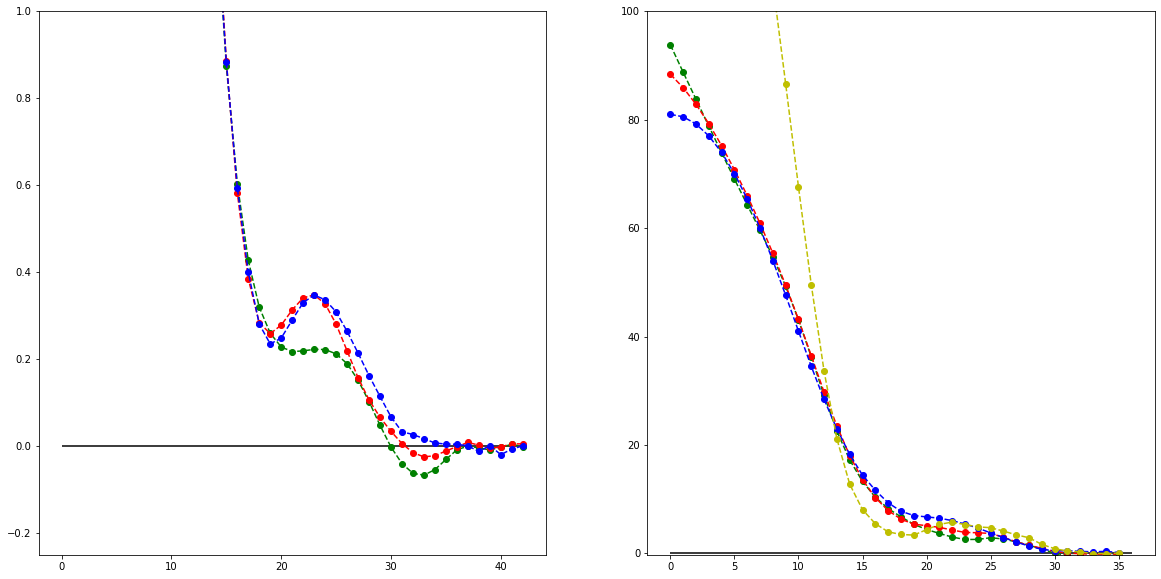

In [504]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'go--')
axs[0].plot(np.array(b_init[1:1+len(pair_knots)])*(6*0.1**3) , 'ro--')
axs[0].plot(np.array(b_init_w[1:1+len(pair_knots)])*(6*0.1**3) , 'bo--')
#axs[0].plot(np.array(b_init_comb[1:1+len(pair_knots)])*(6*0.1**3) , 'yo--')


axs[0].set_ylim(-0.25,1.0)
axs[0].hlines(0.0, 0, 42)
axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'go--')
axs[1].plot(np.array(b_init[1+len(pair_knots):])*(6*0.1**3) , 'ro--')
axs[1].plot(np.array(b_init_w[1+len(pair_knots):])*(6*0.1**3) , 'bo--')
axs[1].plot(np.array(b_init_comb[1+len(pair_knots):])*(6*0.1**3) , 'yo--')
axs[1].set_ylim(-0.25,100)

axs[1].hlines(0.0, 0, 36)

9
[slice(0, 415, 1), slice(415, 1278, 1), slice(1278, 1454, 1), slice(1454, 2079, 1), slice(2079, 2624, 1), slice(2624, 3045, 1), slice(3045, 3531, 1), slice(3531, 3532, 1), slice(0, 3732, 1)]
-768.074 -767.955
-717.863 -711.825


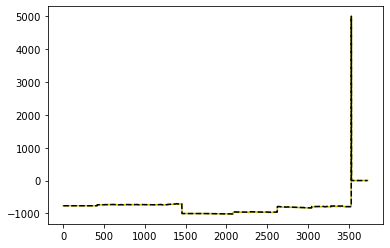

In [505]:
plt.plot(energy(b_all, X), 'y')
plt.plot(y[:], 'k--')
print(len(bounds))
print(bounds)
print([round(z, 3) for z in energy(b_all, X)[bounds[0]]][0], [round(z, 3) for z in y[bounds[0]]][0])
print([round(z, 3) for z in energy(b_all, X)[bounds[2]]][100], [round(z, 3) for z in y[bounds[2]]][100])

In [506]:
stats_file = 'stats_bsf_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bsf_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [507]:
stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

for key in targets.keys():
    targetsx[key]['weight'] = 1.0
    
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys, combined=0.35)
    
    #Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)
yall = yall[:,np.newaxis]

bounds [slice(0, 415, 1), slice(415, 1278, 1), slice(1278, 1454, 1), slice(1454, 2079, 1), slice(2079, 2624, 1), slice(2624, 3045, 1), slice(3045, 3531, 1), slice(3531, 3552, 1), slice(3552, 3560, 1), slice(0, 3760, 1)]
weights [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.35]


In [508]:
b_all

array([-1.64553268e-05,  4.71857174e+03,  4.12329362e+03,  3.57338317e+03,
        3.06908547e+03,  2.61041274e+03,  2.19661725e+03,  1.82625228e+03,
        1.49738599e+03,  1.20801966e+03,  9.56730153e+02,  7.42271650e+02,
        5.62807001e+02,  4.15997774e+02,  2.99306500e+02,  2.10359289e+02,
        1.45693862e+02,  1.00628245e+02,  7.11542412e+01,  5.32117294e+01,
        4.32386822e+01,  3.79792444e+01,  3.62258833e+01,  3.64758891e+01,
        3.70719036e+01,  3.69975191e+01,  3.53354682e+01,  3.15659153e+01,
        2.52723239e+01,  1.70147424e+01,  7.92818875e+00, -3.88761572e-01,
       -6.72008237e+00, -1.04481500e+01, -1.11345766e+01, -9.01179914e+00,
       -5.13518031e+00, -1.41501232e+00, -2.96352812e-02, -7.28422859e-01,
       -1.48006005e+00, -4.84091241e-01,  6.74198687e-01, -2.46971664e-01,
        1.56341864e+04,  1.47909466e+04,  1.39606411e+04,  1.31344338e+04,
        1.23159955e+04,  1.15085333e+04,  1.07157343e+04,  9.93081260e+03,
        9.11933424e+03,  

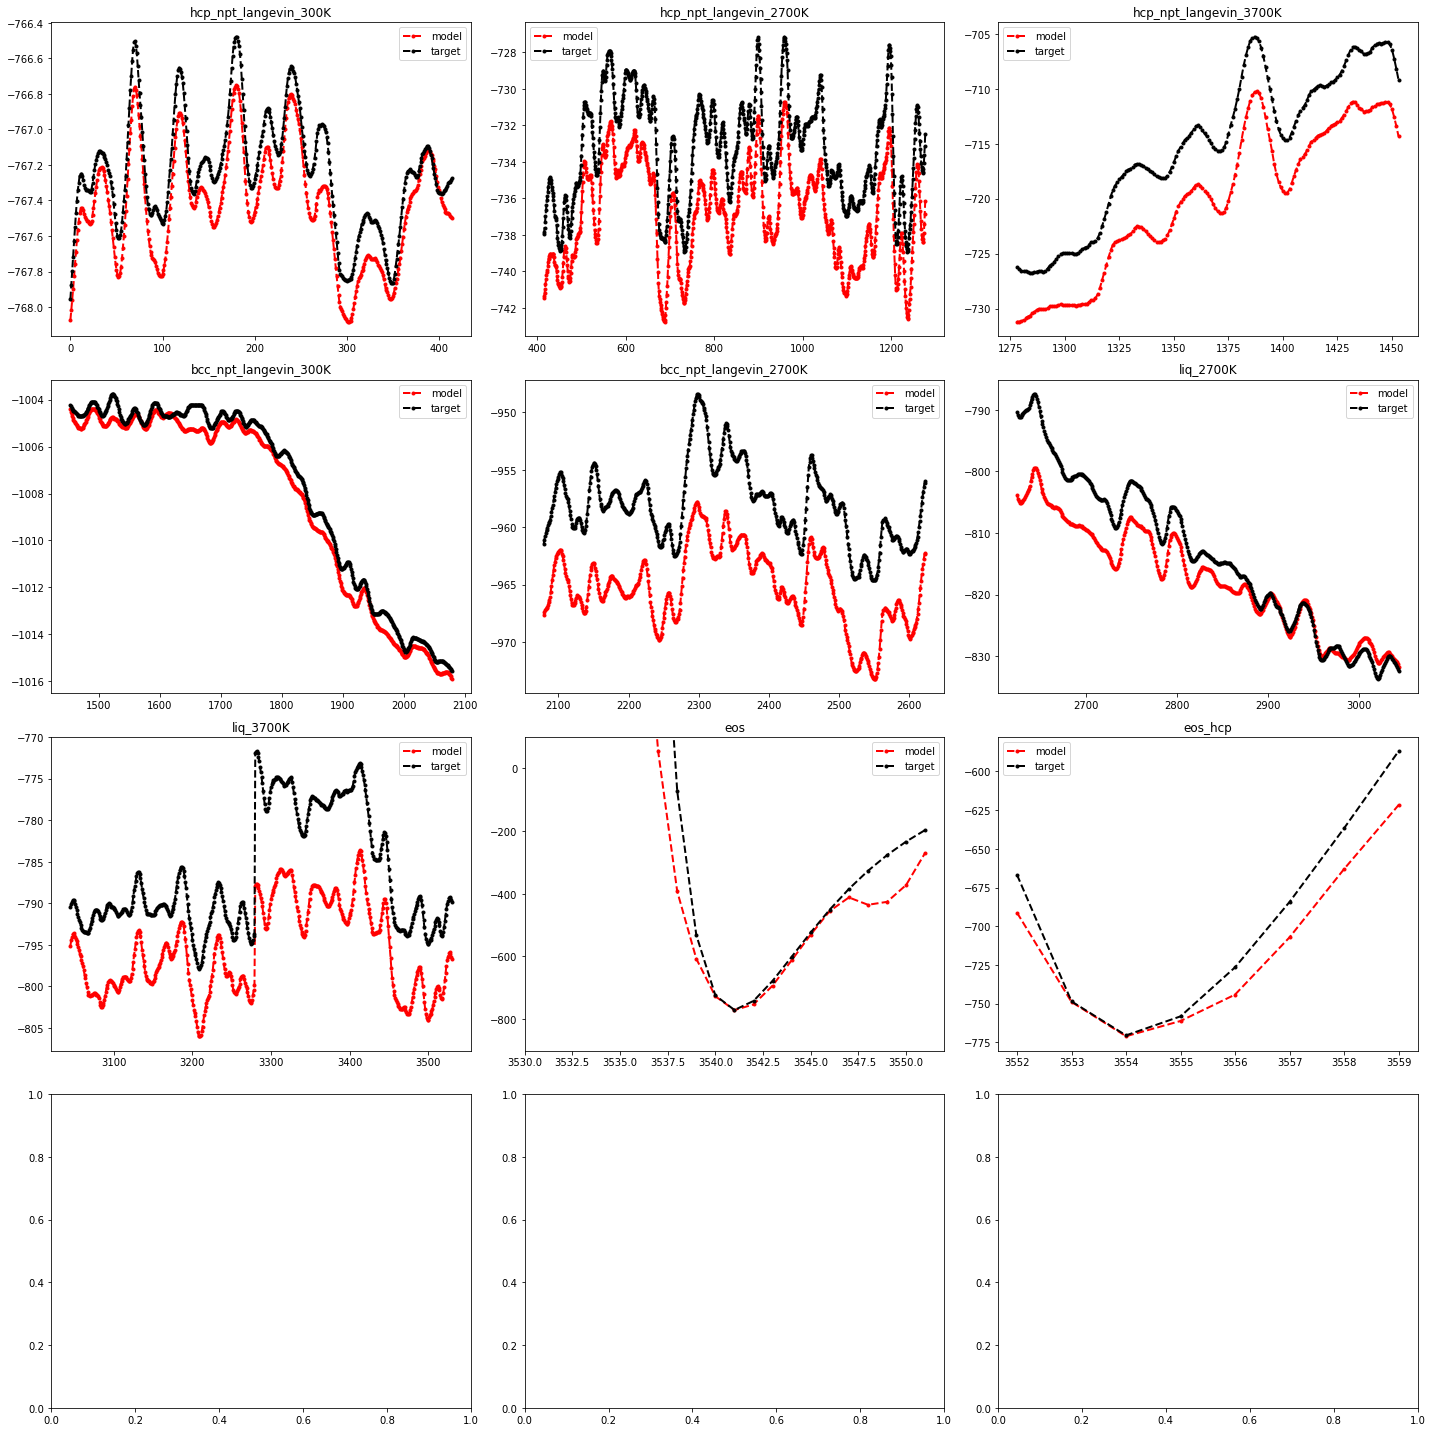

In [509]:
nrows = len(bounds)//3 + 1
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'r.--', lw=2, label='model')
    #axes[i,j].plot(rr, energy(b_init, Xall)[bounds[k]][:], 'r.--', lw=2, label='model')


    axes[i,j].plot(rr, yall[bounds[k],0][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
#     if trj == 'eos':
#         axes[i,j].set_ylim(-1200,1000)
#         #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-900,100)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

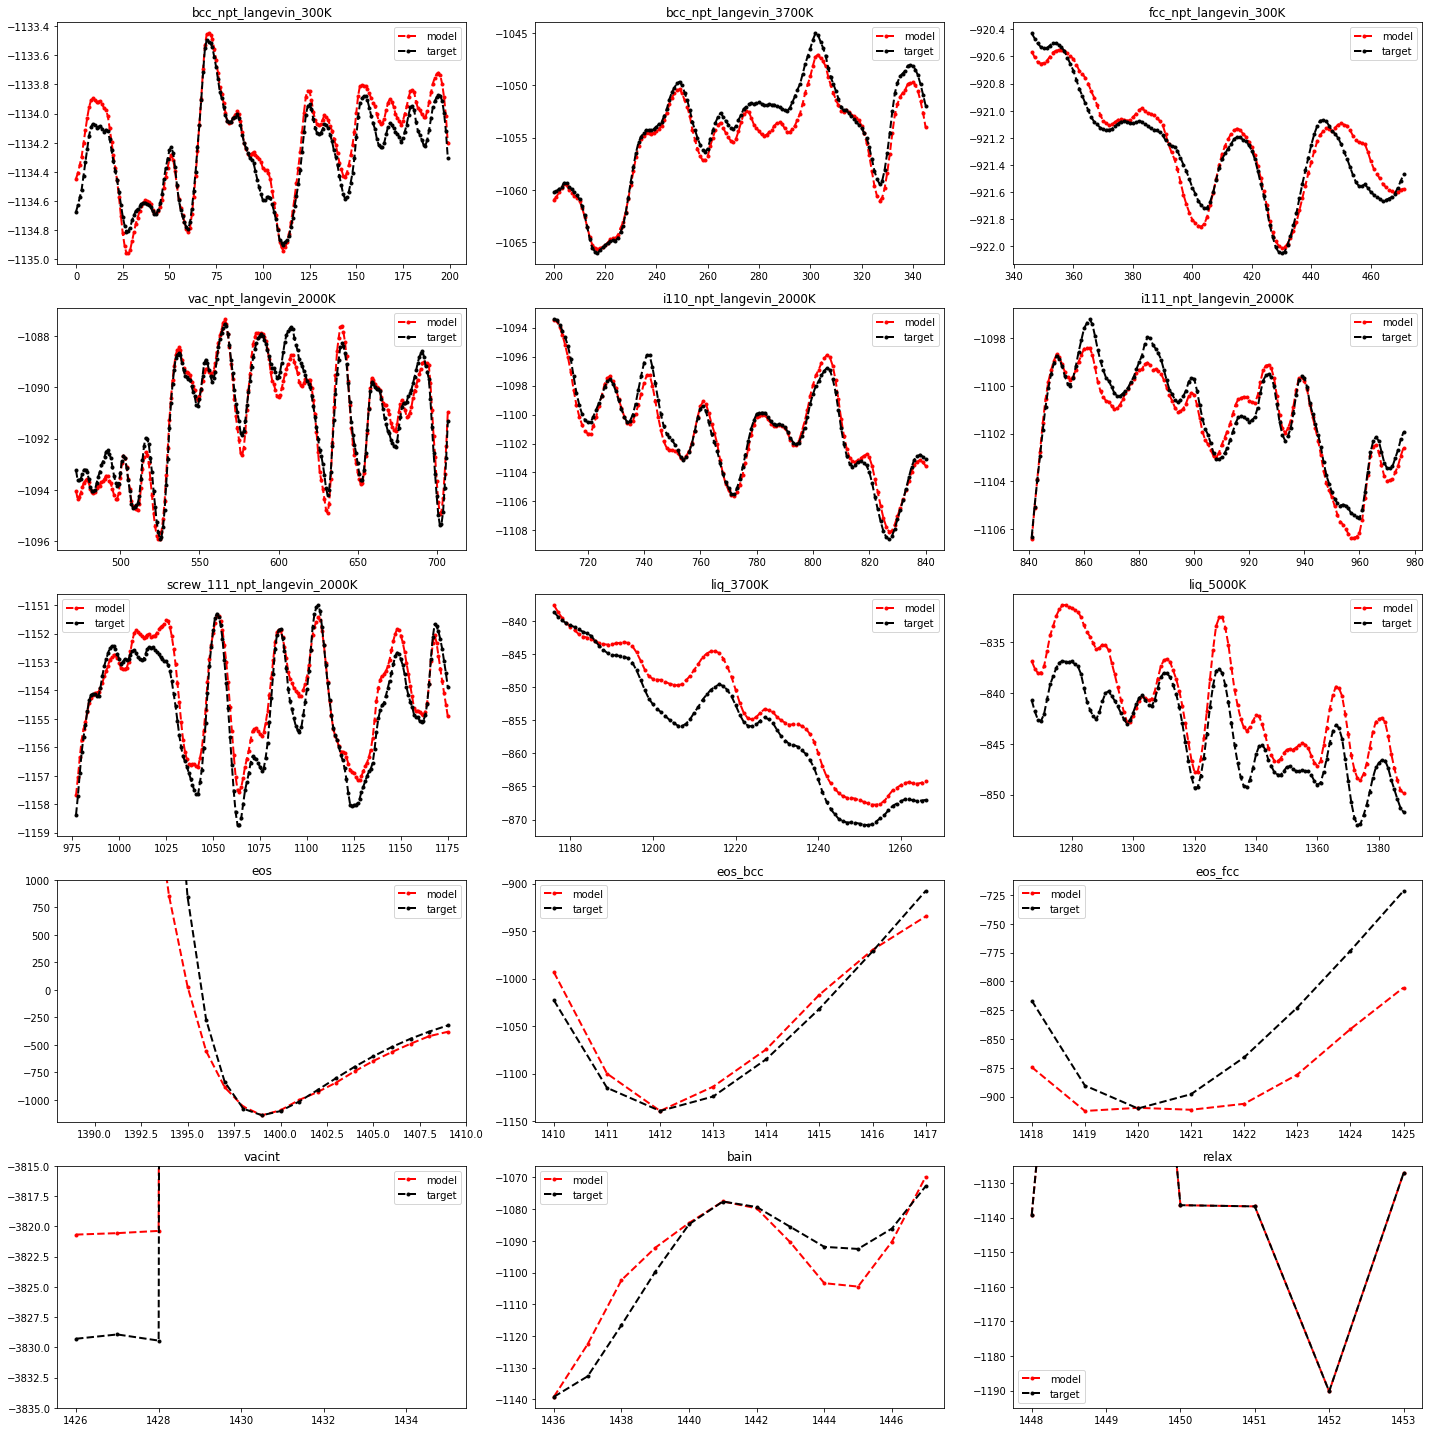

In [27]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'g.--', lw=2, label='model')
    #axes[i,j].plot(rr, energy(b_init, Xall)[bounds[k]][:], 'r.--', lw=2, label='model')


    axes[i,j].plot(rr, yall[bounds[k],0][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [560]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'g.--', lw=2, label='model')
    axes[i,j].plot(rr, energy(b_init, Xall)[bounds[k]][:], 'r.--', lw=2, label='model start')


    axes[i,j].plot(rr, yall[bounds[k],0][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(1395,)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [561]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45 5.55
 5.65]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95]


In [562]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [563]:
M = _bspline_coeffs_to_tpf(43)

In [564]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.70181796e+03  4.11458248e+03  3.56993897e+03  3.06792563e+03
  2.60855106e+03  2.19164573e+03  1.81701390e+03  1.48436502e+03
  1.19298420e+03  9.41818019e+02  7.29222240e+02  5.52866219e+02
  4.09584875e+02  2.96192141e+02  2.10706212e+02  1.47422155e+02
  9.87493381e+01  6.61617279e+01  4.68800167e+01  3.96301718e+01
  4.16616820e+01  4.82100019e+01  5.43292446e+01  5.70305907e+01
  5.55841240e+01  5.16692275e+01  4.49864828e+01  3.70119009e+01
  2.80557087e+01  1.89617881e+01  1.01263740e+01  4.18213719e+00
  3.73753874e+00  3.30668422e+00  1.50886512e+00  6.53698325e-01
  7.36010489e-01  3.62542892e-02 -1.93852683e+00  3.20298768e-01
 -3.12601605e+00 -1.18901093e+00  8.55034562e-02]
[ 4.70181796e+03 -1.46926894e+04  1.53225168e+04 -5.33160720e+03
 -2.96359611e-02 -1.78071399e-01 -2.62635510e-02 -9.47817401e-02
 -4.24350136e-01 -3.38517967e-01 -5.90834352e-01 -6.86395486e-01
 -8.34439217e-01 -2.09875032e-02  1.20426428e+00 -3.72312982e+00
 -1.88569917e+00  9.06460038e+00 -4.2532

In [565]:
Medens = _bspline_coeffs_to_tpf(36)

In [566]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

[13929.2344703  13661.19095276 13292.29910317 12822.37766178
 12249.69929305 11572.04602187 10785.64877262  9892.69358466
  8906.34751341  7850.63057276  6761.34491463  5686.93057836
  4685.1585842   3799.39944772  3027.54377971  2403.92736429
  1936.1339343   1553.50686216  1300.01690269  1173.80539621
  1122.38760758  1079.56443397  1004.12689996   897.87400012
   777.09038059   635.54749255   505.13798954   370.47997407
   242.02894039   128.89246154    77.35563041    78.0344499
    63.90724653    58.06987196    69.61921329    28.58727421]
[ 1.39292345e+04 -4.20557469e+04  4.22229421e+04 -1.40966109e+04
 -1.54607580e+00 -4.90639560e-01 -1.55110049e+00  5.95511494e+00
  1.09810161e+01  1.08529584e+01  1.17821380e+01  1.26378874e+01
  9.33098092e+00 -1.44005047e+01 -4.54799047e+01  3.64451733e+01
 -2.67520513e+01 -7.82403604e+01  1.14627382e+02 -4.58294145e+01
 -5.06260754e+01 -1.37143677e+01  2.49901274e+01  4.30079700e+01
  1.44856516e+01 -2.25131950e+01  3.81212024e+01 -4.72745510e

In [567]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

47 47
40 40


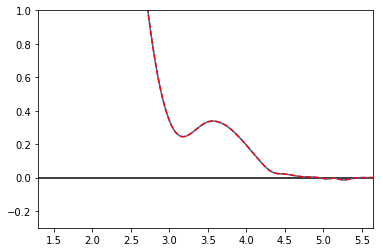

In [568]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

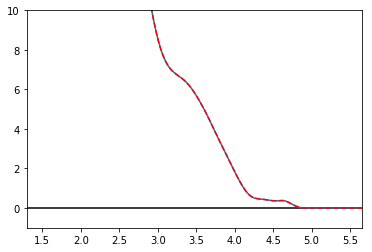

In [569]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-1,10)
#plt.xlim(1.5,2.8)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [570]:
tpf_coeff

array([ 4.70181796e+03, -1.46926894e+04,  1.53225168e+04, -5.33160720e+03,
       -2.96359611e-02, -1.78071399e-01, -2.62635510e-02, -9.47817401e-02,
       -4.24350136e-01, -3.38517967e-01, -5.90834352e-01, -6.86395486e-01,
       -8.34439217e-01, -2.09875032e-02,  1.20426428e+00, -3.72312982e+00,
       -1.88569917e+00,  9.06460038e+00, -4.25327556e+00,  1.50527512e+00,
       -1.47647838e+00, -2.01403413e+00, -1.81341721e-01,  1.95706779e+00,
        2.25890299e+00,  2.40929919e+00, -1.97880130e+00,  1.77542943e+00,
       -1.16578424e+00,  5.33655048e-01, -4.47646999e-01,  2.23643595e+00,
       -2.42097583e-02, -8.09435552e+00,  4.10518594e+00,  3.69032538e+00,
       -2.31479022e+00, -1.71437398e+00,  1.22659077e+00,  6.00158818e+00,
       -1.54473787e+01,  2.10272075e+01, -1.71342710e+01,  5.34828356e+00,
        2.14304841e+00, -1.53102475e+00,  8.55034562e-02])

In [571]:
edens_coeff

array([ 1.39292345e+04, -4.20557469e+04,  4.22229421e+04, -1.40966109e+04,
       -1.54607580e+00, -4.90639560e-01, -1.55110049e+00,  5.95511494e+00,
        1.09810161e+01,  1.08529584e+01,  1.17821380e+01,  1.26378874e+01,
        9.33098092e+00, -1.44005047e+01, -4.54799047e+01,  3.64451733e+01,
       -2.67520513e+01, -7.82403604e+01,  1.14627382e+02, -4.58294145e+01,
       -5.06260754e+01, -1.37143677e+01,  2.49901274e+01,  4.30079700e+01,
        1.44856516e+01, -2.25131950e+01,  3.81212024e+01, -4.72745510e+01,
        2.58373917e+01, -1.34792120e+00,  3.71775199e+01, -5.56690900e+01,
       -5.76376763e+01,  9.01175251e+01, -1.39989645e+01, -7.90648834e+01,
        1.34993942e+02, -4.88833359e+01, -4.47298836e+01,  2.85872742e+01])

In [572]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [573]:
param_list = [params]
#param_list

In [576]:
file_name = os.path.join(working, "params_final_forces.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

In [577]:
file_name = os.path.join(working, "params_final_forces.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [578]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

pair
+4701.817959191992d0*(1.05d0 - r)**3*H(1.05d0 - r)
-14692.689359697128d0*(1.15d0 - r)**3*H(1.15d0 - r)
+15322.516812338035d0*(1.25d0 - r)**3*H(1.25d0 - r)
-5331.607202547126d0*(1.35d0 - r)**3*H(1.35d0 - r)
-0.029635961067469907d0*(1.45d0 - r)**3*H(1.45d0 - r)
-0.17807139896012814d0*(1.55d0 - r)**3*H(1.55d0 - r)
-0.026263551048941736d0*(1.65d0 - r)**3*H(1.65d0 - r)
-0.09478174013929674d0*(1.75d0 - r)**3*H(1.75d0 - r)
-0.42435013604244887d0*(1.85d0 - r)**3*H(1.85d0 - r)
-0.33851796686212765d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.5908343524070006d0*(2.05d0 - r)**3*H(2.05d0 - r)
-0.6863954863258641d0*(2.15d0 - r)**3*H(2.15d0 - r)
-0.8344392170583887d0*(2.25d0 - r)**3*H(2.25d0 - r)
-0.020987503247170025d0*(2.35d0 - r)**3*H(2.35d0 - r)
+1.2042642817093565d0*(2.45d0 - r)**3*H(2.45d0 - r)
-3.7231298243415267d0*(2.55d0 - r)**3*H(2.55d0 - r)
-1.8856991704445818d0*(2.65d0 - r)**3*H(2.65d0 - r)
+9.064600375369196d0*(2.75d0 - r)**3*H(2.75d0 - r)
-4.253275563553018d0*(2.85d0 - r)**3*H(2.85d0 - r)
+

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']